In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import os
import gym_Aircraft
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# creating environment
succeed_coef = 8000         # maximum reward when agent avoids collision
collide_coef = -4000        # reward when agent doesn't avoid collision
change_cmd_penalty = -100   # reward when agent changes command values
cmd_penalty = -0.15          # coefficient of penaly on using command
cmd_suit_coef = -100         # coefficient of suitable command
start_cond_coef = 100       # coefficient of condition on begining
step_size = 10000          # lr scheduling step size

lr = 0.0001
betas = (0.9, 0.999)

env_name = "acav-v0"
env = gym.make(env_name)
env.env.__init__(succeed_coef, collide_coef, change_cmd_penalty, cmd_penalty, start_cond_coef, cmd_suit_coef)
render = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class FClayer(nn.Module):
    def __init__(self, innodes: int, nodes: int):
        super(FClayer, self).__init__()
        self.fc=nn.Linear(innodes,nodes)
        self.act=nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x: Tensor) -> Tensor:
        out=self.fc(x)
        out=self.act(out)
        return out
    
class WaveNET(nn.Module):
    def __init__(self, block: Type[Union[FClayer]], planes: List[int], nodes: List[int], num_classes: int = 3
                ) -> None:
        super(WaveNET, self).__init__()
        self.innodes=5
        
        self.layer1=self._make_layer(block, planes[0], nodes[0])
        self.layer2=self._make_layer(block, planes[1], nodes[1])
        self.layer3=self._make_layer(block, planes[2], nodes[2])
        
        self.fin_fc=nn.Linear(self.innodes,num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    
    def _make_layer(self, block: Type[Union[FClayer]], planes: int, nodes: int) -> nn.Sequential:

        layers = []
        layers.append(block(self.innodes, nodes))
        self.innodes = nodes
        for _ in range(1, planes):
            layers.append(block(self.innodes, nodes))

        return nn.Sequential(*layers)

        
    def _forward_impl(self, x: Tensor) -> Tensor:
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fin_fc(x)
        
        return x
    
    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
random_seed = 1

In [6]:
policy_net = torch.load("./Custom_model_fin").to(device)
target_net = torch.load("./Custom_model_fin").to(device)
target_net.eval()
mean=np.load('mean_test.npy')
std=np.load('std_test.npy')

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type WaveNET. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type FClayer. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/jupyter-kunwoopark/.local/lib/python3.7/sit

In [7]:
n_actions = env.action_space.n

In [8]:
optimizer = optim.Adam(policy_net.parameters(), lr=lr, betas=betas)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size)
memory = ReplayMemory(20000)

In [9]:
steps_done = 0

In [10]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
#         return policy_net(state).max(1)[1].view(1, 1)
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [12]:
if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)

In [13]:
num_episodes = 50000
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()
    state = (state-mean)/std
    state=torch.from_numpy(state.astype(np.float32)).unsqueeze(0).to(device)
    for t in count():
        # 행동 선택과 수행
        
        action = select_action(state)
        next_state, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], dtype=torch.float32).to(device)
        
        next_state = (next_state-mean)/std
        next_state=torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).to(device)

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # 최적화 한단계 수행(목표 네트워크에서)
        optimize_model()
        
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list, height_diff_list = info["info"]
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward.item()))
            break
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    scheduler.step()

print('Complete')
env.close()

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021/03/10 12:55:23
episode : 0 | final step : 99 | total reward : -24699.0
2021/03/10 12:55:24
episode : 1 | final step : 99 | total reward : -18772.0
2021/03/10 12:55:24
episode : 2 | final step : 98 | total reward : -16293.0
2021/03/10 12:55:25
episode : 3 | final step : 99 | total reward : 4807.0
2021/03/10 12:55:25
episode : 4 | final step : 93 | total reward : -6921.0
2021/03/10 12:55:26
episode : 5 | final step : 98 | total reward : -7089.0
2021/03/10 12:55:27
episode : 6 | final step : 98 | total reward : -6817.0
2021/03/10 12:55:28
episode : 7 | final step : 98 | total reward : -4929.0
2021/03/10 12:55:28
episode : 8 | final step : 98 | total reward : -6263.0
2021/03/10 12:55:29
episode : 9 | final step : 100 | total reward : 5757.0
2021/03/10 12:55:30
episode : 10 | final step : 99 | total reward : 5710.0
2021/03/10 12:55:30
episode : 11 | final step : 97 | total reward : -5319.0
2021/03/10 12:55:31
episode : 12 | final step : 97 | total reward : 6804.0
2021/03/10 12:55:32
ep

2021/03/10 12:56:33
episode : 108 | final step : 99 | total reward : -5146.0
2021/03/10 12:56:33
episode : 109 | final step : 98 | total reward : -5025.0
2021/03/10 12:56:34
episode : 110 | final step : 98 | total reward : -5670.0
2021/03/10 12:56:35
episode : 111 | final step : 98 | total reward : -4381.0
2021/03/10 12:56:35
episode : 112 | final step : 98 | total reward : -5714.0
2021/03/10 12:56:36
episode : 113 | final step : 102 | total reward : 7058.0
2021/03/10 12:56:36
episode : 114 | final step : 98 | total reward : 7251.0
2021/03/10 12:56:37
episode : 115 | final step : 98 | total reward : -5081.0
2021/03/10 12:56:38
episode : 116 | final step : 98 | total reward : -6179.0
2021/03/10 12:56:38
episode : 117 | final step : 98 | total reward : -4815.0
2021/03/10 12:56:39
episode : 118 | final step : 98 | total reward : -5850.0
2021/03/10 12:56:39
episode : 119 | final step : 99 | total reward : -4661.0
2021/03/10 12:56:40
episode : 120 | final step : 98 | total reward : -6645.0


2021/03/10 12:57:35
episode : 215 | final step : 98 | total reward : -4663.0
2021/03/10 12:57:36
episode : 216 | final step : 98 | total reward : -5235.0
2021/03/10 12:57:36
episode : 217 | final step : 98 | total reward : -4520.0
2021/03/10 12:57:37
episode : 218 | final step : 102 | total reward : 6721.0
2021/03/10 12:57:37
episode : 219 | final step : 98 | total reward : 7166.0
2021/03/10 12:57:38
episode : 220 | final step : 99 | total reward : -4719.0
2021/03/10 12:57:39
episode : 221 | final step : 98 | total reward : -5487.0
2021/03/10 12:57:39
episode : 222 | final step : 98 | total reward : -5708.0
2021/03/10 12:57:40
episode : 223 | final step : 99 | total reward : -5886.0
2021/03/10 12:57:41
episode : 224 | final step : 98 | total reward : -5891.0
2021/03/10 12:57:41
episode : 225 | final step : 98 | total reward : 7689.0
2021/03/10 12:57:42
episode : 226 | final step : 98 | total reward : -7635.0
2021/03/10 12:57:43
episode : 227 | final step : 98 | total reward : -5606.0
2

2021/03/10 12:58:44
episode : 322 | final step : 101 | total reward : 7511.0
2021/03/10 12:58:45
episode : 323 | final step : 98 | total reward : -5673.0
2021/03/10 12:58:46
episode : 324 | final step : 100 | total reward : -13746.0
2021/03/10 12:58:46
episode : 325 | final step : 98 | total reward : -7578.0
2021/03/10 12:58:47
episode : 326 | final step : 98 | total reward : -7734.0
2021/03/10 12:58:48
episode : 327 | final step : 98 | total reward : -5590.0
2021/03/10 12:58:48
episode : 328 | final step : 98 | total reward : -8110.0
2021/03/10 12:58:49
episode : 329 | final step : 98 | total reward : -13763.0
2021/03/10 12:58:49
episode : 330 | final step : 98 | total reward : -5819.0
2021/03/10 12:58:50
episode : 331 | final step : 97 | total reward : -7392.0
2021/03/10 12:58:50
episode : 332 | final step : 101 | total reward : 5756.0
2021/03/10 12:58:51
episode : 333 | final step : 98 | total reward : -7250.0
2021/03/10 12:58:51
episode : 334 | final step : 98 | total reward : -510

2021/03/10 12:59:51
episode : 429 | final step : 99 | total reward : -13337.0
2021/03/10 12:59:51
episode : 430 | final step : 98 | total reward : -9893.0
2021/03/10 12:59:52
episode : 431 | final step : 98 | total reward : 2185.0
2021/03/10 12:59:53
episode : 432 | final step : 97 | total reward : -478.0
2021/03/10 12:59:53
episode : 433 | final step : 98 | total reward : -16730.0
2021/03/10 12:59:54
episode : 434 | final step : 100 | total reward : -919.0
2021/03/10 12:59:55
episode : 435 | final step : 99 | total reward : -334.0
2021/03/10 12:59:55
episode : 436 | final step : 99 | total reward : 5230.0
2021/03/10 12:59:56
episode : 437 | final step : 100 | total reward : 349.0
2021/03/10 12:59:56
episode : 438 | final step : 97 | total reward : -17755.0
2021/03/10 12:59:57
episode : 439 | final step : 104 | total reward : 2946.0
2021/03/10 12:59:58
episode : 440 | final step : 98 | total reward : -10555.0
2021/03/10 12:59:58
episode : 441 | final step : 99 | total reward : -8950.0


2021/03/10 13:01:00
episode : 536 | final step : 99 | total reward : -15081.0
2021/03/10 13:01:01
episode : 537 | final step : 98 | total reward : 2855.0
2021/03/10 13:01:01
episode : 538 | final step : 98 | total reward : 2865.0
2021/03/10 13:01:02
episode : 539 | final step : 96 | total reward : 3451.0
2021/03/10 13:01:03
episode : 540 | final step : 95 | total reward : -423.0
2021/03/10 13:01:03
episode : 541 | final step : 100 | total reward : 3084.0
2021/03/10 13:01:04
episode : 542 | final step : 99 | total reward : -14211.0
2021/03/10 13:01:05
episode : 543 | final step : 100 | total reward : 3369.0
2021/03/10 13:01:05
episode : 544 | final step : 98 | total reward : 437.0
2021/03/10 13:01:06
episode : 545 | final step : 101 | total reward : 600.0
2021/03/10 13:01:06
episode : 546 | final step : 99 | total reward : -2068.0
2021/03/10 13:01:07
episode : 547 | final step : 100 | total reward : 1576.0
2021/03/10 13:01:08
episode : 548 | final step : 99 | total reward : -13029.0
202

2021/03/10 13:02:10
episode : 643 | final step : 98 | total reward : 3463.0
2021/03/10 13:02:10
episode : 644 | final step : 98 | total reward : -14957.0
2021/03/10 13:02:11
episode : 645 | final step : 98 | total reward : 2581.0
2021/03/10 13:02:12
episode : 646 | final step : 99 | total reward : -15334.0
2021/03/10 13:02:12
episode : 647 | final step : 98 | total reward : 2952.0
2021/03/10 13:02:13
episode : 648 | final step : 99 | total reward : 3021.0
2021/03/10 13:02:14
episode : 649 | final step : 99 | total reward : 4230.0
2021/03/10 13:02:14
episode : 650 | final step : 95 | total reward : 3746.0
2021/03/10 13:02:15
episode : 651 | final step : 99 | total reward : 4190.0
2021/03/10 13:02:16
episode : 652 | final step : 97 | total reward : 688.0
2021/03/10 13:02:16
episode : 653 | final step : 95 | total reward : 2319.0
2021/03/10 13:02:17
episode : 654 | final step : 99 | total reward : -1127.0
2021/03/10 13:02:18
episode : 655 | final step : 99 | total reward : 2722.0
2021/03/

2021/03/10 13:03:16
episode : 750 | final step : 94 | total reward : 3597.0
2021/03/10 13:03:16
episode : 751 | final step : 98 | total reward : -14249.0
2021/03/10 13:03:17
episode : 752 | final step : 98 | total reward : 4341.0
2021/03/10 13:03:18
episode : 753 | final step : 98 | total reward : 3904.0
2021/03/10 13:03:18
episode : 754 | final step : 99 | total reward : -9215.0
2021/03/10 13:03:19
episode : 755 | final step : 98 | total reward : -16397.0
2021/03/10 13:03:20
episode : 756 | final step : 98 | total reward : -17053.0
2021/03/10 13:03:20
episode : 757 | final step : 97 | total reward : 3480.0
2021/03/10 13:03:21
episode : 758 | final step : 98 | total reward : 3359.0
2021/03/10 13:03:22
episode : 759 | final step : 99 | total reward : -13181.0
2021/03/10 13:03:22
episode : 760 | final step : 100 | total reward : -15740.0
2021/03/10 13:03:23
episode : 761 | final step : 100 | total reward : 2971.0
2021/03/10 13:03:24
episode : 762 | final step : 98 | total reward : -15304

2021/03/10 13:04:27
episode : 857 | final step : 100 | total reward : -3196.0
2021/03/10 13:04:27
episode : 858 | final step : 99 | total reward : 3180.0
2021/03/10 13:04:28
episode : 859 | final step : 99 | total reward : 3902.0
2021/03/10 13:04:29
episode : 860 | final step : 99 | total reward : -3299.0
2021/03/10 13:04:29
episode : 861 | final step : 99 | total reward : -17511.0
2021/03/10 13:04:30
episode : 862 | final step : 99 | total reward : -3326.0
2021/03/10 13:04:31
episode : 863 | final step : 98 | total reward : -3068.0
2021/03/10 13:04:32
episode : 864 | final step : 99 | total reward : 3688.0
2021/03/10 13:04:32
episode : 865 | final step : 98 | total reward : 4277.0
2021/03/10 13:04:33
episode : 866 | final step : 100 | total reward : 2023.0
2021/03/10 13:04:34
episode : 867 | final step : 99 | total reward : 2253.0
2021/03/10 13:04:35
episode : 868 | final step : 99 | total reward : 1472.0
2021/03/10 13:04:35
episode : 869 | final step : 94 | total reward : 1709.0
2021

2021/03/10 13:05:38
episode : 964 | final step : 94 | total reward : 2883.0
2021/03/10 13:05:39
episode : 965 | final step : 100 | total reward : 1438.0
2021/03/10 13:05:40
episode : 966 | final step : 100 | total reward : 2029.0
2021/03/10 13:05:41
episode : 967 | final step : 100 | total reward : -4112.0
2021/03/10 13:05:41
episode : 968 | final step : 100 | total reward : 1702.0
2021/03/10 13:05:42
episode : 969 | final step : 100 | total reward : 1826.0
2021/03/10 13:05:43
episode : 970 | final step : 99 | total reward : 1930.0
2021/03/10 13:05:43
episode : 971 | final step : 98 | total reward : -6687.0
2021/03/10 13:05:44
episode : 972 | final step : 98 | total reward : -4657.0
2021/03/10 13:05:45
episode : 973 | final step : 95 | total reward : -4706.0
2021/03/10 13:05:46
episode : 974 | final step : 97 | total reward : 1990.0
2021/03/10 13:05:46
episode : 975 | final step : 100 | total reward : -5436.0
2021/03/10 13:05:47
episode : 976 | final step : 100 | total reward : 2131.0


2021/03/10 13:06:49
episode : 1070 | final step : 99 | total reward : 2158.0
2021/03/10 13:06:50
episode : 1071 | final step : 97 | total reward : 638.0
2021/03/10 13:06:50
episode : 1072 | final step : 100 | total reward : -5371.0
2021/03/10 13:06:51
episode : 1073 | final step : 100 | total reward : 1340.0
2021/03/10 13:06:52
episode : 1074 | final step : 97 | total reward : -6567.0
2021/03/10 13:06:52
episode : 1075 | final step : 99 | total reward : 2513.0
2021/03/10 13:06:53
episode : 1076 | final step : 96 | total reward : 3064.0
2021/03/10 13:06:54
episode : 1077 | final step : 100 | total reward : 1912.0
2021/03/10 13:06:54
episode : 1078 | final step : 93 | total reward : 3043.0
2021/03/10 13:06:55
episode : 1079 | final step : 99 | total reward : 2007.0
2021/03/10 13:06:56
episode : 1080 | final step : 99 | total reward : -6208.0
2021/03/10 13:06:56
episode : 1081 | final step : 100 | total reward : -6310.0
2021/03/10 13:06:57
episode : 1082 | final step : 100 | total reward 

2021/03/10 13:07:59
episode : 1176 | final step : 100 | total reward : 979.0
2021/03/10 13:08:00
episode : 1177 | final step : 99 | total reward : -5681.0
2021/03/10 13:08:01
episode : 1178 | final step : 95 | total reward : 2334.0
2021/03/10 13:08:01
episode : 1179 | final step : 99 | total reward : 1988.0
2021/03/10 13:08:02
episode : 1180 | final step : 99 | total reward : -7351.0
2021/03/10 13:08:02
episode : 1181 | final step : 98 | total reward : -6119.0
2021/03/10 13:08:03
episode : 1182 | final step : 100 | total reward : 880.0
2021/03/10 13:08:04
episode : 1183 | final step : 100 | total reward : -6997.0
2021/03/10 13:08:05
episode : 1184 | final step : 99 | total reward : -5847.0
2021/03/10 13:08:05
episode : 1185 | final step : 100 | total reward : 1522.0
2021/03/10 13:08:06
episode : 1186 | final step : 100 | total reward : -5349.0
2021/03/10 13:08:07
episode : 1187 | final step : 100 | total reward : -5583.0
2021/03/10 13:08:07
episode : 1188 | final step : 97 | total rewa

2021/03/10 13:09:05
episode : 1282 | final step : 97 | total reward : -3192.0
2021/03/10 13:09:06
episode : 1283 | final step : 96 | total reward : -3441.0
2021/03/10 13:09:06
episode : 1284 | final step : 99 | total reward : 977.0
2021/03/10 13:09:07
episode : 1285 | final step : 99 | total reward : 2087.0
2021/03/10 13:09:08
episode : 1286 | final step : 99 | total reward : -4632.0
2021/03/10 13:09:09
episode : 1287 | final step : 100 | total reward : -16645.0
2021/03/10 13:09:09
episode : 1288 | final step : 100 | total reward : 2085.0
2021/03/10 13:09:10
episode : 1289 | final step : 97 | total reward : -5381.0
2021/03/10 13:09:10
episode : 1290 | final step : 96 | total reward : 2481.0
2021/03/10 13:09:11
episode : 1291 | final step : 98 | total reward : 1411.0
2021/03/10 13:09:12
episode : 1292 | final step : 99 | total reward : -16997.0
2021/03/10 13:09:12
episode : 1293 | final step : 99 | total reward : 1307.0
2021/03/10 13:09:13
episode : 1294 | final step : 99 | total reward

2021/03/10 13:10:11
episode : 1388 | final step : 100 | total reward : -3123.0
2021/03/10 13:10:12
episode : 1389 | final step : 99 | total reward : 3107.0
2021/03/10 13:10:13
episode : 1390 | final step : 99 | total reward : -16321.0
2021/03/10 13:10:13
episode : 1391 | final step : 98 | total reward : 2226.0
2021/03/10 13:10:14
episode : 1392 | final step : 99 | total reward : -15368.0
2021/03/10 13:10:15
episode : 1393 | final step : 98 | total reward : -4733.0
2021/03/10 13:10:15
episode : 1394 | final step : 100 | total reward : 2794.0
2021/03/10 13:10:16
episode : 1395 | final step : 99 | total reward : -2302.0
2021/03/10 13:10:16
episode : 1396 | final step : 100 | total reward : 2426.0
2021/03/10 13:10:17
episode : 1397 | final step : 100 | total reward : -2200.0
2021/03/10 13:10:18
episode : 1398 | final step : 98 | total reward : -4030.0
2021/03/10 13:10:18
episode : 1399 | final step : 99 | total reward : -15307.0
2021/03/10 13:10:19
episode : 1400 | final step : 99 | total 

2021/03/10 13:11:17
episode : 1493 | final step : 99 | total reward : -14260.0
2021/03/10 13:11:18
episode : 1494 | final step : 99 | total reward : 3369.0
2021/03/10 13:11:19
episode : 1495 | final step : 100 | total reward : -14621.0
2021/03/10 13:11:19
episode : 1496 | final step : 99 | total reward : 2711.0
2021/03/10 13:11:20
episode : 1497 | final step : 100 | total reward : 3637.0
2021/03/10 13:11:21
episode : 1498 | final step : 100 | total reward : 3140.0
2021/03/10 13:11:21
episode : 1499 | final step : 99 | total reward : -2754.0
2021/03/10 13:11:22
episode : 1500 | final step : 97 | total reward : -2317.0
2021/03/10 13:11:23
episode : 1501 | final step : 98 | total reward : -3019.0
2021/03/10 13:11:23
episode : 1502 | final step : 99 | total reward : -16642.0
2021/03/10 13:11:24
episode : 1503 | final step : 98 | total reward : -2559.0
2021/03/10 13:11:25
episode : 1504 | final step : 96 | total reward : 797.0
2021/03/10 13:11:25
episode : 1505 | final step : 97 | total rew

2021/03/10 13:12:26
episode : 1598 | final step : 99 | total reward : 2592.0
2021/03/10 13:12:27
episode : 1599 | final step : 98 | total reward : -14753.0
2021/03/10 13:12:27
episode : 1600 | final step : 99 | total reward : 2739.0
2021/03/10 13:12:28
episode : 1601 | final step : 99 | total reward : -13952.0
2021/03/10 13:12:29
episode : 1602 | final step : 100 | total reward : 2423.0
2021/03/10 13:12:29
episode : 1603 | final step : 100 | total reward : -12966.0
2021/03/10 13:12:30
episode : 1604 | final step : 100 | total reward : 3013.0
2021/03/10 13:12:31
episode : 1605 | final step : 99 | total reward : 2464.0
2021/03/10 13:12:31
episode : 1606 | final step : 97 | total reward : 4332.0
2021/03/10 13:12:32
episode : 1607 | final step : 94 | total reward : 4151.0
2021/03/10 13:12:32
episode : 1608 | final step : 100 | total reward : -3030.0
2021/03/10 13:12:33
episode : 1609 | final step : 100 | total reward : -2360.0
2021/03/10 13:12:34
episode : 1610 | final step : 97 | total re

2021/03/10 13:13:35
episode : 1704 | final step : 98 | total reward : -13261.0
2021/03/10 13:13:36
episode : 1705 | final step : 98 | total reward : -975.0
2021/03/10 13:13:36
episode : 1706 | final step : 97 | total reward : 4096.0
2021/03/10 13:13:37
episode : 1707 | final step : 98 | total reward : -13065.0
2021/03/10 13:13:38
episode : 1708 | final step : 94 | total reward : 4274.0
2021/03/10 13:13:38
episode : 1709 | final step : 100 | total reward : -236.0
2021/03/10 13:13:39
episode : 1710 | final step : 99 | total reward : 3589.0
2021/03/10 13:13:40
episode : 1711 | final step : 99 | total reward : -13928.0
2021/03/10 13:13:40
episode : 1712 | final step : 99 | total reward : -12920.0
2021/03/10 13:13:41
episode : 1713 | final step : 99 | total reward : -453.0
2021/03/10 13:13:42
episode : 1714 | final step : 98 | total reward : -1847.0
2021/03/10 13:13:42
episode : 1715 | final step : 94 | total reward : 5237.0
2021/03/10 13:13:43
episode : 1716 | final step : 99 | total rewar

2021/03/10 13:14:40
episode : 1810 | final step : 97 | total reward : -1773.0
2021/03/10 13:14:41
episode : 1811 | final step : 98 | total reward : -11928.0
2021/03/10 13:14:42
episode : 1812 | final step : 99 | total reward : 3903.0
2021/03/10 13:14:42
episode : 1813 | final step : 96 | total reward : 4579.0
2021/03/10 13:14:43
episode : 1814 | final step : 98 | total reward : -12063.0
2021/03/10 13:14:44
episode : 1815 | final step : 99 | total reward : -12560.0
2021/03/10 13:14:44
episode : 1816 | final step : 96 | total reward : -150.0
2021/03/10 13:14:45
episode : 1817 | final step : 96 | total reward : -270.0
2021/03/10 13:14:45
episode : 1818 | final step : 100 | total reward : 3896.0
2021/03/10 13:14:46
episode : 1819 | final step : 99 | total reward : 4975.0
2021/03/10 13:14:47
episode : 1820 | final step : 98 | total reward : 5463.0
2021/03/10 13:14:47
episode : 1821 | final step : 99 | total reward : 4602.0
2021/03/10 13:14:48
episode : 1822 | final step : 99 | total reward 

2021/03/10 13:15:50
episode : 1916 | final step : 99 | total reward : -8884.0
2021/03/10 13:15:51
episode : 1917 | final step : 98 | total reward : 4872.0
2021/03/10 13:15:52
episode : 1918 | final step : 100 | total reward : 4155.0
2021/03/10 13:15:52
episode : 1919 | final step : 99 | total reward : -10688.0
2021/03/10 13:15:53
episode : 1920 | final step : 99 | total reward : -12154.0
2021/03/10 13:15:53
episode : 1921 | final step : 98 | total reward : -11241.0
2021/03/10 13:15:54
episode : 1922 | final step : 97 | total reward : 4446.0
2021/03/10 13:15:55
episode : 1923 | final step : 99 | total reward : -11884.0
2021/03/10 13:15:55
episode : 1924 | final step : 98 | total reward : -11372.0
2021/03/10 13:15:56
episode : 1925 | final step : 98 | total reward : -11535.0
2021/03/10 13:15:57
episode : 1926 | final step : 98 | total reward : 5718.0
2021/03/10 13:15:57
episode : 1927 | final step : 100 | total reward : -7356.0
2021/03/10 13:15:58
episode : 1928 | final step : 99 | total

2021/03/10 13:16:58
episode : 2022 | final step : 100 | total reward : 42.0
2021/03/10 13:16:59
episode : 2023 | final step : 97 | total reward : 4844.0
2021/03/10 13:16:59
episode : 2024 | final step : 98 | total reward : -12689.0
2021/03/10 13:17:00
episode : 2025 | final step : 100 | total reward : 4686.0
2021/03/10 13:17:01
episode : 2026 | final step : 97 | total reward : 4934.0
2021/03/10 13:17:01
episode : 2027 | final step : 99 | total reward : -6795.0
2021/03/10 13:17:02
episode : 2028 | final step : 98 | total reward : 1788.0
2021/03/10 13:17:02
episode : 2029 | final step : 100 | total reward : -7877.0
2021/03/10 13:17:03
episode : 2030 | final step : 98 | total reward : -12173.0
2021/03/10 13:17:03
episode : 2031 | final step : 99 | total reward : -11532.0
2021/03/10 13:17:04
episode : 2032 | final step : 99 | total reward : 4751.0
2021/03/10 13:17:05
episode : 2033 | final step : 99 | total reward : 799.0
2021/03/10 13:17:06
episode : 2034 | final step : 98 | total reward 

2021/03/10 13:18:04
episode : 2128 | final step : 98 | total reward : -10012.0
2021/03/10 13:18:05
episode : 2129 | final step : 100 | total reward : -7813.0
2021/03/10 13:18:05
episode : 2130 | final step : 99 | total reward : -7733.0
2021/03/10 13:18:06
episode : 2131 | final step : 99 | total reward : -11301.0
2021/03/10 13:18:07
episode : 2132 | final step : 101 | total reward : 1316.0
2021/03/10 13:18:08
episode : 2133 | final step : 99 | total reward : -11995.0
2021/03/10 13:18:08
episode : 2134 | final step : 92 | total reward : 5488.0
2021/03/10 13:18:09
episode : 2135 | final step : 99 | total reward : -9319.0
2021/03/10 13:18:10
episode : 2136 | final step : 98 | total reward : -12576.0
2021/03/10 13:18:10
episode : 2137 | final step : 100 | total reward : 4482.0
2021/03/10 13:18:11
episode : 2138 | final step : 98 | total reward : -9487.0
2021/03/10 13:18:12
episode : 2139 | final step : 98 | total reward : 1518.0
2021/03/10 13:18:12
episode : 2140 | final step : 98 | total 

2021/03/10 13:19:14
episode : 2234 | final step : 98 | total reward : 2648.0
2021/03/10 13:19:14
episode : 2235 | final step : 99 | total reward : 4124.0
2021/03/10 13:19:15
episode : 2236 | final step : 99 | total reward : -9476.0
2021/03/10 13:19:16
episode : 2237 | final step : 97 | total reward : 6130.0
2021/03/10 13:19:16
episode : 2238 | final step : 100 | total reward : 5372.0
2021/03/10 13:19:17
episode : 2239 | final step : 98 | total reward : -11392.0
2021/03/10 13:19:18
episode : 2240 | final step : 99 | total reward : 5974.0
2021/03/10 13:19:18
episode : 2241 | final step : 98 | total reward : -9801.0
2021/03/10 13:19:19
episode : 2242 | final step : 99 | total reward : -6597.0
2021/03/10 13:19:20
episode : 2243 | final step : 98 | total reward : 5169.0
2021/03/10 13:19:20
episode : 2244 | final step : 98 | total reward : -9080.0
2021/03/10 13:19:21
episode : 2245 | final step : 98 | total reward : -9098.0
2021/03/10 13:19:22
episode : 2246 | final step : 100 | total reward

2021/03/10 13:20:16
episode : 2340 | final step : 100 | total reward : -5831.0
2021/03/10 13:20:17
episode : 2341 | final step : 100 | total reward : -6504.0
2021/03/10 13:20:18
episode : 2342 | final step : 98 | total reward : 5600.0
2021/03/10 13:20:18
episode : 2343 | final step : 99 | total reward : 5872.0
2021/03/10 13:20:19
episode : 2344 | final step : 99 | total reward : 5539.0
2021/03/10 13:20:20
episode : 2345 | final step : 99 | total reward : 5818.0
2021/03/10 13:20:20
episode : 2346 | final step : 98 | total reward : -8836.0
2021/03/10 13:20:21
episode : 2347 | final step : 96 | total reward : 6589.0
2021/03/10 13:20:22
episode : 2348 | final step : 97 | total reward : 4200.0
2021/03/10 13:20:22
episode : 2349 | final step : 99 | total reward : -10134.0
2021/03/10 13:20:23
episode : 2350 | final step : 96 | total reward : 2762.0
2021/03/10 13:20:23
episode : 2351 | final step : 98 | total reward : -10998.0
2021/03/10 13:20:24
episode : 2352 | final step : 98 | total reward

2021/03/10 13:21:24
episode : 2446 | final step : 98 | total reward : -8533.0
2021/03/10 13:21:24
episode : 2447 | final step : 98 | total reward : 6031.0
2021/03/10 13:21:25
episode : 2448 | final step : 96 | total reward : 3883.0
2021/03/10 13:21:26
episode : 2449 | final step : 99 | total reward : -6628.0
2021/03/10 13:21:26
episode : 2450 | final step : 99 | total reward : -6779.0
2021/03/10 13:21:27
episode : 2451 | final step : 98 | total reward : -8498.0
2021/03/10 13:21:27
episode : 2452 | final step : 98 | total reward : -8526.0
2021/03/10 13:21:28
episode : 2453 | final step : 98 | total reward : 3498.0
2021/03/10 13:21:29
episode : 2454 | final step : 102 | total reward : 2384.0
2021/03/10 13:21:29
episode : 2455 | final step : 98 | total reward : -7564.0
2021/03/10 13:21:30
episode : 2456 | final step : 98 | total reward : -8273.0
2021/03/10 13:21:30
episode : 2457 | final step : 98 | total reward : -6215.0
2021/03/10 13:21:31
episode : 2458 | final step : 99 | total reward

2021/03/10 13:22:32
episode : 2552 | final step : 99 | total reward : 3588.0
2021/03/10 13:22:33
episode : 2553 | final step : 97 | total reward : 6653.0
2021/03/10 13:22:34
episode : 2554 | final step : 99 | total reward : -5861.0
2021/03/10 13:22:35
episode : 2555 | final step : 98 | total reward : -8885.0
2021/03/10 13:22:35
episode : 2556 | final step : 99 | total reward : -5861.0
2021/03/10 13:22:36
episode : 2557 | final step : 98 | total reward : -9552.0
2021/03/10 13:22:37
episode : 2558 | final step : 98 | total reward : -8412.0
2021/03/10 13:22:37
episode : 2559 | final step : 98 | total reward : -6476.0
2021/03/10 13:22:38
episode : 2560 | final step : 98 | total reward : 3834.0
2021/03/10 13:22:39
episode : 2561 | final step : 98 | total reward : -8567.0
2021/03/10 13:22:40
episode : 2562 | final step : 99 | total reward : -8590.0
2021/03/10 13:22:40
episode : 2563 | final step : 99 | total reward : 6462.0
2021/03/10 13:22:41
episode : 2564 | final step : 99 | total reward 

2021/03/10 13:23:42
episode : 2658 | final step : 98 | total reward : -9274.0
2021/03/10 13:23:43
episode : 2659 | final step : 103 | total reward : 2683.0
2021/03/10 13:23:43
episode : 2660 | final step : 99 | total reward : -6409.0
2021/03/10 13:23:44
episode : 2661 | final step : 98 | total reward : -5320.0
2021/03/10 13:23:45
episode : 2662 | final step : 99 | total reward : 3992.0
2021/03/10 13:23:45
episode : 2663 | final step : 98 | total reward : -8714.0
2021/03/10 13:23:46
episode : 2664 | final step : 98 | total reward : -5878.0
2021/03/10 13:23:46
episode : 2665 | final step : 99 | total reward : -5892.0
2021/03/10 13:23:47
episode : 2666 | final step : 100 | total reward : 4962.0
2021/03/10 13:23:48
episode : 2667 | final step : 97 | total reward : 6463.0
2021/03/10 13:23:48
episode : 2668 | final step : 99 | total reward : -9031.0
2021/03/10 13:23:49
episode : 2669 | final step : 97 | total reward : -6987.0
2021/03/10 13:23:49
episode : 2670 | final step : 98 | total rewar

2021/03/10 13:24:48
episode : 2764 | final step : 98 | total reward : -4470.0
2021/03/10 13:24:48
episode : 2765 | final step : 98 | total reward : -5737.0
2021/03/10 13:24:49
episode : 2766 | final step : 98 | total reward : -7771.0
2021/03/10 13:24:49
episode : 2767 | final step : 100 | total reward : -4824.0
2021/03/10 13:24:50
episode : 2768 | final step : 99 | total reward : 4884.0
2021/03/10 13:24:50
episode : 2769 | final step : 97 | total reward : 4033.0
2021/03/10 13:24:51
episode : 2770 | final step : 99 | total reward : -8376.0
2021/03/10 13:24:51
episode : 2771 | final step : 98 | total reward : -8652.0
2021/03/10 13:24:52
episode : 2772 | final step : 98 | total reward : 6375.0
2021/03/10 13:24:52
episode : 2773 | final step : 98 | total reward : -5622.0
2021/03/10 13:24:53
episode : 2774 | final step : 98 | total reward : -6848.0
2021/03/10 13:24:53
episode : 2775 | final step : 98 | total reward : -7829.0
2021/03/10 13:24:54
episode : 2776 | final step : 97 | total rewar

2021/03/10 13:25:50
episode : 2870 | final step : 99 | total reward : -6971.0
2021/03/10 13:25:50
episode : 2871 | final step : 99 | total reward : -4818.0
2021/03/10 13:25:51
episode : 2872 | final step : 98 | total reward : -5915.0
2021/03/10 13:25:52
episode : 2873 | final step : 99 | total reward : -5583.0
2021/03/10 13:25:52
episode : 2874 | final step : 102 | total reward : 5175.0
2021/03/10 13:25:53
episode : 2875 | final step : 98 | total reward : -4965.0
2021/03/10 13:25:54
episode : 2876 | final step : 98 | total reward : -6849.0
2021/03/10 13:25:54
episode : 2877 | final step : 98 | total reward : 6432.0
2021/03/10 13:25:55
episode : 2878 | final step : 98 | total reward : -6608.0
2021/03/10 13:25:55
episode : 2879 | final step : 98 | total reward : -8803.0
2021/03/10 13:25:56
episode : 2880 | final step : 98 | total reward : -6162.0
2021/03/10 13:25:57
episode : 2881 | final step : 98 | total reward : 6429.0
2021/03/10 13:25:57
episode : 2882 | final step : 98 | total rewar

2021/03/10 13:26:58
episode : 2976 | final step : 98 | total reward : -5027.0
2021/03/10 13:26:58
episode : 2977 | final step : 101 | total reward : 7207.0
2021/03/10 13:26:59
episode : 2978 | final step : 99 | total reward : -8215.0
2021/03/10 13:26:59
episode : 2979 | final step : 99 | total reward : 6113.0
2021/03/10 13:27:00
episode : 2980 | final step : 99 | total reward : -5917.0
2021/03/10 13:27:01
episode : 2981 | final step : 98 | total reward : -4721.0
2021/03/10 13:27:01
episode : 2982 | final step : 99 | total reward : -4871.0
2021/03/10 13:27:02
episode : 2983 | final step : 98 | total reward : 3783.0
2021/03/10 13:27:03
episode : 2984 | final step : 98 | total reward : -5322.0
2021/03/10 13:27:03
episode : 2985 | final step : 98 | total reward : 6056.0
2021/03/10 13:27:04
episode : 2986 | final step : 98 | total reward : -4665.0
2021/03/10 13:27:05
episode : 2987 | final step : 98 | total reward : -5303.0
2021/03/10 13:27:05
episode : 2988 | final step : 99 | total reward

2021/03/10 13:28:11
episode : 3082 | final step : 99 | total reward : -4686.0
2021/03/10 13:28:11
episode : 3083 | final step : 100 | total reward : 6721.0
2021/03/10 13:28:12
episode : 3084 | final step : 99 | total reward : -5377.0
2021/03/10 13:28:12
episode : 3085 | final step : 99 | total reward : -4862.0
2021/03/10 13:28:13
episode : 3086 | final step : 98 | total reward : -6676.0
2021/03/10 13:28:14
episode : 3087 | final step : 98 | total reward : -7136.0
2021/03/10 13:28:14
episode : 3088 | final step : 101 | total reward : 6395.0
2021/03/10 13:28:15
episode : 3089 | final step : 98 | total reward : -4973.0
2021/03/10 13:28:16
episode : 3090 | final step : 99 | total reward : -5760.0
2021/03/10 13:28:16
episode : 3091 | final step : 98 | total reward : -6947.0
2021/03/10 13:28:17
episode : 3092 | final step : 97 | total reward : -5195.0
2021/03/10 13:28:18
episode : 3093 | final step : 100 | total reward : -7399.0
2021/03/10 13:28:18
episode : 3094 | final step : 98 | total re

2021/03/10 13:29:19
episode : 3188 | final step : 101 | total reward : -4472.0
2021/03/10 13:29:19
episode : 3189 | final step : 98 | total reward : -7302.0
2021/03/10 13:29:20
episode : 3190 | final step : 98 | total reward : 6162.0
2021/03/10 13:29:21
episode : 3191 | final step : 98 | total reward : -5282.0
2021/03/10 13:29:21
episode : 3192 | final step : 98 | total reward : -5196.0
2021/03/10 13:29:22
episode : 3193 | final step : 97 | total reward : 4657.0
2021/03/10 13:29:22
episode : 3194 | final step : 104 | total reward : 7033.0
2021/03/10 13:29:23
episode : 3195 | final step : 97 | total reward : 6690.0
2021/03/10 13:29:24
episode : 3196 | final step : 98 | total reward : -7668.0
2021/03/10 13:29:24
episode : 3197 | final step : 98 | total reward : -5904.0
2021/03/10 13:29:25
episode : 3198 | final step : 98 | total reward : -6737.0
2021/03/10 13:29:26
episode : 3199 | final step : 99 | total reward : -7263.0
2021/03/10 13:29:26
episode : 3200 | final step : 98 | total rewar

2021/03/10 13:30:26
episode : 3294 | final step : 100 | total reward : -6387.0
2021/03/10 13:30:27
episode : 3295 | final step : 99 | total reward : -4847.0
2021/03/10 13:30:28
episode : 3296 | final step : 98 | total reward : -5496.0
2021/03/10 13:30:28
episode : 3297 | final step : 98 | total reward : -5810.0
2021/03/10 13:30:29
episode : 3298 | final step : 98 | total reward : -6835.0
2021/03/10 13:30:29
episode : 3299 | final step : 102 | total reward : 5645.0
2021/03/10 13:30:30
episode : 3300 | final step : 98 | total reward : -6070.0
2021/03/10 13:30:31
episode : 3301 | final step : 98 | total reward : -6213.0
2021/03/10 13:30:31
episode : 3302 | final step : 98 | total reward : -4332.0
2021/03/10 13:30:32
episode : 3303 | final step : 98 | total reward : -5470.0
2021/03/10 13:30:33
episode : 3304 | final step : 98 | total reward : -7367.0
2021/03/10 13:30:33
episode : 3305 | final step : 98 | total reward : -7225.0
2021/03/10 13:30:34
episode : 3306 | final step : 98 | total re

2021/03/10 13:31:32
episode : 3400 | final step : 98 | total reward : 6643.0
2021/03/10 13:31:32
episode : 3401 | final step : 98 | total reward : -6947.0
2021/03/10 13:31:33
episode : 3402 | final step : 99 | total reward : -6140.0
2021/03/10 13:31:34
episode : 3403 | final step : 99 | total reward : 6133.0
2021/03/10 13:31:35
episode : 3404 | final step : 98 | total reward : -5365.0
2021/03/10 13:31:35
episode : 3405 | final step : 98 | total reward : -7401.0
2021/03/10 13:31:36
episode : 3406 | final step : 97 | total reward : -5767.0
2021/03/10 13:31:37
episode : 3407 | final step : 98 | total reward : 5913.0
2021/03/10 13:31:37
episode : 3408 | final step : 98 | total reward : -5633.0
2021/03/10 13:31:38
episode : 3409 | final step : 98 | total reward : -5380.0
2021/03/10 13:31:39
episode : 3410 | final step : 98 | total reward : -5821.0
2021/03/10 13:31:39
episode : 3411 | final step : 98 | total reward : -7170.0
2021/03/10 13:31:40
episode : 3412 | final step : 98 | total reward

2021/03/10 13:32:40
episode : 3506 | final step : 98 | total reward : -5119.0
2021/03/10 13:32:40
episode : 3507 | final step : 98 | total reward : 4105.0
2021/03/10 13:32:41
episode : 3508 | final step : 101 | total reward : -6351.0
2021/03/10 13:32:42
episode : 3509 | final step : 98 | total reward : -4784.0
2021/03/10 13:32:42
episode : 3510 | final step : 102 | total reward : 6314.0
2021/03/10 13:32:43
episode : 3511 | final step : 99 | total reward : -6227.0
2021/03/10 13:32:44
episode : 3512 | final step : 99 | total reward : -4744.0
2021/03/10 13:32:45
episode : 3513 | final step : 98 | total reward : -6896.0
2021/03/10 13:32:45
episode : 3514 | final step : 98 | total reward : -5277.0
2021/03/10 13:32:46
episode : 3515 | final step : 98 | total reward : -4772.0
2021/03/10 13:32:47
episode : 3516 | final step : 98 | total reward : -6443.0
2021/03/10 13:32:47
episode : 3517 | final step : 98 | total reward : -5601.0
2021/03/10 13:32:48
episode : 3518 | final step : 98 | total rew

2021/03/10 13:33:50
episode : 3612 | final step : 98 | total reward : -6093.0
2021/03/10 13:33:51
episode : 3613 | final step : 98 | total reward : -4375.0
2021/03/10 13:33:51
episode : 3614 | final step : 98 | total reward : -5075.0
2021/03/10 13:33:52
episode : 3615 | final step : 99 | total reward : 4891.0
2021/03/10 13:33:53
episode : 3616 | final step : 98 | total reward : -6087.0
2021/03/10 13:33:53
episode : 3617 | final step : 98 | total reward : -4965.0
2021/03/10 13:33:54
episode : 3618 | final step : 98 | total reward : -4737.0
2021/03/10 13:33:54
episode : 3619 | final step : 98 | total reward : -6945.0
2021/03/10 13:33:55
episode : 3620 | final step : 98 | total reward : -6062.0
2021/03/10 13:33:56
episode : 3621 | final step : 98 | total reward : -4891.0
2021/03/10 13:33:57
episode : 3622 | final step : 98 | total reward : -6417.0
2021/03/10 13:33:57
episode : 3623 | final step : 98 | total reward : -5072.0
2021/03/10 13:33:58
episode : 3624 | final step : 99 | total rewa

2021/03/10 13:35:02
episode : 3718 | final step : 98 | total reward : -5493.0
2021/03/10 13:35:03
episode : 3719 | final step : 98 | total reward : -6040.0
2021/03/10 13:35:03
episode : 3720 | final step : 98 | total reward : -5969.0
2021/03/10 13:35:04
episode : 3721 | final step : 99 | total reward : -4946.0
2021/03/10 13:35:05
episode : 3722 | final step : 98 | total reward : -4000.0
2021/03/10 13:35:05
episode : 3723 | final step : 99 | total reward : -5193.0
2021/03/10 13:35:06
episode : 3724 | final step : 100 | total reward : 4168.0
2021/03/10 13:35:07
episode : 3725 | final step : 98 | total reward : -5350.0
2021/03/10 13:35:07
episode : 3726 | final step : 100 | total reward : 3599.0
2021/03/10 13:35:08
episode : 3727 | final step : 98 | total reward : -5894.0
2021/03/10 13:35:09
episode : 3728 | final step : 99 | total reward : 5236.0
2021/03/10 13:35:09
episode : 3729 | final step : 98 | total reward : -6561.0
2021/03/10 13:35:10
episode : 3730 | final step : 102 | total rew

2021/03/10 13:36:11
episode : 3824 | final step : 98 | total reward : -4736.0
2021/03/10 13:36:12
episode : 3825 | final step : 98 | total reward : -6931.0
2021/03/10 13:36:13
episode : 3826 | final step : 98 | total reward : -6196.0
2021/03/10 13:36:13
episode : 3827 | final step : 98 | total reward : -5223.0
2021/03/10 13:36:14
episode : 3828 | final step : 99 | total reward : 5648.0
2021/03/10 13:36:14
episode : 3829 | final step : 98 | total reward : -8200.0
2021/03/10 13:36:15
episode : 3830 | final step : 98 | total reward : 5119.0
2021/03/10 13:36:16
episode : 3831 | final step : 98 | total reward : -5488.0
2021/03/10 13:36:16
episode : 3832 | final step : 98 | total reward : -5211.0
2021/03/10 13:36:17
episode : 3833 | final step : 98 | total reward : -5757.0
2021/03/10 13:36:17
episode : 3834 | final step : 101 | total reward : 4839.0
2021/03/10 13:36:18
episode : 3835 | final step : 98 | total reward : -4899.0
2021/03/10 13:36:19
episode : 3836 | final step : 98 | total rewar

2021/03/10 13:37:18
episode : 3930 | final step : 98 | total reward : -5470.0
2021/03/10 13:37:19
episode : 3931 | final step : 98 | total reward : -4540.0
2021/03/10 13:37:19
episode : 3932 | final step : 100 | total reward : 3983.0
2021/03/10 13:37:20
episode : 3933 | final step : 100 | total reward : -8261.0
2021/03/10 13:37:20
episode : 3934 | final step : 98 | total reward : -5929.0
2021/03/10 13:37:21
episode : 3935 | final step : 102 | total reward : 3587.0
2021/03/10 13:37:22
episode : 3936 | final step : 98 | total reward : -5531.0
2021/03/10 13:37:22
episode : 3937 | final step : 98 | total reward : -7059.0
2021/03/10 13:37:23
episode : 3938 | final step : 98 | total reward : -4882.0
2021/03/10 13:37:24
episode : 3939 | final step : 98 | total reward : -4741.0
2021/03/10 13:37:24
episode : 3940 | final step : 99 | total reward : -5789.0
2021/03/10 13:37:25
episode : 3941 | final step : 98 | total reward : -5658.0
2021/03/10 13:37:25
episode : 3942 | final step : 98 | total re

2021/03/10 13:38:27
episode : 4036 | final step : 98 | total reward : -6938.0
2021/03/10 13:38:27
episode : 4037 | final step : 98 | total reward : -5261.0
2021/03/10 13:38:28
episode : 4038 | final step : 98 | total reward : -5291.0
2021/03/10 13:38:29
episode : 4039 | final step : 98 | total reward : -4794.0
2021/03/10 13:38:29
episode : 4040 | final step : 98 | total reward : -5381.0
2021/03/10 13:38:30
episode : 4041 | final step : 98 | total reward : -5154.0
2021/03/10 13:38:31
episode : 4042 | final step : 97 | total reward : 6632.0
2021/03/10 13:38:31
episode : 4043 | final step : 97 | total reward : 6745.0
2021/03/10 13:38:32
episode : 4044 | final step : 98 | total reward : -5636.0
2021/03/10 13:38:33
episode : 4045 | final step : 98 | total reward : -6319.0
2021/03/10 13:38:33
episode : 4046 | final step : 99 | total reward : -5655.0
2021/03/10 13:38:34
episode : 4047 | final step : 100 | total reward : 3708.0
2021/03/10 13:38:34
episode : 4048 | final step : 98 | total rewar

2021/03/10 13:39:36
episode : 4142 | final step : 98 | total reward : 4669.0
2021/03/10 13:39:37
episode : 4143 | final step : 97 | total reward : -5351.0
2021/03/10 13:39:38
episode : 4144 | final step : 97 | total reward : 5409.0
2021/03/10 13:39:39
episode : 4145 | final step : 98 | total reward : -7838.0
2021/03/10 13:39:39
episode : 4146 | final step : 98 | total reward : -6161.0
2021/03/10 13:39:40
episode : 4147 | final step : 100 | total reward : -5563.0
2021/03/10 13:39:40
episode : 4148 | final step : 98 | total reward : -5331.0
2021/03/10 13:39:41
episode : 4149 | final step : 98 | total reward : -5307.0
2021/03/10 13:39:41
episode : 4150 | final step : 101 | total reward : 5194.0
2021/03/10 13:39:42
episode : 4151 | final step : 99 | total reward : -6818.0
2021/03/10 13:39:43
episode : 4152 | final step : 98 | total reward : -5658.0
2021/03/10 13:39:43
episode : 4153 | final step : 98 | total reward : -8194.0
2021/03/10 13:39:44
episode : 4154 | final step : 98 | total rewa

2021/03/10 13:40:42
episode : 4248 | final step : 100 | total reward : -7213.0
2021/03/10 13:40:43
episode : 4249 | final step : 98 | total reward : -4983.0
2021/03/10 13:40:44
episode : 4250 | final step : 98 | total reward : -5966.0
2021/03/10 13:40:44
episode : 4251 | final step : 100 | total reward : 6836.0
2021/03/10 13:40:45
episode : 4252 | final step : 102 | total reward : 6895.0
2021/03/10 13:40:46
episode : 4253 | final step : 99 | total reward : 5603.0
2021/03/10 13:40:46
episode : 4254 | final step : 98 | total reward : -4366.0
2021/03/10 13:40:47
episode : 4255 | final step : 98 | total reward : -5036.0
2021/03/10 13:40:47
episode : 4256 | final step : 98 | total reward : -6541.0
2021/03/10 13:40:48
episode : 4257 | final step : 99 | total reward : -5520.0
2021/03/10 13:40:49
episode : 4258 | final step : 98 | total reward : -5167.0
2021/03/10 13:40:49
episode : 4259 | final step : 98 | total reward : -5884.0
2021/03/10 13:40:50
episode : 4260 | final step : 101 | total re

2021/03/10 13:41:46
episode : 4354 | final step : 99 | total reward : -6964.0
2021/03/10 13:41:46
episode : 4355 | final step : 98 | total reward : -7318.0
2021/03/10 13:41:47
episode : 4356 | final step : 99 | total reward : -4778.0
2021/03/10 13:41:48
episode : 4357 | final step : 98 | total reward : -4000.0
2021/03/10 13:41:48
episode : 4358 | final step : 101 | total reward : 6709.0
2021/03/10 13:41:49
episode : 4359 | final step : 98 | total reward : -6461.0
2021/03/10 13:41:50
episode : 4360 | final step : 98 | total reward : -6104.0
2021/03/10 13:41:50
episode : 4361 | final step : 99 | total reward : -5695.0
2021/03/10 13:41:51
episode : 4362 | final step : 98 | total reward : -4293.0
2021/03/10 13:41:51
episode : 4363 | final step : 98 | total reward : -8941.0
2021/03/10 13:41:52
episode : 4364 | final step : 99 | total reward : -6832.0
2021/03/10 13:41:53
episode : 4365 | final step : 98 | total reward : 6931.0
2021/03/10 13:41:53
episode : 4366 | final step : 99 | total rewa

2021/03/10 13:42:53
episode : 4460 | final step : 97 | total reward : -5242.0
2021/03/10 13:42:54
episode : 4461 | final step : 98 | total reward : -4317.0
2021/03/10 13:42:54
episode : 4462 | final step : 99 | total reward : 4581.0
2021/03/10 13:42:55
episode : 4463 | final step : 99 | total reward : -4607.0
2021/03/10 13:42:56
episode : 4464 | final step : 98 | total reward : -4880.0
2021/03/10 13:42:56
episode : 4465 | final step : 98 | total reward : -7435.0
2021/03/10 13:42:57
episode : 4466 | final step : 98 | total reward : -8926.0
2021/03/10 13:42:58
episode : 4467 | final step : 98 | total reward : -4848.0
2021/03/10 13:42:58
episode : 4468 | final step : 96 | total reward : 7584.0
2021/03/10 13:42:59
episode : 4469 | final step : 99 | total reward : -7033.0
2021/03/10 13:43:00
episode : 4470 | final step : 98 | total reward : -5728.0
2021/03/10 13:43:00
episode : 4471 | final step : 98 | total reward : -4785.0
2021/03/10 13:43:01
episode : 4472 | final step : 98 | total rewar

2021/03/10 13:44:02
episode : 4566 | final step : 99 | total reward : -5283.0
2021/03/10 13:44:03
episode : 4567 | final step : 98 | total reward : -6367.0
2021/03/10 13:44:03
episode : 4568 | final step : 98 | total reward : -5511.0
2021/03/10 13:44:04
episode : 4569 | final step : 97 | total reward : -4879.0
2021/03/10 13:44:05
episode : 4570 | final step : 98 | total reward : -4902.0
2021/03/10 13:44:05
episode : 4571 | final step : 98 | total reward : -6549.0
2021/03/10 13:44:06
episode : 4572 | final step : 97 | total reward : -6715.0
2021/03/10 13:44:07
episode : 4573 | final step : 98 | total reward : -8344.0
2021/03/10 13:44:07
episode : 4574 | final step : 98 | total reward : -5635.0
2021/03/10 13:44:08
episode : 4575 | final step : 98 | total reward : -5863.0
2021/03/10 13:44:09
episode : 4576 | final step : 98 | total reward : -5340.0
2021/03/10 13:44:09
episode : 4577 | final step : 98 | total reward : -4398.0
2021/03/10 13:44:10
episode : 4578 | final step : 98 | total rew

2021/03/10 13:45:07
episode : 4672 | final step : 101 | total reward : 5587.0
2021/03/10 13:45:08
episode : 4673 | final step : 101 | total reward : 3462.0
2021/03/10 13:45:08
episode : 4674 | final step : 98 | total reward : -4000.0
2021/03/10 13:45:09
episode : 4675 | final step : 99 | total reward : -7836.0
2021/03/10 13:45:09
episode : 4676 | final step : 98 | total reward : -5402.0
2021/03/10 13:45:10
episode : 4677 | final step : 98 | total reward : -4993.0
2021/03/10 13:45:11
episode : 4678 | final step : 98 | total reward : -7725.0
2021/03/10 13:45:12
episode : 4679 | final step : 96 | total reward : 7218.0
2021/03/10 13:45:12
episode : 4680 | final step : 99 | total reward : 4652.0
2021/03/10 13:45:13
episode : 4681 | final step : 98 | total reward : -6157.0
2021/03/10 13:45:13
episode : 4682 | final step : 99 | total reward : -7584.0
2021/03/10 13:45:14
episode : 4683 | final step : 98 | total reward : -5901.0
2021/03/10 13:45:15
episode : 4684 | final step : 99 | total rewar

2021/03/10 13:46:18
episode : 4778 | final step : 100 | total reward : -5069.0
2021/03/10 13:46:19
episode : 4779 | final step : 98 | total reward : -4441.0
2021/03/10 13:46:19
episode : 4780 | final step : 98 | total reward : -9050.0
2021/03/10 13:46:20
episode : 4781 | final step : 98 | total reward : -9353.0
2021/03/10 13:46:21
episode : 4782 | final step : 98 | total reward : -5952.0
2021/03/10 13:46:21
episode : 4783 | final step : 98 | total reward : -5978.0
2021/03/10 13:46:22
episode : 4784 | final step : 99 | total reward : 4090.0
2021/03/10 13:46:23
episode : 4785 | final step : 101 | total reward : 4678.0
2021/03/10 13:46:23
episode : 4786 | final step : 98 | total reward : -4488.0
2021/03/10 13:46:24
episode : 4787 | final step : 103 | total reward : 1710.0
2021/03/10 13:46:24
episode : 4788 | final step : 98 | total reward : -4636.0
2021/03/10 13:46:25
episode : 4789 | final step : 98 | total reward : -5215.0
2021/03/10 13:46:26
episode : 4790 | final step : 98 | total rew

2021/03/10 13:47:27
episode : 4884 | final step : 98 | total reward : -4781.0
2021/03/10 13:47:28
episode : 4885 | final step : 97 | total reward : 6514.0
2021/03/10 13:47:29
episode : 4886 | final step : 99 | total reward : -5069.0
2021/03/10 13:47:29
episode : 4887 | final step : 98 | total reward : -4431.0
2021/03/10 13:47:30
episode : 4888 | final step : 98 | total reward : -9099.0
2021/03/10 13:47:31
episode : 4889 | final step : 98 | total reward : -4407.0
2021/03/10 13:47:31
episode : 4890 | final step : 98 | total reward : -4725.0
2021/03/10 13:47:32
episode : 4891 | final step : 98 | total reward : -7080.0
2021/03/10 13:47:33
episode : 4892 | final step : 98 | total reward : -5404.0
2021/03/10 13:47:34
episode : 4893 | final step : 99 | total reward : -6752.0
2021/03/10 13:47:34
episode : 4894 | final step : 99 | total reward : 7451.0
2021/03/10 13:47:35
episode : 4895 | final step : 97 | total reward : 3891.0
2021/03/10 13:47:36
episode : 4896 | final step : 98 | total reward

2021/03/10 13:48:38
episode : 4990 | final step : 98 | total reward : 95.0
2021/03/10 13:48:39
episode : 4991 | final step : 100 | total reward : 2520.0
2021/03/10 13:48:40
episode : 4992 | final step : 98 | total reward : -4528.0
2021/03/10 13:48:40
episode : 4993 | final step : 100 | total reward : -6269.0
2021/03/10 13:48:41
episode : 4994 | final step : 98 | total reward : 5666.0
2021/03/10 13:48:41
episode : 4995 | final step : 99 | total reward : -6861.0
2021/03/10 13:48:42
episode : 4996 | final step : 98 | total reward : -6250.0
2021/03/10 13:48:43
episode : 4997 | final step : 99 | total reward : -10944.0
2021/03/10 13:48:43
episode : 4998 | final step : 101 | total reward : 7139.0
2021/03/10 13:48:44
episode : 4999 | final step : 102 | total reward : 5379.0
2021/03/10 13:48:45
episode : 5000 | final step : 98 | total reward : -5844.0
2021/03/10 13:48:45
episode : 5001 | final step : 98 | total reward : -9250.0
2021/03/10 13:48:46
episode : 5002 | final step : 98 | total rewar

2021/03/10 13:49:48
episode : 5096 | final step : 98 | total reward : -11985.0
2021/03/10 13:49:48
episode : 5097 | final step : 98 | total reward : -10129.0
2021/03/10 13:49:49
episode : 5098 | final step : 98 | total reward : -8109.0
2021/03/10 13:49:50
episode : 5099 | final step : 98 | total reward : -4561.0
2021/03/10 13:49:50
episode : 5100 | final step : 100 | total reward : 6397.0
2021/03/10 13:49:51
episode : 5101 | final step : 98 | total reward : -8351.0
2021/03/10 13:49:51
episode : 5102 | final step : 99 | total reward : -6002.0
2021/03/10 13:49:52
episode : 5103 | final step : 97 | total reward : -5693.0
2021/03/10 13:49:53
episode : 5104 | final step : 100 | total reward : 1787.0
2021/03/10 13:49:53
episode : 5105 | final step : 99 | total reward : 6068.0
2021/03/10 13:49:54
episode : 5106 | final step : 98 | total reward : -6167.0
2021/03/10 13:49:55
episode : 5107 | final step : 98 | total reward : -4765.0
2021/03/10 13:49:55
episode : 5108 | final step : 98 | total re

2021/03/10 13:50:56
episode : 5201 | final step : 98 | total reward : -9241.0
2021/03/10 13:50:56
episode : 5202 | final step : 98 | total reward : -7559.0
2021/03/10 13:50:57
episode : 5203 | final step : 98 | total reward : -9250.0
2021/03/10 13:50:58
episode : 5204 | final step : 100 | total reward : -4900.0
2021/03/10 13:50:58
episode : 5205 | final step : 98 | total reward : -5801.0
2021/03/10 13:50:59
episode : 5206 | final step : 98 | total reward : -4857.0
2021/03/10 13:51:00
episode : 5207 | final step : 100 | total reward : 6043.0
2021/03/10 13:51:00
episode : 5208 | final step : 98 | total reward : -13592.0
2021/03/10 13:51:01
episode : 5209 | final step : 98 | total reward : -7959.0
2021/03/10 13:51:02
episode : 5210 | final step : 98 | total reward : -7339.0
2021/03/10 13:51:03
episode : 5211 | final step : 98 | total reward : -4999.0
2021/03/10 13:51:03
episode : 5212 | final step : 99 | total reward : -11386.0
2021/03/10 13:51:04
episode : 5213 | final step : 98 | total 

2021/03/10 13:52:04
episode : 5306 | final step : 99 | total reward : -5564.0
2021/03/10 13:52:05
episode : 5307 | final step : 102 | total reward : 2391.0
2021/03/10 13:52:05
episode : 5308 | final step : 98 | total reward : -7006.0
2021/03/10 13:52:06
episode : 5309 | final step : 98 | total reward : -5129.0
2021/03/10 13:52:06
episode : 5310 | final step : 98 | total reward : -10059.0
2021/03/10 13:52:07
episode : 5311 | final step : 100 | total reward : 6898.0
2021/03/10 13:52:08
episode : 5312 | final step : 98 | total reward : -4872.0
2021/03/10 13:52:08
episode : 5313 | final step : 98 | total reward : -4305.0
2021/03/10 13:52:09
episode : 5314 | final step : 98 | total reward : -6008.0
2021/03/10 13:52:10
episode : 5315 | final step : 98 | total reward : -5219.0
2021/03/10 13:52:11
episode : 5316 | final step : 98 | total reward : -7496.0
2021/03/10 13:52:11
episode : 5317 | final step : 98 | total reward : -4000.0
2021/03/10 13:52:12
episode : 5318 | final step : 98 | total re

2021/03/10 13:53:15
episode : 5411 | final step : 99 | total reward : -4723.0
2021/03/10 13:53:16
episode : 5412 | final step : 99 | total reward : -1537.0
2021/03/10 13:53:16
episode : 5413 | final step : 98 | total reward : -4576.0
2021/03/10 13:53:17
episode : 5414 | final step : 98 | total reward : -9991.0
2021/03/10 13:53:18
episode : 5415 | final step : 98 | total reward : -13983.0
2021/03/10 13:53:19
episode : 5416 | final step : 99 | total reward : -9219.0
2021/03/10 13:53:19
episode : 5417 | final step : 98 | total reward : -5635.0
2021/03/10 13:53:20
episode : 5418 | final step : 98 | total reward : -6131.0
2021/03/10 13:53:20
episode : 5419 | final step : 98 | total reward : -8469.0
2021/03/10 13:53:21
episode : 5420 | final step : 97 | total reward : -11525.0
2021/03/10 13:53:22
episode : 5421 | final step : 99 | total reward : -11304.0
2021/03/10 13:53:22
episode : 5422 | final step : 99 | total reward : -5250.0
2021/03/10 13:53:23
episode : 5423 | final step : 99 | total 

2021/03/10 13:54:23
episode : 5516 | final step : 98 | total reward : -8631.0
2021/03/10 13:54:24
episode : 5517 | final step : 98 | total reward : -11543.0
2021/03/10 13:54:25
episode : 5518 | final step : 98 | total reward : -10020.0
2021/03/10 13:54:25
episode : 5519 | final step : 103 | total reward : 944.0
2021/03/10 13:54:26
episode : 5520 | final step : 100 | total reward : 7352.0
2021/03/10 13:54:27
episode : 5521 | final step : 99 | total reward : -12055.0
2021/03/10 13:54:27
episode : 5522 | final step : 98 | total reward : -4459.0
2021/03/10 13:54:28
episode : 5523 | final step : 98 | total reward : -5948.0
2021/03/10 13:54:29
episode : 5524 | final step : 98 | total reward : -6159.0
2021/03/10 13:54:29
episode : 5525 | final step : 98 | total reward : -11756.0
2021/03/10 13:54:30
episode : 5526 | final step : 98 | total reward : -12536.0
2021/03/10 13:54:30
episode : 5527 | final step : 98 | total reward : -14750.0
2021/03/10 13:54:31
episode : 5528 | final step : 98 | tota

2021/03/10 13:55:33
episode : 5621 | final step : 99 | total reward : 7209.0
2021/03/10 13:55:34
episode : 5622 | final step : 98 | total reward : -14016.0
2021/03/10 13:55:35
episode : 5623 | final step : 98 | total reward : -9720.0
2021/03/10 13:55:35
episode : 5624 | final step : 98 | total reward : -4988.0
2021/03/10 13:55:36
episode : 5625 | final step : 98 | total reward : -4000.0
2021/03/10 13:55:37
episode : 5626 | final step : 98 | total reward : -7511.0
2021/03/10 13:55:37
episode : 5627 | final step : 98 | total reward : -9970.0
2021/03/10 13:55:38
episode : 5628 | final step : 98 | total reward : -4911.0
2021/03/10 13:55:39
episode : 5629 | final step : 98 | total reward : -5444.0
2021/03/10 13:55:39
episode : 5630 | final step : 98 | total reward : -4507.0
2021/03/10 13:55:40
episode : 5631 | final step : 98 | total reward : -9589.0
2021/03/10 13:55:40
episode : 5632 | final step : 98 | total reward : -12405.0
2021/03/10 13:55:41
episode : 5633 | final step : 98 | total re

2021/03/10 13:56:42
episode : 5726 | final step : 97 | total reward : -6915.0
2021/03/10 13:56:43
episode : 5727 | final step : 98 | total reward : -4900.0
2021/03/10 13:56:44
episode : 5728 | final step : 99 | total reward : -5305.0
2021/03/10 13:56:44
episode : 5729 | final step : 97 | total reward : 4645.0
2021/03/10 13:56:45
episode : 5730 | final step : 99 | total reward : -4739.0
2021/03/10 13:56:46
episode : 5731 | final step : 96 | total reward : 6445.0
2021/03/10 13:56:46
episode : 5732 | final step : 98 | total reward : -8696.0
2021/03/10 13:56:47
episode : 5733 | final step : 98 | total reward : -14188.0
2021/03/10 13:56:48
episode : 5734 | final step : 98 | total reward : -7645.0
2021/03/10 13:56:48
episode : 5735 | final step : 99 | total reward : 5600.0
2021/03/10 13:56:49
episode : 5736 | final step : 98 | total reward : -10880.0
2021/03/10 13:56:50
episode : 5737 | final step : 98 | total reward : -9774.0
2021/03/10 13:56:50
episode : 5738 | final step : 98 | total rewa

2021/03/10 13:57:44
episode : 5831 | final step : 103 | total reward : 6806.0
2021/03/10 13:57:45
episode : 5832 | final step : 97 | total reward : -11537.0
2021/03/10 13:57:45
episode : 5833 | final step : 99 | total reward : -8461.0
2021/03/10 13:57:46
episode : 5834 | final step : 98 | total reward : -5608.0
2021/03/10 13:57:47
episode : 5835 | final step : 100 | total reward : 6782.0
2021/03/10 13:57:47
episode : 5836 | final step : 99 | total reward : -5708.0
2021/03/10 13:57:48
episode : 5837 | final step : 98 | total reward : -5154.0
2021/03/10 13:57:49
episode : 5838 | final step : 98 | total reward : -11772.0
2021/03/10 13:57:49
episode : 5839 | final step : 98 | total reward : -7347.0
2021/03/10 13:57:50
episode : 5840 | final step : 98 | total reward : -12837.0
2021/03/10 13:57:50
episode : 5841 | final step : 98 | total reward : -12194.0
2021/03/10 13:57:51
episode : 5842 | final step : 98 | total reward : -6261.0
2021/03/10 13:57:52
episode : 5843 | final step : 97 | total

2021/03/10 13:58:49
episode : 5936 | final step : 98 | total reward : -11689.0
2021/03/10 13:58:50
episode : 5937 | final step : 99 | total reward : -11949.0
2021/03/10 13:58:50
episode : 5938 | final step : 99 | total reward : -656.0
2021/03/10 13:58:51
episode : 5939 | final step : 98 | total reward : -6662.0
2021/03/10 13:58:52
episode : 5940 | final step : 98 | total reward : -7166.0
2021/03/10 13:58:52
episode : 5941 | final step : 98 | total reward : -5213.0
2021/03/10 13:58:53
episode : 5942 | final step : 100 | total reward : 6653.0
2021/03/10 13:58:54
episode : 5943 | final step : 98 | total reward : -9060.0
2021/03/10 13:58:54
episode : 5944 | final step : 97 | total reward : 6132.0
2021/03/10 13:58:55
episode : 5945 | final step : 99 | total reward : 4334.0
2021/03/10 13:58:56
episode : 5946 | final step : 99 | total reward : -5171.0
2021/03/10 13:58:56
episode : 5947 | final step : 98 | total reward : -8053.0
2021/03/10 13:58:57
episode : 5948 | final step : 101 | total rew

2021/03/10 13:59:55
episode : 6041 | final step : 98 | total reward : -4793.0
2021/03/10 13:59:56
episode : 6042 | final step : 99 | total reward : -4892.0
2021/03/10 13:59:57
episode : 6043 | final step : 98 | total reward : -8935.0
2021/03/10 13:59:58
episode : 6044 | final step : 99 | total reward : -4306.0
2021/03/10 13:59:58
episode : 6045 | final step : 98 | total reward : -9191.0
2021/03/10 13:59:59
episode : 6046 | final step : 98 | total reward : -7961.0
2021/03/10 14:00:00
episode : 6047 | final step : 100 | total reward : -173.0
2021/03/10 14:00:00
episode : 6048 | final step : 99 | total reward : -13553.0
2021/03/10 14:00:01
episode : 6049 | final step : 98 | total reward : -12912.0
2021/03/10 14:00:02
episode : 6050 | final step : 97 | total reward : -4616.0
2021/03/10 14:00:03
episode : 6051 | final step : 98 | total reward : -4573.0
2021/03/10 14:00:03
episode : 6052 | final step : 98 | total reward : -8695.0
2021/03/10 14:00:04
episode : 6053 | final step : 98 | total r

2021/03/10 14:01:05
episode : 6146 | final step : 98 | total reward : -8450.0
2021/03/10 14:01:06
episode : 6147 | final step : 98 | total reward : -7331.0
2021/03/10 14:01:06
episode : 6148 | final step : 98 | total reward : -10948.0
2021/03/10 14:01:07
episode : 6149 | final step : 102 | total reward : 1532.0
2021/03/10 14:01:08
episode : 6150 | final step : 97 | total reward : -9411.0
2021/03/10 14:01:08
episode : 6151 | final step : 98 | total reward : -4464.0
2021/03/10 14:01:09
episode : 6152 | final step : 98 | total reward : -11983.0
2021/03/10 14:01:10
episode : 6153 | final step : 98 | total reward : -4434.0
2021/03/10 14:01:11
episode : 6154 | final step : 98 | total reward : -9721.0
2021/03/10 14:01:11
episode : 6155 | final step : 98 | total reward : -5195.0
2021/03/10 14:01:12
episode : 6156 | final step : 98 | total reward : -4428.0
2021/03/10 14:01:13
episode : 6157 | final step : 98 | total reward : -6726.0
2021/03/10 14:01:13
episode : 6158 | final step : 98 | total r

2021/03/10 14:02:13
episode : 6251 | final step : 99 | total reward : -5612.0
2021/03/10 14:02:14
episode : 6252 | final step : 98 | total reward : -5257.0
2021/03/10 14:02:15
episode : 6253 | final step : 98 | total reward : -4000.0
2021/03/10 14:02:16
episode : 6254 | final step : 99 | total reward : -8031.0
2021/03/10 14:02:16
episode : 6255 | final step : 98 | total reward : -6021.0
2021/03/10 14:02:17
episode : 6256 | final step : 101 | total reward : 7454.0
2021/03/10 14:02:18
episode : 6257 | final step : 99 | total reward : -5002.0
2021/03/10 14:02:18
episode : 6258 | final step : 99 | total reward : -6482.0
2021/03/10 14:02:19
episode : 6259 | final step : 97 | total reward : -6546.0
2021/03/10 14:02:20
episode : 6260 | final step : 96 | total reward : 7163.0
2021/03/10 14:02:20
episode : 6261 | final step : 98 | total reward : 6540.0
2021/03/10 14:02:21
episode : 6262 | final step : 100 | total reward : 6247.0
2021/03/10 14:02:22
episode : 6263 | final step : 100 | total rewa

2021/03/10 14:03:21
episode : 6356 | final step : 98 | total reward : -6128.0
2021/03/10 14:03:22
episode : 6357 | final step : 98 | total reward : -9797.0
2021/03/10 14:03:22
episode : 6358 | final step : 98 | total reward : -6823.0
2021/03/10 14:03:23
episode : 6359 | final step : 98 | total reward : -6287.0
2021/03/10 14:03:24
episode : 6360 | final step : 98 | total reward : -5880.0
2021/03/10 14:03:24
episode : 6361 | final step : 98 | total reward : -5320.0
2021/03/10 14:03:25
episode : 6362 | final step : 101 | total reward : -5616.0
2021/03/10 14:03:25
episode : 6363 | final step : 98 | total reward : -7168.0
2021/03/10 14:03:26
episode : 6364 | final step : 99 | total reward : -4553.0
2021/03/10 14:03:27
episode : 6365 | final step : 99 | total reward : -6105.0
2021/03/10 14:03:27
episode : 6366 | final step : 98 | total reward : -11812.0
2021/03/10 14:03:28
episode : 6367 | final step : 98 | total reward : -9466.0
2021/03/10 14:03:29
episode : 6368 | final step : 98 | total r

2021/03/10 14:04:29
episode : 6461 | final step : 99 | total reward : -5238.0
2021/03/10 14:04:30
episode : 6462 | final step : 98 | total reward : -5631.0
2021/03/10 14:04:30
episode : 6463 | final step : 103 | total reward : 1117.0
2021/03/10 14:04:31
episode : 6464 | final step : 98 | total reward : -5727.0
2021/03/10 14:04:32
episode : 6465 | final step : 98 | total reward : -8754.0
2021/03/10 14:04:32
episode : 6466 | final step : 98 | total reward : -4837.0
2021/03/10 14:04:33
episode : 6467 | final step : 100 | total reward : -256.0
2021/03/10 14:04:33
episode : 6468 | final step : 100 | total reward : -593.0
2021/03/10 14:04:34
episode : 6469 | final step : 98 | total reward : -9816.0
2021/03/10 14:04:35
episode : 6470 | final step : 99 | total reward : 7220.0
2021/03/10 14:04:35
episode : 6471 | final step : 103 | total reward : 3374.0
2021/03/10 14:04:36
episode : 6472 | final step : 98 | total reward : -4837.0
2021/03/10 14:04:37
episode : 6473 | final step : 98 | total rewa

2021/03/10 14:05:40
episode : 6566 | final step : 98 | total reward : -5026.0
2021/03/10 14:05:40
episode : 6567 | final step : 98 | total reward : -11916.0
2021/03/10 14:05:41
episode : 6568 | final step : 98 | total reward : -13736.0
2021/03/10 14:05:42
episode : 6569 | final step : 98 | total reward : -5242.0
2021/03/10 14:05:42
episode : 6570 | final step : 97 | total reward : -8623.0
2021/03/10 14:05:43
episode : 6571 | final step : 98 | total reward : -4582.0
2021/03/10 14:05:43
episode : 6572 | final step : 98 | total reward : -7843.0
2021/03/10 14:05:44
episode : 6573 | final step : 97 | total reward : 7167.0
2021/03/10 14:05:45
episode : 6574 | final step : 98 | total reward : -5439.0
2021/03/10 14:05:45
episode : 6575 | final step : 98 | total reward : -4896.0
2021/03/10 14:05:46
episode : 6576 | final step : 98 | total reward : -11378.0
2021/03/10 14:05:47
episode : 6577 | final step : 100 | total reward : 2782.0
2021/03/10 14:05:47
episode : 6578 | final step : 100 | total 

2021/03/10 14:06:47
episode : 6671 | final step : 98 | total reward : -4671.0
2021/03/10 14:06:48
episode : 6672 | final step : 98 | total reward : -6554.0
2021/03/10 14:06:48
episode : 6673 | final step : 98 | total reward : -4881.0
2021/03/10 14:06:49
episode : 6674 | final step : 98 | total reward : -7111.0
2021/03/10 14:06:50
episode : 6675 | final step : 98 | total reward : -5819.0
2021/03/10 14:06:50
episode : 6676 | final step : 98 | total reward : -4570.0
2021/03/10 14:06:51
episode : 6677 | final step : 99 | total reward : -13540.0
2021/03/10 14:06:51
episode : 6678 | final step : 100 | total reward : -10459.0
2021/03/10 14:06:52
episode : 6679 | final step : 98 | total reward : 5637.0
2021/03/10 14:06:53
episode : 6680 | final step : 98 | total reward : -10176.0
2021/03/10 14:06:53
episode : 6681 | final step : 101 | total reward : -1250.0
2021/03/10 14:06:54
episode : 6682 | final step : 98 | total reward : -7156.0
2021/03/10 14:06:55
episode : 6683 | final step : 101 | tota

2021/03/10 14:07:50
episode : 6776 | final step : 98 | total reward : -5120.0
2021/03/10 14:07:51
episode : 6777 | final step : 98 | total reward : -9443.0
2021/03/10 14:07:51
episode : 6778 | final step : 98 | total reward : -5731.0
2021/03/10 14:07:52
episode : 6779 | final step : 99 | total reward : -7170.0
2021/03/10 14:07:53
episode : 6780 | final step : 100 | total reward : -11560.0
2021/03/10 14:07:53
episode : 6781 | final step : 98 | total reward : -10142.0
2021/03/10 14:07:54
episode : 6782 | final step : 99 | total reward : -5353.0
2021/03/10 14:07:54
episode : 6783 | final step : 98 | total reward : -4952.0
2021/03/10 14:07:55
episode : 6784 | final step : 98 | total reward : -7799.0
2021/03/10 14:07:56
episode : 6785 | final step : 98 | total reward : -10376.0
2021/03/10 14:07:57
episode : 6786 | final step : 98 | total reward : -4884.0
2021/03/10 14:07:57
episode : 6787 | final step : 100 | total reward : -4709.0
2021/03/10 14:07:58
episode : 6788 | final step : 97 | tota

2021/03/10 14:08:59
episode : 6881 | final step : 98 | total reward : -10551.0
2021/03/10 14:09:00
episode : 6882 | final step : 98 | total reward : -7910.0
2021/03/10 14:09:01
episode : 6883 | final step : 97 | total reward : -9045.0
2021/03/10 14:09:01
episode : 6884 | final step : 98 | total reward : -9230.0
2021/03/10 14:09:02
episode : 6885 | final step : 99 | total reward : -9001.0
2021/03/10 14:09:03
episode : 6886 | final step : 102 | total reward : 7565.0
2021/03/10 14:09:03
episode : 6887 | final step : 98 | total reward : -13586.0
2021/03/10 14:09:04
episode : 6888 | final step : 98 | total reward : -13374.0
2021/03/10 14:09:04
episode : 6889 | final step : 98 | total reward : -10432.0
2021/03/10 14:09:05
episode : 6890 | final step : 98 | total reward : -5924.0
2021/03/10 14:09:06
episode : 6891 | final step : 98 | total reward : -5433.0
2021/03/10 14:09:06
episode : 6892 | final step : 97 | total reward : -7589.0
2021/03/10 14:09:07
episode : 6893 | final step : 98 | total

2021/03/10 14:10:06
episode : 6986 | final step : 98 | total reward : -5386.0
2021/03/10 14:10:07
episode : 6987 | final step : 98 | total reward : -8687.0
2021/03/10 14:10:08
episode : 6988 | final step : 98 | total reward : -5187.0
2021/03/10 14:10:09
episode : 6989 | final step : 98 | total reward : -10134.0
2021/03/10 14:10:09
episode : 6990 | final step : 98 | total reward : -1723.0
2021/03/10 14:10:10
episode : 6991 | final step : 98 | total reward : -13117.0
2021/03/10 14:10:11
episode : 6992 | final step : 97 | total reward : 7038.0
2021/03/10 14:10:12
episode : 6993 | final step : 98 | total reward : 7186.0
2021/03/10 14:10:12
episode : 6994 | final step : 99 | total reward : -10292.0
2021/03/10 14:10:13
episode : 6995 | final step : 102 | total reward : -539.0
2021/03/10 14:10:14
episode : 6996 | final step : 98 | total reward : -5922.0
2021/03/10 14:10:14
episode : 6997 | final step : 98 | total reward : -4920.0
2021/03/10 14:10:15
episode : 6998 | final step : 98 | total re

2021/03/10 14:11:15
episode : 7091 | final step : 98 | total reward : -7682.0
2021/03/10 14:11:16
episode : 7092 | final step : 98 | total reward : -6584.0
2021/03/10 14:11:16
episode : 7093 | final step : 99 | total reward : -5039.0
2021/03/10 14:11:17
episode : 7094 | final step : 98 | total reward : -11912.0
2021/03/10 14:11:18
episode : 7095 | final step : 100 | total reward : -11419.0
2021/03/10 14:11:19
episode : 7096 | final step : 97 | total reward : 5843.0
2021/03/10 14:11:19
episode : 7097 | final step : 98 | total reward : -6019.0
2021/03/10 14:11:20
episode : 7098 | final step : 98 | total reward : -6236.0
2021/03/10 14:11:21
episode : 7099 | final step : 98 | total reward : -4918.0
2021/03/10 14:11:21
episode : 7100 | final step : 98 | total reward : -8045.0
2021/03/10 14:11:22
episode : 7101 | final step : 98 | total reward : -12638.0
2021/03/10 14:11:22
episode : 7102 | final step : 100 | total reward : -1561.0
2021/03/10 14:11:23
episode : 7103 | final step : 99 | total

2021/03/10 14:12:23
episode : 7197 | final step : 98 | total reward : -7848.0
2021/03/10 14:12:23
episode : 7198 | final step : 99 | total reward : -6369.0
2021/03/10 14:12:24
episode : 7199 | final step : 99 | total reward : -4956.0
2021/03/10 14:12:25
episode : 7200 | final step : 98 | total reward : -4919.0
2021/03/10 14:12:25
episode : 7201 | final step : 98 | total reward : -6327.0
2021/03/10 14:12:26
episode : 7202 | final step : 102 | total reward : 6117.0
2021/03/10 14:12:26
episode : 7203 | final step : 98 | total reward : -5273.0
2021/03/10 14:12:27
episode : 7204 | final step : 100 | total reward : 7309.0
2021/03/10 14:12:28
episode : 7205 | final step : 98 | total reward : -9960.0
2021/03/10 14:12:28
episode : 7206 | final step : 98 | total reward : -5325.0
2021/03/10 14:12:29
episode : 7207 | final step : 99 | total reward : -5314.0
2021/03/10 14:12:29
episode : 7208 | final step : 98 | total reward : -15294.0
2021/03/10 14:12:30
episode : 7209 | final step : 100 | total r

2021/03/10 14:13:30
episode : 7302 | final step : 98 | total reward : -5322.0
2021/03/10 14:13:31
episode : 7303 | final step : 98 | total reward : -4272.0
2021/03/10 14:13:32
episode : 7304 | final step : 98 | total reward : -7201.0
2021/03/10 14:13:32
episode : 7305 | final step : 98 | total reward : -13281.0
2021/03/10 14:13:33
episode : 7306 | final step : 97 | total reward : -5492.0
2021/03/10 14:13:34
episode : 7307 | final step : 98 | total reward : -9317.0
2021/03/10 14:13:34
episode : 7308 | final step : 99 | total reward : -9522.0
2021/03/10 14:13:35
episode : 7309 | final step : 98 | total reward : -12598.0
2021/03/10 14:13:36
episode : 7310 | final step : 98 | total reward : -5897.0
2021/03/10 14:13:36
episode : 7311 | final step : 98 | total reward : -9970.0
2021/03/10 14:13:37
episode : 7312 | final step : 98 | total reward : -5524.0
2021/03/10 14:13:37
episode : 7313 | final step : 98 | total reward : -6231.0
2021/03/10 14:13:38
episode : 7314 | final step : 100 | total 

2021/03/10 14:14:38
episode : 7407 | final step : 98 | total reward : -5564.0
2021/03/10 14:14:38
episode : 7408 | final step : 99 | total reward : -5307.0
2021/03/10 14:14:39
episode : 7409 | final step : 97 | total reward : -4549.0
2021/03/10 14:14:40
episode : 7410 | final step : 100 | total reward : -6753.0
2021/03/10 14:14:40
episode : 7411 | final step : 98 | total reward : -4844.0
2021/03/10 14:14:41
episode : 7412 | final step : 98 | total reward : -6533.0
2021/03/10 14:14:42
episode : 7413 | final step : 98 | total reward : -4806.0
2021/03/10 14:14:42
episode : 7414 | final step : 98 | total reward : -9475.0
2021/03/10 14:14:43
episode : 7415 | final step : 98 | total reward : -4792.0
2021/03/10 14:14:43
episode : 7416 | final step : 98 | total reward : -6425.0
2021/03/10 14:14:44
episode : 7417 | final step : 99 | total reward : -11370.0
2021/03/10 14:14:45
episode : 7418 | final step : 98 | total reward : 6355.0
2021/03/10 14:14:45
episode : 7419 | final step : 98 | total re

2021/03/10 14:15:46
episode : 7512 | final step : 102 | total reward : 347.0
2021/03/10 14:15:47
episode : 7513 | final step : 99 | total reward : 5636.0
2021/03/10 14:15:48
episode : 7514 | final step : 98 | total reward : -6016.0
2021/03/10 14:15:48
episode : 7515 | final step : 98 | total reward : -11140.0
2021/03/10 14:15:49
episode : 7516 | final step : 98 | total reward : -5498.0
2021/03/10 14:15:50
episode : 7517 | final step : 98 | total reward : -4407.0
2021/03/10 14:15:50
episode : 7518 | final step : 99 | total reward : -4617.0
2021/03/10 14:15:51
episode : 7519 | final step : 98 | total reward : 408.0
2021/03/10 14:15:52
episode : 7520 | final step : 95 | total reward : 7211.0
2021/03/10 14:15:52
episode : 7521 | final step : 98 | total reward : -5397.0
2021/03/10 14:15:53
episode : 7522 | final step : 98 | total reward : -5654.0
2021/03/10 14:15:54
episode : 7523 | final step : 104 | total reward : 771.0
2021/03/10 14:15:54
episode : 7524 | final step : 98 | total reward :

2021/03/10 14:16:58
episode : 7617 | final step : 98 | total reward : -5668.0
2021/03/10 14:16:59
episode : 7618 | final step : 98 | total reward : -11089.0
2021/03/10 14:17:00
episode : 7619 | final step : 98 | total reward : -4628.0
2021/03/10 14:17:00
episode : 7620 | final step : 99 | total reward : 7323.0
2021/03/10 14:17:01
episode : 7621 | final step : 99 | total reward : -4613.0
2021/03/10 14:17:01
episode : 7622 | final step : 98 | total reward : -4578.0
2021/03/10 14:17:02
episode : 7623 | final step : 100 | total reward : 6898.0
2021/03/10 14:17:03
episode : 7624 | final step : 98 | total reward : -12237.0
2021/03/10 14:17:03
episode : 7625 | final step : 103 | total reward : 613.0
2021/03/10 14:17:04
episode : 7626 | final step : 98 | total reward : -5011.0
2021/03/10 14:17:05
episode : 7627 | final step : 98 | total reward : -11922.0
2021/03/10 14:17:05
episode : 7628 | final step : 99 | total reward : -6285.0
2021/03/10 14:17:06
episode : 7629 | final step : 97 | total re

2021/03/10 14:18:08
episode : 7722 | final step : 100 | total reward : 80.0
2021/03/10 14:18:09
episode : 7723 | final step : 98 | total reward : -6146.0
2021/03/10 14:18:09
episode : 7724 | final step : 99 | total reward : -4473.0
2021/03/10 14:18:10
episode : 7725 | final step : 100 | total reward : -7051.0
2021/03/10 14:18:11
episode : 7726 | final step : 98 | total reward : -9468.0
2021/03/10 14:18:11
episode : 7727 | final step : 98 | total reward : -4212.0
2021/03/10 14:18:12
episode : 7728 | final step : 98 | total reward : -10501.0
2021/03/10 14:18:13
episode : 7729 | final step : 98 | total reward : -5735.0
2021/03/10 14:18:13
episode : 7730 | final step : 96 | total reward : 4326.0
2021/03/10 14:18:14
episode : 7731 | final step : 98 | total reward : -5038.0
2021/03/10 14:18:14
episode : 7732 | final step : 98 | total reward : -9524.0
2021/03/10 14:18:15
episode : 7733 | final step : 100 | total reward : 1974.0
2021/03/10 14:18:16
episode : 7734 | final step : 98 | total rewa

2021/03/10 14:19:15
episode : 7827 | final step : 98 | total reward : 2146.0
2021/03/10 14:19:16
episode : 7828 | final step : 98 | total reward : -9734.0
2021/03/10 14:19:17
episode : 7829 | final step : 98 | total reward : -8521.0
2021/03/10 14:19:17
episode : 7830 | final step : 99 | total reward : 6306.0
2021/03/10 14:19:18
episode : 7831 | final step : 100 | total reward : 5913.0
2021/03/10 14:19:19
episode : 7832 | final step : 97 | total reward : -5661.0
2021/03/10 14:19:19
episode : 7833 | final step : 98 | total reward : -6957.0
2021/03/10 14:19:20
episode : 7834 | final step : 99 | total reward : -6303.0
2021/03/10 14:19:21
episode : 7835 | final step : 98 | total reward : -7478.0
2021/03/10 14:19:21
episode : 7836 | final step : 99 | total reward : -4962.0
2021/03/10 14:19:22
episode : 7837 | final step : 98 | total reward : -5886.0
2021/03/10 14:19:22
episode : 7838 | final step : 96 | total reward : 6804.0
2021/03/10 14:19:23
episode : 7839 | final step : 99 | total reward

2021/03/10 14:20:23
episode : 7932 | final step : 98 | total reward : -6242.0
2021/03/10 14:20:23
episode : 7933 | final step : 98 | total reward : 5049.0
2021/03/10 14:20:24
episode : 7934 | final step : 98 | total reward : -5615.0
2021/03/10 14:20:25
episode : 7935 | final step : 98 | total reward : -13870.0
2021/03/10 14:20:25
episode : 7936 | final step : 98 | total reward : -4293.0
2021/03/10 14:20:26
episode : 7937 | final step : 98 | total reward : -9090.0
2021/03/10 14:20:27
episode : 7938 | final step : 99 | total reward : -11676.0
2021/03/10 14:20:27
episode : 7939 | final step : 98 | total reward : -11946.0
2021/03/10 14:20:28
episode : 7940 | final step : 99 | total reward : 7443.0
2021/03/10 14:20:29
episode : 7941 | final step : 102 | total reward : 720.0
2021/03/10 14:20:29
episode : 7942 | final step : 99 | total reward : -2293.0
2021/03/10 14:20:30
episode : 7943 | final step : 99 | total reward : -10745.0
2021/03/10 14:20:30
episode : 7944 | final step : 99 | total re

2021/03/10 14:21:26
episode : 8037 | final step : 98 | total reward : -4644.0
2021/03/10 14:21:27
episode : 8038 | final step : 99 | total reward : 6298.0
2021/03/10 14:21:28
episode : 8039 | final step : 98 | total reward : -10726.0
2021/03/10 14:21:29
episode : 8040 | final step : 98 | total reward : -6218.0
2021/03/10 14:21:29
episode : 8041 | final step : 98 | total reward : -14251.0
2021/03/10 14:21:30
episode : 8042 | final step : 97 | total reward : -9607.0
2021/03/10 14:21:31
episode : 8043 | final step : 98 | total reward : -13237.0
2021/03/10 14:21:31
episode : 8044 | final step : 98 | total reward : -4722.0
2021/03/10 14:21:32
episode : 8045 | final step : 97 | total reward : -4984.0
2021/03/10 14:21:33
episode : 8046 | final step : 98 | total reward : -4312.0
2021/03/10 14:21:33
episode : 8047 | final step : 98 | total reward : -13527.0
2021/03/10 14:21:34
episode : 8048 | final step : 98 | total reward : -10835.0
2021/03/10 14:21:35
episode : 8049 | final step : 97 | total

2021/03/10 14:22:34
episode : 8142 | final step : 99 | total reward : 6815.0
2021/03/10 14:22:35
episode : 8143 | final step : 98 | total reward : -5917.0
2021/03/10 14:22:35
episode : 8144 | final step : 97 | total reward : 6510.0
2021/03/10 14:22:36
episode : 8145 | final step : 97 | total reward : -3465.0
2021/03/10 14:22:37
episode : 8146 | final step : 98 | total reward : -11417.0
2021/03/10 14:22:37
episode : 8147 | final step : 98 | total reward : -10789.0
2021/03/10 14:22:38
episode : 8148 | final step : 99 | total reward : 7330.0
2021/03/10 14:22:39
episode : 8149 | final step : 98 | total reward : -5737.0
2021/03/10 14:22:40
episode : 8150 | final step : 98 | total reward : -10299.0
2021/03/10 14:22:40
episode : 8151 | final step : 97 | total reward : -5641.0
2021/03/10 14:22:41
episode : 8152 | final step : 98 | total reward : -10186.0
2021/03/10 14:22:42
episode : 8153 | final step : 98 | total reward : -4854.0
2021/03/10 14:22:42
episode : 8154 | final step : 98 | total re

2021/03/10 14:23:40
episode : 8247 | final step : 98 | total reward : -5364.0
2021/03/10 14:23:41
episode : 8248 | final step : 98 | total reward : -4912.0
2021/03/10 14:23:42
episode : 8249 | final step : 98 | total reward : -10550.0
2021/03/10 14:23:42
episode : 8250 | final step : 98 | total reward : -5631.0
2021/03/10 14:23:43
episode : 8251 | final step : 98 | total reward : -9460.0
2021/03/10 14:23:44
episode : 8252 | final step : 105 | total reward : 4616.0
2021/03/10 14:23:45
episode : 8253 | final step : 97 | total reward : 1735.0
2021/03/10 14:23:45
episode : 8254 | final step : 98 | total reward : -7059.0
2021/03/10 14:23:46
episode : 8255 | final step : 98 | total reward : -4766.0
2021/03/10 14:23:47
episode : 8256 | final step : 98 | total reward : -4913.0
2021/03/10 14:23:47
episode : 8257 | final step : 99 | total reward : -14483.0
2021/03/10 14:23:48
episode : 8258 | final step : 98 | total reward : -4844.0
2021/03/10 14:23:48
episode : 8259 | final step : 98 | total re

2021/03/10 14:24:45
episode : 8352 | final step : 98 | total reward : -11430.0
2021/03/10 14:24:46
episode : 8353 | final step : 97 | total reward : 4861.0
2021/03/10 14:24:47
episode : 8354 | final step : 98 | total reward : -5516.0
2021/03/10 14:24:47
episode : 8355 | final step : 98 | total reward : -6594.0
2021/03/10 14:24:48
episode : 8356 | final step : 98 | total reward : -6142.0
2021/03/10 14:24:49
episode : 8357 | final step : 97 | total reward : 7550.0
2021/03/10 14:24:49
episode : 8358 | final step : 99 | total reward : -4308.0
2021/03/10 14:24:50
episode : 8359 | final step : 98 | total reward : 3681.0
2021/03/10 14:24:51
episode : 8360 | final step : 100 | total reward : 7279.0
2021/03/10 14:24:52
episode : 8361 | final step : 98 | total reward : -12220.0
2021/03/10 14:24:52
episode : 8362 | final step : 99 | total reward : -5822.0
2021/03/10 14:24:53
episode : 8363 | final step : 98 | total reward : -8696.0
2021/03/10 14:24:53
episode : 8364 | final step : 98 | total rewa

2021/03/10 14:25:52
episode : 8457 | final step : 100 | total reward : -4811.0
2021/03/10 14:25:53
episode : 8458 | final step : 98 | total reward : -10651.0
2021/03/10 14:25:53
episode : 8459 | final step : 99 | total reward : -13634.0
2021/03/10 14:25:54
episode : 8460 | final step : 98 | total reward : -4866.0
2021/03/10 14:25:54
episode : 8461 | final step : 99 | total reward : -11519.0
2021/03/10 14:25:55
episode : 8462 | final step : 99 | total reward : -12191.0
2021/03/10 14:25:56
episode : 8463 | final step : 98 | total reward : -4299.0
2021/03/10 14:25:56
episode : 8464 | final step : 98 | total reward : -5526.0
2021/03/10 14:25:57
episode : 8465 | final step : 98 | total reward : -5353.0
2021/03/10 14:25:58
episode : 8466 | final step : 98 | total reward : -11460.0
2021/03/10 14:25:58
episode : 8467 | final step : 98 | total reward : -11937.0
2021/03/10 14:25:59
episode : 8468 | final step : 98 | total reward : 7263.0
2021/03/10 14:25:59
episode : 8469 | final step : 98 | tot

2021/03/10 14:26:56
episode : 8562 | final step : 98 | total reward : 7115.0
2021/03/10 14:26:57
episode : 8563 | final step : 97 | total reward : -5055.0
2021/03/10 14:26:58
episode : 8564 | final step : 101 | total reward : 2779.0
2021/03/10 14:26:59
episode : 8565 | final step : 98 | total reward : -14512.0
2021/03/10 14:26:59
episode : 8566 | final step : 98 | total reward : -9156.0
2021/03/10 14:27:00
episode : 8567 | final step : 98 | total reward : -4792.0
2021/03/10 14:27:01
episode : 8568 | final step : 99 | total reward : -12973.0
2021/03/10 14:27:01
episode : 8569 | final step : 99 | total reward : -4659.0
2021/03/10 14:27:02
episode : 8570 | final step : 98 | total reward : 6146.0
2021/03/10 14:27:03
episode : 8571 | final step : 98 | total reward : -5049.0
2021/03/10 14:27:03
episode : 8572 | final step : 98 | total reward : -5703.0
2021/03/10 14:27:04
episode : 8573 | final step : 98 | total reward : -11863.0
2021/03/10 14:27:04
episode : 8574 | final step : 98 | total re

2021/03/10 14:28:03
episode : 8667 | final step : 98 | total reward : -9705.0
2021/03/10 14:28:04
episode : 8668 | final step : 98 | total reward : -4372.0
2021/03/10 14:28:05
episode : 8669 | final step : 99 | total reward : -4745.0
2021/03/10 14:28:05
episode : 8670 | final step : 98 | total reward : -4926.0
2021/03/10 14:28:06
episode : 8671 | final step : 98 | total reward : -4713.0
2021/03/10 14:28:07
episode : 8672 | final step : 98 | total reward : -4000.0
2021/03/10 14:28:07
episode : 8673 | final step : 98 | total reward : -10909.0
2021/03/10 14:28:08
episode : 8674 | final step : 98 | total reward : -4842.0
2021/03/10 14:28:09
episode : 8675 | final step : 97 | total reward : -4000.0
2021/03/10 14:28:09
episode : 8676 | final step : 98 | total reward : -6419.0
2021/03/10 14:28:10
episode : 8677 | final step : 98 | total reward : -5841.0
2021/03/10 14:28:10
episode : 8678 | final step : 99 | total reward : -5453.0
2021/03/10 14:28:11
episode : 8679 | final step : 98 | total re

2021/03/10 14:29:11
episode : 8772 | final step : 103 | total reward : 3197.0
2021/03/10 14:29:11
episode : 8773 | final step : 98 | total reward : -4712.0
2021/03/10 14:29:12
episode : 8774 | final step : 97 | total reward : -11399.0
2021/03/10 14:29:13
episode : 8775 | final step : 98 | total reward : -5667.0
2021/03/10 14:29:13
episode : 8776 | final step : 98 | total reward : -5277.0
2021/03/10 14:29:14
episode : 8777 | final step : 98 | total reward : -4649.0
2021/03/10 14:29:15
episode : 8778 | final step : 98 | total reward : -7028.0
2021/03/10 14:29:15
episode : 8779 | final step : 98 | total reward : -9795.0
2021/03/10 14:29:16
episode : 8780 | final step : 98 | total reward : -9415.0
2021/03/10 14:29:16
episode : 8781 | final step : 99 | total reward : -6317.0
2021/03/10 14:29:17
episode : 8782 | final step : 98 | total reward : -14384.0
2021/03/10 14:29:18
episode : 8783 | final step : 99 | total reward : -4990.0
2021/03/10 14:29:18
episode : 8784 | final step : 97 | total r

2021/03/10 14:30:22
episode : 8877 | final step : 99 | total reward : -8963.0
2021/03/10 14:30:22
episode : 8878 | final step : 98 | total reward : -4656.0
2021/03/10 14:30:23
episode : 8879 | final step : 99 | total reward : -7283.0
2021/03/10 14:30:24
episode : 8880 | final step : 99 | total reward : -7450.0
2021/03/10 14:30:24
episode : 8881 | final step : 98 | total reward : -8376.0
2021/03/10 14:30:25
episode : 8882 | final step : 98 | total reward : -5746.0
2021/03/10 14:30:25
episode : 8883 | final step : 98 | total reward : -5144.0
2021/03/10 14:30:26
episode : 8884 | final step : 98 | total reward : -13423.0
2021/03/10 14:30:27
episode : 8885 | final step : 98 | total reward : -5637.0
2021/03/10 14:30:27
episode : 8886 | final step : 100 | total reward : -4428.0
2021/03/10 14:30:28
episode : 8887 | final step : 97 | total reward : -9187.0
2021/03/10 14:30:29
episode : 8888 | final step : 98 | total reward : -4938.0
2021/03/10 14:30:29
episode : 8889 | final step : 98 | total r

2021/03/10 14:31:28
episode : 8982 | final step : 99 | total reward : -6760.0
2021/03/10 14:31:28
episode : 8983 | final step : 98 | total reward : -5592.0
2021/03/10 14:31:29
episode : 8984 | final step : 98 | total reward : -13418.0
2021/03/10 14:31:29
episode : 8985 | final step : 101 | total reward : 894.0
2021/03/10 14:31:30
episode : 8986 | final step : 99 | total reward : -12029.0
2021/03/10 14:31:30
episode : 8987 | final step : 99 | total reward : -8302.0
2021/03/10 14:31:31
episode : 8988 | final step : 98 | total reward : -6825.0
2021/03/10 14:31:31
episode : 8989 | final step : 98 | total reward : -9325.0
2021/03/10 14:31:32
episode : 8990 | final step : 98 | total reward : 7776.0
2021/03/10 14:31:32
episode : 8991 | final step : 98 | total reward : -6285.0
2021/03/10 14:31:33
episode : 8992 | final step : 98 | total reward : 7617.0
2021/03/10 14:31:33
episode : 8993 | final step : 98 | total reward : -6399.0
2021/03/10 14:31:34
episode : 8994 | final step : 98 | total rewa

2021/03/10 14:32:33
episode : 9087 | final step : 98 | total reward : -5961.0
2021/03/10 14:32:34
episode : 9088 | final step : 98 | total reward : -5061.0
2021/03/10 14:32:34
episode : 9089 | final step : 98 | total reward : -13089.0
2021/03/10 14:32:35
episode : 9090 | final step : 98 | total reward : -5597.0
2021/03/10 14:32:35
episode : 9091 | final step : 99 | total reward : -5219.0
2021/03/10 14:32:36
episode : 9092 | final step : 98 | total reward : -5008.0
2021/03/10 14:32:37
episode : 9093 | final step : 98 | total reward : -6120.0
2021/03/10 14:32:37
episode : 9094 | final step : 99 | total reward : -4783.0
2021/03/10 14:32:38
episode : 9095 | final step : 98 | total reward : -5118.0
2021/03/10 14:32:38
episode : 9096 | final step : 98 | total reward : -5147.0
2021/03/10 14:32:39
episode : 9097 | final step : 103 | total reward : 6843.0
2021/03/10 14:32:40
episode : 9098 | final step : 98 | total reward : -5555.0
2021/03/10 14:32:40
episode : 9099 | final step : 98 | total re

2021/03/10 14:33:43
episode : 9192 | final step : 97 | total reward : 6086.0
2021/03/10 14:33:44
episode : 9193 | final step : 98 | total reward : -10723.0
2021/03/10 14:33:44
episode : 9194 | final step : 100 | total reward : -5606.0
2021/03/10 14:33:45
episode : 9195 | final step : 98 | total reward : -5930.0
2021/03/10 14:33:45
episode : 9196 | final step : 98 | total reward : -8612.0
2021/03/10 14:33:46
episode : 9197 | final step : 101 | total reward : 7006.0
2021/03/10 14:33:47
episode : 9198 | final step : 98 | total reward : -6524.0
2021/03/10 14:33:47
episode : 9199 | final step : 98 | total reward : -6317.0
2021/03/10 14:33:48
episode : 9200 | final step : 98 | total reward : -5643.0
2021/03/10 14:33:49
episode : 9201 | final step : 98 | total reward : -4879.0
2021/03/10 14:33:49
episode : 9202 | final step : 100 | total reward : 2991.0
2021/03/10 14:33:50
episode : 9203 | final step : 98 | total reward : -9897.0
2021/03/10 14:33:51
episode : 9204 | final step : 98 | total re

2021/03/10 14:34:53
episode : 9297 | final step : 99 | total reward : -4576.0
2021/03/10 14:34:54
episode : 9298 | final step : 99 | total reward : -5294.0
2021/03/10 14:34:54
episode : 9299 | final step : 98 | total reward : -4558.0
2021/03/10 14:34:55
episode : 9300 | final step : 97 | total reward : 7164.0
2021/03/10 14:34:55
episode : 9301 | final step : 98 | total reward : -5208.0
2021/03/10 14:34:56
episode : 9302 | final step : 98 | total reward : -6197.0
2021/03/10 14:34:57
episode : 9303 | final step : 98 | total reward : -5073.0
2021/03/10 14:34:58
episode : 9304 | final step : 99 | total reward : -5432.0
2021/03/10 14:34:58
episode : 9305 | final step : 98 | total reward : -9007.0
2021/03/10 14:34:59
episode : 9306 | final step : 97 | total reward : 6970.0
2021/03/10 14:35:00
episode : 9307 | final step : 98 | total reward : -6368.0
2021/03/10 14:35:00
episode : 9308 | final step : 98 | total reward : -5072.0
2021/03/10 14:35:01
episode : 9309 | final step : 98 | total rewar

2021/03/10 14:36:00
episode : 9402 | final step : 98 | total reward : -4302.0
2021/03/10 14:36:01
episode : 9403 | final step : 98 | total reward : -5979.0
2021/03/10 14:36:02
episode : 9404 | final step : 98 | total reward : 6558.0
2021/03/10 14:36:02
episode : 9405 | final step : 98 | total reward : -9444.0
2021/03/10 14:36:03
episode : 9406 | final step : 98 | total reward : -7511.0
2021/03/10 14:36:04
episode : 9407 | final step : 98 | total reward : -4963.0
2021/03/10 14:36:04
episode : 9408 | final step : 98 | total reward : -7688.0
2021/03/10 14:36:05
episode : 9409 | final step : 97 | total reward : -4471.0
2021/03/10 14:36:06
episode : 9410 | final step : 103 | total reward : 5769.0
2021/03/10 14:36:06
episode : 9411 | final step : 99 | total reward : -8193.0
2021/03/10 14:36:07
episode : 9412 | final step : 99 | total reward : -5211.0
2021/03/10 14:36:08
episode : 9413 | final step : 98 | total reward : -9639.0
2021/03/10 14:36:08
episode : 9414 | final step : 98 | total rewa

2021/03/10 14:37:08
episode : 9507 | final step : 99 | total reward : -5843.0
2021/03/10 14:37:09
episode : 9508 | final step : 98 | total reward : -4369.0
2021/03/10 14:37:09
episode : 9509 | final step : 98 | total reward : -4596.0
2021/03/10 14:37:10
episode : 9510 | final step : 98 | total reward : -6066.0
2021/03/10 14:37:11
episode : 9511 | final step : 97 | total reward : -4726.0
2021/03/10 14:37:11
episode : 9512 | final step : 98 | total reward : -10072.0
2021/03/10 14:37:12
episode : 9513 | final step : 97 | total reward : -10164.0
2021/03/10 14:37:13
episode : 9514 | final step : 98 | total reward : -7337.0
2021/03/10 14:37:13
episode : 9515 | final step : 98 | total reward : -4926.0
2021/03/10 14:37:14
episode : 9516 | final step : 100 | total reward : -7457.0
2021/03/10 14:37:14
episode : 9517 | final step : 98 | total reward : -4947.0
2021/03/10 14:37:15
episode : 9518 | final step : 98 | total reward : -6113.0
2021/03/10 14:37:16
episode : 9519 | final step : 98 | total 

2021/03/10 14:38:17
episode : 9612 | final step : 99 | total reward : -4899.0
2021/03/10 14:38:17
episode : 9613 | final step : 98 | total reward : -4874.0
2021/03/10 14:38:18
episode : 9614 | final step : 98 | total reward : -5405.0
2021/03/10 14:38:19
episode : 9615 | final step : 99 | total reward : -9754.0
2021/03/10 14:38:19
episode : 9616 | final step : 98 | total reward : -10539.0
2021/03/10 14:38:20
episode : 9617 | final step : 98 | total reward : -5726.0
2021/03/10 14:38:20
episode : 9618 | final step : 98 | total reward : -5532.0
2021/03/10 14:38:21
episode : 9619 | final step : 98 | total reward : 7199.0
2021/03/10 14:38:22
episode : 9620 | final step : 101 | total reward : 6223.0
2021/03/10 14:38:22
episode : 9621 | final step : 102 | total reward : 6510.0
2021/03/10 14:38:23
episode : 9622 | final step : 97 | total reward : -11096.0
2021/03/10 14:38:24
episode : 9623 | final step : 98 | total reward : -12127.0
2021/03/10 14:38:24
episode : 9624 | final step : 98 | total r

2021/03/10 14:39:24
episode : 9717 | final step : 98 | total reward : -10144.0
2021/03/10 14:39:25
episode : 9718 | final step : 98 | total reward : -5179.0
2021/03/10 14:39:26
episode : 9719 | final step : 98 | total reward : -4815.0
2021/03/10 14:39:26
episode : 9720 | final step : 98 | total reward : -4806.0
2021/03/10 14:39:27
episode : 9721 | final step : 98 | total reward : -5464.0
2021/03/10 14:39:28
episode : 9722 | final step : 98 | total reward : -5238.0
2021/03/10 14:39:28
episode : 9723 | final step : 98 | total reward : -8664.0
2021/03/10 14:39:29
episode : 9724 | final step : 100 | total reward : -6751.0
2021/03/10 14:39:29
episode : 9725 | final step : 98 | total reward : -12484.0
2021/03/10 14:39:30
episode : 9726 | final step : 98 | total reward : -4465.0
2021/03/10 14:39:31
episode : 9727 | final step : 98 | total reward : -4954.0
2021/03/10 14:39:31
episode : 9728 | final step : 100 | total reward : -8702.0
2021/03/10 14:39:32
episode : 9729 | final step : 98 | total

2021/03/10 14:40:34
episode : 9822 | final step : 99 | total reward : 6055.0
2021/03/10 14:40:34
episode : 9823 | final step : 99 | total reward : -4833.0
2021/03/10 14:40:35
episode : 9824 | final step : 98 | total reward : -5089.0
2021/03/10 14:40:36
episode : 9825 | final step : 97 | total reward : -10750.0
2021/03/10 14:40:36
episode : 9826 | final step : 99 | total reward : -4569.0
2021/03/10 14:40:37
episode : 9827 | final step : 99 | total reward : 5794.0
2021/03/10 14:40:37
episode : 9828 | final step : 97 | total reward : -5306.0
2021/03/10 14:40:38
episode : 9829 | final step : 98 | total reward : -7971.0
2021/03/10 14:40:39
episode : 9830 | final step : 98 | total reward : -11460.0
2021/03/10 14:40:39
episode : 9831 | final step : 98 | total reward : -9258.0
2021/03/10 14:40:40
episode : 9832 | final step : 101 | total reward : 5465.0
2021/03/10 14:40:41
episode : 9833 | final step : 98 | total reward : -13981.0
2021/03/10 14:40:41
episode : 9834 | final step : 98 | total re

2021/03/10 14:41:44
episode : 9927 | final step : 98 | total reward : 5092.0
2021/03/10 14:41:45
episode : 9928 | final step : 100 | total reward : 2013.0
2021/03/10 14:41:46
episode : 9929 | final step : 98 | total reward : -4966.0
2021/03/10 14:41:46
episode : 9930 | final step : 98 | total reward : -9208.0
2021/03/10 14:41:47
episode : 9931 | final step : 97 | total reward : 7109.0
2021/03/10 14:41:47
episode : 9932 | final step : 99 | total reward : -10047.0
2021/03/10 14:41:48
episode : 9933 | final step : 98 | total reward : -5207.0
2021/03/10 14:41:49
episode : 9934 | final step : 99 | total reward : -5022.0
2021/03/10 14:41:49
episode : 9935 | final step : 100 | total reward : 4493.0
2021/03/10 14:41:50
episode : 9936 | final step : 98 | total reward : -11671.0
2021/03/10 14:41:51
episode : 9937 | final step : 97 | total reward : -4740.0
2021/03/10 14:41:52
episode : 9938 | final step : 100 | total reward : 3532.0
2021/03/10 14:41:52
episode : 9939 | final step : 98 | total rew

2021/03/10 14:42:51
episode : 10032 | final step : 98 | total reward : -6292.0
2021/03/10 14:42:52
episode : 10033 | final step : 98 | total reward : -6009.0
2021/03/10 14:42:52
episode : 10034 | final step : 100 | total reward : 6906.0
2021/03/10 14:42:53
episode : 10035 | final step : 98 | total reward : -5594.0
2021/03/10 14:42:54
episode : 10036 | final step : 98 | total reward : -4883.0
2021/03/10 14:42:54
episode : 10037 | final step : 98 | total reward : -8985.0
2021/03/10 14:42:55
episode : 10038 | final step : 98 | total reward : -6438.0
2021/03/10 14:42:56
episode : 10039 | final step : 98 | total reward : -5631.0
2021/03/10 14:42:56
episode : 10040 | final step : 97 | total reward : -7419.0
2021/03/10 14:42:57
episode : 10041 | final step : 98 | total reward : -4884.0
2021/03/10 14:42:57
episode : 10042 | final step : 98 | total reward : -5400.0
2021/03/10 14:42:58
episode : 10043 | final step : 98 | total reward : -6575.0
2021/03/10 14:42:59
episode : 10044 | final step : 1

2021/03/10 14:43:59
episode : 10136 | final step : 98 | total reward : -5458.0
2021/03/10 14:44:00
episode : 10137 | final step : 97 | total reward : 6770.0
2021/03/10 14:44:01
episode : 10138 | final step : 98 | total reward : -10672.0
2021/03/10 14:44:01
episode : 10139 | final step : 98 | total reward : -6037.0
2021/03/10 14:44:02
episode : 10140 | final step : 97 | total reward : -6882.0
2021/03/10 14:44:03
episode : 10141 | final step : 98 | total reward : -4748.0
2021/03/10 14:44:03
episode : 10142 | final step : 98 | total reward : -9172.0
2021/03/10 14:44:04
episode : 10143 | final step : 97 | total reward : -11560.0
2021/03/10 14:44:05
episode : 10144 | final step : 98 | total reward : -6265.0
2021/03/10 14:44:05
episode : 10145 | final step : 97 | total reward : 6656.0
2021/03/10 14:44:06
episode : 10146 | final step : 98 | total reward : -5334.0
2021/03/10 14:44:07
episode : 10147 | final step : 98 | total reward : -5195.0
2021/03/10 14:44:07
episode : 10148 | final step : 9

2021/03/10 14:45:06
episode : 10240 | final step : 98 | total reward : -8995.0
2021/03/10 14:45:07
episode : 10241 | final step : 98 | total reward : 2516.0
2021/03/10 14:45:07
episode : 10242 | final step : 98 | total reward : -6653.0
2021/03/10 14:45:08
episode : 10243 | final step : 98 | total reward : -9746.0
2021/03/10 14:45:08
episode : 10244 | final step : 99 | total reward : 679.0
2021/03/10 14:45:09
episode : 10245 | final step : 98 | total reward : -5756.0
2021/03/10 14:45:10
episode : 10246 | final step : 98 | total reward : -4738.0
2021/03/10 14:45:10
episode : 10247 | final step : 98 | total reward : -6110.0
2021/03/10 14:45:11
episode : 10248 | final step : 98 | total reward : -12768.0
2021/03/10 14:45:12
episode : 10249 | final step : 98 | total reward : -4719.0
2021/03/10 14:45:12
episode : 10250 | final step : 98 | total reward : -10243.0
2021/03/10 14:45:13
episode : 10251 | final step : 98 | total reward : -7850.0
2021/03/10 14:45:13
episode : 10252 | final step : 97

2021/03/10 14:46:13
episode : 10344 | final step : 98 | total reward : -8859.0
2021/03/10 14:46:14
episode : 10345 | final step : 98 | total reward : -7468.0
2021/03/10 14:46:14
episode : 10346 | final step : 101 | total reward : 133.0
2021/03/10 14:46:15
episode : 10347 | final step : 98 | total reward : -7241.0
2021/03/10 14:46:16
episode : 10348 | final step : 98 | total reward : -8236.0
2021/03/10 14:46:16
episode : 10349 | final step : 98 | total reward : -5196.0
2021/03/10 14:46:17
episode : 10350 | final step : 99 | total reward : -9153.0
2021/03/10 14:46:18
episode : 10351 | final step : 100 | total reward : -9990.0
2021/03/10 14:46:19
episode : 10352 | final step : 98 | total reward : -5031.0
2021/03/10 14:46:19
episode : 10353 | final step : 100 | total reward : -13161.0
2021/03/10 14:46:20
episode : 10354 | final step : 99 | total reward : -5165.0
2021/03/10 14:46:21
episode : 10355 | final step : 98 | total reward : -8544.0
2021/03/10 14:46:22
episode : 10356 | final step :

2021/03/10 14:47:21
episode : 10448 | final step : 99 | total reward : -10245.0
2021/03/10 14:47:22
episode : 10449 | final step : 99 | total reward : -8575.0
2021/03/10 14:47:22
episode : 10450 | final step : 98 | total reward : -4378.0
2021/03/10 14:47:23
episode : 10451 | final step : 98 | total reward : -6078.0
2021/03/10 14:47:24
episode : 10452 | final step : 97 | total reward : -12333.0
2021/03/10 14:47:24
episode : 10453 | final step : 98 | total reward : -4762.0
2021/03/10 14:47:25
episode : 10454 | final step : 97 | total reward : -4345.0
2021/03/10 14:47:25
episode : 10455 | final step : 97 | total reward : -12479.0
2021/03/10 14:47:26
episode : 10456 | final step : 98 | total reward : -8479.0
2021/03/10 14:47:27
episode : 10457 | final step : 98 | total reward : -5671.0
2021/03/10 14:47:27
episode : 10458 | final step : 98 | total reward : -5193.0
2021/03/10 14:47:28
episode : 10459 | final step : 102 | total reward : 775.0
2021/03/10 14:47:29
episode : 10460 | final step :

2021/03/10 14:48:27
episode : 10552 | final step : 98 | total reward : -4345.0
2021/03/10 14:48:28
episode : 10553 | final step : 98 | total reward : -7482.0
2021/03/10 14:48:29
episode : 10554 | final step : 98 | total reward : -6118.0
2021/03/10 14:48:29
episode : 10555 | final step : 97 | total reward : -5815.0
2021/03/10 14:48:30
episode : 10556 | final step : 98 | total reward : -5580.0
2021/03/10 14:48:31
episode : 10557 | final step : 99 | total reward : 6101.0
2021/03/10 14:48:31
episode : 10558 | final step : 98 | total reward : -4737.0
2021/03/10 14:48:32
episode : 10559 | final step : 98 | total reward : 2340.0
2021/03/10 14:48:32
episode : 10560 | final step : 98 | total reward : -12549.0
2021/03/10 14:48:33
episode : 10561 | final step : 98 | total reward : -5598.0
2021/03/10 14:48:34
episode : 10562 | final step : 99 | total reward : -5968.0
2021/03/10 14:48:34
episode : 10563 | final step : 99 | total reward : -4659.0
2021/03/10 14:48:35
episode : 10564 | final step : 10

2021/03/10 14:49:33
episode : 10656 | final step : 98 | total reward : -11304.0
2021/03/10 14:49:33
episode : 10657 | final step : 100 | total reward : 6298.0
2021/03/10 14:49:34
episode : 10658 | final step : 98 | total reward : -5622.0
2021/03/10 14:49:35
episode : 10659 | final step : 98 | total reward : -12148.0
2021/03/10 14:49:35
episode : 10660 | final step : 100 | total reward : -5460.0
2021/03/10 14:49:36
episode : 10661 | final step : 101 | total reward : 5790.0
2021/03/10 14:49:37
episode : 10662 | final step : 99 | total reward : 1091.0
2021/03/10 14:49:37
episode : 10663 | final step : 100 | total reward : -6625.0
2021/03/10 14:49:38
episode : 10664 | final step : 98 | total reward : -10872.0
2021/03/10 14:49:38
episode : 10665 | final step : 98 | total reward : 5812.0
2021/03/10 14:49:39
episode : 10666 | final step : 99 | total reward : -6759.0
2021/03/10 14:49:40
episode : 10667 | final step : 98 | total reward : -11184.0
2021/03/10 14:49:40
episode : 10668 | final step

2021/03/10 14:50:39
episode : 10760 | final step : 100 | total reward : 6929.0
2021/03/10 14:50:40
episode : 10761 | final step : 98 | total reward : -5054.0
2021/03/10 14:50:40
episode : 10762 | final step : 98 | total reward : -4408.0
2021/03/10 14:50:41
episode : 10763 | final step : 97 | total reward : -12948.0
2021/03/10 14:50:42
episode : 10764 | final step : 99 | total reward : -5371.0
2021/03/10 14:50:42
episode : 10765 | final step : 98 | total reward : -12248.0
2021/03/10 14:50:43
episode : 10766 | final step : 98 | total reward : -5543.0
2021/03/10 14:50:43
episode : 10767 | final step : 98 | total reward : -8808.0
2021/03/10 14:50:44
episode : 10768 | final step : 98 | total reward : -7126.0
2021/03/10 14:50:45
episode : 10769 | final step : 98 | total reward : -7394.0
2021/03/10 14:50:45
episode : 10770 | final step : 98 | total reward : -5700.0
2021/03/10 14:50:46
episode : 10771 | final step : 97 | total reward : 4601.0
2021/03/10 14:50:47
episode : 10772 | final step : 

2021/03/10 14:51:47
episode : 10864 | final step : 98 | total reward : -7925.0
2021/03/10 14:51:47
episode : 10865 | final step : 98 | total reward : -11299.0
2021/03/10 14:51:48
episode : 10866 | final step : 98 | total reward : 5092.0
2021/03/10 14:51:48
episode : 10867 | final step : 98 | total reward : -4381.0
2021/03/10 14:51:49
episode : 10868 | final step : 98 | total reward : -4546.0
2021/03/10 14:51:50
episode : 10869 | final step : 100 | total reward : 7054.0
2021/03/10 14:51:50
episode : 10870 | final step : 98 | total reward : -5152.0
2021/03/10 14:51:51
episode : 10871 | final step : 98 | total reward : -8270.0
2021/03/10 14:51:52
episode : 10872 | final step : 98 | total reward : -13061.0
2021/03/10 14:51:52
episode : 10873 | final step : 98 | total reward : -5348.0
2021/03/10 14:51:53
episode : 10874 | final step : 98 | total reward : -5300.0
2021/03/10 14:51:53
episode : 10875 | final step : 98 | total reward : -5027.0
2021/03/10 14:51:54
episode : 10876 | final step : 

2021/03/10 14:52:48
episode : 10968 | final step : 98 | total reward : -4481.0
2021/03/10 14:52:49
episode : 10969 | final step : 98 | total reward : -10889.0
2021/03/10 14:52:49
episode : 10970 | final step : 99 | total reward : -6768.0
2021/03/10 14:52:50
episode : 10971 | final step : 98 | total reward : -5755.0
2021/03/10 14:52:51
episode : 10972 | final step : 98 | total reward : -237.0
2021/03/10 14:52:51
episode : 10973 | final step : 98 | total reward : -9589.0
2021/03/10 14:52:52
episode : 10974 | final step : 97 | total reward : -11655.0
2021/03/10 14:52:53
episode : 10975 | final step : 97 | total reward : -4909.0
2021/03/10 14:52:53
episode : 10976 | final step : 95 | total reward : 1269.0
2021/03/10 14:52:54
episode : 10977 | final step : 98 | total reward : -5348.0
2021/03/10 14:52:54
episode : 10978 | final step : 98 | total reward : -5195.0
2021/03/10 14:52:55
episode : 10979 | final step : 97 | total reward : -4287.0
2021/03/10 14:52:56
episode : 10980 | final step : 1

2021/03/10 14:53:57
episode : 11072 | final step : 98 | total reward : -5940.0
2021/03/10 14:53:58
episode : 11073 | final step : 98 | total reward : -6444.0
2021/03/10 14:53:58
episode : 11074 | final step : 98 | total reward : -5668.0
2021/03/10 14:53:59
episode : 11075 | final step : 98 | total reward : -6611.0
2021/03/10 14:54:00
episode : 11076 | final step : 103 | total reward : 6532.0
2021/03/10 14:54:00
episode : 11077 | final step : 97 | total reward : -13152.0
2021/03/10 14:54:01
episode : 11078 | final step : 98 | total reward : -4798.0
2021/03/10 14:54:02
episode : 11079 | final step : 98 | total reward : -5355.0
2021/03/10 14:54:02
episode : 11080 | final step : 97 | total reward : -8645.0
2021/03/10 14:54:03
episode : 11081 | final step : 98 | total reward : -4834.0
2021/03/10 14:54:04
episode : 11082 | final step : 100 | total reward : -4492.0
2021/03/10 14:54:04
episode : 11083 | final step : 98 | total reward : -10390.0
2021/03/10 14:54:05
episode : 11084 | final step 

2021/03/10 14:55:07
episode : 11176 | final step : 101 | total reward : 3585.0
2021/03/10 14:55:07
episode : 11177 | final step : 98 | total reward : -5008.0
2021/03/10 14:55:08
episode : 11178 | final step : 98 | total reward : -8269.0
2021/03/10 14:55:09
episode : 11179 | final step : 98 | total reward : -7534.0
2021/03/10 14:55:09
episode : 11180 | final step : 99 | total reward : -5946.0
2021/03/10 14:55:10
episode : 11181 | final step : 98 | total reward : -6145.0
2021/03/10 14:55:11
episode : 11182 | final step : 98 | total reward : -5326.0
2021/03/10 14:55:11
episode : 11183 | final step : 99 | total reward : -4315.0
2021/03/10 14:55:12
episode : 11184 | final step : 98 | total reward : -6914.0
2021/03/10 14:55:13
episode : 11185 | final step : 98 | total reward : -5780.0
2021/03/10 14:55:13
episode : 11186 | final step : 98 | total reward : -6435.0
2021/03/10 14:55:14
episode : 11187 | final step : 98 | total reward : -5558.0
2021/03/10 14:55:14
episode : 11188 | final step : 9

2021/03/10 14:56:13
episode : 11280 | final step : 98 | total reward : -11511.0
2021/03/10 14:56:14
episode : 11281 | final step : 99 | total reward : -7883.0
2021/03/10 14:56:15
episode : 11282 | final step : 98 | total reward : -6434.0
2021/03/10 14:56:15
episode : 11283 | final step : 98 | total reward : -10800.0
2021/03/10 14:56:16
episode : 11284 | final step : 98 | total reward : -5389.0
2021/03/10 14:56:17
episode : 11285 | final step : 98 | total reward : -5464.0
2021/03/10 14:56:17
episode : 11286 | final step : 98 | total reward : -10470.0
2021/03/10 14:56:18
episode : 11287 | final step : 97 | total reward : 6745.0
2021/03/10 14:56:19
episode : 11288 | final step : 98 | total reward : -7641.0
2021/03/10 14:56:19
episode : 11289 | final step : 98 | total reward : -5246.0
2021/03/10 14:56:20
episode : 11290 | final step : 98 | total reward : -6838.0
2021/03/10 14:56:20
episode : 11291 | final step : 98 | total reward : -7633.0
2021/03/10 14:56:21
episode : 11292 | final step :

2021/03/10 14:57:19
episode : 11384 | final step : 98 | total reward : -9581.0
2021/03/10 14:57:19
episode : 11385 | final step : 99 | total reward : -5493.0
2021/03/10 14:57:20
episode : 11386 | final step : 98 | total reward : -5449.0
2021/03/10 14:57:21
episode : 11387 | final step : 98 | total reward : -5141.0
2021/03/10 14:57:21
episode : 11388 | final step : 99 | total reward : -4979.0
2021/03/10 14:57:22
episode : 11389 | final step : 97 | total reward : -13169.0
2021/03/10 14:57:22
episode : 11390 | final step : 97 | total reward : -8930.0
2021/03/10 14:57:23
episode : 11391 | final step : 98 | total reward : -8660.0
2021/03/10 14:57:24
episode : 11392 | final step : 99 | total reward : 2169.0
2021/03/10 14:57:24
episode : 11393 | final step : 101 | total reward : -331.0
2021/03/10 14:57:25
episode : 11394 | final step : 99 | total reward : -4969.0
2021/03/10 14:57:26
episode : 11395 | final step : 99 | total reward : 6877.0
2021/03/10 14:57:26
episode : 11396 | final step : 98

2021/03/10 14:58:24
episode : 11488 | final step : 99 | total reward : -9701.0
2021/03/10 14:58:25
episode : 11489 | final step : 98 | total reward : -11831.0
2021/03/10 14:58:25
episode : 11490 | final step : 100 | total reward : 1918.0
2021/03/10 14:58:26
episode : 11491 | final step : 99 | total reward : -13818.0
2021/03/10 14:58:26
episode : 11492 | final step : 98 | total reward : -5608.0
2021/03/10 14:58:27
episode : 11493 | final step : 98 | total reward : -4395.0
2021/03/10 14:58:27
episode : 11494 | final step : 98 | total reward : -11747.0
2021/03/10 14:58:28
episode : 11495 | final step : 98 | total reward : 6780.0
2021/03/10 14:58:28
episode : 11496 | final step : 97 | total reward : -12217.0
2021/03/10 14:58:29
episode : 11497 | final step : 102 | total reward : 6972.0
2021/03/10 14:58:29
episode : 11498 | final step : 98 | total reward : -5296.0
2021/03/10 14:58:30
episode : 11499 | final step : 97 | total reward : -5983.0
2021/03/10 14:58:30
episode : 11500 | final step 

2021/03/10 14:59:30
episode : 11592 | final step : 98 | total reward : -6328.0
2021/03/10 14:59:31
episode : 11593 | final step : 98 | total reward : -7254.0
2021/03/10 14:59:31
episode : 11594 | final step : 99 | total reward : -5145.0
2021/03/10 14:59:32
episode : 11595 | final step : 98 | total reward : 6304.0
2021/03/10 14:59:33
episode : 11596 | final step : 98 | total reward : -6317.0
2021/03/10 14:59:33
episode : 11597 | final step : 98 | total reward : -4728.0
2021/03/10 14:59:34
episode : 11598 | final step : 98 | total reward : -11344.0
2021/03/10 14:59:35
episode : 11599 | final step : 99 | total reward : -11473.0
2021/03/10 14:59:35
episode : 11600 | final step : 98 | total reward : -4847.0
2021/03/10 14:59:36
episode : 11601 | final step : 98 | total reward : -5259.0
2021/03/10 14:59:36
episode : 11602 | final step : 98 | total reward : -5932.0
2021/03/10 14:59:37
episode : 11603 | final step : 100 | total reward : 152.0
2021/03/10 14:59:38
episode : 11604 | final step : 9

2021/03/10 15:00:40
episode : 11696 | final step : 98 | total reward : -9025.0
2021/03/10 15:00:41
episode : 11697 | final step : 97 | total reward : -10432.0
2021/03/10 15:00:42
episode : 11698 | final step : 99 | total reward : -5656.0
2021/03/10 15:00:43
episode : 11699 | final step : 98 | total reward : -5577.0
2021/03/10 15:00:43
episode : 11700 | final step : 98 | total reward : -4572.0
2021/03/10 15:00:44
episode : 11701 | final step : 98 | total reward : -6735.0
2021/03/10 15:00:45
episode : 11702 | final step : 98 | total reward : -5707.0
2021/03/10 15:00:45
episode : 11703 | final step : 97 | total reward : 7045.0
2021/03/10 15:00:46
episode : 11704 | final step : 98 | total reward : -5575.0
2021/03/10 15:00:47
episode : 11705 | final step : 98 | total reward : -9074.0
2021/03/10 15:00:47
episode : 11706 | final step : 98 | total reward : -8000.0
2021/03/10 15:00:48
episode : 11707 | final step : 98 | total reward : -4811.0
2021/03/10 15:00:49
episode : 11708 | final step : 9

2021/03/10 15:01:50
episode : 11800 | final step : 99 | total reward : -1524.0
2021/03/10 15:01:51
episode : 11801 | final step : 100 | total reward : -9627.0
2021/03/10 15:01:52
episode : 11802 | final step : 98 | total reward : -5033.0
2021/03/10 15:01:52
episode : 11803 | final step : 98 | total reward : -4827.0
2021/03/10 15:01:53
episode : 11804 | final step : 98 | total reward : -6886.0
2021/03/10 15:01:53
episode : 11805 | final step : 99 | total reward : -6077.0
2021/03/10 15:01:54
episode : 11806 | final step : 98 | total reward : -5139.0
2021/03/10 15:01:55
episode : 11807 | final step : 98 | total reward : -8903.0
2021/03/10 15:01:55
episode : 11808 | final step : 99 | total reward : -5765.0
2021/03/10 15:01:56
episode : 11809 | final step : 98 | total reward : -4983.0
2021/03/10 15:01:57
episode : 11810 | final step : 98 | total reward : -12779.0
2021/03/10 15:01:57
episode : 11811 | final step : 98 | total reward : -7474.0
2021/03/10 15:01:58
episode : 11812 | final step :

2021/03/10 15:02:56
episode : 11904 | final step : 98 | total reward : -4492.0
2021/03/10 15:02:57
episode : 11905 | final step : 98 | total reward : -8047.0
2021/03/10 15:02:58
episode : 11906 | final step : 98 | total reward : -5253.0
2021/03/10 15:02:58
episode : 11907 | final step : 98 | total reward : -9326.0
2021/03/10 15:02:59
episode : 11908 | final step : 98 | total reward : -4000.0
2021/03/10 15:03:00
episode : 11909 | final step : 98 | total reward : -6998.0
2021/03/10 15:03:00
episode : 11910 | final step : 98 | total reward : -4616.0
2021/03/10 15:03:01
episode : 11911 | final step : 99 | total reward : -10724.0
2021/03/10 15:03:02
episode : 11912 | final step : 98 | total reward : -11872.0
2021/03/10 15:03:03
episode : 11913 | final step : 98 | total reward : -11197.0
2021/03/10 15:03:03
episode : 11914 | final step : 102 | total reward : 2751.0
2021/03/10 15:03:04
episode : 11915 | final step : 98 | total reward : -9592.0
2021/03/10 15:03:05
episode : 11916 | final step 

2021/03/10 15:04:06
episode : 12008 | final step : 98 | total reward : -4495.0
2021/03/10 15:04:06
episode : 12009 | final step : 98 | total reward : -11275.0
2021/03/10 15:04:07
episode : 12010 | final step : 98 | total reward : -11201.0
2021/03/10 15:04:08
episode : 12011 | final step : 99 | total reward : 5173.0
2021/03/10 15:04:09
episode : 12012 | final step : 98 | total reward : -5288.0
2021/03/10 15:04:09
episode : 12013 | final step : 97 | total reward : -5646.0
2021/03/10 15:04:10
episode : 12014 | final step : 98 | total reward : -4480.0
2021/03/10 15:04:11
episode : 12015 | final step : 98 | total reward : -13221.0
2021/03/10 15:04:12
episode : 12016 | final step : 98 | total reward : -4414.0
2021/03/10 15:04:12
episode : 12017 | final step : 98 | total reward : -4410.0
2021/03/10 15:04:13
episode : 12018 | final step : 99 | total reward : -6178.0
2021/03/10 15:04:13
episode : 12019 | final step : 98 | total reward : -6419.0
2021/03/10 15:04:14
episode : 12020 | final step :

2021/03/10 15:05:11
episode : 12112 | final step : 98 | total reward : -7611.0
2021/03/10 15:05:12
episode : 12113 | final step : 99 | total reward : -9263.0
2021/03/10 15:05:12
episode : 12114 | final step : 98 | total reward : -8807.0
2021/03/10 15:05:13
episode : 12115 | final step : 98 | total reward : -6292.0
2021/03/10 15:05:14
episode : 12116 | final step : 98 | total reward : -4528.0
2021/03/10 15:05:14
episode : 12117 | final step : 98 | total reward : -9456.0
2021/03/10 15:05:15
episode : 12118 | final step : 98 | total reward : -5360.0
2021/03/10 15:05:16
episode : 12119 | final step : 98 | total reward : -11153.0
2021/03/10 15:05:16
episode : 12120 | final step : 98 | total reward : -4946.0
2021/03/10 15:05:17
episode : 12121 | final step : 103 | total reward : 7755.0
2021/03/10 15:05:17
episode : 12122 | final step : 98 | total reward : -12135.0
2021/03/10 15:05:18
episode : 12123 | final step : 99 | total reward : -5760.0
2021/03/10 15:05:19
episode : 12124 | final step :

2021/03/10 15:06:21
episode : 12216 | final step : 98 | total reward : -5120.0
2021/03/10 15:06:22
episode : 12217 | final step : 98 | total reward : -4982.0
2021/03/10 15:06:22
episode : 12218 | final step : 98 | total reward : -7875.0
2021/03/10 15:06:23
episode : 12219 | final step : 98 | total reward : -13244.0
2021/03/10 15:06:24
episode : 12220 | final step : 98 | total reward : -11573.0
2021/03/10 15:06:24
episode : 12221 | final step : 99 | total reward : 6855.0
2021/03/10 15:06:25
episode : 12222 | final step : 102 | total reward : 4950.0
2021/03/10 15:06:26
episode : 12223 | final step : 99 | total reward : -5665.0
2021/03/10 15:06:26
episode : 12224 | final step : 98 | total reward : -5931.0
2021/03/10 15:06:27
episode : 12225 | final step : 100 | total reward : -5078.0
2021/03/10 15:06:27
episode : 12226 | final step : 98 | total reward : -4652.0
2021/03/10 15:06:28
episode : 12227 | final step : 98 | total reward : -5556.0
2021/03/10 15:06:29
episode : 12228 | final step :

2021/03/10 15:07:26
episode : 12320 | final step : 104 | total reward : 3158.0
2021/03/10 15:07:26
episode : 12321 | final step : 98 | total reward : -5353.0
2021/03/10 15:07:27
episode : 12322 | final step : 99 | total reward : -13552.0
2021/03/10 15:07:28
episode : 12323 | final step : 98 | total reward : -6146.0
2021/03/10 15:07:28
episode : 12324 | final step : 102 | total reward : 2489.0
2021/03/10 15:07:29
episode : 12325 | final step : 98 | total reward : -4751.0
2021/03/10 15:07:30
episode : 12326 | final step : 98 | total reward : -11250.0
2021/03/10 15:07:30
episode : 12327 | final step : 101 | total reward : 5879.0
2021/03/10 15:07:31
episode : 12328 | final step : 98 | total reward : -4447.0
2021/03/10 15:07:31
episode : 12329 | final step : 99 | total reward : 5960.0
2021/03/10 15:07:32
episode : 12330 | final step : 97 | total reward : 6770.0
2021/03/10 15:07:33
episode : 12331 | final step : 98 | total reward : -6032.0
2021/03/10 15:07:33
episode : 12332 | final step : 9

2021/03/10 15:08:28
episode : 12424 | final step : 100 | total reward : 7233.0
2021/03/10 15:08:29
episode : 12425 | final step : 99 | total reward : -7203.0
2021/03/10 15:08:29
episode : 12426 | final step : 98 | total reward : -4477.0
2021/03/10 15:08:30
episode : 12427 | final step : 98 | total reward : -9590.0
2021/03/10 15:08:31
episode : 12428 | final step : 98 | total reward : -10058.0
2021/03/10 15:08:31
episode : 12429 | final step : 99 | total reward : -5247.0
2021/03/10 15:08:32
episode : 12430 | final step : 98 | total reward : -8303.0
2021/03/10 15:08:32
episode : 12431 | final step : 98 | total reward : -4593.0
2021/03/10 15:08:33
episode : 12432 | final step : 98 | total reward : -4776.0
2021/03/10 15:08:34
episode : 12433 | final step : 98 | total reward : -7158.0
2021/03/10 15:08:34
episode : 12434 | final step : 98 | total reward : -14083.0
2021/03/10 15:08:35
episode : 12435 | final step : 99 | total reward : -9879.0
2021/03/10 15:08:36
episode : 12436 | final step :

2021/03/10 15:09:39
episode : 12528 | final step : 98 | total reward : -5037.0
2021/03/10 15:09:39
episode : 12529 | final step : 100 | total reward : -5809.0
2021/03/10 15:09:40
episode : 12530 | final step : 98 | total reward : -6135.0
2021/03/10 15:09:41
episode : 12531 | final step : 98 | total reward : -11427.0
2021/03/10 15:09:41
episode : 12532 | final step : 101 | total reward : -10129.0
2021/03/10 15:09:42
episode : 12533 | final step : 98 | total reward : -5721.0
2021/03/10 15:09:43
episode : 12534 | final step : 98 | total reward : -4272.0
2021/03/10 15:09:43
episode : 12535 | final step : 100 | total reward : 4340.0
2021/03/10 15:09:44
episode : 12536 | final step : 98 | total reward : -10463.0
2021/03/10 15:09:44
episode : 12537 | final step : 98 | total reward : -6410.0
2021/03/10 15:09:45
episode : 12538 | final step : 98 | total reward : -6357.0
2021/03/10 15:09:45
episode : 12539 | final step : 99 | total reward : 7565.0
2021/03/10 15:09:46
episode : 12540 | final step

2021/03/10 15:10:45
episode : 12632 | final step : 98 | total reward : -5602.0
2021/03/10 15:10:46
episode : 12633 | final step : 98 | total reward : -5766.0
2021/03/10 15:10:46
episode : 12634 | final step : 98 | total reward : -5498.0
2021/03/10 15:10:47
episode : 12635 | final step : 100 | total reward : 5787.0
2021/03/10 15:10:48
episode : 12636 | final step : 98 | total reward : -4000.0
2021/03/10 15:10:49
episode : 12637 | final step : 98 | total reward : -11748.0
2021/03/10 15:10:49
episode : 12638 | final step : 98 | total reward : -4762.0
2021/03/10 15:10:50
episode : 12639 | final step : 98 | total reward : -5270.0
2021/03/10 15:10:51
episode : 12640 | final step : 98 | total reward : -5008.0
2021/03/10 15:10:51
episode : 12641 | final step : 98 | total reward : 1230.0
2021/03/10 15:10:52
episode : 12642 | final step : 98 | total reward : -10045.0
2021/03/10 15:10:53
episode : 12643 | final step : 98 | total reward : -11813.0
2021/03/10 15:10:53
episode : 12644 | final step :

2021/03/10 15:11:54
episode : 12736 | final step : 98 | total reward : -6067.0
2021/03/10 15:11:54
episode : 12737 | final step : 98 | total reward : -9137.0
2021/03/10 15:11:55
episode : 12738 | final step : 99 | total reward : -6656.0
2021/03/10 15:11:56
episode : 12739 | final step : 99 | total reward : 1104.0
2021/03/10 15:11:56
episode : 12740 | final step : 98 | total reward : -8213.0
2021/03/10 15:11:57
episode : 12741 | final step : 98 | total reward : -7570.0
2021/03/10 15:11:57
episode : 12742 | final step : 98 | total reward : -5238.0
2021/03/10 15:11:58
episode : 12743 | final step : 98 | total reward : -9752.0
2021/03/10 15:11:59
episode : 12744 | final step : 98 | total reward : -6861.0
2021/03/10 15:11:59
episode : 12745 | final step : 98 | total reward : -7170.0
2021/03/10 15:12:00
episode : 12746 | final step : 98 | total reward : -5711.0
2021/03/10 15:12:01
episode : 12747 | final step : 97 | total reward : -5556.0
2021/03/10 15:12:01
episode : 12748 | final step : 98

2021/03/10 15:13:02
episode : 12840 | final step : 98 | total reward : -10330.0
2021/03/10 15:13:03
episode : 12841 | final step : 99 | total reward : -4945.0
2021/03/10 15:13:04
episode : 12842 | final step : 98 | total reward : -11088.0
2021/03/10 15:13:05
episode : 12843 | final step : 98 | total reward : -4761.0
2021/03/10 15:13:05
episode : 12844 | final step : 102 | total reward : 7586.0
2021/03/10 15:13:06
episode : 12845 | final step : 99 | total reward : -5543.0
2021/03/10 15:13:07
episode : 12846 | final step : 98 | total reward : -5265.0
2021/03/10 15:13:08
episode : 12847 | final step : 98 | total reward : -4926.0
2021/03/10 15:13:08
episode : 12848 | final step : 98 | total reward : -4221.0
2021/03/10 15:13:09
episode : 12849 | final step : 98 | total reward : -4439.0
2021/03/10 15:13:10
episode : 12850 | final step : 98 | total reward : -11981.0
2021/03/10 15:13:10
episode : 12851 | final step : 103 | total reward : 693.0
2021/03/10 15:13:11
episode : 12852 | final step :

2021/03/10 15:14:12
episode : 12944 | final step : 98 | total reward : -4493.0
2021/03/10 15:14:12
episode : 12945 | final step : 98 | total reward : -4882.0
2021/03/10 15:14:13
episode : 12946 | final step : 100 | total reward : 168.0
2021/03/10 15:14:14
episode : 12947 | final step : 98 | total reward : -5874.0
2021/03/10 15:14:14
episode : 12948 | final step : 98 | total reward : 6254.0
2021/03/10 15:14:15
episode : 12949 | final step : 99 | total reward : -11863.0
2021/03/10 15:14:16
episode : 12950 | final step : 98 | total reward : -6940.0
2021/03/10 15:14:16
episode : 12951 | final step : 98 | total reward : -8471.0
2021/03/10 15:14:17
episode : 12952 | final step : 98 | total reward : -10109.0
2021/03/10 15:14:18
episode : 12953 | final step : 99 | total reward : -11681.0
2021/03/10 15:14:18
episode : 12954 | final step : 100 | total reward : -7725.0
2021/03/10 15:14:19
episode : 12955 | final step : 98 | total reward : -9124.0
2021/03/10 15:14:20
episode : 12956 | final step :

2021/03/10 15:15:18
episode : 13048 | final step : 100 | total reward : -12742.0
2021/03/10 15:15:19
episode : 13049 | final step : 98 | total reward : -4390.0
2021/03/10 15:15:20
episode : 13050 | final step : 98 | total reward : -7343.0
2021/03/10 15:15:20
episode : 13051 | final step : 98 | total reward : -4347.0
2021/03/10 15:15:21
episode : 13052 | final step : 98 | total reward : -10196.0
2021/03/10 15:15:21
episode : 13053 | final step : 97 | total reward : -7669.0
2021/03/10 15:15:22
episode : 13054 | final step : 98 | total reward : -6533.0
2021/03/10 15:15:23
episode : 13055 | final step : 100 | total reward : -8958.0
2021/03/10 15:15:23
episode : 13056 | final step : 97 | total reward : -11197.0
2021/03/10 15:15:24
episode : 13057 | final step : 100 | total reward : 7158.0
2021/03/10 15:15:25
episode : 13058 | final step : 99 | total reward : -7637.0
2021/03/10 15:15:25
episode : 13059 | final step : 103 | total reward : 4048.0
2021/03/10 15:15:26
episode : 13060 | final ste

2021/03/10 15:16:26
episode : 13152 | final step : 98 | total reward : -8052.0
2021/03/10 15:16:26
episode : 13153 | final step : 97 | total reward : -4729.0
2021/03/10 15:16:27
episode : 13154 | final step : 98 | total reward : 6412.0
2021/03/10 15:16:27
episode : 13155 | final step : 98 | total reward : 3771.0
2021/03/10 15:16:28
episode : 13156 | final step : 99 | total reward : -12325.0
2021/03/10 15:16:29
episode : 13157 | final step : 98 | total reward : -12293.0
2021/03/10 15:16:29
episode : 13158 | final step : 97 | total reward : -5572.0
2021/03/10 15:16:30
episode : 13159 | final step : 97 | total reward : -13291.0
2021/03/10 15:16:31
episode : 13160 | final step : 98 | total reward : -6059.0
2021/03/10 15:16:31
episode : 13161 | final step : 98 | total reward : -5129.0
2021/03/10 15:16:32
episode : 13162 | final step : 98 | total reward : -13597.0
2021/03/10 15:16:33
episode : 13163 | final step : 98 | total reward : -6910.0
2021/03/10 15:16:34
episode : 13164 | final step :

2021/03/10 15:17:34
episode : 13256 | final step : 98 | total reward : -5346.0
2021/03/10 15:17:35
episode : 13257 | final step : 98 | total reward : -4383.0
2021/03/10 15:17:35
episode : 13258 | final step : 98 | total reward : -8262.0
2021/03/10 15:17:36
episode : 13259 | final step : 101 | total reward : 5278.0
2021/03/10 15:17:37
episode : 13260 | final step : 98 | total reward : -10941.0
2021/03/10 15:17:38
episode : 13261 | final step : 99 | total reward : 6001.0
2021/03/10 15:17:38
episode : 13262 | final step : 98 | total reward : -5268.0
2021/03/10 15:17:39
episode : 13263 | final step : 98 | total reward : -4691.0
2021/03/10 15:17:39
episode : 13264 | final step : 98 | total reward : -4998.0
2021/03/10 15:17:40
episode : 13265 | final step : 97 | total reward : -7948.0
2021/03/10 15:17:41
episode : 13266 | final step : 98 | total reward : -7798.0
2021/03/10 15:17:41
episode : 13267 | final step : 98 | total reward : -5728.0
2021/03/10 15:17:42
episode : 13268 | final step : 9

2021/03/10 15:18:42
episode : 13360 | final step : 100 | total reward : 6584.0
2021/03/10 15:18:42
episode : 13361 | final step : 98 | total reward : -4534.0
2021/03/10 15:18:43
episode : 13362 | final step : 99 | total reward : -5983.0
2021/03/10 15:18:44
episode : 13363 | final step : 97 | total reward : -7144.0
2021/03/10 15:18:44
episode : 13364 | final step : 98 | total reward : -4483.0
2021/03/10 15:18:45
episode : 13365 | final step : 100 | total reward : -10735.0
2021/03/10 15:18:46
episode : 13366 | final step : 98 | total reward : -4432.0
2021/03/10 15:18:46
episode : 13367 | final step : 99 | total reward : 5123.0
2021/03/10 15:18:47
episode : 13368 | final step : 98 | total reward : -4396.0
2021/03/10 15:18:47
episode : 13369 | final step : 99 | total reward : -1792.0
2021/03/10 15:18:48
episode : 13370 | final step : 100 | total reward : 4992.0
2021/03/10 15:18:49
episode : 13371 | final step : 98 | total reward : -7526.0
2021/03/10 15:18:49
episode : 13372 | final step : 

2021/03/10 15:19:52
episode : 13464 | final step : 98 | total reward : -5877.0
2021/03/10 15:19:52
episode : 13465 | final step : 98 | total reward : -4299.0
2021/03/10 15:19:53
episode : 13466 | final step : 98 | total reward : -4719.0
2021/03/10 15:19:53
episode : 13467 | final step : 99 | total reward : -5196.0
2021/03/10 15:19:54
episode : 13468 | final step : 102 | total reward : 612.0
2021/03/10 15:19:55
episode : 13469 | final step : 98 | total reward : -6365.0
2021/03/10 15:19:55
episode : 13470 | final step : 98 | total reward : -4704.0
2021/03/10 15:19:56
episode : 13471 | final step : 101 | total reward : 3532.0
2021/03/10 15:19:56
episode : 13472 | final step : 98 | total reward : -5035.0
2021/03/10 15:19:57
episode : 13473 | final step : 98 | total reward : -12074.0
2021/03/10 15:19:58
episode : 13474 | final step : 98 | total reward : -6501.0
2021/03/10 15:19:58
episode : 13475 | final step : 98 | total reward : -11399.0
2021/03/10 15:19:59
episode : 13476 | final step : 

2021/03/10 15:20:58
episode : 13568 | final step : 98 | total reward : -5264.0
2021/03/10 15:20:59
episode : 13569 | final step : 98 | total reward : -5747.0
2021/03/10 15:21:00
episode : 13570 | final step : 99 | total reward : 5733.0
2021/03/10 15:21:00
episode : 13571 | final step : 97 | total reward : -4783.0
2021/03/10 15:21:01
episode : 13572 | final step : 98 | total reward : -11331.0
2021/03/10 15:21:02
episode : 13573 | final step : 98 | total reward : -4842.0
2021/03/10 15:21:03
episode : 13574 | final step : 99 | total reward : 3339.0
2021/03/10 15:21:03
episode : 13575 | final step : 102 | total reward : 5506.0
2021/03/10 15:21:04
episode : 13576 | final step : 98 | total reward : -5766.0
2021/03/10 15:21:05
episode : 13577 | final step : 98 | total reward : -6129.0
2021/03/10 15:21:06
episode : 13578 | final step : 98 | total reward : -11173.0
2021/03/10 15:21:06
episode : 13579 | final step : 98 | total reward : -4362.0
2021/03/10 15:21:07
episode : 13580 | final step : 9

2021/03/10 15:22:07
episode : 13672 | final step : 98 | total reward : -9351.0
2021/03/10 15:22:07
episode : 13673 | final step : 98 | total reward : -5085.0
2021/03/10 15:22:08
episode : 13674 | final step : 99 | total reward : -5690.0
2021/03/10 15:22:09
episode : 13675 | final step : 99 | total reward : -5680.0
2021/03/10 15:22:09
episode : 13676 | final step : 98 | total reward : -4336.0
2021/03/10 15:22:10
episode : 13677 | final step : 98 | total reward : -14398.0
2021/03/10 15:22:11
episode : 13678 | final step : 98 | total reward : -7485.0
2021/03/10 15:22:11
episode : 13679 | final step : 98 | total reward : -7541.0
2021/03/10 15:22:12
episode : 13680 | final step : 98 | total reward : -10996.0
2021/03/10 15:22:12
episode : 13681 | final step : 98 | total reward : -12805.0
2021/03/10 15:22:13
episode : 13682 | final step : 99 | total reward : -12590.0
2021/03/10 15:22:14
episode : 13683 | final step : 101 | total reward : -5461.0
2021/03/10 15:22:14
episode : 13684 | final ste

2021/03/10 15:23:13
episode : 13776 | final step : 99 | total reward : -5153.0
2021/03/10 15:23:13
episode : 13777 | final step : 100 | total reward : -11907.0
2021/03/10 15:23:14
episode : 13778 | final step : 99 | total reward : -4922.0
2021/03/10 15:23:15
episode : 13779 | final step : 98 | total reward : -8375.0
2021/03/10 15:23:15
episode : 13780 | final step : 99 | total reward : -6688.0
2021/03/10 15:23:16
episode : 13781 | final step : 98 | total reward : -8300.0
2021/03/10 15:23:16
episode : 13782 | final step : 101 | total reward : -8251.0
2021/03/10 15:23:17
episode : 13783 | final step : 98 | total reward : -4263.0
2021/03/10 15:23:18
episode : 13784 | final step : 98 | total reward : -6049.0
2021/03/10 15:23:18
episode : 13785 | final step : 98 | total reward : -6077.0
2021/03/10 15:23:19
episode : 13786 | final step : 98 | total reward : -6768.0
2021/03/10 15:23:20
episode : 13787 | final step : 99 | total reward : -10978.0
2021/03/10 15:23:20
episode : 13788 | final step

2021/03/10 15:24:20
episode : 13880 | final step : 97 | total reward : -10194.0
2021/03/10 15:24:20
episode : 13881 | final step : 99 | total reward : -11536.0
2021/03/10 15:24:21
episode : 13882 | final step : 98 | total reward : -5297.0
2021/03/10 15:24:21
episode : 13883 | final step : 97 | total reward : -11522.0
2021/03/10 15:24:22
episode : 13884 | final step : 98 | total reward : -7116.0
2021/03/10 15:24:22
episode : 13885 | final step : 98 | total reward : -5849.0
2021/03/10 15:24:23
episode : 13886 | final step : 98 | total reward : -6247.0
2021/03/10 15:24:23
episode : 13887 | final step : 98 | total reward : -5893.0
2021/03/10 15:24:24
episode : 13888 | final step : 98 | total reward : -6722.0
2021/03/10 15:24:24
episode : 13889 | final step : 98 | total reward : -13759.0
2021/03/10 15:24:25
episode : 13890 | final step : 98 | total reward : -6001.0
2021/03/10 15:24:25
episode : 13891 | final step : 98 | total reward : -5066.0
2021/03/10 15:24:26
episode : 13892 | final step

2021/03/10 15:25:27
episode : 13984 | final step : 98 | total reward : -12051.0
2021/03/10 15:25:28
episode : 13985 | final step : 98 | total reward : 6821.0
2021/03/10 15:25:28
episode : 13986 | final step : 98 | total reward : -7935.0
2021/03/10 15:25:29
episode : 13987 | final step : 99 | total reward : -12496.0
2021/03/10 15:25:30
episode : 13988 | final step : 98 | total reward : -5360.0
2021/03/10 15:25:30
episode : 13989 | final step : 98 | total reward : -6540.0
2021/03/10 15:25:31
episode : 13990 | final step : 98 | total reward : -7527.0
2021/03/10 15:25:31
episode : 13991 | final step : 98 | total reward : -11997.0
2021/03/10 15:25:32
episode : 13992 | final step : 98 | total reward : -8948.0
2021/03/10 15:25:33
episode : 13993 | final step : 99 | total reward : 3515.0
2021/03/10 15:25:33
episode : 13994 | final step : 98 | total reward : -10246.0
2021/03/10 15:25:34
episode : 13995 | final step : 98 | total reward : -5130.0
2021/03/10 15:25:35
episode : 13996 | final step :

2021/03/10 15:26:33
episode : 14088 | final step : 98 | total reward : -6740.0
2021/03/10 15:26:33
episode : 14089 | final step : 98 | total reward : -5294.0
2021/03/10 15:26:34
episode : 14090 | final step : 98 | total reward : -11053.0
2021/03/10 15:26:35
episode : 14091 | final step : 99 | total reward : -4519.0
2021/03/10 15:26:35
episode : 14092 | final step : 98 | total reward : -11989.0
2021/03/10 15:26:36
episode : 14093 | final step : 98 | total reward : -4369.0
2021/03/10 15:26:37
episode : 14094 | final step : 98 | total reward : -4743.0
2021/03/10 15:26:37
episode : 14095 | final step : 99 | total reward : -7497.0
2021/03/10 15:26:38
episode : 14096 | final step : 98 | total reward : -5053.0
2021/03/10 15:26:38
episode : 14097 | final step : 98 | total reward : -4797.0
2021/03/10 15:26:39
episode : 14098 | final step : 101 | total reward : -4998.0
2021/03/10 15:26:40
episode : 14099 | final step : 98 | total reward : -6296.0
2021/03/10 15:26:41
episode : 14100 | final step 

2021/03/10 15:27:40
episode : 14192 | final step : 98 | total reward : -11764.0
2021/03/10 15:27:41
episode : 14193 | final step : 98 | total reward : -5036.0
2021/03/10 15:27:41
episode : 14194 | final step : 98 | total reward : -6198.0
2021/03/10 15:27:42
episode : 14195 | final step : 98 | total reward : -5575.0
2021/03/10 15:27:43
episode : 14196 | final step : 100 | total reward : -329.0
2021/03/10 15:27:43
episode : 14197 | final step : 98 | total reward : -9364.0
2021/03/10 15:27:44
episode : 14198 | final step : 98 | total reward : -9434.0
2021/03/10 15:27:45
episode : 14199 | final step : 98 | total reward : -6380.0
2021/03/10 15:27:45
episode : 14200 | final step : 98 | total reward : -4954.0
2021/03/10 15:27:46
episode : 14201 | final step : 98 | total reward : -4939.0
2021/03/10 15:27:47
episode : 14202 | final step : 100 | total reward : 6762.0
2021/03/10 15:27:47
episode : 14203 | final step : 99 | total reward : -7777.0
2021/03/10 15:27:48
episode : 14204 | final step : 

2021/03/10 15:28:50
episode : 14296 | final step : 99 | total reward : 30.0
2021/03/10 15:28:50
episode : 14297 | final step : 99 | total reward : -4746.0
2021/03/10 15:28:51
episode : 14298 | final step : 98 | total reward : -5740.0
2021/03/10 15:28:52
episode : 14299 | final step : 99 | total reward : -6948.0
2021/03/10 15:28:52
episode : 14300 | final step : 98 | total reward : -6179.0
2021/03/10 15:28:53
episode : 14301 | final step : 98 | total reward : 6102.0
2021/03/10 15:28:54
episode : 14302 | final step : 98 | total reward : -5084.0
2021/03/10 15:28:54
episode : 14303 | final step : 98 | total reward : -4431.0
2021/03/10 15:28:55
episode : 14304 | final step : 100 | total reward : 6356.0
2021/03/10 15:28:56
episode : 14305 | final step : 99 | total reward : -5913.0
2021/03/10 15:28:56
episode : 14306 | final step : 98 | total reward : -5030.0
2021/03/10 15:28:57
episode : 14307 | final step : 98 | total reward : -6477.0
2021/03/10 15:28:58
episode : 14308 | final step : 99 | 

2021/03/10 15:29:55
episode : 14400 | final step : 98 | total reward : -11909.0
2021/03/10 15:29:56
episode : 14401 | final step : 98 | total reward : -11640.0
2021/03/10 15:29:57
episode : 14402 | final step : 100 | total reward : -1081.0
2021/03/10 15:29:57
episode : 14403 | final step : 96 | total reward : 6783.0
2021/03/10 15:29:58
episode : 14404 | final step : 98 | total reward : -5783.0
2021/03/10 15:29:59
episode : 14405 | final step : 98 | total reward : -5223.0
2021/03/10 15:30:00
episode : 14406 | final step : 99 | total reward : -4390.0
2021/03/10 15:30:00
episode : 14407 | final step : 98 | total reward : -4752.0
2021/03/10 15:30:01
episode : 14408 | final step : 99 | total reward : -7790.0
2021/03/10 15:30:02
episode : 14409 | final step : 98 | total reward : -5581.0
2021/03/10 15:30:02
episode : 14410 | final step : 96 | total reward : 6678.0
2021/03/10 15:30:03
episode : 14411 | final step : 98 | total reward : -4950.0
2021/03/10 15:30:04
episode : 14412 | final step : 

2021/03/10 15:31:03
episode : 14504 | final step : 98 | total reward : -4885.0
2021/03/10 15:31:04
episode : 14505 | final step : 99 | total reward : 5504.0
2021/03/10 15:31:05
episode : 14506 | final step : 99 | total reward : -5361.0
2021/03/10 15:31:05
episode : 14507 | final step : 98 | total reward : -4251.0
2021/03/10 15:31:06
episode : 14508 | final step : 98 | total reward : -8884.0
2021/03/10 15:31:06
episode : 14509 | final step : 101 | total reward : -7173.0
2021/03/10 15:31:07
episode : 14510 | final step : 99 | total reward : -4885.0
2021/03/10 15:31:08
episode : 14511 | final step : 98 | total reward : -5736.0
2021/03/10 15:31:08
episode : 14512 | final step : 98 | total reward : -5444.0
2021/03/10 15:31:09
episode : 14513 | final step : 98 | total reward : -5269.0
2021/03/10 15:31:10
episode : 14514 | final step : 98 | total reward : -4824.0
2021/03/10 15:31:10
episode : 14515 | final step : 99 | total reward : -4872.0
2021/03/10 15:31:11
episode : 14516 | final step : 9

2021/03/10 15:32:12
episode : 14608 | final step : 99 | total reward : -5117.0
2021/03/10 15:32:12
episode : 14609 | final step : 99 | total reward : -14358.0
2021/03/10 15:32:13
episode : 14610 | final step : 98 | total reward : -5493.0
2021/03/10 15:32:13
episode : 14611 | final step : 98 | total reward : -6235.0
2021/03/10 15:32:14
episode : 14612 | final step : 99 | total reward : -11424.0
2021/03/10 15:32:14
episode : 14613 | final step : 97 | total reward : 6793.0
2021/03/10 15:32:15
episode : 14614 | final step : 97 | total reward : 7746.0
2021/03/10 15:32:15
episode : 14615 | final step : 98 | total reward : -4970.0
2021/03/10 15:32:16
episode : 14616 | final step : 98 | total reward : -9345.0
2021/03/10 15:32:16
episode : 14617 | final step : 98 | total reward : -5511.0
2021/03/10 15:32:17
episode : 14618 | final step : 99 | total reward : -12316.0
2021/03/10 15:32:17
episode : 14619 | final step : 98 | total reward : -6010.0
2021/03/10 15:32:18
episode : 14620 | final step : 

2021/03/10 15:33:18
episode : 14712 | final step : 99 | total reward : -5154.0
2021/03/10 15:33:19
episode : 14713 | final step : 99 | total reward : -5475.0
2021/03/10 15:33:19
episode : 14714 | final step : 98 | total reward : -4836.0
2021/03/10 15:33:20
episode : 14715 | final step : 99 | total reward : -6487.0
2021/03/10 15:33:21
episode : 14716 | final step : 100 | total reward : -7606.0
2021/03/10 15:33:21
episode : 14717 | final step : 98 | total reward : -6076.0
2021/03/10 15:33:22
episode : 14718 | final step : 99 | total reward : -4598.0
2021/03/10 15:33:22
episode : 14719 | final step : 98 | total reward : -5264.0
2021/03/10 15:33:23
episode : 14720 | final step : 103 | total reward : 5281.0
2021/03/10 15:33:24
episode : 14721 | final step : 98 | total reward : -12729.0
2021/03/10 15:33:24
episode : 14722 | final step : 98 | total reward : -9377.0
2021/03/10 15:33:25
episode : 14723 | final step : 98 | total reward : -5820.0
2021/03/10 15:33:26
episode : 14724 | final step :

2021/03/10 15:34:26
episode : 14816 | final step : 100 | total reward : 7059.0
2021/03/10 15:34:26
episode : 14817 | final step : 99 | total reward : -8005.0
2021/03/10 15:34:27
episode : 14818 | final step : 99 | total reward : 6230.0
2021/03/10 15:34:28
episode : 14819 | final step : 98 | total reward : -4399.0
2021/03/10 15:34:28
episode : 14820 | final step : 98 | total reward : -11430.0
2021/03/10 15:34:29
episode : 14821 | final step : 98 | total reward : -11619.0
2021/03/10 15:34:30
episode : 14822 | final step : 96 | total reward : 6899.0
2021/03/10 15:34:30
episode : 14823 | final step : 98 | total reward : -5661.0
2021/03/10 15:34:31
episode : 14824 | final step : 98 | total reward : -4318.0
2021/03/10 15:34:32
episode : 14825 | final step : 97 | total reward : 6158.0
2021/03/10 15:34:32
episode : 14826 | final step : 98 | total reward : 4985.0
2021/03/10 15:34:33
episode : 14827 | final step : 98 | total reward : -10203.0
2021/03/10 15:34:34
episode : 14828 | final step : 99

2021/03/10 15:35:34
episode : 14920 | final step : 97 | total reward : -4858.0
2021/03/10 15:35:35
episode : 14921 | final step : 98 | total reward : -5072.0
2021/03/10 15:35:35
episode : 14922 | final step : 98 | total reward : -8332.0
2021/03/10 15:35:36
episode : 14923 | final step : 99 | total reward : -6476.0
2021/03/10 15:35:37
episode : 14924 | final step : 98 | total reward : -4405.0
2021/03/10 15:35:37
episode : 14925 | final step : 98 | total reward : -5231.0
2021/03/10 15:35:38
episode : 14926 | final step : 100 | total reward : -11384.0
2021/03/10 15:35:38
episode : 14927 | final step : 98 | total reward : -5919.0
2021/03/10 15:35:39
episode : 14928 | final step : 98 | total reward : -5605.0
2021/03/10 15:35:40
episode : 14929 | final step : 98 | total reward : -11101.0
2021/03/10 15:35:40
episode : 14930 | final step : 99 | total reward : -11179.0
2021/03/10 15:35:41
episode : 14931 | final step : 97 | total reward : -5453.0
2021/03/10 15:35:42
episode : 14932 | final step

2021/03/10 15:36:38
episode : 15024 | final step : 103 | total reward : 6933.0
2021/03/10 15:36:39
episode : 15025 | final step : 98 | total reward : -5166.0
2021/03/10 15:36:39
episode : 15026 | final step : 97 | total reward : -9126.0
2021/03/10 15:36:40
episode : 15027 | final step : 98 | total reward : -8764.0
2021/03/10 15:36:40
episode : 15028 | final step : 98 | total reward : -13038.0
2021/03/10 15:36:41
episode : 15029 | final step : 98 | total reward : -8934.0
2021/03/10 15:36:41
episode : 15030 | final step : 97 | total reward : -9202.0
2021/03/10 15:36:42
episode : 15031 | final step : 98 | total reward : -5298.0
2021/03/10 15:36:42
episode : 15032 | final step : 98 | total reward : -5298.0
2021/03/10 15:36:43
episode : 15033 | final step : 98 | total reward : -4927.0
2021/03/10 15:36:43
episode : 15034 | final step : 101 | total reward : 3974.0
2021/03/10 15:36:44
episode : 15035 | final step : 98 | total reward : -6858.0
2021/03/10 15:36:44
episode : 15036 | final step : 

2021/03/10 15:37:44
episode : 15128 | final step : 98 | total reward : -6028.0
2021/03/10 15:37:44
episode : 15129 | final step : 98 | total reward : -4000.0
2021/03/10 15:37:45
episode : 15130 | final step : 98 | total reward : -4410.0
2021/03/10 15:37:45
episode : 15131 | final step : 98 | total reward : -5344.0
2021/03/10 15:37:46
episode : 15132 | final step : 98 | total reward : -11744.0
2021/03/10 15:37:47
episode : 15133 | final step : 98 | total reward : -8299.0
2021/03/10 15:37:47
episode : 15134 | final step : 98 | total reward : -6080.0
2021/03/10 15:37:48
episode : 15135 | final step : 98 | total reward : -5833.0
2021/03/10 15:37:49
episode : 15136 | final step : 98 | total reward : -5937.0
2021/03/10 15:37:49
episode : 15137 | final step : 99 | total reward : -9675.0
2021/03/10 15:37:50
episode : 15138 | final step : 98 | total reward : -8273.0
2021/03/10 15:37:51
episode : 15139 | final step : 98 | total reward : -5386.0
2021/03/10 15:37:52
episode : 15140 | final step : 

2021/03/10 15:38:51
episode : 15232 | final step : 98 | total reward : -7056.0
2021/03/10 15:38:51
episode : 15233 | final step : 98 | total reward : -7852.0
2021/03/10 15:38:52
episode : 15234 | final step : 98 | total reward : -10924.0
2021/03/10 15:38:52
episode : 15235 | final step : 99 | total reward : -5094.0
2021/03/10 15:38:53
episode : 15236 | final step : 98 | total reward : -4746.0
2021/03/10 15:38:53
episode : 15237 | final step : 103 | total reward : 7552.0
2021/03/10 15:38:54
episode : 15238 | final step : 98 | total reward : -6421.0
2021/03/10 15:38:54
episode : 15239 | final step : 98 | total reward : -4725.0
2021/03/10 15:38:55
episode : 15240 | final step : 98 | total reward : -5133.0
2021/03/10 15:38:56
episode : 15241 | final step : 99 | total reward : -7970.0
2021/03/10 15:38:56
episode : 15242 | final step : 99 | total reward : 5760.0
2021/03/10 15:38:57
episode : 15243 | final step : 98 | total reward : -10956.0
2021/03/10 15:38:57
episode : 15244 | final step : 

2021/03/10 15:39:57
episode : 15336 | final step : 102 | total reward : 7101.0
2021/03/10 15:39:58
episode : 15337 | final step : 98 | total reward : -5150.0
2021/03/10 15:39:59
episode : 15338 | final step : 97 | total reward : -5751.0
2021/03/10 15:39:59
episode : 15339 | final step : 98 | total reward : -4918.0
2021/03/10 15:40:00
episode : 15340 | final step : 98 | total reward : -11335.0
2021/03/10 15:40:01
episode : 15341 | final step : 98 | total reward : -5118.0
2021/03/10 15:40:02
episode : 15342 | final step : 98 | total reward : -5271.0
2021/03/10 15:40:02
episode : 15343 | final step : 98 | total reward : -11360.0
2021/03/10 15:40:03
episode : 15344 | final step : 98 | total reward : -5662.0
2021/03/10 15:40:03
episode : 15345 | final step : 99 | total reward : -4583.0
2021/03/10 15:40:04
episode : 15346 | final step : 98 | total reward : -11162.0
2021/03/10 15:40:05
episode : 15347 | final step : 98 | total reward : -4708.0
2021/03/10 15:40:05
episode : 15348 | final step 

2021/03/10 15:41:04
episode : 15440 | final step : 98 | total reward : -5404.0
2021/03/10 15:41:04
episode : 15441 | final step : 98 | total reward : -4958.0
2021/03/10 15:41:05
episode : 15442 | final step : 98 | total reward : -7602.0
2021/03/10 15:41:06
episode : 15443 | final step : 98 | total reward : -11515.0
2021/03/10 15:41:06
episode : 15444 | final step : 98 | total reward : -6295.0
2021/03/10 15:41:07
episode : 15445 | final step : 98 | total reward : -5561.0
2021/03/10 15:41:08
episode : 15446 | final step : 98 | total reward : -4215.0
2021/03/10 15:41:08
episode : 15447 | final step : 102 | total reward : -551.0
2021/03/10 15:41:09
episode : 15448 | final step : 97 | total reward : -4461.0
2021/03/10 15:41:10
episode : 15449 | final step : 97 | total reward : -10099.0
2021/03/10 15:41:11
episode : 15450 | final step : 101 | total reward : 7146.0
2021/03/10 15:41:11
episode : 15451 | final step : 98 | total reward : -12128.0
2021/03/10 15:41:12
episode : 15452 | final step 

2021/03/10 15:42:12
episode : 15544 | final step : 98 | total reward : -12175.0
2021/03/10 15:42:13
episode : 15545 | final step : 98 | total reward : -4783.0
2021/03/10 15:42:14
episode : 15546 | final step : 98 | total reward : -8269.0
2021/03/10 15:42:14
episode : 15547 | final step : 98 | total reward : -9079.0
2021/03/10 15:42:15
episode : 15548 | final step : 98 | total reward : 7389.0
2021/03/10 15:42:16
episode : 15549 | final step : 98 | total reward : -5878.0
2021/03/10 15:42:16
episode : 15550 | final step : 99 | total reward : -4432.0
2021/03/10 15:42:17
episode : 15551 | final step : 98 | total reward : -8355.0
2021/03/10 15:42:17
episode : 15552 | final step : 98 | total reward : -4732.0
2021/03/10 15:42:18
episode : 15553 | final step : 97 | total reward : -7541.0
2021/03/10 15:42:19
episode : 15554 | final step : 103 | total reward : 5488.0
2021/03/10 15:42:19
episode : 15555 | final step : 98 | total reward : -4317.0
2021/03/10 15:42:20
episode : 15556 | final step : 9

2021/03/10 15:43:14
episode : 15648 | final step : 98 | total reward : -6683.0
2021/03/10 15:43:15
episode : 15649 | final step : 99 | total reward : -5582.0
2021/03/10 15:43:15
episode : 15650 | final step : 94 | total reward : 7057.0
2021/03/10 15:43:16
episode : 15651 | final step : 98 | total reward : -6169.0
2021/03/10 15:43:16
episode : 15652 | final step : 98 | total reward : -4000.0
2021/03/10 15:43:17
episode : 15653 | final step : 98 | total reward : -6103.0
2021/03/10 15:43:17
episode : 15654 | final step : 98 | total reward : -4000.0
2021/03/10 15:43:18
episode : 15655 | final step : 99 | total reward : -10952.0
2021/03/10 15:43:19
episode : 15656 | final step : 98 | total reward : -4938.0
2021/03/10 15:43:20
episode : 15657 | final step : 99 | total reward : -4860.0
2021/03/10 15:43:20
episode : 15658 | final step : 97 | total reward : -12609.0
2021/03/10 15:43:21
episode : 15659 | final step : 98 | total reward : -5258.0
2021/03/10 15:43:22
episode : 15660 | final step : 

2021/03/10 15:44:21
episode : 15752 | final step : 98 | total reward : -4000.0
2021/03/10 15:44:22
episode : 15753 | final step : 98 | total reward : -5041.0
2021/03/10 15:44:23
episode : 15754 | final step : 98 | total reward : 6852.0
2021/03/10 15:44:23
episode : 15755 | final step : 98 | total reward : -6267.0
2021/03/10 15:44:24
episode : 15756 | final step : 98 | total reward : -4315.0
2021/03/10 15:44:25
episode : 15757 | final step : 98 | total reward : -5400.0
2021/03/10 15:44:25
episode : 15758 | final step : 98 | total reward : -8806.0
2021/03/10 15:44:26
episode : 15759 | final step : 98 | total reward : -6068.0
2021/03/10 15:44:26
episode : 15760 | final step : 98 | total reward : -4839.0
2021/03/10 15:44:27
episode : 15761 | final step : 97 | total reward : -11400.0
2021/03/10 15:44:28
episode : 15762 | final step : 98 | total reward : -4848.0
2021/03/10 15:44:28
episode : 15763 | final step : 98 | total reward : -4330.0
2021/03/10 15:44:29
episode : 15764 | final step : 9

2021/03/10 15:45:27
episode : 15856 | final step : 99 | total reward : 7076.0
2021/03/10 15:45:28
episode : 15857 | final step : 103 | total reward : -1541.0
2021/03/10 15:45:28
episode : 15858 | final step : 98 | total reward : -5652.0
2021/03/10 15:45:29
episode : 15859 | final step : 97 | total reward : 6266.0
2021/03/10 15:45:29
episode : 15860 | final step : 98 | total reward : -10598.0
2021/03/10 15:45:30
episode : 15861 | final step : 100 | total reward : 6224.0
2021/03/10 15:45:30
episode : 15862 | final step : 97 | total reward : -8886.0
2021/03/10 15:45:31
episode : 15863 | final step : 99 | total reward : -4437.0
2021/03/10 15:45:31
episode : 15864 | final step : 98 | total reward : -4000.0
2021/03/10 15:45:32
episode : 15865 | final step : 98 | total reward : -10428.0
2021/03/10 15:45:32
episode : 15866 | final step : 98 | total reward : -5025.0
2021/03/10 15:45:33
episode : 15867 | final step : 98 | total reward : -7911.0
2021/03/10 15:45:34
episode : 15868 | final step : 

2021/03/10 15:46:33
episode : 15960 | final step : 98 | total reward : -6497.0
2021/03/10 15:46:33
episode : 15961 | final step : 99 | total reward : 7034.0
2021/03/10 15:46:34
episode : 15962 | final step : 97 | total reward : -7181.0
2021/03/10 15:46:34
episode : 15963 | final step : 98 | total reward : -8575.0
2021/03/10 15:46:35
episode : 15964 | final step : 98 | total reward : -5348.0
2021/03/10 15:46:36
episode : 15965 | final step : 98 | total reward : -5642.0
2021/03/10 15:46:36
episode : 15966 | final step : 98 | total reward : -4865.0
2021/03/10 15:46:37
episode : 15967 | final step : 98 | total reward : -4885.0
2021/03/10 15:46:38
episode : 15968 | final step : 98 | total reward : -5672.0
2021/03/10 15:46:38
episode : 15969 | final step : 98 | total reward : -4908.0
2021/03/10 15:46:39
episode : 15970 | final step : 98 | total reward : -4599.0
2021/03/10 15:46:39
episode : 15971 | final step : 98 | total reward : -6075.0
2021/03/10 15:46:40
episode : 15972 | final step : 98

2021/03/10 15:47:41
episode : 16064 | final step : 97 | total reward : 5058.0
2021/03/10 15:47:42
episode : 16065 | final step : 98 | total reward : -7154.0
2021/03/10 15:47:42
episode : 16066 | final step : 98 | total reward : -5618.0
2021/03/10 15:47:43
episode : 16067 | final step : 98 | total reward : -4983.0
2021/03/10 15:47:43
episode : 16068 | final step : 98 | total reward : -6419.0
2021/03/10 15:47:44
episode : 16069 | final step : 98 | total reward : -5181.0
2021/03/10 15:47:45
episode : 16070 | final step : 102 | total reward : 6493.0
2021/03/10 15:47:45
episode : 16071 | final step : 98 | total reward : -6477.0
2021/03/10 15:47:46
episode : 16072 | final step : 98 | total reward : -4360.0
2021/03/10 15:47:47
episode : 16073 | final step : 98 | total reward : -9254.0
2021/03/10 15:47:47
episode : 16074 | final step : 99 | total reward : -7167.0
2021/03/10 15:47:48
episode : 16075 | final step : 98 | total reward : -11201.0
2021/03/10 15:47:48
episode : 16076 | final step : 9

2021/03/10 15:48:48
episode : 16168 | final step : 98 | total reward : -4710.0
2021/03/10 15:48:48
episode : 16169 | final step : 98 | total reward : -9199.0
2021/03/10 15:48:49
episode : 16170 | final step : 98 | total reward : -9811.0
2021/03/10 15:48:50
episode : 16171 | final step : 98 | total reward : -5026.0
2021/03/10 15:48:51
episode : 16172 | final step : 100 | total reward : 5912.0
2021/03/10 15:48:51
episode : 16173 | final step : 101 | total reward : 7170.0
2021/03/10 15:48:52
episode : 16174 | final step : 97 | total reward : -7654.0
2021/03/10 15:48:53
episode : 16175 | final step : 101 | total reward : 627.0
2021/03/10 15:48:54
episode : 16176 | final step : 98 | total reward : -12546.0
2021/03/10 15:48:54
episode : 16177 | final step : 98 | total reward : -8019.0
2021/03/10 15:48:55
episode : 16178 | final step : 99 | total reward : -5174.0
2021/03/10 15:48:56
episode : 16179 | final step : 98 | total reward : 1516.0
2021/03/10 15:48:56
episode : 16180 | final step : 98

2021/03/10 15:49:58
episode : 16272 | final step : 98 | total reward : -13067.0
2021/03/10 15:49:59
episode : 16273 | final step : 98 | total reward : -11451.0
2021/03/10 15:49:59
episode : 16274 | final step : 98 | total reward : -5135.0
2021/03/10 15:50:00
episode : 16275 | final step : 99 | total reward : 7000.0
2021/03/10 15:50:00
episode : 16276 | final step : 98 | total reward : -4401.0
2021/03/10 15:50:01
episode : 16277 | final step : 97 | total reward : 6655.0
2021/03/10 15:50:01
episode : 16278 | final step : 98 | total reward : -12414.0
2021/03/10 15:50:02
episode : 16279 | final step : 97 | total reward : -4956.0
2021/03/10 15:50:02
episode : 16280 | final step : 101 | total reward : 3832.0
2021/03/10 15:50:03
episode : 16281 | final step : 98 | total reward : -6854.0
2021/03/10 15:50:03
episode : 16282 | final step : 97 | total reward : -7932.0
2021/03/10 15:50:04
episode : 16283 | final step : 98 | total reward : -10301.0
2021/03/10 15:50:04
episode : 16284 | final step :

2021/03/10 15:51:03
episode : 16376 | final step : 98 | total reward : -5191.0
2021/03/10 15:51:04
episode : 16377 | final step : 98 | total reward : -4368.0
2021/03/10 15:51:05
episode : 16378 | final step : 97 | total reward : 6350.0
2021/03/10 15:51:06
episode : 16379 | final step : 98 | total reward : -5703.0
2021/03/10 15:51:06
episode : 16380 | final step : 99 | total reward : -5429.0
2021/03/10 15:51:07
episode : 16381 | final step : 98 | total reward : -5445.0
2021/03/10 15:51:08
episode : 16382 | final step : 98 | total reward : -12313.0
2021/03/10 15:51:08
episode : 16383 | final step : 101 | total reward : 6946.0
2021/03/10 15:51:09
episode : 16384 | final step : 98 | total reward : -8400.0
2021/03/10 15:51:10
episode : 16385 | final step : 99 | total reward : -5939.0
2021/03/10 15:51:10
episode : 16386 | final step : 98 | total reward : 6334.0
2021/03/10 15:51:11
episode : 16387 | final step : 97 | total reward : -9562.0
2021/03/10 15:51:11
episode : 16388 | final step : 98

2021/03/10 15:52:08
episode : 16480 | final step : 98 | total reward : -11719.0
2021/03/10 15:52:09
episode : 16481 | final step : 99 | total reward : -9262.0
2021/03/10 15:52:10
episode : 16482 | final step : 98 | total reward : -4318.0
2021/03/10 15:52:10
episode : 16483 | final step : 98 | total reward : -7255.0
2021/03/10 15:52:11
episode : 16484 | final step : 98 | total reward : -11860.0
2021/03/10 15:52:12
episode : 16485 | final step : 98 | total reward : -8435.0
2021/03/10 15:52:13
episode : 16486 | final step : 101 | total reward : 7350.0
2021/03/10 15:52:13
episode : 16487 | final step : 99 | total reward : -9948.0
2021/03/10 15:52:14
episode : 16488 | final step : 98 | total reward : 7575.0
2021/03/10 15:52:15
episode : 16489 | final step : 98 | total reward : -10533.0
2021/03/10 15:52:15
episode : 16490 | final step : 98 | total reward : -5875.0
2021/03/10 15:52:16
episode : 16491 | final step : 98 | total reward : -11694.0
2021/03/10 15:52:16
episode : 16492 | final step 

2021/03/10 15:53:16
episode : 16584 | final step : 98 | total reward : -5654.0
2021/03/10 15:53:16
episode : 16585 | final step : 98 | total reward : -5790.0
2021/03/10 15:53:17
episode : 16586 | final step : 100 | total reward : -9813.0
2021/03/10 15:53:17
episode : 16587 | final step : 98 | total reward : -11453.0
2021/03/10 15:53:18
episode : 16588 | final step : 100 | total reward : -4821.0
2021/03/10 15:53:19
episode : 16589 | final step : 98 | total reward : -6198.0
2021/03/10 15:53:19
episode : 16590 | final step : 98 | total reward : -9342.0
2021/03/10 15:53:20
episode : 16591 | final step : 99 | total reward : 3649.0
2021/03/10 15:53:21
episode : 16592 | final step : 98 | total reward : -11908.0
2021/03/10 15:53:21
episode : 16593 | final step : 98 | total reward : -5758.0
2021/03/10 15:53:22
episode : 16594 | final step : 98 | total reward : -5309.0
2021/03/10 15:53:22
episode : 16595 | final step : 98 | total reward : -4359.0
2021/03/10 15:53:23
episode : 16596 | final step 

2021/03/10 15:54:23
episode : 16688 | final step : 98 | total reward : -6452.0
2021/03/10 15:54:24
episode : 16689 | final step : 98 | total reward : -11283.0
2021/03/10 15:54:24
episode : 16690 | final step : 97 | total reward : -5799.0
2021/03/10 15:54:25
episode : 16691 | final step : 102 | total reward : 7289.0
2021/03/10 15:54:25
episode : 16692 | final step : 99 | total reward : -8079.0
2021/03/10 15:54:26
episode : 16693 | final step : 99 | total reward : 7335.0
2021/03/10 15:54:27
episode : 16694 | final step : 97 | total reward : -5269.0
2021/03/10 15:54:27
episode : 16695 | final step : 98 | total reward : -9053.0
2021/03/10 15:54:28
episode : 16696 | final step : 98 | total reward : -5322.0
2021/03/10 15:54:29
episode : 16697 | final step : 98 | total reward : -8968.0
2021/03/10 15:54:29
episode : 16698 | final step : 100 | total reward : -11268.0
2021/03/10 15:54:30
episode : 16699 | final step : 99 | total reward : 5096.0
2021/03/10 15:54:30
episode : 16700 | final step : 

2021/03/10 15:55:31
episode : 16792 | final step : 98 | total reward : -11255.0
2021/03/10 15:55:32
episode : 16793 | final step : 98 | total reward : 6962.0
2021/03/10 15:55:32
episode : 16794 | final step : 99 | total reward : -5373.0
2021/03/10 15:55:33
episode : 16795 | final step : 98 | total reward : -5584.0
2021/03/10 15:55:34
episode : 16796 | final step : 98 | total reward : -10291.0
2021/03/10 15:55:34
episode : 16797 | final step : 101 | total reward : 713.0
2021/03/10 15:55:35
episode : 16798 | final step : 98 | total reward : -8896.0
2021/03/10 15:55:36
episode : 16799 | final step : 98 | total reward : -11247.0
2021/03/10 15:55:37
episode : 16800 | final step : 98 | total reward : -5426.0
2021/03/10 15:55:37
episode : 16801 | final step : 101 | total reward : 2619.0
2021/03/10 15:55:38
episode : 16802 | final step : 98 | total reward : -12963.0
2021/03/10 15:55:38
episode : 16803 | final step : 98 | total reward : -8952.0
2021/03/10 15:55:39
episode : 16804 | final step :

2021/03/10 15:56:36
episode : 16896 | final step : 98 | total reward : -10173.0
2021/03/10 15:56:37
episode : 16897 | final step : 98 | total reward : -7491.0
2021/03/10 15:56:38
episode : 16898 | final step : 99 | total reward : -5873.0
2021/03/10 15:56:38
episode : 16899 | final step : 98 | total reward : -5783.0
2021/03/10 15:56:39
episode : 16900 | final step : 98 | total reward : -4401.0
2021/03/10 15:56:40
episode : 16901 | final step : 98 | total reward : -5136.0
2021/03/10 15:56:40
episode : 16902 | final step : 96 | total reward : 6780.0
2021/03/10 15:56:41
episode : 16903 | final step : 98 | total reward : 6823.0
2021/03/10 15:56:41
episode : 16904 | final step : 98 | total reward : -5893.0
2021/03/10 15:56:42
episode : 16905 | final step : 101 | total reward : 6579.0
2021/03/10 15:56:43
episode : 16906 | final step : 98 | total reward : -9710.0
2021/03/10 15:56:43
episode : 16907 | final step : 99 | total reward : -8056.0
2021/03/10 15:56:44
episode : 16908 | final step : 97

2021/03/10 15:57:46
episode : 17000 | final step : 99 | total reward : -9486.0
2021/03/10 15:57:47
episode : 17001 | final step : 98 | total reward : -6418.0
2021/03/10 15:57:48
episode : 17002 | final step : 99 | total reward : -4653.0
2021/03/10 15:57:48
episode : 17003 | final step : 98 | total reward : -4396.0
2021/03/10 15:57:49
episode : 17004 | final step : 98 | total reward : -10821.0
2021/03/10 15:57:50
episode : 17005 | final step : 100 | total reward : 5502.0
2021/03/10 15:57:50
episode : 17006 | final step : 98 | total reward : -7446.0
2021/03/10 15:57:51
episode : 17007 | final step : 98 | total reward : -4561.0
2021/03/10 15:57:52
episode : 17008 | final step : 98 | total reward : -4251.0
2021/03/10 15:57:53
episode : 17009 | final step : 98 | total reward : -5386.0
2021/03/10 15:57:53
episode : 17010 | final step : 97 | total reward : -9575.0
2021/03/10 15:57:54
episode : 17011 | final step : 98 | total reward : 5133.0
2021/03/10 15:57:55
episode : 17012 | final step : 9

2021/03/10 15:58:57
episode : 17104 | final step : 98 | total reward : -8144.0
2021/03/10 15:58:58
episode : 17105 | final step : 98 | total reward : -6468.0
2021/03/10 15:58:58
episode : 17106 | final step : 99 | total reward : -5319.0
2021/03/10 15:58:59
episode : 17107 | final step : 98 | total reward : -8915.0
2021/03/10 15:59:00
episode : 17108 | final step : 98 | total reward : -4755.0
2021/03/10 15:59:00
episode : 17109 | final step : 98 | total reward : 7124.0
2021/03/10 15:59:01
episode : 17110 | final step : 98 | total reward : -9806.0
2021/03/10 15:59:01
episode : 17111 | final step : 98 | total reward : -9828.0
2021/03/10 15:59:02
episode : 17112 | final step : 98 | total reward : -13271.0
2021/03/10 15:59:03
episode : 17113 | final step : 98 | total reward : -9194.0
2021/03/10 15:59:03
episode : 17114 | final step : 102 | total reward : 261.0
2021/03/10 15:59:04
episode : 17115 | final step : 98 | total reward : -5252.0
2021/03/10 15:59:05
episode : 17116 | final step : 98

2021/03/10 16:00:03
episode : 17208 | final step : 98 | total reward : -8234.0
2021/03/10 16:00:04
episode : 17209 | final step : 101 | total reward : 6637.0
2021/03/10 16:00:04
episode : 17210 | final step : 98 | total reward : -4966.0
2021/03/10 16:00:05
episode : 17211 | final step : 97 | total reward : -11188.0
2021/03/10 16:00:05
episode : 17212 | final step : 98 | total reward : -6040.0
2021/03/10 16:00:06
episode : 17213 | final step : 100 | total reward : -5056.0
2021/03/10 16:00:06
episode : 17214 | final step : 99 | total reward : -5788.0
2021/03/10 16:00:07
episode : 17215 | final step : 98 | total reward : -6193.0
2021/03/10 16:00:07
episode : 17216 | final step : 99 | total reward : -10108.0
2021/03/10 16:00:08
episode : 17217 | final step : 97 | total reward : -14044.0
2021/03/10 16:00:09
episode : 17218 | final step : 98 | total reward : -5553.0
2021/03/10 16:00:09
episode : 17219 | final step : 98 | total reward : -6102.0
2021/03/10 16:00:10
episode : 17220 | final step

2021/03/10 16:01:10
episode : 17312 | final step : 98 | total reward : -10058.0
2021/03/10 16:01:10
episode : 17313 | final step : 98 | total reward : -5608.0
2021/03/10 16:01:11
episode : 17314 | final step : 98 | total reward : -5534.0
2021/03/10 16:01:12
episode : 17315 | final step : 98 | total reward : -13371.0
2021/03/10 16:01:12
episode : 17316 | final step : 99 | total reward : -12532.0
2021/03/10 16:01:13
episode : 17317 | final step : 100 | total reward : 3189.0
2021/03/10 16:01:14
episode : 17318 | final step : 98 | total reward : -4491.0
2021/03/10 16:01:15
episode : 17319 | final step : 98 | total reward : -7109.0
2021/03/10 16:01:15
episode : 17320 | final step : 97 | total reward : -10003.0
2021/03/10 16:01:16
episode : 17321 | final step : 102 | total reward : 6856.0
2021/03/10 16:01:17
episode : 17322 | final step : 98 | total reward : -5513.0
2021/03/10 16:01:17
episode : 17323 | final step : 98 | total reward : -4489.0
2021/03/10 16:01:18
episode : 17324 | final step

2021/03/10 16:02:21
episode : 17416 | final step : 103 | total reward : 7626.0
2021/03/10 16:02:21
episode : 17417 | final step : 98 | total reward : -7292.0
2021/03/10 16:02:22
episode : 17418 | final step : 98 | total reward : -9487.0
2021/03/10 16:02:23
episode : 17419 | final step : 98 | total reward : -6398.0
2021/03/10 16:02:23
episode : 17420 | final step : 98 | total reward : -4293.0
2021/03/10 16:02:24
episode : 17421 | final step : 98 | total reward : -8255.0
2021/03/10 16:02:25
episode : 17422 | final step : 98 | total reward : -6215.0
2021/03/10 16:02:26
episode : 17423 | final step : 98 | total reward : -5611.0
2021/03/10 16:02:26
episode : 17424 | final step : 98 | total reward : -6134.0
2021/03/10 16:02:27
episode : 17425 | final step : 98 | total reward : -7710.0
2021/03/10 16:02:28
episode : 17426 | final step : 98 | total reward : -4441.0
2021/03/10 16:02:28
episode : 17427 | final step : 99 | total reward : -5561.0
2021/03/10 16:02:29
episode : 17428 | final step : 9

2021/03/10 16:03:28
episode : 17520 | final step : 98 | total reward : -4586.0
2021/03/10 16:03:28
episode : 17521 | final step : 98 | total reward : -4311.0
2021/03/10 16:03:29
episode : 17522 | final step : 97 | total reward : -12009.0
2021/03/10 16:03:30
episode : 17523 | final step : 101 | total reward : -1618.0
2021/03/10 16:03:30
episode : 17524 | final step : 102 | total reward : -1350.0
2021/03/10 16:03:31
episode : 17525 | final step : 99 | total reward : -5978.0
2021/03/10 16:03:31
episode : 17526 | final step : 98 | total reward : 6458.0
2021/03/10 16:03:32
episode : 17527 | final step : 98 | total reward : -5824.0
2021/03/10 16:03:33
episode : 17528 | final step : 98 | total reward : -6378.0
2021/03/10 16:03:33
episode : 17529 | final step : 100 | total reward : -7423.0
2021/03/10 16:03:34
episode : 17530 | final step : 99 | total reward : -5645.0
2021/03/10 16:03:35
episode : 17531 | final step : 99 | total reward : -5169.0
2021/03/10 16:03:35
episode : 17532 | final step 

2021/03/10 16:04:37
episode : 17624 | final step : 101 | total reward : -8554.0
2021/03/10 16:04:38
episode : 17625 | final step : 98 | total reward : -5432.0
2021/03/10 16:04:38
episode : 17626 | final step : 99 | total reward : 4187.0
2021/03/10 16:04:39
episode : 17627 | final step : 98 | total reward : -4000.0
2021/03/10 16:04:40
episode : 17628 | final step : 99 | total reward : -4611.0
2021/03/10 16:04:40
episode : 17629 | final step : 98 | total reward : -5443.0
2021/03/10 16:04:41
episode : 17630 | final step : 98 | total reward : -7012.0
2021/03/10 16:04:41
episode : 17631 | final step : 99 | total reward : -12600.0
2021/03/10 16:04:42
episode : 17632 | final step : 98 | total reward : -5304.0
2021/03/10 16:04:43
episode : 17633 | final step : 98 | total reward : -5765.0
2021/03/10 16:04:43
episode : 17634 | final step : 98 | total reward : -4386.0
2021/03/10 16:04:44
episode : 17635 | final step : 98 | total reward : -12795.0
2021/03/10 16:04:44
episode : 17636 | final step :

2021/03/10 16:05:42
episode : 17728 | final step : 98 | total reward : -5331.0
2021/03/10 16:05:42
episode : 17729 | final step : 98 | total reward : -6363.0
2021/03/10 16:05:43
episode : 17730 | final step : 98 | total reward : 6843.0
2021/03/10 16:05:44
episode : 17731 | final step : 98 | total reward : -7026.0
2021/03/10 16:05:44
episode : 17732 | final step : 98 | total reward : -12431.0
2021/03/10 16:05:45
episode : 17733 | final step : 98 | total reward : -11321.0
2021/03/10 16:05:45
episode : 17734 | final step : 98 | total reward : -4437.0
2021/03/10 16:05:46
episode : 17735 | final step : 98 | total reward : -5148.0
2021/03/10 16:05:47
episode : 17736 | final step : 99 | total reward : -11166.0
2021/03/10 16:05:47
episode : 17737 | final step : 99 | total reward : -6003.0
2021/03/10 16:05:48
episode : 17738 | final step : 100 | total reward : -5119.0
2021/03/10 16:05:49
episode : 17739 | final step : 98 | total reward : -4852.0
2021/03/10 16:05:49
episode : 17740 | final step 

2021/03/10 16:06:47
episode : 17832 | final step : 99 | total reward : 7462.0
2021/03/10 16:06:48
episode : 17833 | final step : 99 | total reward : 3645.0
2021/03/10 16:06:48
episode : 17834 | final step : 102 | total reward : 2623.0
2021/03/10 16:06:49
episode : 17835 | final step : 99 | total reward : -5564.0
2021/03/10 16:06:49
episode : 17836 | final step : 98 | total reward : -5106.0
2021/03/10 16:06:50
episode : 17837 | final step : 98 | total reward : -4693.0
2021/03/10 16:06:51
episode : 17838 | final step : 98 | total reward : -11876.0
2021/03/10 16:06:51
episode : 17839 | final step : 99 | total reward : -11259.0
2021/03/10 16:06:52
episode : 17840 | final step : 98 | total reward : -5525.0
2021/03/10 16:06:52
episode : 17841 | final step : 98 | total reward : -11577.0
2021/03/10 16:06:53
episode : 17842 | final step : 98 | total reward : -331.0
2021/03/10 16:06:54
episode : 17843 | final step : 101 | total reward : 6781.0
2021/03/10 16:06:54
episode : 17844 | final step : 9

2021/03/10 16:07:53
episode : 17936 | final step : 99 | total reward : -5296.0
2021/03/10 16:07:54
episode : 17937 | final step : 98 | total reward : -4422.0
2021/03/10 16:07:54
episode : 17938 | final step : 98 | total reward : -4866.0
2021/03/10 16:07:55
episode : 17939 | final step : 98 | total reward : -9332.0
2021/03/10 16:07:56
episode : 17940 | final step : 98 | total reward : -6795.0
2021/03/10 16:07:57
episode : 17941 | final step : 100 | total reward : 6387.0
2021/03/10 16:07:57
episode : 17942 | final step : 98 | total reward : -5440.0
2021/03/10 16:07:58
episode : 17943 | final step : 100 | total reward : 4250.0
2021/03/10 16:07:59
episode : 17944 | final step : 97 | total reward : -6358.0
2021/03/10 16:07:59
episode : 17945 | final step : 98 | total reward : -5021.0
2021/03/10 16:08:00
episode : 17946 | final step : 98 | total reward : -7992.0
2021/03/10 16:08:00
episode : 17947 | final step : 98 | total reward : -6492.0
2021/03/10 16:08:01
episode : 17948 | final step : 1

2021/03/10 16:09:01
episode : 18040 | final step : 98 | total reward : -5645.0
2021/03/10 16:09:01
episode : 18041 | final step : 98 | total reward : -4815.0
2021/03/10 16:09:02
episode : 18042 | final step : 98 | total reward : -5872.0
2021/03/10 16:09:03
episode : 18043 | final step : 98 | total reward : -9699.0
2021/03/10 16:09:03
episode : 18044 | final step : 99 | total reward : -5364.0
2021/03/10 16:09:04
episode : 18045 | final step : 98 | total reward : -9447.0
2021/03/10 16:09:05
episode : 18046 | final step : 101 | total reward : -6117.0
2021/03/10 16:09:06
episode : 18047 | final step : 97 | total reward : -6062.0
2021/03/10 16:09:06
episode : 18048 | final step : 96 | total reward : 7211.0
2021/03/10 16:09:07
episode : 18049 | final step : 98 | total reward : -4534.0
2021/03/10 16:09:08
episode : 18050 | final step : 99 | total reward : -6396.0
2021/03/10 16:09:08
episode : 18051 | final step : 97 | total reward : -10876.0
2021/03/10 16:09:09
episode : 18052 | final step : 

2021/03/10 16:10:08
episode : 18144 | final step : 102 | total reward : 5601.0
2021/03/10 16:10:08
episode : 18145 | final step : 98 | total reward : -12075.0
2021/03/10 16:10:09
episode : 18146 | final step : 98 | total reward : -5206.0
2021/03/10 16:10:09
episode : 18147 | final step : 98 | total reward : -10764.0
2021/03/10 16:10:10
episode : 18148 | final step : 98 | total reward : -9571.0
2021/03/10 16:10:11
episode : 18149 | final step : 98 | total reward : -4690.0
2021/03/10 16:10:11
episode : 18150 | final step : 99 | total reward : -4829.0
2021/03/10 16:10:12
episode : 18151 | final step : 97 | total reward : -5011.0
2021/03/10 16:10:13
episode : 18152 | final step : 100 | total reward : -5542.0
2021/03/10 16:10:13
episode : 18153 | final step : 98 | total reward : -11089.0
2021/03/10 16:10:14
episode : 18154 | final step : 99 | total reward : -5212.0
2021/03/10 16:10:15
episode : 18155 | final step : 99 | total reward : -6669.0
2021/03/10 16:10:15
episode : 18156 | final step

2021/03/10 16:11:16
episode : 18248 | final step : 99 | total reward : -4643.0
2021/03/10 16:11:16
episode : 18249 | final step : 99 | total reward : -9910.0
2021/03/10 16:11:17
episode : 18250 | final step : 99 | total reward : -4917.0
2021/03/10 16:11:18
episode : 18251 | final step : 99 | total reward : -6555.0
2021/03/10 16:11:18
episode : 18252 | final step : 98 | total reward : -5443.0
2021/03/10 16:11:19
episode : 18253 | final step : 100 | total reward : 6113.0
2021/03/10 16:11:20
episode : 18254 | final step : 98 | total reward : -4912.0
2021/03/10 16:11:20
episode : 18255 | final step : 98 | total reward : -5529.0
2021/03/10 16:11:21
episode : 18256 | final step : 98 | total reward : -6227.0
2021/03/10 16:11:22
episode : 18257 | final step : 98 | total reward : -4746.0
2021/03/10 16:11:22
episode : 18258 | final step : 99 | total reward : -5812.0
2021/03/10 16:11:23
episode : 18259 | final step : 98 | total reward : -5506.0
2021/03/10 16:11:24
episode : 18260 | final step : 9

2021/03/10 16:12:24
episode : 18352 | final step : 98 | total reward : -5625.0
2021/03/10 16:12:25
episode : 18353 | final step : 99 | total reward : -1226.0
2021/03/10 16:12:26
episode : 18354 | final step : 98 | total reward : -5123.0
2021/03/10 16:12:26
episode : 18355 | final step : 98 | total reward : -4831.0
2021/03/10 16:12:27
episode : 18356 | final step : 98 | total reward : -5227.0
2021/03/10 16:12:28
episode : 18357 | final step : 98 | total reward : -8599.0
2021/03/10 16:12:28
episode : 18358 | final step : 98 | total reward : 901.0
2021/03/10 16:12:29
episode : 18359 | final step : 97 | total reward : 8000.0
2021/03/10 16:12:29
episode : 18360 | final step : 98 | total reward : -5932.0
2021/03/10 16:12:30
episode : 18361 | final step : 99 | total reward : -4934.0
2021/03/10 16:12:31
episode : 18362 | final step : 99 | total reward : -5512.0
2021/03/10 16:12:31
episode : 18363 | final step : 99 | total reward : -5611.0
2021/03/10 16:12:32
episode : 18364 | final step : 98 |

2021/03/10 16:13:31
episode : 18456 | final step : 98 | total reward : -5603.0
2021/03/10 16:13:31
episode : 18457 | final step : 98 | total reward : -12018.0
2021/03/10 16:13:32
episode : 18458 | final step : 98 | total reward : -9261.0
2021/03/10 16:13:33
episode : 18459 | final step : 99 | total reward : -4242.0
2021/03/10 16:13:33
episode : 18460 | final step : 98 | total reward : -5490.0
2021/03/10 16:13:34
episode : 18461 | final step : 98 | total reward : -5774.0
2021/03/10 16:13:35
episode : 18462 | final step : 98 | total reward : -9256.0
2021/03/10 16:13:35
episode : 18463 | final step : 98 | total reward : -4407.0
2021/03/10 16:13:36
episode : 18464 | final step : 97 | total reward : -12043.0
2021/03/10 16:13:37
episode : 18465 | final step : 98 | total reward : -6499.0
2021/03/10 16:13:37
episode : 18466 | final step : 98 | total reward : -10469.0
2021/03/10 16:13:38
episode : 18467 | final step : 98 | total reward : -7742.0
2021/03/10 16:13:39
episode : 18468 | final step 

2021/03/10 16:14:31
episode : 18560 | final step : 101 | total reward : -11095.0
2021/03/10 16:14:32
episode : 18561 | final step : 98 | total reward : -12348.0
2021/03/10 16:14:32
episode : 18562 | final step : 99 | total reward : -5486.0
2021/03/10 16:14:33
episode : 18563 | final step : 98 | total reward : -12075.0
2021/03/10 16:14:34
episode : 18564 | final step : 98 | total reward : -6151.0
2021/03/10 16:14:34
episode : 18565 | final step : 98 | total reward : -6197.0
2021/03/10 16:14:35
episode : 18566 | final step : 99 | total reward : -4380.0
2021/03/10 16:14:35
episode : 18567 | final step : 98 | total reward : -5004.0
2021/03/10 16:14:36
episode : 18568 | final step : 98 | total reward : -11278.0
2021/03/10 16:14:37
episode : 18569 | final step : 97 | total reward : -5370.0
2021/03/10 16:14:37
episode : 18570 | final step : 96 | total reward : 7794.0
2021/03/10 16:14:38
episode : 18571 | final step : 98 | total reward : -11167.0
2021/03/10 16:14:38
episode : 18572 | final ste

2021/03/10 16:15:37
episode : 18664 | final step : 98 | total reward : -6837.0
2021/03/10 16:15:38
episode : 18665 | final step : 98 | total reward : -6823.0
2021/03/10 16:15:38
episode : 18666 | final step : 102 | total reward : 8000.0
2021/03/10 16:15:39
episode : 18667 | final step : 97 | total reward : -13695.0
2021/03/10 16:15:40
episode : 18668 | final step : 98 | total reward : -8269.0
2021/03/10 16:15:41
episode : 18669 | final step : 98 | total reward : -6462.0
2021/03/10 16:15:41
episode : 18670 | final step : 98 | total reward : -5768.0
2021/03/10 16:15:42
episode : 18671 | final step : 99 | total reward : -4869.0
2021/03/10 16:15:43
episode : 18672 | final step : 97 | total reward : -9808.0
2021/03/10 16:15:43
episode : 18673 | final step : 98 | total reward : -4755.0
2021/03/10 16:15:44
episode : 18674 | final step : 100 | total reward : -12708.0
2021/03/10 16:15:45
episode : 18675 | final step : 98 | total reward : -4582.0
2021/03/10 16:15:45
episode : 18676 | final step 

2021/03/10 16:16:41
episode : 18768 | final step : 99 | total reward : -11430.0
2021/03/10 16:16:42
episode : 18769 | final step : 98 | total reward : -5799.0
2021/03/10 16:16:43
episode : 18770 | final step : 99 | total reward : -5061.0
2021/03/10 16:16:44
episode : 18771 | final step : 98 | total reward : -4537.0
2021/03/10 16:16:44
episode : 18772 | final step : 98 | total reward : -8761.0
2021/03/10 16:16:45
episode : 18773 | final step : 98 | total reward : -6606.0
2021/03/10 16:16:46
episode : 18774 | final step : 98 | total reward : -6761.0
2021/03/10 16:16:47
episode : 18775 | final step : 98 | total reward : -4861.0
2021/03/10 16:16:47
episode : 18776 | final step : 98 | total reward : -5781.0
2021/03/10 16:16:48
episode : 18777 | final step : 99 | total reward : -4483.0
2021/03/10 16:16:49
episode : 18778 | final step : 98 | total reward : -12739.0
2021/03/10 16:16:50
episode : 18779 | final step : 99 | total reward : -5272.0
2021/03/10 16:16:50
episode : 18780 | final step :

2021/03/10 16:17:52
episode : 18872 | final step : 98 | total reward : -6944.0
2021/03/10 16:17:52
episode : 18873 | final step : 98 | total reward : -9114.0
2021/03/10 16:17:53
episode : 18874 | final step : 99 | total reward : 6969.0
2021/03/10 16:17:54
episode : 18875 | final step : 97 | total reward : 5969.0
2021/03/10 16:17:54
episode : 18876 | final step : 97 | total reward : -6465.0
2021/03/10 16:17:55
episode : 18877 | final step : 98 | total reward : -10789.0
2021/03/10 16:17:56
episode : 18878 | final step : 98 | total reward : -6031.0
2021/03/10 16:17:56
episode : 18879 | final step : 101 | total reward : 3033.0
2021/03/10 16:17:57
episode : 18880 | final step : 98 | total reward : -7538.0
2021/03/10 16:17:58
episode : 18881 | final step : 98 | total reward : -5519.0
2021/03/10 16:17:58
episode : 18882 | final step : 98 | total reward : -4791.0
2021/03/10 16:17:59
episode : 18883 | final step : 98 | total reward : -4000.0
2021/03/10 16:18:00
episode : 18884 | final step : 99

2021/03/10 16:18:54
episode : 18976 | final step : 99 | total reward : -11171.0
2021/03/10 16:18:55
episode : 18977 | final step : 98 | total reward : -4746.0
2021/03/10 16:18:56
episode : 18978 | final step : 98 | total reward : -4837.0
2021/03/10 16:18:56
episode : 18979 | final step : 98 | total reward : -793.0
2021/03/10 16:18:57
episode : 18980 | final step : 98 | total reward : -4913.0
2021/03/10 16:18:57
episode : 18981 | final step : 98 | total reward : -6244.0
2021/03/10 16:18:58
episode : 18982 | final step : 98 | total reward : -4545.0
2021/03/10 16:18:59
episode : 18983 | final step : 97 | total reward : -12540.0
2021/03/10 16:18:59
episode : 18984 | final step : 100 | total reward : 423.0
2021/03/10 16:19:00
episode : 18985 | final step : 98 | total reward : -4670.0
2021/03/10 16:19:01
episode : 18986 | final step : 98 | total reward : -6004.0
2021/03/10 16:19:01
episode : 18987 | final step : 97 | total reward : -5118.0
2021/03/10 16:19:02
episode : 18988 | final step : 9

2021/03/10 16:20:02
episode : 19080 | final step : 98 | total reward : -6274.0
2021/03/10 16:20:03
episode : 19081 | final step : 98 | total reward : -1293.0
2021/03/10 16:20:03
episode : 19082 | final step : 98 | total reward : -5271.0
2021/03/10 16:20:04
episode : 19083 | final step : 98 | total reward : -5255.0
2021/03/10 16:20:04
episode : 19084 | final step : 96 | total reward : -1490.0
2021/03/10 16:20:05
episode : 19085 | final step : 99 | total reward : -4389.0
2021/03/10 16:20:06
episode : 19086 | final step : 101 | total reward : -1520.0
2021/03/10 16:20:06
episode : 19087 | final step : 99 | total reward : -6727.0
2021/03/10 16:20:07
episode : 19088 | final step : 98 | total reward : 6920.0
2021/03/10 16:20:08
episode : 19089 | final step : 101 | total reward : 4301.0
2021/03/10 16:20:08
episode : 19090 | final step : 99 | total reward : -5226.0
2021/03/10 16:20:09
episode : 19091 | final step : 98 | total reward : 6207.0
2021/03/10 16:20:09
episode : 19092 | final step : 98

2021/03/10 16:21:08
episode : 19184 | final step : 98 | total reward : -6893.0
2021/03/10 16:21:09
episode : 19185 | final step : 98 | total reward : -6121.0
2021/03/10 16:21:09
episode : 19186 | final step : 98 | total reward : -4000.0
2021/03/10 16:21:10
episode : 19187 | final step : 98 | total reward : -4260.0
2021/03/10 16:21:11
episode : 19188 | final step : 98 | total reward : -8461.0
2021/03/10 16:21:11
episode : 19189 | final step : 99 | total reward : -9628.0
2021/03/10 16:21:12
episode : 19190 | final step : 98 | total reward : -11098.0
2021/03/10 16:21:12
episode : 19191 | final step : 98 | total reward : -7513.0
2021/03/10 16:21:13
episode : 19192 | final step : 98 | total reward : -8474.0
2021/03/10 16:21:14
episode : 19193 | final step : 98 | total reward : -6235.0
2021/03/10 16:21:14
episode : 19194 | final step : 98 | total reward : -5610.0
2021/03/10 16:21:15
episode : 19195 | final step : 98 | total reward : -7168.0
2021/03/10 16:21:16
episode : 19196 | final step : 

2021/03/10 16:22:12
episode : 19288 | final step : 101 | total reward : -9068.0
2021/03/10 16:22:13
episode : 19289 | final step : 98 | total reward : -4483.0
2021/03/10 16:22:13
episode : 19290 | final step : 96 | total reward : 7454.0
2021/03/10 16:22:14
episode : 19291 | final step : 101 | total reward : -12900.0
2021/03/10 16:22:15
episode : 19292 | final step : 98 | total reward : -10849.0
2021/03/10 16:22:15
episode : 19293 | final step : 98 | total reward : -8983.0
2021/03/10 16:22:16
episode : 19294 | final step : 97 | total reward : -11340.0
2021/03/10 16:22:17
episode : 19295 | final step : 101 | total reward : 71.0
2021/03/10 16:22:17
episode : 19296 | final step : 98 | total reward : -4824.0
2021/03/10 16:22:18
episode : 19297 | final step : 98 | total reward : -5579.0
2021/03/10 16:22:19
episode : 19298 | final step : 100 | total reward : 7000.0
2021/03/10 16:22:19
episode : 19299 | final step : 98 | total reward : -13351.0
2021/03/10 16:22:20
episode : 19300 | final step 

2021/03/10 16:23:17
episode : 19392 | final step : 98 | total reward : 1942.0
2021/03/10 16:23:18
episode : 19393 | final step : 98 | total reward : -5068.0
2021/03/10 16:23:19
episode : 19394 | final step : 97 | total reward : -9982.0
2021/03/10 16:23:19
episode : 19395 | final step : 98 | total reward : -7168.0
2021/03/10 16:23:20
episode : 19396 | final step : 98 | total reward : -10151.0
2021/03/10 16:23:21
episode : 19397 | final step : 98 | total reward : -5173.0
2021/03/10 16:23:21
episode : 19398 | final step : 98 | total reward : -11116.0
2021/03/10 16:23:22
episode : 19399 | final step : 98 | total reward : -5612.0
2021/03/10 16:23:22
episode : 19400 | final step : 97 | total reward : -9189.0
2021/03/10 16:23:23
episode : 19401 | final step : 98 | total reward : -8840.0
2021/03/10 16:23:24
episode : 19402 | final step : 98 | total reward : -12111.0
2021/03/10 16:23:24
episode : 19403 | final step : 98 | total reward : -5340.0
2021/03/10 16:23:25
episode : 19404 | final step :

2021/03/10 16:24:25
episode : 19496 | final step : 98 | total reward : -10377.0
2021/03/10 16:24:25
episode : 19497 | final step : 98 | total reward : -6877.0
2021/03/10 16:24:26
episode : 19498 | final step : 98 | total reward : -4721.0
2021/03/10 16:24:27
episode : 19499 | final step : 98 | total reward : -11222.0
2021/03/10 16:24:27
episode : 19500 | final step : 97 | total reward : -4815.0
2021/03/10 16:24:28
episode : 19501 | final step : 98 | total reward : -5545.0
2021/03/10 16:24:29
episode : 19502 | final step : 98 | total reward : -5132.0
2021/03/10 16:24:30
episode : 19503 | final step : 98 | total reward : -5271.0
2021/03/10 16:24:30
episode : 19504 | final step : 99 | total reward : -11516.0
2021/03/10 16:24:31
episode : 19505 | final step : 98 | total reward : -4845.0
2021/03/10 16:24:32
episode : 19506 | final step : 98 | total reward : -10408.0
2021/03/10 16:24:33
episode : 19507 | final step : 97 | total reward : 8000.0
2021/03/10 16:24:33
episode : 19508 | final step 

2021/03/10 16:25:33
episode : 19600 | final step : 98 | total reward : -6416.0
2021/03/10 16:25:33
episode : 19601 | final step : 98 | total reward : -12253.0
2021/03/10 16:25:34
episode : 19602 | final step : 98 | total reward : -4791.0
2021/03/10 16:25:35
episode : 19603 | final step : 98 | total reward : -7659.0
2021/03/10 16:25:35
episode : 19604 | final step : 98 | total reward : -4251.0
2021/03/10 16:25:36
episode : 19605 | final step : 97 | total reward : -9729.0
2021/03/10 16:25:37
episode : 19606 | final step : 98 | total reward : -6972.0
2021/03/10 16:25:38
episode : 19607 | final step : 100 | total reward : 7218.0
2021/03/10 16:25:38
episode : 19608 | final step : 98 | total reward : -9847.0
2021/03/10 16:25:39
episode : 19609 | final step : 101 | total reward : 7200.0
2021/03/10 16:25:40
episode : 19610 | final step : 98 | total reward : -13560.0
2021/03/10 16:25:40
episode : 19611 | final step : 98 | total reward : -5656.0
2021/03/10 16:25:41
episode : 19612 | final step :

2021/03/10 16:26:42
episode : 19704 | final step : 98 | total reward : -4899.0
2021/03/10 16:26:43
episode : 19705 | final step : 99 | total reward : -705.0
2021/03/10 16:26:43
episode : 19706 | final step : 99 | total reward : -9903.0
2021/03/10 16:26:44
episode : 19707 | final step : 97 | total reward : 2448.0
2021/03/10 16:26:45
episode : 19708 | final step : 99 | total reward : -9360.0
2021/03/10 16:26:45
episode : 19709 | final step : 99 | total reward : -5698.0
2021/03/10 16:26:46
episode : 19710 | final step : 98 | total reward : -4576.0
2021/03/10 16:26:46
episode : 19711 | final step : 98 | total reward : -10286.0
2021/03/10 16:26:47
episode : 19712 | final step : 99 | total reward : -5026.0
2021/03/10 16:26:48
episode : 19713 | final step : 98 | total reward : -12976.0
2021/03/10 16:26:48
episode : 19714 | final step : 99 | total reward : 7423.0
2021/03/10 16:26:49
episode : 19715 | final step : 99 | total reward : -4000.0
2021/03/10 16:26:50
episode : 19716 | final step : 98

2021/03/10 16:27:43
episode : 19808 | final step : 98 | total reward : -8534.0
2021/03/10 16:27:43
episode : 19809 | final step : 102 | total reward : 295.0
2021/03/10 16:27:44
episode : 19810 | final step : 98 | total reward : -6852.0
2021/03/10 16:27:44
episode : 19811 | final step : 99 | total reward : -7155.0
2021/03/10 16:27:45
episode : 19812 | final step : 98 | total reward : -6598.0
2021/03/10 16:27:45
episode : 19813 | final step : 98 | total reward : -5981.0
2021/03/10 16:27:46
episode : 19814 | final step : 99 | total reward : -5103.0
2021/03/10 16:27:46
episode : 19815 | final step : 99 | total reward : -5268.0
2021/03/10 16:27:47
episode : 19816 | final step : 98 | total reward : 2042.0
2021/03/10 16:27:47
episode : 19817 | final step : 99 | total reward : -11347.0
2021/03/10 16:27:48
episode : 19818 | final step : 97 | total reward : -9325.0
2021/03/10 16:27:48
episode : 19819 | final step : 98 | total reward : -4505.0
2021/03/10 16:27:49
episode : 19820 | final step : 98

2021/03/10 16:28:35
episode : 19912 | final step : 99 | total reward : -4563.0
2021/03/10 16:28:35
episode : 19913 | final step : 98 | total reward : -6009.0
2021/03/10 16:28:36
episode : 19914 | final step : 99 | total reward : 6923.0
2021/03/10 16:28:37
episode : 19915 | final step : 98 | total reward : -5187.0
2021/03/10 16:28:37
episode : 19916 | final step : 99 | total reward : -5519.0
2021/03/10 16:28:38
episode : 19917 | final step : 98 | total reward : -4852.0
2021/03/10 16:28:38
episode : 19918 | final step : 97 | total reward : -5701.0
2021/03/10 16:28:39
episode : 19919 | final step : 99 | total reward : -4775.0
2021/03/10 16:28:40
episode : 19920 | final step : 98 | total reward : -6660.0
2021/03/10 16:28:40
episode : 19921 | final step : 98 | total reward : -10845.0
2021/03/10 16:28:41
episode : 19922 | final step : 98 | total reward : -7692.0
2021/03/10 16:28:41
episode : 19923 | final step : 98 | total reward : -8618.0
2021/03/10 16:28:42
episode : 19924 | final step : 9

2021/03/10 16:29:40
episode : 20016 | final step : 97 | total reward : 5229.0
2021/03/10 16:29:40
episode : 20017 | final step : 98 | total reward : -4790.0
2021/03/10 16:29:41
episode : 20018 | final step : 98 | total reward : -9573.0
2021/03/10 16:29:42
episode : 20019 | final step : 98 | total reward : -4617.0
2021/03/10 16:29:42
episode : 20020 | final step : 100 | total reward : -368.0
2021/03/10 16:29:43
episode : 20021 | final step : 98 | total reward : -7033.0
2021/03/10 16:29:43
episode : 20022 | final step : 98 | total reward : -5720.0
2021/03/10 16:29:44
episode : 20023 | final step : 97 | total reward : -9855.0
2021/03/10 16:29:44
episode : 20024 | final step : 97 | total reward : -6906.0
2021/03/10 16:29:45
episode : 20025 | final step : 98 | total reward : -5548.0
2021/03/10 16:29:45
episode : 20026 | final step : 98 | total reward : -5186.0
2021/03/10 16:29:46
episode : 20027 | final step : 99 | total reward : -12265.0
2021/03/10 16:29:46
episode : 20028 | final step : 9

2021/03/10 16:30:43
episode : 20120 | final step : 97 | total reward : -12011.0
2021/03/10 16:30:43
episode : 20121 | final step : 98 | total reward : -4579.0
2021/03/10 16:30:44
episode : 20122 | final step : 98 | total reward : -11829.0
2021/03/10 16:30:45
episode : 20123 | final step : 98 | total reward : -4810.0
2021/03/10 16:30:45
episode : 20124 | final step : 98 | total reward : -5278.0
2021/03/10 16:30:46
episode : 20125 | final step : 98 | total reward : -12930.0
2021/03/10 16:30:47
episode : 20126 | final step : 98 | total reward : -4813.0
2021/03/10 16:30:47
episode : 20127 | final step : 101 | total reward : 1135.0
2021/03/10 16:30:48
episode : 20128 | final step : 99 | total reward : -4000.0
2021/03/10 16:30:48
episode : 20129 | final step : 98 | total reward : -8436.0
2021/03/10 16:30:49
episode : 20130 | final step : 98 | total reward : -4816.0
2021/03/10 16:30:50
episode : 20131 | final step : 98 | total reward : -5827.0
2021/03/10 16:30:50
episode : 20132 | final step 

2021/03/10 16:31:50
episode : 20224 | final step : 98 | total reward : -11846.0
2021/03/10 16:31:51
episode : 20225 | final step : 99 | total reward : -5715.0
2021/03/10 16:31:52
episode : 20226 | final step : 98 | total reward : -11492.0
2021/03/10 16:31:53
episode : 20227 | final step : 98 | total reward : 6580.0
2021/03/10 16:31:53
episode : 20228 | final step : 98 | total reward : -4956.0
2021/03/10 16:31:54
episode : 20229 | final step : 98 | total reward : -4761.0
2021/03/10 16:31:55
episode : 20230 | final step : 98 | total reward : -5177.0
2021/03/10 16:31:55
episode : 20231 | final step : 100 | total reward : -8600.0
2021/03/10 16:31:56
episode : 20232 | final step : 98 | total reward : -7621.0
2021/03/10 16:31:57
episode : 20233 | final step : 98 | total reward : -9576.0
2021/03/10 16:31:57
episode : 20234 | final step : 99 | total reward : -6875.0
2021/03/10 16:31:58
episode : 20235 | final step : 98 | total reward : -5078.0
2021/03/10 16:31:59
episode : 20236 | final step :

2021/03/10 16:32:58
episode : 20328 | final step : 99 | total reward : -4812.0
2021/03/10 16:32:59
episode : 20329 | final step : 98 | total reward : -6888.0
2021/03/10 16:33:00
episode : 20330 | final step : 98 | total reward : -7782.0
2021/03/10 16:33:00
episode : 20331 | final step : 99 | total reward : -5637.0
2021/03/10 16:33:01
episode : 20332 | final step : 98 | total reward : -4351.0
2021/03/10 16:33:02
episode : 20333 | final step : 97 | total reward : -5009.0
2021/03/10 16:33:02
episode : 20334 | final step : 98 | total reward : -5774.0
2021/03/10 16:33:03
episode : 20335 | final step : 98 | total reward : -4573.0
2021/03/10 16:33:03
episode : 20336 | final step : 98 | total reward : -10975.0
2021/03/10 16:33:04
episode : 20337 | final step : 99 | total reward : -4420.0
2021/03/10 16:33:05
episode : 20338 | final step : 99 | total reward : -5875.0
2021/03/10 16:33:05
episode : 20339 | final step : 99 | total reward : 2527.0
2021/03/10 16:33:06
episode : 20340 | final step : 9

2021/03/10 16:34:00
episode : 20432 | final step : 98 | total reward : -6206.0
2021/03/10 16:34:01
episode : 20433 | final step : 98 | total reward : -5359.0
2021/03/10 16:34:02
episode : 20434 | final step : 98 | total reward : -5564.0
2021/03/10 16:34:02
episode : 20435 | final step : 98 | total reward : -4853.0
2021/03/10 16:34:03
episode : 20436 | final step : 99 | total reward : -5074.0
2021/03/10 16:34:03
episode : 20437 | final step : 98 | total reward : -4546.0
2021/03/10 16:34:04
episode : 20438 | final step : 98 | total reward : -11316.0
2021/03/10 16:34:05
episode : 20439 | final step : 98 | total reward : -7956.0
2021/03/10 16:34:05
episode : 20440 | final step : 98 | total reward : -4532.0
2021/03/10 16:34:06
episode : 20441 | final step : 99 | total reward : -5008.0
2021/03/10 16:34:07
episode : 20442 | final step : 98 | total reward : -5823.0
2021/03/10 16:34:08
episode : 20443 | final step : 98 | total reward : -5336.0
2021/03/10 16:34:08
episode : 20444 | final step : 

2021/03/10 16:35:07
episode : 20536 | final step : 98 | total reward : -5273.0
2021/03/10 16:35:08
episode : 20537 | final step : 98 | total reward : -4516.0
2021/03/10 16:35:09
episode : 20538 | final step : 99 | total reward : 7055.0
2021/03/10 16:35:09
episode : 20539 | final step : 98 | total reward : -4479.0
2021/03/10 16:35:10
episode : 20540 | final step : 98 | total reward : -4825.0
2021/03/10 16:35:11
episode : 20541 | final step : 98 | total reward : -4356.0
2021/03/10 16:35:12
episode : 20542 | final step : 98 | total reward : -5981.0
2021/03/10 16:35:12
episode : 20543 | final step : 98 | total reward : -4000.0
2021/03/10 16:35:13
episode : 20544 | final step : 98 | total reward : -5106.0
2021/03/10 16:35:14
episode : 20545 | final step : 98 | total reward : -5240.0
2021/03/10 16:35:14
episode : 20546 | final step : 99 | total reward : -4935.0
2021/03/10 16:35:15
episode : 20547 | final step : 98 | total reward : -4899.0
2021/03/10 16:35:16
episode : 20548 | final step : 99

2021/03/10 16:36:16
episode : 20640 | final step : 99 | total reward : -4896.0
2021/03/10 16:36:17
episode : 20641 | final step : 100 | total reward : -5356.0
2021/03/10 16:36:18
episode : 20642 | final step : 98 | total reward : -9938.0
2021/03/10 16:36:18
episode : 20643 | final step : 99 | total reward : -10425.0
2021/03/10 16:36:19
episode : 20644 | final step : 98 | total reward : -7519.0
2021/03/10 16:36:19
episode : 20645 | final step : 98 | total reward : -5046.0
2021/03/10 16:36:20
episode : 20646 | final step : 97 | total reward : -8624.0
2021/03/10 16:36:21
episode : 20647 | final step : 99 | total reward : -10972.0
2021/03/10 16:36:21
episode : 20648 | final step : 97 | total reward : -11154.0
2021/03/10 16:36:22
episode : 20649 | final step : 99 | total reward : -5888.0
2021/03/10 16:36:22
episode : 20650 | final step : 98 | total reward : -4794.0
2021/03/10 16:36:23
episode : 20651 | final step : 99 | total reward : 2632.0
2021/03/10 16:36:24
episode : 20652 | final step 

2021/03/10 16:37:24
episode : 20744 | final step : 99 | total reward : -5392.0
2021/03/10 16:37:25
episode : 20745 | final step : 98 | total reward : -5300.0
2021/03/10 16:37:25
episode : 20746 | final step : 98 | total reward : -9082.0
2021/03/10 16:37:26
episode : 20747 | final step : 98 | total reward : -5110.0
2021/03/10 16:37:27
episode : 20748 | final step : 98 | total reward : -4209.0
2021/03/10 16:37:27
episode : 20749 | final step : 98 | total reward : -6941.0
2021/03/10 16:37:28
episode : 20750 | final step : 98 | total reward : -5245.0
2021/03/10 16:37:28
episode : 20751 | final step : 98 | total reward : -5374.0
2021/03/10 16:37:29
episode : 20752 | final step : 98 | total reward : -11455.0
2021/03/10 16:37:30
episode : 20753 | final step : 98 | total reward : -5796.0
2021/03/10 16:37:30
episode : 20754 | final step : 98 | total reward : -4377.0
2021/03/10 16:37:31
episode : 20755 | final step : 100 | total reward : -11572.0
2021/03/10 16:37:32
episode : 20756 | final step 

2021/03/10 16:38:30
episode : 20848 | final step : 101 | total reward : -4227.0
2021/03/10 16:38:31
episode : 20849 | final step : 101 | total reward : 141.0
2021/03/10 16:38:32
episode : 20850 | final step : 98 | total reward : -5054.0
2021/03/10 16:38:32
episode : 20851 | final step : 98 | total reward : -10600.0
2021/03/10 16:38:33
episode : 20852 | final step : 98 | total reward : -6323.0
2021/03/10 16:38:34
episode : 20853 | final step : 98 | total reward : -4000.0
2021/03/10 16:38:34
episode : 20854 | final step : 99 | total reward : -6495.0
2021/03/10 16:38:35
episode : 20855 | final step : 99 | total reward : -11631.0
2021/03/10 16:38:35
episode : 20856 | final step : 102 | total reward : 6191.0
2021/03/10 16:38:36
episode : 20857 | final step : 97 | total reward : -10586.0
2021/03/10 16:38:37
episode : 20858 | final step : 98 | total reward : -9007.0
2021/03/10 16:38:37
episode : 20859 | final step : 100 | total reward : 5836.0
2021/03/10 16:38:38
episode : 20860 | final step 

2021/03/10 16:39:32
episode : 20952 | final step : 100 | total reward : -4869.0
2021/03/10 16:39:32
episode : 20953 | final step : 98 | total reward : -4278.0
2021/03/10 16:39:33
episode : 20954 | final step : 99 | total reward : -11755.0
2021/03/10 16:39:33
episode : 20955 | final step : 99 | total reward : -4875.0
2021/03/10 16:39:34
episode : 20956 | final step : 102 | total reward : 7106.0
2021/03/10 16:39:34
episode : 20957 | final step : 97 | total reward : -12149.0
2021/03/10 16:39:35
episode : 20958 | final step : 99 | total reward : -4764.0
2021/03/10 16:39:35
episode : 20959 | final step : 98 | total reward : -5408.0
2021/03/10 16:39:36
episode : 20960 | final step : 98 | total reward : -5077.0
2021/03/10 16:39:36
episode : 20961 | final step : 97 | total reward : -9409.0
2021/03/10 16:39:37
episode : 20962 | final step : 100 | total reward : -10625.0
2021/03/10 16:39:37
episode : 20963 | final step : 98 | total reward : -4725.0
2021/03/10 16:39:38
episode : 20964 | final ste

2021/03/10 16:40:36
episode : 21056 | final step : 99 | total reward : -6332.0
2021/03/10 16:40:37
episode : 21057 | final step : 98 | total reward : -5685.0
2021/03/10 16:40:37
episode : 21058 | final step : 99 | total reward : 5104.0
2021/03/10 16:40:38
episode : 21059 | final step : 98 | total reward : -5486.0
2021/03/10 16:40:39
episode : 21060 | final step : 98 | total reward : -4287.0
2021/03/10 16:40:40
episode : 21061 | final step : 98 | total reward : -4641.0
2021/03/10 16:40:40
episode : 21062 | final step : 100 | total reward : -11496.0
2021/03/10 16:40:41
episode : 21063 | final step : 98 | total reward : -13523.0
2021/03/10 16:40:42
episode : 21064 | final step : 98 | total reward : -14081.0
2021/03/10 16:40:42
episode : 21065 | final step : 98 | total reward : -4893.0
2021/03/10 16:40:43
episode : 21066 | final step : 100 | total reward : 5742.0
2021/03/10 16:40:44
episode : 21067 | final step : 99 | total reward : -6093.0
2021/03/10 16:40:45
episode : 21068 | final step 

2021/03/10 16:41:47
episode : 21160 | final step : 99 | total reward : 5236.0
2021/03/10 16:41:48
episode : 21161 | final step : 100 | total reward : 2830.0
2021/03/10 16:41:48
episode : 21162 | final step : 98 | total reward : -5589.0
2021/03/10 16:41:49
episode : 21163 | final step : 98 | total reward : -5841.0
2021/03/10 16:41:50
episode : 21164 | final step : 98 | total reward : -5760.0
2021/03/10 16:41:50
episode : 21165 | final step : 98 | total reward : -5356.0
2021/03/10 16:41:51
episode : 21166 | final step : 99 | total reward : -5225.0
2021/03/10 16:41:52
episode : 21167 | final step : 100 | total reward : -4471.0
2021/03/10 16:41:52
episode : 21168 | final step : 98 | total reward : -12234.0
2021/03/10 16:41:53
episode : 21169 | final step : 98 | total reward : -4000.0
2021/03/10 16:41:53
episode : 21170 | final step : 98 | total reward : -12607.0
2021/03/10 16:41:54
episode : 21171 | final step : 97 | total reward : -8238.0
2021/03/10 16:41:55
episode : 21172 | final step :

2021/03/10 16:42:55
episode : 21264 | final step : 101 | total reward : 363.0
2021/03/10 16:42:56
episode : 21265 | final step : 100 | total reward : 1987.0
2021/03/10 16:42:56
episode : 21266 | final step : 98 | total reward : -5600.0
2021/03/10 16:42:57
episode : 21267 | final step : 99 | total reward : -5750.0
2021/03/10 16:42:58
episode : 21268 | final step : 98 | total reward : -11175.0
2021/03/10 16:42:58
episode : 21269 | final step : 99 | total reward : 3524.0
2021/03/10 16:42:59
episode : 21270 | final step : 98 | total reward : -10242.0
2021/03/10 16:42:59
episode : 21271 | final step : 98 | total reward : -6051.0
2021/03/10 16:43:00
episode : 21272 | final step : 102 | total reward : 6782.0
2021/03/10 16:43:01
episode : 21273 | final step : 98 | total reward : -7893.0
2021/03/10 16:43:01
episode : 21274 | final step : 98 | total reward : -10281.0
2021/03/10 16:43:02
episode : 21275 | final step : 98 | total reward : -6290.0
2021/03/10 16:43:03
episode : 21276 | final step : 

2021/03/10 16:44:00
episode : 21368 | final step : 101 | total reward : 5812.0
2021/03/10 16:44:01
episode : 21369 | final step : 98 | total reward : -5220.0
2021/03/10 16:44:02
episode : 21370 | final step : 98 | total reward : -6961.0
2021/03/10 16:44:02
episode : 21371 | final step : 98 | total reward : -4815.0
2021/03/10 16:44:03
episode : 21372 | final step : 99 | total reward : -6053.0
2021/03/10 16:44:04
episode : 21373 | final step : 99 | total reward : -10795.0
2021/03/10 16:44:04
episode : 21374 | final step : 100 | total reward : -7740.0
2021/03/10 16:44:05
episode : 21375 | final step : 102 | total reward : 356.0
2021/03/10 16:44:05
episode : 21376 | final step : 98 | total reward : -4459.0
2021/03/10 16:44:06
episode : 21377 | final step : 98 | total reward : -5332.0
2021/03/10 16:44:07
episode : 21378 | final step : 97 | total reward : -8305.0
2021/03/10 16:44:07
episode : 21379 | final step : 101 | total reward : 6368.0
2021/03/10 16:44:08
episode : 21380 | final step : 

2021/03/10 16:45:10
episode : 21472 | final step : 98 | total reward : -10465.0
2021/03/10 16:45:11
episode : 21473 | final step : 98 | total reward : -6996.0
2021/03/10 16:45:12
episode : 21474 | final step : 98 | total reward : -5943.0
2021/03/10 16:45:12
episode : 21475 | final step : 98 | total reward : -7025.0
2021/03/10 16:45:13
episode : 21476 | final step : 100 | total reward : 6916.0
2021/03/10 16:45:14
episode : 21477 | final step : 98 | total reward : -7961.0
2021/03/10 16:45:14
episode : 21478 | final step : 98 | total reward : -12985.0
2021/03/10 16:45:15
episode : 21479 | final step : 98 | total reward : -5135.0
2021/03/10 16:45:15
episode : 21480 | final step : 99 | total reward : -5658.0
2021/03/10 16:45:16
episode : 21481 | final step : 98 | total reward : -11533.0
2021/03/10 16:45:17
episode : 21482 | final step : 98 | total reward : 5791.0
2021/03/10 16:45:17
episode : 21483 | final step : 98 | total reward : 1956.0
2021/03/10 16:45:18
episode : 21484 | final step : 

2021/03/10 16:46:15
episode : 21576 | final step : 98 | total reward : -6592.0
2021/03/10 16:46:16
episode : 21577 | final step : 97 | total reward : 7125.0
2021/03/10 16:46:17
episode : 21578 | final step : 98 | total reward : -9193.0
2021/03/10 16:46:18
episode : 21579 | final step : 98 | total reward : -5232.0
2021/03/10 16:46:18
episode : 21580 | final step : 99 | total reward : -5682.0
2021/03/10 16:46:19
episode : 21581 | final step : 98 | total reward : -7204.0
2021/03/10 16:46:20
episode : 21582 | final step : 98 | total reward : -4000.0
2021/03/10 16:46:21
episode : 21583 | final step : 98 | total reward : -10564.0
2021/03/10 16:46:21
episode : 21584 | final step : 100 | total reward : -4981.0
2021/03/10 16:46:22
episode : 21585 | final step : 98 | total reward : -4647.0
2021/03/10 16:46:23
episode : 21586 | final step : 99 | total reward : -4770.0
2021/03/10 16:46:23
episode : 21587 | final step : 98 | total reward : -5453.0
2021/03/10 16:46:24
episode : 21588 | final step : 

2021/03/10 16:47:23
episode : 21680 | final step : 98 | total reward : -9049.0
2021/03/10 16:47:24
episode : 21681 | final step : 98 | total reward : -4972.0
2021/03/10 16:47:25
episode : 21682 | final step : 98 | total reward : -4000.0
2021/03/10 16:47:25
episode : 21683 | final step : 98 | total reward : -5839.0
2021/03/10 16:47:26
episode : 21684 | final step : 98 | total reward : -5156.0
2021/03/10 16:47:26
episode : 21685 | final step : 98 | total reward : -13474.0
2021/03/10 16:47:27
episode : 21686 | final step : 99 | total reward : -10568.0
2021/03/10 16:47:28
episode : 21687 | final step : 98 | total reward : -8107.0
2021/03/10 16:47:29
episode : 21688 | final step : 98 | total reward : -4369.0
2021/03/10 16:47:29
episode : 21689 | final step : 98 | total reward : -4494.0
2021/03/10 16:47:30
episode : 21690 | final step : 98 | total reward : -6755.0
2021/03/10 16:47:31
episode : 21691 | final step : 99 | total reward : 4117.0
2021/03/10 16:47:31
episode : 21692 | final step : 

2021/03/10 16:48:32
episode : 21784 | final step : 100 | total reward : 6387.0
2021/03/10 16:48:32
episode : 21785 | final step : 100 | total reward : 5674.0
2021/03/10 16:48:33
episode : 21786 | final step : 98 | total reward : -4444.0
2021/03/10 16:48:34
episode : 21787 | final step : 98 | total reward : -11160.0
2021/03/10 16:48:34
episode : 21788 | final step : 98 | total reward : -5917.0
2021/03/10 16:48:35
episode : 21789 | final step : 97 | total reward : -10324.0
2021/03/10 16:48:35
episode : 21790 | final step : 98 | total reward : -8857.0
2021/03/10 16:48:36
episode : 21791 | final step : 97 | total reward : -9449.0
2021/03/10 16:48:37
episode : 21792 | final step : 98 | total reward : -4846.0
2021/03/10 16:48:37
episode : 21793 | final step : 98 | total reward : -10789.0
2021/03/10 16:48:38
episode : 21794 | final step : 98 | total reward : -11233.0
2021/03/10 16:48:39
episode : 21795 | final step : 98 | total reward : -5538.0
2021/03/10 16:48:39
episode : 21796 | final step

2021/03/10 16:49:37
episode : 21888 | final step : 99 | total reward : -5344.0
2021/03/10 16:49:38
episode : 21889 | final step : 98 | total reward : -5591.0
2021/03/10 16:49:39
episode : 21890 | final step : 98 | total reward : -5315.0
2021/03/10 16:49:39
episode : 21891 | final step : 98 | total reward : -5084.0
2021/03/10 16:49:40
episode : 21892 | final step : 98 | total reward : -7819.0
2021/03/10 16:49:41
episode : 21893 | final step : 98 | total reward : -5391.0
2021/03/10 16:49:41
episode : 21894 | final step : 98 | total reward : -5252.0
2021/03/10 16:49:42
episode : 21895 | final step : 98 | total reward : -5122.0
2021/03/10 16:49:42
episode : 21896 | final step : 99 | total reward : -4526.0
2021/03/10 16:49:43
episode : 21897 | final step : 97 | total reward : -8624.0
2021/03/10 16:49:44
episode : 21898 | final step : 98 | total reward : -9634.0
2021/03/10 16:49:44
episode : 21899 | final step : 98 | total reward : -6157.0
2021/03/10 16:49:45
episode : 21900 | final step : 9

2021/03/10 16:50:45
episode : 21992 | final step : 98 | total reward : -5571.0
2021/03/10 16:50:45
episode : 21993 | final step : 100 | total reward : -10496.0
2021/03/10 16:50:46
episode : 21994 | final step : 98 | total reward : -11980.0
2021/03/10 16:50:47
episode : 21995 | final step : 101 | total reward : 5903.0
2021/03/10 16:50:47
episode : 21996 | final step : 98 | total reward : -4209.0
2021/03/10 16:50:48
episode : 21997 | final step : 98 | total reward : -6084.0
2021/03/10 16:50:48
episode : 21998 | final step : 98 | total reward : -6153.0
2021/03/10 16:50:49
episode : 21999 | final step : 98 | total reward : -5668.0
2021/03/10 16:50:50
episode : 22000 | final step : 98 | total reward : -10551.0
2021/03/10 16:50:50
episode : 22001 | final step : 99 | total reward : -11183.0
2021/03/10 16:50:51
episode : 22002 | final step : 100 | total reward : -9137.0
2021/03/10 16:50:51
episode : 22003 | final step : 98 | total reward : -5362.0
2021/03/10 16:50:52
episode : 22004 | final st

2021/03/10 16:51:52
episode : 22096 | final step : 97 | total reward : 1566.0
2021/03/10 16:51:52
episode : 22097 | final step : 98 | total reward : -5442.0
2021/03/10 16:51:53
episode : 22098 | final step : 98 | total reward : -5587.0
2021/03/10 16:51:54
episode : 22099 | final step : 98 | total reward : -7108.0
2021/03/10 16:51:54
episode : 22100 | final step : 100 | total reward : 4681.0
2021/03/10 16:51:55
episode : 22101 | final step : 98 | total reward : -4462.0
2021/03/10 16:51:56
episode : 22102 | final step : 97 | total reward : -11670.0
2021/03/10 16:51:56
episode : 22103 | final step : 98 | total reward : -10815.0
2021/03/10 16:51:57
episode : 22104 | final step : 97 | total reward : -5665.0
2021/03/10 16:51:58
episode : 22105 | final step : 98 | total reward : -10946.0
2021/03/10 16:51:58
episode : 22106 | final step : 100 | total reward : 4271.0
2021/03/10 16:51:59
episode : 22107 | final step : 98 | total reward : -8577.0
2021/03/10 16:52:00
episode : 22108 | final step :

2021/03/10 16:52:59
episode : 22200 | final step : 97 | total reward : -4814.0
2021/03/10 16:53:00
episode : 22201 | final step : 98 | total reward : -11254.0
2021/03/10 16:53:00
episode : 22202 | final step : 101 | total reward : 7794.0
2021/03/10 16:53:01
episode : 22203 | final step : 99 | total reward : -9246.0
2021/03/10 16:53:01
episode : 22204 | final step : 98 | total reward : -5130.0
2021/03/10 16:53:02
episode : 22205 | final step : 98 | total reward : -6793.0
2021/03/10 16:53:03
episode : 22206 | final step : 99 | total reward : -13275.0
2021/03/10 16:53:03
episode : 22207 | final step : 99 | total reward : -6456.0
2021/03/10 16:53:04
episode : 22208 | final step : 98 | total reward : -5092.0
2021/03/10 16:53:05
episode : 22209 | final step : 99 | total reward : 6201.0
2021/03/10 16:53:05
episode : 22210 | final step : 99 | total reward : 1837.0
2021/03/10 16:53:06
episode : 22211 | final step : 98 | total reward : -5322.0
2021/03/10 16:53:07
episode : 22212 | final step : 9

2021/03/10 16:54:06
episode : 22304 | final step : 98 | total reward : -4814.0
2021/03/10 16:54:06
episode : 22305 | final step : 98 | total reward : -5908.0
2021/03/10 16:54:07
episode : 22306 | final step : 98 | total reward : -6359.0
2021/03/10 16:54:08
episode : 22307 | final step : 99 | total reward : 1180.0
2021/03/10 16:54:08
episode : 22308 | final step : 97 | total reward : -10566.0
2021/03/10 16:54:09
episode : 22309 | final step : 98 | total reward : -13794.0
2021/03/10 16:54:09
episode : 22310 | final step : 98 | total reward : -11547.0
2021/03/10 16:54:10
episode : 22311 | final step : 98 | total reward : -5778.0
2021/03/10 16:54:11
episode : 22312 | final step : 98 | total reward : -5503.0
2021/03/10 16:54:11
episode : 22313 | final step : 98 | total reward : -5230.0
2021/03/10 16:54:12
episode : 22314 | final step : 98 | total reward : -5900.0
2021/03/10 16:54:13
episode : 22315 | final step : 101 | total reward : 169.0
2021/03/10 16:54:13
episode : 22316 | final step : 

2021/03/10 16:55:13
episode : 22408 | final step : 98 | total reward : -9161.0
2021/03/10 16:55:14
episode : 22409 | final step : 98 | total reward : -6586.0
2021/03/10 16:55:14
episode : 22410 | final step : 98 | total reward : -10097.0
2021/03/10 16:55:15
episode : 22411 | final step : 98 | total reward : -6148.0
2021/03/10 16:55:16
episode : 22412 | final step : 99 | total reward : 6684.0
2021/03/10 16:55:16
episode : 22413 | final step : 98 | total reward : -11721.0
2021/03/10 16:55:17
episode : 22414 | final step : 98 | total reward : -10600.0
2021/03/10 16:55:18
episode : 22415 | final step : 98 | total reward : -9498.0
2021/03/10 16:55:18
episode : 22416 | final step : 99 | total reward : -12419.0
2021/03/10 16:55:19
episode : 22417 | final step : 99 | total reward : -4916.0
2021/03/10 16:55:20
episode : 22418 | final step : 98 | total reward : -4000.0
2021/03/10 16:55:20
episode : 22419 | final step : 98 | total reward : 5897.0
2021/03/10 16:55:21
episode : 22420 | final step :

2021/03/10 16:56:21
episode : 22512 | final step : 99 | total reward : -6873.0
2021/03/10 16:56:22
episode : 22513 | final step : 97 | total reward : -7637.0
2021/03/10 16:56:22
episode : 22514 | final step : 98 | total reward : -8185.0
2021/03/10 16:56:23
episode : 22515 | final step : 98 | total reward : -6449.0
2021/03/10 16:56:24
episode : 22516 | final step : 98 | total reward : -4701.0
2021/03/10 16:56:24
episode : 22517 | final step : 98 | total reward : -4260.0
2021/03/10 16:56:25
episode : 22518 | final step : 98 | total reward : -4380.0
2021/03/10 16:56:26
episode : 22519 | final step : 98 | total reward : -6222.0
2021/03/10 16:56:26
episode : 22520 | final step : 98 | total reward : -7975.0
2021/03/10 16:56:27
episode : 22521 | final step : 97 | total reward : -9538.0
2021/03/10 16:56:28
episode : 22522 | final step : 98 | total reward : -10550.0
2021/03/10 16:56:28
episode : 22523 | final step : 98 | total reward : -7613.0
2021/03/10 16:56:29
episode : 22524 | final step : 

2021/03/10 16:57:31
episode : 22616 | final step : 98 | total reward : -5248.0
2021/03/10 16:57:32
episode : 22617 | final step : 98 | total reward : -10327.0
2021/03/10 16:57:33
episode : 22618 | final step : 98 | total reward : -12398.0
2021/03/10 16:57:33
episode : 22619 | final step : 99 | total reward : -7397.0
2021/03/10 16:57:34
episode : 22620 | final step : 98 | total reward : -4816.0
2021/03/10 16:57:34
episode : 22621 | final step : 98 | total reward : -11052.0
2021/03/10 16:57:35
episode : 22622 | final step : 98 | total reward : -10079.0
2021/03/10 16:57:36
episode : 22623 | final step : 98 | total reward : -5086.0
2021/03/10 16:57:36
episode : 22624 | final step : 98 | total reward : -9591.0
2021/03/10 16:57:37
episode : 22625 | final step : 98 | total reward : -10520.0
2021/03/10 16:57:38
episode : 22626 | final step : 98 | total reward : -8953.0
2021/03/10 16:57:38
episode : 22627 | final step : 99 | total reward : -6469.0
2021/03/10 16:57:39
episode : 22628 | final ste

2021/03/10 16:58:38
episode : 22720 | final step : 99 | total reward : -4848.0
2021/03/10 16:58:38
episode : 22721 | final step : 98 | total reward : -6607.0
2021/03/10 16:58:39
episode : 22722 | final step : 98 | total reward : -11474.0
2021/03/10 16:58:39
episode : 22723 | final step : 98 | total reward : -4785.0
2021/03/10 16:58:40
episode : 22724 | final step : 99 | total reward : -4551.0
2021/03/10 16:58:40
episode : 22725 | final step : 98 | total reward : -5017.0
2021/03/10 16:58:41
episode : 22726 | final step : 99 | total reward : -8707.0
2021/03/10 16:58:41
episode : 22727 | final step : 102 | total reward : 6080.0
2021/03/10 16:58:42
episode : 22728 | final step : 97 | total reward : -6016.0
2021/03/10 16:58:42
episode : 22729 | final step : 98 | total reward : -5723.0
2021/03/10 16:58:43
episode : 22730 | final step : 98 | total reward : -5955.0
2021/03/10 16:58:43
episode : 22731 | final step : 99 | total reward : 2973.0
2021/03/10 16:58:44
episode : 22732 | final step : 9

2021/03/10 16:59:41
episode : 22824 | final step : 98 | total reward : -4737.0
2021/03/10 16:59:42
episode : 22825 | final step : 98 | total reward : -9568.0
2021/03/10 16:59:42
episode : 22826 | final step : 98 | total reward : -11991.0
2021/03/10 16:59:43
episode : 22827 | final step : 102 | total reward : -1304.0
2021/03/10 16:59:44
episode : 22828 | final step : 97 | total reward : -4812.0
2021/03/10 16:59:44
episode : 22829 | final step : 98 | total reward : -7940.0
2021/03/10 16:59:45
episode : 22830 | final step : 98 | total reward : -6150.0
2021/03/10 16:59:45
episode : 22831 | final step : 103 | total reward : 6689.0
2021/03/10 16:59:46
episode : 22832 | final step : 98 | total reward : -12729.0
2021/03/10 16:59:46
episode : 22833 | final step : 98 | total reward : 7197.0
2021/03/10 16:59:47
episode : 22834 | final step : 98 | total reward : -9832.0
2021/03/10 16:59:47
episode : 22835 | final step : 98 | total reward : -11701.0
2021/03/10 16:59:48
episode : 22836 | final step 

2021/03/10 17:00:45
episode : 22928 | final step : 97 | total reward : -6103.0
2021/03/10 17:00:46
episode : 22929 | final step : 102 | total reward : 4152.0
2021/03/10 17:00:46
episode : 22930 | final step : 100 | total reward : -5424.0
2021/03/10 17:00:47
episode : 22931 | final step : 98 | total reward : -8781.0
2021/03/10 17:00:48
episode : 22932 | final step : 99 | total reward : -2204.0
2021/03/10 17:00:48
episode : 22933 | final step : 98 | total reward : -5561.0
2021/03/10 17:00:49
episode : 22934 | final step : 98 | total reward : -10769.0
2021/03/10 17:00:50
episode : 22935 | final step : 98 | total reward : -12042.0
2021/03/10 17:00:51
episode : 22936 | final step : 98 | total reward : -5521.0
2021/03/10 17:00:51
episode : 22937 | final step : 98 | total reward : -4816.0
2021/03/10 17:00:52
episode : 22938 | final step : 97 | total reward : 7306.0
2021/03/10 17:00:53
episode : 22939 | final step : 98 | total reward : -11669.0
2021/03/10 17:00:54
episode : 22940 | final step 

2021/03/10 17:01:53
episode : 23032 | final step : 99 | total reward : -6537.0
2021/03/10 17:01:54
episode : 23033 | final step : 98 | total reward : -5066.0
2021/03/10 17:01:54
episode : 23034 | final step : 98 | total reward : -6367.0
2021/03/10 17:01:55
episode : 23035 | final step : 99 | total reward : -10296.0
2021/03/10 17:01:56
episode : 23036 | final step : 99 | total reward : 4362.0
2021/03/10 17:01:56
episode : 23037 | final step : 98 | total reward : -6399.0
2021/03/10 17:01:57
episode : 23038 | final step : 98 | total reward : -5402.0
2021/03/10 17:01:57
episode : 23039 | final step : 97 | total reward : -6441.0
2021/03/10 17:01:58
episode : 23040 | final step : 98 | total reward : -9503.0
2021/03/10 17:01:59
episode : 23041 | final step : 98 | total reward : -6351.0
2021/03/10 17:01:59
episode : 23042 | final step : 98 | total reward : -6562.0
2021/03/10 17:02:00
episode : 23043 | final step : 98 | total reward : -6197.0
2021/03/10 17:02:00
episode : 23044 | final step : 9

2021/03/10 17:03:02
episode : 23136 | final step : 97 | total reward : -5834.0
2021/03/10 17:03:02
episode : 23137 | final step : 98 | total reward : -5417.0
2021/03/10 17:03:03
episode : 23138 | final step : 98 | total reward : -5717.0
2021/03/10 17:03:04
episode : 23139 | final step : 98 | total reward : -4417.0
2021/03/10 17:03:04
episode : 23140 | final step : 102 | total reward : -194.0
2021/03/10 17:03:05
episode : 23141 | final step : 98 | total reward : -6779.0
2021/03/10 17:03:06
episode : 23142 | final step : 100 | total reward : 5294.0
2021/03/10 17:03:07
episode : 23143 | final step : 98 | total reward : 6313.0
2021/03/10 17:03:07
episode : 23144 | final step : 98 | total reward : -12609.0
2021/03/10 17:03:08
episode : 23145 | final step : 103 | total reward : 7351.0
2021/03/10 17:03:09
episode : 23146 | final step : 98 | total reward : -6342.0
2021/03/10 17:03:10
episode : 23147 | final step : 98 | total reward : -6727.0
2021/03/10 17:03:10
episode : 23148 | final step : 9

2021/03/10 17:04:11
episode : 23240 | final step : 98 | total reward : -4691.0
2021/03/10 17:04:12
episode : 23241 | final step : 98 | total reward : -4827.0
2021/03/10 17:04:12
episode : 23242 | final step : 98 | total reward : -5887.0
2021/03/10 17:04:13
episode : 23243 | final step : 98 | total reward : -5775.0
2021/03/10 17:04:14
episode : 23244 | final step : 102 | total reward : 7749.0
2021/03/10 17:04:14
episode : 23245 | final step : 98 | total reward : -4000.0
2021/03/10 17:04:15
episode : 23246 | final step : 100 | total reward : -6860.0
2021/03/10 17:04:15
episode : 23247 | final step : 99 | total reward : -11610.0
2021/03/10 17:04:16
episode : 23248 | final step : 98 | total reward : -11474.0
2021/03/10 17:04:17
episode : 23249 | final step : 98 | total reward : -9821.0
2021/03/10 17:04:17
episode : 23250 | final step : 98 | total reward : -4975.0
2021/03/10 17:04:18
episode : 23251 | final step : 98 | total reward : -4437.0
2021/03/10 17:04:19
episode : 23252 | final step 

2021/03/10 17:05:23
episode : 23344 | final step : 99 | total reward : -4833.0
2021/03/10 17:05:24
episode : 23345 | final step : 98 | total reward : -9871.0
2021/03/10 17:05:24
episode : 23346 | final step : 97 | total reward : 6482.0
2021/03/10 17:05:25
episode : 23347 | final step : 98 | total reward : 7093.0
2021/03/10 17:05:26
episode : 23348 | final step : 98 | total reward : -6151.0
2021/03/10 17:05:27
episode : 23349 | final step : 101 | total reward : 173.0
2021/03/10 17:05:27
episode : 23350 | final step : 98 | total reward : -6186.0
2021/03/10 17:05:28
episode : 23351 | final step : 98 | total reward : -9516.0
2021/03/10 17:05:29
episode : 23352 | final step : 98 | total reward : -11100.0
2021/03/10 17:05:30
episode : 23353 | final step : 102 | total reward : 2489.0
2021/03/10 17:05:31
episode : 23354 | final step : 98 | total reward : -6871.0
2021/03/10 17:05:32
episode : 23355 | final step : 102 | total reward : 2106.0
2021/03/10 17:05:32
episode : 23356 | final step : 98 

2021/03/10 17:06:41
episode : 23448 | final step : 98 | total reward : -11036.0
2021/03/10 17:06:42
episode : 23449 | final step : 98 | total reward : -10711.0
2021/03/10 17:06:42
episode : 23450 | final step : 98 | total reward : -6006.0
2021/03/10 17:06:43
episode : 23451 | final step : 98 | total reward : -6651.0
2021/03/10 17:06:43
episode : 23452 | final step : 98 | total reward : -8545.0
2021/03/10 17:06:44
episode : 23453 | final step : 98 | total reward : -5590.0
2021/03/10 17:06:45
episode : 23454 | final step : 99 | total reward : -4000.0
2021/03/10 17:06:45
episode : 23455 | final step : 98 | total reward : -5158.0
2021/03/10 17:06:46
episode : 23456 | final step : 98 | total reward : -12967.0
2021/03/10 17:06:47
episode : 23457 | final step : 98 | total reward : -10229.0
2021/03/10 17:06:48
episode : 23458 | final step : 98 | total reward : -5762.0
2021/03/10 17:06:49
episode : 23459 | final step : 98 | total reward : -4671.0
2021/03/10 17:06:49
episode : 23460 | final step

2021/03/10 17:07:59
episode : 23552 | final step : 98 | total reward : -13947.0
2021/03/10 17:08:00
episode : 23553 | final step : 98 | total reward : -5340.0
2021/03/10 17:08:00
episode : 23554 | final step : 98 | total reward : 6308.0
2021/03/10 17:08:01
episode : 23555 | final step : 98 | total reward : -8689.0
2021/03/10 17:08:02
episode : 23556 | final step : 99 | total reward : -6610.0
2021/03/10 17:08:02
episode : 23557 | final step : 99 | total reward : -5292.0
2021/03/10 17:08:03
episode : 23558 | final step : 98 | total reward : -5799.0
2021/03/10 17:08:04
episode : 23559 | final step : 98 | total reward : -4893.0
2021/03/10 17:08:04
episode : 23560 | final step : 98 | total reward : -4820.0
2021/03/10 17:08:05
episode : 23561 | final step : 98 | total reward : -4000.0
2021/03/10 17:08:06
episode : 23562 | final step : 101 | total reward : 6654.0
2021/03/10 17:08:07
episode : 23563 | final step : 98 | total reward : -4902.0
2021/03/10 17:08:07
episode : 23564 | final step : 9

2021/03/10 17:09:13
episode : 23656 | final step : 98 | total reward : -5512.0
2021/03/10 17:09:14
episode : 23657 | final step : 101 | total reward : 5439.0
2021/03/10 17:09:14
episode : 23658 | final step : 98 | total reward : -4546.0
2021/03/10 17:09:15
episode : 23659 | final step : 98 | total reward : -5937.0
2021/03/10 17:09:16
episode : 23660 | final step : 98 | total reward : -5171.0
2021/03/10 17:09:16
episode : 23661 | final step : 98 | total reward : -11577.0
2021/03/10 17:09:17
episode : 23662 | final step : 99 | total reward : -5231.0
2021/03/10 17:09:17
episode : 23663 | final step : 98 | total reward : -9888.0
2021/03/10 17:09:18
episode : 23664 | final step : 98 | total reward : -6310.0
2021/03/10 17:09:19
episode : 23665 | final step : 98 | total reward : -11592.0
2021/03/10 17:09:19
episode : 23666 | final step : 98 | total reward : -4739.0
2021/03/10 17:09:20
episode : 23667 | final step : 98 | total reward : -6738.0
2021/03/10 17:09:21
episode : 23668 | final step :

2021/03/10 17:10:25
episode : 23760 | final step : 97 | total reward : -8450.0
2021/03/10 17:10:26
episode : 23761 | final step : 98 | total reward : -5428.0
2021/03/10 17:10:27
episode : 23762 | final step : 98 | total reward : -10909.0
2021/03/10 17:10:27
episode : 23763 | final step : 99 | total reward : -1010.0
2021/03/10 17:10:28
episode : 23764 | final step : 98 | total reward : -7703.0
2021/03/10 17:10:29
episode : 23765 | final step : 96 | total reward : 4294.0
2021/03/10 17:10:29
episode : 23766 | final step : 98 | total reward : -8868.0
2021/03/10 17:10:30
episode : 23767 | final step : 98 | total reward : -12465.0
2021/03/10 17:10:31
episode : 23768 | final step : 98 | total reward : -5078.0
2021/03/10 17:10:32
episode : 23769 | final step : 99 | total reward : -11925.0
2021/03/10 17:10:32
episode : 23770 | final step : 97 | total reward : -346.0
2021/03/10 17:10:33
episode : 23771 | final step : 99 | total reward : 4187.0
2021/03/10 17:10:34
episode : 23772 | final step : 9

2021/03/10 17:11:36
episode : 23864 | final step : 99 | total reward : -6377.0
2021/03/10 17:11:37
episode : 23865 | final step : 99 | total reward : 918.0
2021/03/10 17:11:37
episode : 23866 | final step : 98 | total reward : -10636.0
2021/03/10 17:11:38
episode : 23867 | final step : 99 | total reward : -9081.0
2021/03/10 17:11:39
episode : 23868 | final step : 99 | total reward : 7291.0
2021/03/10 17:11:40
episode : 23869 | final step : 99 | total reward : 7134.0
2021/03/10 17:11:40
episode : 23870 | final step : 98 | total reward : -5625.0
2021/03/10 17:11:41
episode : 23871 | final step : 100 | total reward : -11234.0
2021/03/10 17:11:42
episode : 23872 | final step : 98 | total reward : -6087.0
2021/03/10 17:11:43
episode : 23873 | final step : 99 | total reward : -6395.0
2021/03/10 17:11:44
episode : 23874 | final step : 98 | total reward : -5154.0
2021/03/10 17:11:44
episode : 23875 | final step : 98 | total reward : -8836.0
2021/03/10 17:11:45
episode : 23876 | final step : 99

2021/03/10 17:12:51
episode : 23968 | final step : 98 | total reward : -7727.0
2021/03/10 17:12:52
episode : 23969 | final step : 98 | total reward : -4471.0
2021/03/10 17:12:52
episode : 23970 | final step : 98 | total reward : -9213.0
2021/03/10 17:12:53
episode : 23971 | final step : 98 | total reward : -4842.0
2021/03/10 17:12:54
episode : 23972 | final step : 98 | total reward : -6517.0
2021/03/10 17:12:54
episode : 23973 | final step : 98 | total reward : -6624.0
2021/03/10 17:12:55
episode : 23974 | final step : 98 | total reward : -10300.0
2021/03/10 17:12:56
episode : 23975 | final step : 98 | total reward : -4664.0
2021/03/10 17:12:57
episode : 23976 | final step : 98 | total reward : -4770.0
2021/03/10 17:12:57
episode : 23977 | final step : 98 | total reward : -4981.0
2021/03/10 17:12:58
episode : 23978 | final step : 98 | total reward : -11345.0
2021/03/10 17:12:59
episode : 23979 | final step : 98 | total reward : -9147.0
2021/03/10 17:12:59
episode : 23980 | final step :

2021/03/10 17:14:06
episode : 24072 | final step : 99 | total reward : -4000.0
2021/03/10 17:14:06
episode : 24073 | final step : 100 | total reward : 4900.0
2021/03/10 17:14:07
episode : 24074 | final step : 98 | total reward : -6414.0
2021/03/10 17:14:08
episode : 24075 | final step : 98 | total reward : -10733.0
2021/03/10 17:14:08
episode : 24076 | final step : 98 | total reward : -11513.0
2021/03/10 17:14:09
episode : 24077 | final step : 98 | total reward : -12215.0
2021/03/10 17:14:10
episode : 24078 | final step : 98 | total reward : -5265.0
2021/03/10 17:14:10
episode : 24079 | final step : 98 | total reward : -4639.0
2021/03/10 17:14:11
episode : 24080 | final step : 98 | total reward : -5110.0
2021/03/10 17:14:12
episode : 24081 | final step : 99 | total reward : -8355.0
2021/03/10 17:14:13
episode : 24082 | final step : 99 | total reward : 6853.0
2021/03/10 17:14:13
episode : 24083 | final step : 99 | total reward : -7839.0
2021/03/10 17:14:14
episode : 24084 | final step :

2021/03/10 17:15:20
episode : 24176 | final step : 99 | total reward : -8797.0
2021/03/10 17:15:20
episode : 24177 | final step : 99 | total reward : -4302.0
2021/03/10 17:15:21
episode : 24178 | final step : 98 | total reward : -4399.0
2021/03/10 17:15:22
episode : 24179 | final step : 98 | total reward : -4427.0
2021/03/10 17:15:23
episode : 24180 | final step : 100 | total reward : -13100.0
2021/03/10 17:15:23
episode : 24181 | final step : 98 | total reward : -12589.0
2021/03/10 17:15:24
episode : 24182 | final step : 98 | total reward : -4988.0
2021/03/10 17:15:25
episode : 24183 | final step : 98 | total reward : -8523.0
2021/03/10 17:15:26
episode : 24184 | final step : 98 | total reward : -6324.0
2021/03/10 17:15:26
episode : 24185 | final step : 98 | total reward : -4353.0
2021/03/10 17:15:27
episode : 24186 | final step : 99 | total reward : 7661.0
2021/03/10 17:15:28
episode : 24187 | final step : 98 | total reward : -4782.0
2021/03/10 17:15:28
episode : 24188 | final step :

2021/03/10 17:16:34
episode : 24280 | final step : 101 | total reward : 6006.0
2021/03/10 17:16:35
episode : 24281 | final step : 100 | total reward : -5058.0
2021/03/10 17:16:36
episode : 24282 | final step : 99 | total reward : -12780.0
2021/03/10 17:16:36
episode : 24283 | final step : 98 | total reward : -9736.0
2021/03/10 17:16:37
episode : 24284 | final step : 98 | total reward : -8344.0
2021/03/10 17:16:38
episode : 24285 | final step : 99 | total reward : 2445.0
2021/03/10 17:16:38
episode : 24286 | final step : 98 | total reward : -10144.0
2021/03/10 17:16:39
episode : 24287 | final step : 98 | total reward : -4537.0
2021/03/10 17:16:39
episode : 24288 | final step : 97 | total reward : -4000.0
2021/03/10 17:16:40
episode : 24289 | final step : 98 | total reward : -5165.0
2021/03/10 17:16:41
episode : 24290 | final step : 100 | total reward : -14433.0
2021/03/10 17:16:42
episode : 24291 | final step : 98 | total reward : -5430.0
2021/03/10 17:16:42
episode : 24292 | final step

2021/03/10 17:17:48
episode : 24384 | final step : 98 | total reward : -11469.0
2021/03/10 17:17:49
episode : 24385 | final step : 98 | total reward : -5488.0
2021/03/10 17:17:50
episode : 24386 | final step : 98 | total reward : 5412.0
2021/03/10 17:17:51
episode : 24387 | final step : 98 | total reward : -4501.0
2021/03/10 17:17:51
episode : 24388 | final step : 98 | total reward : -5603.0
2021/03/10 17:17:52
episode : 24389 | final step : 99 | total reward : -5381.0
2021/03/10 17:17:52
episode : 24390 | final step : 98 | total reward : -5367.0
2021/03/10 17:17:53
episode : 24391 | final step : 98 | total reward : -10478.0
2021/03/10 17:17:54
episode : 24392 | final step : 98 | total reward : -4932.0
2021/03/10 17:17:54
episode : 24393 | final step : 98 | total reward : -5664.0
2021/03/10 17:17:55
episode : 24394 | final step : 98 | total reward : -4507.0
2021/03/10 17:17:55
episode : 24395 | final step : 98 | total reward : -12693.0
2021/03/10 17:17:56
episode : 24396 | final step :

2021/03/10 17:19:05
episode : 24488 | final step : 98 | total reward : -6403.0
2021/03/10 17:19:06
episode : 24489 | final step : 98 | total reward : -5208.0
2021/03/10 17:19:07
episode : 24490 | final step : 98 | total reward : -9011.0
2021/03/10 17:19:07
episode : 24491 | final step : 98 | total reward : -5403.0
2021/03/10 17:19:08
episode : 24492 | final step : 99 | total reward : -8996.0
2021/03/10 17:19:09
episode : 24493 | final step : 98 | total reward : 1267.0
2021/03/10 17:19:09
episode : 24494 | final step : 97 | total reward : -5223.0
2021/03/10 17:19:10
episode : 24495 | final step : 97 | total reward : 4176.0
2021/03/10 17:19:10
episode : 24496 | final step : 97 | total reward : -8656.0
2021/03/10 17:19:11
episode : 24497 | final step : 100 | total reward : -146.0
2021/03/10 17:19:11
episode : 24498 | final step : 98 | total reward : -5235.0
2021/03/10 17:19:12
episode : 24499 | final step : 98 | total reward : -5332.0
2021/03/10 17:19:13
episode : 24500 | final step : 98 

2021/03/10 17:20:17
episode : 24592 | final step : 104 | total reward : 6680.0
2021/03/10 17:20:17
episode : 24593 | final step : 99 | total reward : -8382.0
2021/03/10 17:20:18
episode : 24594 | final step : 98 | total reward : -5396.0
2021/03/10 17:20:18
episode : 24595 | final step : 98 | total reward : -8408.0
2021/03/10 17:20:19
episode : 24596 | final step : 99 | total reward : 206.0
2021/03/10 17:20:20
episode : 24597 | final step : 99 | total reward : 613.0
2021/03/10 17:20:20
episode : 24598 | final step : 99 | total reward : -6813.0
2021/03/10 17:20:21
episode : 24599 | final step : 99 | total reward : -11534.0
2021/03/10 17:20:22
episode : 24600 | final step : 100 | total reward : 7102.0
2021/03/10 17:20:23
episode : 24601 | final step : 98 | total reward : -5918.0
2021/03/10 17:20:24
episode : 24602 | final step : 98 | total reward : -12153.0
2021/03/10 17:20:24
episode : 24603 | final step : 99 | total reward : -10914.0
2021/03/10 17:20:25
episode : 24604 | final step : 98

2021/03/10 17:21:29
episode : 24696 | final step : 98 | total reward : -4000.0
2021/03/10 17:21:30
episode : 24697 | final step : 98 | total reward : -7384.0
2021/03/10 17:21:31
episode : 24698 | final step : 98 | total reward : -5859.0
2021/03/10 17:21:32
episode : 24699 | final step : 98 | total reward : -6989.0
2021/03/10 17:21:32
episode : 24700 | final step : 98 | total reward : -7315.0
2021/03/10 17:21:33
episode : 24701 | final step : 98 | total reward : -5557.0
2021/03/10 17:21:34
episode : 24702 | final step : 99 | total reward : 6194.0
2021/03/10 17:21:35
episode : 24703 | final step : 98 | total reward : -8486.0
2021/03/10 17:21:35
episode : 24704 | final step : 98 | total reward : -14289.0
2021/03/10 17:21:36
episode : 24705 | final step : 97 | total reward : -7040.0
2021/03/10 17:21:37
episode : 24706 | final step : 98 | total reward : 3142.0
2021/03/10 17:21:37
episode : 24707 | final step : 98 | total reward : -6223.0
2021/03/10 17:21:38
episode : 24708 | final step : 98

2021/03/10 17:22:42
episode : 24800 | final step : 98 | total reward : -4588.0
2021/03/10 17:22:43
episode : 24801 | final step : 98 | total reward : -5826.0
2021/03/10 17:22:43
episode : 24802 | final step : 102 | total reward : -1568.0
2021/03/10 17:22:44
episode : 24803 | final step : 98 | total reward : -6185.0
2021/03/10 17:22:45
episode : 24804 | final step : 98 | total reward : -5481.0
2021/03/10 17:22:46
episode : 24805 | final step : 98 | total reward : -5049.0
2021/03/10 17:22:46
episode : 24806 | final step : 99 | total reward : -4293.0
2021/03/10 17:22:47
episode : 24807 | final step : 98 | total reward : -4571.0
2021/03/10 17:22:48
episode : 24808 | final step : 103 | total reward : 4529.0
2021/03/10 17:22:49
episode : 24809 | final step : 98 | total reward : -4932.0
2021/03/10 17:22:49
episode : 24810 | final step : 97 | total reward : -9592.0
2021/03/10 17:22:50
episode : 24811 | final step : 100 | total reward : 1951.0
2021/03/10 17:22:51
episode : 24812 | final step : 

2021/03/10 17:23:57
episode : 24904 | final step : 98 | total reward : -9343.0
2021/03/10 17:23:58
episode : 24905 | final step : 98 | total reward : -11546.0
2021/03/10 17:23:59
episode : 24906 | final step : 98 | total reward : -9173.0
2021/03/10 17:23:59
episode : 24907 | final step : 98 | total reward : -4000.0
2021/03/10 17:24:00
episode : 24908 | final step : 98 | total reward : -9085.0
2021/03/10 17:24:01
episode : 24909 | final step : 98 | total reward : -10779.0
2021/03/10 17:24:01
episode : 24910 | final step : 99 | total reward : -5332.0
2021/03/10 17:24:02
episode : 24911 | final step : 98 | total reward : -4882.0
2021/03/10 17:24:03
episode : 24912 | final step : 101 | total reward : -518.0
2021/03/10 17:24:04
episode : 24913 | final step : 98 | total reward : -5215.0
2021/03/10 17:24:04
episode : 24914 | final step : 98 | total reward : -11291.0
2021/03/10 17:24:05
episode : 24915 | final step : 98 | total reward : -13847.0
2021/03/10 17:24:06
episode : 24916 | final step

2021/03/10 17:25:09
episode : 25008 | final step : 101 | total reward : 3038.0
2021/03/10 17:25:10
episode : 25009 | final step : 100 | total reward : -6829.0
2021/03/10 17:25:11
episode : 25010 | final step : 99 | total reward : -7269.0
2021/03/10 17:25:11
episode : 25011 | final step : 98 | total reward : -5150.0
2021/03/10 17:25:12
episode : 25012 | final step : 98 | total reward : -12018.0
2021/03/10 17:25:13
episode : 25013 | final step : 98 | total reward : -5115.0
2021/03/10 17:25:13
episode : 25014 | final step : 98 | total reward : -6066.0
2021/03/10 17:25:14
episode : 25015 | final step : 99 | total reward : -4412.0
2021/03/10 17:25:15
episode : 25016 | final step : 99 | total reward : -9858.0
2021/03/10 17:25:16
episode : 25017 | final step : 98 | total reward : -8346.0
2021/03/10 17:25:16
episode : 25018 | final step : 97 | total reward : -6178.0
2021/03/10 17:25:17
episode : 25019 | final step : 98 | total reward : -4000.0
2021/03/10 17:25:18
episode : 25020 | final step :

2021/03/10 17:26:21
episode : 25112 | final step : 98 | total reward : -6718.0
2021/03/10 17:26:22
episode : 25113 | final step : 99 | total reward : -12443.0
2021/03/10 17:26:22
episode : 25114 | final step : 98 | total reward : -11804.0
2021/03/10 17:26:23
episode : 25115 | final step : 97 | total reward : 7653.0
2021/03/10 17:26:24
episode : 25116 | final step : 98 | total reward : -7197.0
2021/03/10 17:26:25
episode : 25117 | final step : 99 | total reward : 8000.0
2021/03/10 17:26:25
episode : 25118 | final step : 98 | total reward : -4454.0
2021/03/10 17:26:26
episode : 25119 | final step : 98 | total reward : -6185.0
2021/03/10 17:26:27
episode : 25120 | final step : 97 | total reward : -5894.0
2021/03/10 17:26:28
episode : 25121 | final step : 100 | total reward : -7054.0
2021/03/10 17:26:29
episode : 25122 | final step : 98 | total reward : -4706.0
2021/03/10 17:26:29
episode : 25123 | final step : 100 | total reward : 7325.0
2021/03/10 17:26:30
episode : 25124 | final step : 

2021/03/10 17:27:37
episode : 25216 | final step : 98 | total reward : -726.0
2021/03/10 17:27:37
episode : 25217 | final step : 99 | total reward : -4278.0
2021/03/10 17:27:38
episode : 25218 | final step : 98 | total reward : -5840.0
2021/03/10 17:27:39
episode : 25219 | final step : 100 | total reward : 320.0
2021/03/10 17:27:40
episode : 25220 | final step : 98 | total reward : -13038.0
2021/03/10 17:27:41
episode : 25221 | final step : 99 | total reward : 6235.0
2021/03/10 17:27:41
episode : 25222 | final step : 98 | total reward : 6799.0
2021/03/10 17:27:42
episode : 25223 | final step : 101 | total reward : 1729.0
2021/03/10 17:27:43
episode : 25224 | final step : 98 | total reward : -12099.0
2021/03/10 17:27:43
episode : 25225 | final step : 98 | total reward : -7117.0
2021/03/10 17:27:44
episode : 25226 | final step : 102 | total reward : 6607.0
2021/03/10 17:27:45
episode : 25227 | final step : 97 | total reward : 6147.0
2021/03/10 17:27:46
episode : 25228 | final step : 98 |

2021/03/10 17:28:53
episode : 25320 | final step : 98 | total reward : 7570.0
2021/03/10 17:28:54
episode : 25321 | final step : 98 | total reward : -9582.0
2021/03/10 17:28:55
episode : 25322 | final step : 98 | total reward : -7663.0
2021/03/10 17:28:56
episode : 25323 | final step : 97 | total reward : -7483.0
2021/03/10 17:28:56
episode : 25324 | final step : 98 | total reward : -6734.0
2021/03/10 17:28:57
episode : 25325 | final step : 98 | total reward : -11410.0
2021/03/10 17:28:58
episode : 25326 | final step : 98 | total reward : -5479.0
2021/03/10 17:28:59
episode : 25327 | final step : 98 | total reward : -9018.0
2021/03/10 17:28:59
episode : 25328 | final step : 98 | total reward : -5631.0
2021/03/10 17:29:00
episode : 25329 | final step : 98 | total reward : -4000.0
2021/03/10 17:29:01
episode : 25330 | final step : 99 | total reward : -9548.0
2021/03/10 17:29:01
episode : 25331 | final step : 98 | total reward : -5067.0
2021/03/10 17:29:02
episode : 25332 | final step : 9

2021/03/10 17:30:07
episode : 25424 | final step : 98 | total reward : -6954.0
2021/03/10 17:30:07
episode : 25425 | final step : 98 | total reward : -4723.0
2021/03/10 17:30:08
episode : 25426 | final step : 98 | total reward : -12902.0
2021/03/10 17:30:09
episode : 25427 | final step : 98 | total reward : -13135.0
2021/03/10 17:30:09
episode : 25428 | final step : 98 | total reward : -4770.0
2021/03/10 17:30:10
episode : 25429 | final step : 98 | total reward : -5349.0
2021/03/10 17:30:11
episode : 25430 | final step : 98 | total reward : -7580.0
2021/03/10 17:30:12
episode : 25431 | final step : 102 | total reward : 788.0
2021/03/10 17:30:12
episode : 25432 | final step : 98 | total reward : -4960.0
2021/03/10 17:30:13
episode : 25433 | final step : 98 | total reward : -5133.0
2021/03/10 17:30:14
episode : 25434 | final step : 98 | total reward : -10253.0
2021/03/10 17:30:15
episode : 25435 | final step : 98 | total reward : -5071.0
2021/03/10 17:30:15
episode : 25436 | final step :

2021/03/10 17:31:23
episode : 25528 | final step : 98 | total reward : -6138.0
2021/03/10 17:31:24
episode : 25529 | final step : 100 | total reward : 6207.0
2021/03/10 17:31:24
episode : 25530 | final step : 98 | total reward : -4653.0
2021/03/10 17:31:25
episode : 25531 | final step : 98 | total reward : -4994.0
2021/03/10 17:31:26
episode : 25532 | final step : 97 | total reward : -4786.0
2021/03/10 17:31:26
episode : 25533 | final step : 102 | total reward : 4310.0
2021/03/10 17:31:27
episode : 25534 | final step : 100 | total reward : -4863.0
2021/03/10 17:31:28
episode : 25535 | final step : 98 | total reward : -4857.0
2021/03/10 17:31:29
episode : 25536 | final step : 98 | total reward : -5546.0
2021/03/10 17:31:29
episode : 25537 | final step : 98 | total reward : -9766.0
2021/03/10 17:31:30
episode : 25538 | final step : 98 | total reward : -5778.0
2021/03/10 17:31:31
episode : 25539 | final step : 100 | total reward : -4336.0
2021/03/10 17:31:32
episode : 25540 | final step :

2021/03/10 17:32:37
episode : 25632 | final step : 99 | total reward : -12312.0
2021/03/10 17:32:38
episode : 25633 | final step : 98 | total reward : -7949.0
2021/03/10 17:32:38
episode : 25634 | final step : 99 | total reward : -12418.0
2021/03/10 17:32:39
episode : 25635 | final step : 97 | total reward : -5160.0
2021/03/10 17:32:40
episode : 25636 | final step : 98 | total reward : -5460.0
2021/03/10 17:32:40
episode : 25637 | final step : 98 | total reward : -11974.0
2021/03/10 17:32:41
episode : 25638 | final step : 98 | total reward : -4661.0
2021/03/10 17:32:41
episode : 25639 | final step : 98 | total reward : -5705.0
2021/03/10 17:32:42
episode : 25640 | final step : 98 | total reward : -11073.0
2021/03/10 17:32:42
episode : 25641 | final step : 98 | total reward : -5397.0
2021/03/10 17:32:43
episode : 25642 | final step : 97 | total reward : 7010.0
2021/03/10 17:32:44
episode : 25643 | final step : 99 | total reward : -5057.0
2021/03/10 17:32:44
episode : 25644 | final step 

2021/03/10 17:33:50
episode : 25736 | final step : 98 | total reward : -10132.0
2021/03/10 17:33:50
episode : 25737 | final step : 98 | total reward : -6010.0
2021/03/10 17:33:51
episode : 25738 | final step : 98 | total reward : -5615.0
2021/03/10 17:33:52
episode : 25739 | final step : 99 | total reward : -4972.0
2021/03/10 17:33:52
episode : 25740 | final step : 98 | total reward : -6033.0
2021/03/10 17:33:53
episode : 25741 | final step : 98 | total reward : -6228.0
2021/03/10 17:33:54
episode : 25742 | final step : 99 | total reward : -5065.0
2021/03/10 17:33:55
episode : 25743 | final step : 101 | total reward : 5669.0
2021/03/10 17:33:55
episode : 25744 | final step : 98 | total reward : -4275.0
2021/03/10 17:33:56
episode : 25745 | final step : 98 | total reward : -4354.0
2021/03/10 17:33:57
episode : 25746 | final step : 99 | total reward : 7507.0
2021/03/10 17:33:57
episode : 25747 | final step : 99 | total reward : 5701.0
2021/03/10 17:33:58
episode : 25748 | final step : 98

2021/03/10 17:35:05
episode : 25840 | final step : 97 | total reward : -6219.0
2021/03/10 17:35:06
episode : 25841 | final step : 98 | total reward : -5437.0
2021/03/10 17:35:07
episode : 25842 | final step : 99 | total reward : -7931.0
2021/03/10 17:35:07
episode : 25843 | final step : 97 | total reward : -11459.0
2021/03/10 17:35:08
episode : 25844 | final step : 100 | total reward : -12515.0
2021/03/10 17:35:09
episode : 25845 | final step : 98 | total reward : 6477.0
2021/03/10 17:35:10
episode : 25846 | final step : 98 | total reward : -5011.0
2021/03/10 17:35:11
episode : 25847 | final step : 105 | total reward : 6735.0
2021/03/10 17:35:11
episode : 25848 | final step : 98 | total reward : -5849.0
2021/03/10 17:35:12
episode : 25849 | final step : 98 | total reward : -5608.0
2021/03/10 17:35:13
episode : 25850 | final step : 98 | total reward : -4658.0
2021/03/10 17:35:14
episode : 25851 | final step : 98 | total reward : -12182.0
2021/03/10 17:35:14
episode : 25852 | final step 

2021/03/10 17:36:22
episode : 25944 | final step : 98 | total reward : -9935.0
2021/03/10 17:36:23
episode : 25945 | final step : 98 | total reward : -7778.0
2021/03/10 17:36:24
episode : 25946 | final step : 103 | total reward : 5050.0
2021/03/10 17:36:24
episode : 25947 | final step : 98 | total reward : -5906.0
2021/03/10 17:36:25
episode : 25948 | final step : 98 | total reward : -5791.0
2021/03/10 17:36:26
episode : 25949 | final step : 98 | total reward : -8997.0
2021/03/10 17:36:26
episode : 25950 | final step : 98 | total reward : -5449.0
2021/03/10 17:36:27
episode : 25951 | final step : 98 | total reward : -10480.0
2021/03/10 17:36:28
episode : 25952 | final step : 98 | total reward : -4695.0
2021/03/10 17:36:28
episode : 25953 | final step : 100 | total reward : -8525.0
2021/03/10 17:36:29
episode : 25954 | final step : 98 | total reward : -8726.0
2021/03/10 17:36:29
episode : 25955 | final step : 100 | total reward : 6918.0
2021/03/10 17:36:30
episode : 25956 | final step :

2021/03/10 17:37:34
episode : 26048 | final step : 98 | total reward : -6795.0
2021/03/10 17:37:35
episode : 26049 | final step : 101 | total reward : 756.0
2021/03/10 17:37:35
episode : 26050 | final step : 98 | total reward : -6909.0
2021/03/10 17:37:36
episode : 26051 | final step : 99 | total reward : -4875.0
2021/03/10 17:37:37
episode : 26052 | final step : 98 | total reward : -4465.0
2021/03/10 17:37:37
episode : 26053 | final step : 98 | total reward : -6317.0
2021/03/10 17:37:38
episode : 26054 | final step : 98 | total reward : -6137.0
2021/03/10 17:37:39
episode : 26055 | final step : 98 | total reward : -9611.0
2021/03/10 17:37:40
episode : 26056 | final step : 98 | total reward : -8099.0
2021/03/10 17:37:41
episode : 26057 | final step : 98 | total reward : -12389.0
2021/03/10 17:37:41
episode : 26058 | final step : 98 | total reward : -9963.0
2021/03/10 17:37:42
episode : 26059 | final step : 101 | total reward : 7457.0
2021/03/10 17:37:43
episode : 26060 | final step : 9

2021/03/10 17:38:50
episode : 26152 | final step : 98 | total reward : -6814.0
2021/03/10 17:38:50
episode : 26153 | final step : 98 | total reward : -4761.0
2021/03/10 17:38:51
episode : 26154 | final step : 98 | total reward : -5678.0
2021/03/10 17:38:52
episode : 26155 | final step : 99 | total reward : 6641.0
2021/03/10 17:38:53
episode : 26156 | final step : 98 | total reward : -5259.0
2021/03/10 17:38:53
episode : 26157 | final step : 98 | total reward : -5665.0
2021/03/10 17:38:54
episode : 26158 | final step : 98 | total reward : -5899.0
2021/03/10 17:38:55
episode : 26159 | final step : 98 | total reward : -6008.0
2021/03/10 17:38:55
episode : 26160 | final step : 98 | total reward : -5402.0
2021/03/10 17:38:56
episode : 26161 | final step : 98 | total reward : -6078.0
2021/03/10 17:38:57
episode : 26162 | final step : 98 | total reward : -6110.0
2021/03/10 17:38:58
episode : 26163 | final step : 98 | total reward : -5681.0
2021/03/10 17:38:58
episode : 26164 | final step : 10

2021/03/10 17:40:04
episode : 26256 | final step : 99 | total reward : 6895.0
2021/03/10 17:40:05
episode : 26257 | final step : 98 | total reward : -4888.0
2021/03/10 17:40:06
episode : 26258 | final step : 97 | total reward : -10701.0
2021/03/10 17:40:07
episode : 26259 | final step : 99 | total reward : -4444.0
2021/03/10 17:40:07
episode : 26260 | final step : 98 | total reward : -5738.0
2021/03/10 17:40:08
episode : 26261 | final step : 98 | total reward : -4592.0
2021/03/10 17:40:09
episode : 26262 | final step : 98 | total reward : -11581.0
2021/03/10 17:40:09
episode : 26263 | final step : 98 | total reward : -6464.0
2021/03/10 17:40:10
episode : 26264 | final step : 98 | total reward : -11348.0
2021/03/10 17:40:11
episode : 26265 | final step : 98 | total reward : -5723.0
2021/03/10 17:40:12
episode : 26266 | final step : 99 | total reward : -4000.0
2021/03/10 17:40:12
episode : 26267 | final step : 98 | total reward : -6321.0
2021/03/10 17:40:13
episode : 26268 | final step :

2021/03/10 17:41:17
episode : 26360 | final step : 99 | total reward : -6634.0
2021/03/10 17:41:18
episode : 26361 | final step : 99 | total reward : -6332.0
2021/03/10 17:41:19
episode : 26362 | final step : 99 | total reward : 6166.0
2021/03/10 17:41:19
episode : 26363 | final step : 100 | total reward : -5063.0
2021/03/10 17:41:20
episode : 26364 | final step : 98 | total reward : -5396.0
2021/03/10 17:41:21
episode : 26365 | final step : 97 | total reward : -10068.0
2021/03/10 17:41:22
episode : 26366 | final step : 98 | total reward : -4353.0
2021/03/10 17:41:22
episode : 26367 | final step : 98 | total reward : -4245.0
2021/03/10 17:41:23
episode : 26368 | final step : 103 | total reward : -1678.0
2021/03/10 17:41:24
episode : 26369 | final step : 98 | total reward : -11045.0
2021/03/10 17:41:24
episode : 26370 | final step : 99 | total reward : -9448.0
2021/03/10 17:41:25
episode : 26371 | final step : 99 | total reward : -6287.0
2021/03/10 17:41:26
episode : 26372 | final step 

2021/03/10 17:42:32
episode : 26464 | final step : 98 | total reward : 927.0
2021/03/10 17:42:33
episode : 26465 | final step : 98 | total reward : -4000.0
2021/03/10 17:42:34
episode : 26466 | final step : 98 | total reward : -13493.0
2021/03/10 17:42:34
episode : 26467 | final step : 98 | total reward : -7797.0
2021/03/10 17:42:35
episode : 26468 | final step : 98 | total reward : -13383.0
2021/03/10 17:42:36
episode : 26469 | final step : 98 | total reward : -12556.0
2021/03/10 17:42:37
episode : 26470 | final step : 100 | total reward : -91.0
2021/03/10 17:42:37
episode : 26471 | final step : 99 | total reward : -6547.0
2021/03/10 17:42:38
episode : 26472 | final step : 98 | total reward : -12731.0
2021/03/10 17:42:39
episode : 26473 | final step : 98 | total reward : -5634.0
2021/03/10 17:42:39
episode : 26474 | final step : 98 | total reward : -6558.0
2021/03/10 17:42:40
episode : 26475 | final step : 98 | total reward : -8415.0
2021/03/10 17:42:41
episode : 26476 | final step : 

2021/03/10 17:43:48
episode : 26568 | final step : 98 | total reward : -6283.0
2021/03/10 17:43:49
episode : 26569 | final step : 98 | total reward : -5111.0
2021/03/10 17:43:50
episode : 26570 | final step : 98 | total reward : -4401.0
2021/03/10 17:43:50
episode : 26571 | final step : 99 | total reward : -4326.0
2021/03/10 17:43:51
episode : 26572 | final step : 98 | total reward : -8741.0
2021/03/10 17:43:52
episode : 26573 | final step : 98 | total reward : -6787.0
2021/03/10 17:43:52
episode : 26574 | final step : 100 | total reward : 3546.0
2021/03/10 17:43:53
episode : 26575 | final step : 98 | total reward : -10863.0
2021/03/10 17:43:54
episode : 26576 | final step : 98 | total reward : -7821.0
2021/03/10 17:43:55
episode : 26577 | final step : 98 | total reward : -6722.0
2021/03/10 17:43:55
episode : 26578 | final step : 99 | total reward : -5944.0
2021/03/10 17:43:56
episode : 26579 | final step : 98 | total reward : -5577.0
2021/03/10 17:43:57
episode : 26580 | final step : 

2021/03/10 17:45:03
episode : 26672 | final step : 99 | total reward : -7527.0
2021/03/10 17:45:04
episode : 26673 | final step : 102 | total reward : 6595.0
2021/03/10 17:45:05
episode : 26674 | final step : 100 | total reward : 5607.0
2021/03/10 17:45:05
episode : 26675 | final step : 98 | total reward : -10617.0
2021/03/10 17:45:06
episode : 26676 | final step : 98 | total reward : -5041.0
2021/03/10 17:45:07
episode : 26677 | final step : 98 | total reward : -5394.0
2021/03/10 17:45:07
episode : 26678 | final step : 99 | total reward : 539.0
2021/03/10 17:45:08
episode : 26679 | final step : 98 | total reward : -10733.0
2021/03/10 17:45:09
episode : 26680 | final step : 98 | total reward : -5539.0
2021/03/10 17:45:09
episode : 26681 | final step : 99 | total reward : -5397.0
2021/03/10 17:45:10
episode : 26682 | final step : 98 | total reward : -5280.0
2021/03/10 17:45:11
episode : 26683 | final step : 98 | total reward : -4800.0
2021/03/10 17:45:12
episode : 26684 | final step : 9

2021/03/10 17:46:18
episode : 26776 | final step : 98 | total reward : -7176.0
2021/03/10 17:46:19
episode : 26777 | final step : 98 | total reward : -6574.0
2021/03/10 17:46:20
episode : 26778 | final step : 98 | total reward : -5448.0
2021/03/10 17:46:20
episode : 26779 | final step : 98 | total reward : -11210.0
2021/03/10 17:46:21
episode : 26780 | final step : 98 | total reward : -11437.0
2021/03/10 17:46:22
episode : 26781 | final step : 98 | total reward : -6340.0
2021/03/10 17:46:23
episode : 26782 | final step : 98 | total reward : -5229.0
2021/03/10 17:46:23
episode : 26783 | final step : 97 | total reward : -9941.0
2021/03/10 17:46:24
episode : 26784 | final step : 98 | total reward : -4368.0
2021/03/10 17:46:25
episode : 26785 | final step : 98 | total reward : -10611.0
2021/03/10 17:46:25
episode : 26786 | final step : 99 | total reward : 7530.0
2021/03/10 17:46:26
episode : 26787 | final step : 98 | total reward : -5103.0
2021/03/10 17:46:27
episode : 26788 | final step :

2021/03/10 17:47:34
episode : 26880 | final step : 98 | total reward : -5387.0
2021/03/10 17:47:35
episode : 26881 | final step : 98 | total reward : -5120.0
2021/03/10 17:47:35
episode : 26882 | final step : 98 | total reward : -6931.0
2021/03/10 17:47:36
episode : 26883 | final step : 98 | total reward : -5093.0
2021/03/10 17:47:37
episode : 26884 | final step : 99 | total reward : -4306.0
2021/03/10 17:47:38
episode : 26885 | final step : 98 | total reward : -7801.0
2021/03/10 17:47:38
episode : 26886 | final step : 98 | total reward : -11772.0
2021/03/10 17:47:39
episode : 26887 | final step : 98 | total reward : -6361.0
2021/03/10 17:47:40
episode : 26888 | final step : 98 | total reward : -4802.0
2021/03/10 17:47:41
episode : 26889 | final step : 103 | total reward : 8000.0
2021/03/10 17:47:41
episode : 26890 | final step : 98 | total reward : -6569.0
2021/03/10 17:47:42
episode : 26891 | final step : 98 | total reward : -10264.0
2021/03/10 17:47:43
episode : 26892 | final step :

2021/03/10 17:48:51
episode : 26984 | final step : 98 | total reward : -6054.0
2021/03/10 17:48:52
episode : 26985 | final step : 98 | total reward : -5659.0
2021/03/10 17:48:52
episode : 26986 | final step : 98 | total reward : -6496.0
2021/03/10 17:48:53
episode : 26987 | final step : 98 | total reward : -4996.0
2021/03/10 17:48:54
episode : 26988 | final step : 98 | total reward : -4745.0
2021/03/10 17:48:55
episode : 26989 | final step : 97 | total reward : -5658.0
2021/03/10 17:48:55
episode : 26990 | final step : 98 | total reward : -5197.0
2021/03/10 17:48:56
episode : 26991 | final step : 100 | total reward : -6506.0
2021/03/10 17:48:57
episode : 26992 | final step : 98 | total reward : -5678.0
2021/03/10 17:48:57
episode : 26993 | final step : 99 | total reward : -4290.0
2021/03/10 17:48:58
episode : 26994 | final step : 98 | total reward : -5073.0
2021/03/10 17:48:59
episode : 26995 | final step : 98 | total reward : -5264.0
2021/03/10 17:49:00
episode : 26996 | final step : 

2021/03/10 17:50:06
episode : 27088 | final step : 98 | total reward : -7668.0
2021/03/10 17:50:07
episode : 27089 | final step : 97 | total reward : -10527.0
2021/03/10 17:50:07
episode : 27090 | final step : 98 | total reward : -6943.0
2021/03/10 17:50:08
episode : 27091 | final step : 98 | total reward : -12025.0
2021/03/10 17:50:09
episode : 27092 | final step : 98 | total reward : -554.0
2021/03/10 17:50:09
episode : 27093 | final step : 98 | total reward : -8097.0
2021/03/10 17:50:10
episode : 27094 | final step : 97 | total reward : -4894.0
2021/03/10 17:50:11
episode : 27095 | final step : 98 | total reward : -5422.0
2021/03/10 17:50:12
episode : 27096 | final step : 102 | total reward : 6275.0
2021/03/10 17:50:12
episode : 27097 | final step : 98 | total reward : -9535.0
2021/03/10 17:50:13
episode : 27098 | final step : 98 | total reward : -8671.0
2021/03/10 17:50:14
episode : 27099 | final step : 98 | total reward : -9029.0
2021/03/10 17:50:15
episode : 27100 | final step : 

2021/03/10 17:51:20
episode : 27192 | final step : 98 | total reward : -5517.0
2021/03/10 17:51:21
episode : 27193 | final step : 98 | total reward : -12204.0
2021/03/10 17:51:22
episode : 27194 | final step : 98 | total reward : -6183.0
2021/03/10 17:51:22
episode : 27195 | final step : 98 | total reward : -4000.0
2021/03/10 17:51:23
episode : 27196 | final step : 98 | total reward : -6425.0
2021/03/10 17:51:24
episode : 27197 | final step : 98 | total reward : -5054.0
2021/03/10 17:51:25
episode : 27198 | final step : 98 | total reward : -5077.0
2021/03/10 17:51:26
episode : 27199 | final step : 98 | total reward : -5044.0
2021/03/10 17:51:26
episode : 27200 | final step : 98 | total reward : -7405.0
2021/03/10 17:51:27
episode : 27201 | final step : 98 | total reward : -6129.0
2021/03/10 17:51:28
episode : 27202 | final step : 98 | total reward : -5292.0
2021/03/10 17:51:29
episode : 27203 | final step : 99 | total reward : -4426.0
2021/03/10 17:51:29
episode : 27204 | final step : 

2021/03/10 17:52:31
episode : 27296 | final step : 98 | total reward : -8902.0
2021/03/10 17:52:32
episode : 27297 | final step : 98 | total reward : -4954.0
2021/03/10 17:52:32
episode : 27298 | final step : 98 | total reward : -10837.0
2021/03/10 17:52:33
episode : 27299 | final step : 98 | total reward : -11895.0
2021/03/10 17:52:34
episode : 27300 | final step : 98 | total reward : -8838.0
2021/03/10 17:52:34
episode : 27301 | final step : 99 | total reward : -4000.0
2021/03/10 17:52:35
episode : 27302 | final step : 98 | total reward : -8702.0
2021/03/10 17:52:36
episode : 27303 | final step : 98 | total reward : -4520.0
2021/03/10 17:52:37
episode : 27304 | final step : 97 | total reward : -10339.0
2021/03/10 17:52:37
episode : 27305 | final step : 101 | total reward : 6729.0
2021/03/10 17:52:38
episode : 27306 | final step : 98 | total reward : -9695.0
2021/03/10 17:52:39
episode : 27307 | final step : 98 | total reward : -4314.0
2021/03/10 17:52:40
episode : 27308 | final step 

2021/03/10 17:53:47
episode : 27400 | final step : 98 | total reward : -4729.0
2021/03/10 17:53:48
episode : 27401 | final step : 101 | total reward : 2756.0
2021/03/10 17:53:49
episode : 27402 | final step : 98 | total reward : -5100.0
2021/03/10 17:53:49
episode : 27403 | final step : 100 | total reward : -5611.0
2021/03/10 17:53:50
episode : 27404 | final step : 98 | total reward : 6355.0
2021/03/10 17:53:51
episode : 27405 | final step : 98 | total reward : -8546.0
2021/03/10 17:53:52
episode : 27406 | final step : 99 | total reward : -5823.0
2021/03/10 17:53:52
episode : 27407 | final step : 98 | total reward : -9137.0
2021/03/10 17:53:53
episode : 27408 | final step : 100 | total reward : 7281.0
2021/03/10 17:53:54
episode : 27409 | final step : 98 | total reward : -4620.0
2021/03/10 17:53:54
episode : 27410 | final step : 98 | total reward : -5190.0
2021/03/10 17:53:55
episode : 27411 | final step : 98 | total reward : -10841.0
2021/03/10 17:53:56
episode : 27412 | final step : 

2021/03/10 17:55:02
episode : 27504 | final step : 98 | total reward : -11950.0
2021/03/10 17:55:03
episode : 27505 | final step : 99 | total reward : -11755.0
2021/03/10 17:55:04
episode : 27506 | final step : 98 | total reward : -7579.0
2021/03/10 17:55:04
episode : 27507 | final step : 99 | total reward : -7470.0
2021/03/10 17:55:05
episode : 27508 | final step : 100 | total reward : -12551.0
2021/03/10 17:55:06
episode : 27509 | final step : 99 | total reward : -5708.0
2021/03/10 17:55:07
episode : 27510 | final step : 98 | total reward : -9372.0
2021/03/10 17:55:07
episode : 27511 | final step : 98 | total reward : -5019.0
2021/03/10 17:55:08
episode : 27512 | final step : 98 | total reward : -9765.0
2021/03/10 17:55:09
episode : 27513 | final step : 98 | total reward : -5903.0
2021/03/10 17:55:09
episode : 27514 | final step : 98 | total reward : -6195.0
2021/03/10 17:55:10
episode : 27515 | final step : 98 | total reward : 5770.0
2021/03/10 17:55:11
episode : 27516 | final step 

2021/03/10 17:56:16
episode : 27608 | final step : 98 | total reward : -4814.0
2021/03/10 17:56:17
episode : 27609 | final step : 97 | total reward : 6536.0
2021/03/10 17:56:18
episode : 27610 | final step : 98 | total reward : -5069.0
2021/03/10 17:56:19
episode : 27611 | final step : 98 | total reward : -7726.0
2021/03/10 17:56:19
episode : 27612 | final step : 98 | total reward : -4775.0
2021/03/10 17:56:20
episode : 27613 | final step : 98 | total reward : -5040.0
2021/03/10 17:56:21
episode : 27614 | final step : 99 | total reward : -4514.0
2021/03/10 17:56:22
episode : 27615 | final step : 98 | total reward : -6273.0
2021/03/10 17:56:22
episode : 27616 | final step : 100 | total reward : -7450.0
2021/03/10 17:56:23
episode : 27617 | final step : 98 | total reward : -5816.0
2021/03/10 17:56:24
episode : 27618 | final step : 98 | total reward : -12760.0
2021/03/10 17:56:25
episode : 27619 | final step : 98 | total reward : -6425.0
2021/03/10 17:56:25
episode : 27620 | final step : 

2021/03/10 17:57:31
episode : 27712 | final step : 98 | total reward : -6188.0
2021/03/10 17:57:32
episode : 27713 | final step : 98 | total reward : -4404.0
2021/03/10 17:57:32
episode : 27714 | final step : 98 | total reward : -9543.0
2021/03/10 17:57:33
episode : 27715 | final step : 98 | total reward : -10184.0
2021/03/10 17:57:34
episode : 27716 | final step : 99 | total reward : -4477.0
2021/03/10 17:57:35
episode : 27717 | final step : 99 | total reward : -8891.0
2021/03/10 17:57:35
episode : 27718 | final step : 98 | total reward : -7515.0
2021/03/10 17:57:36
episode : 27719 | final step : 98 | total reward : -5401.0
2021/03/10 17:57:37
episode : 27720 | final step : 98 | total reward : -7988.0
2021/03/10 17:57:37
episode : 27721 | final step : 98 | total reward : -5886.0
2021/03/10 17:57:38
episode : 27722 | final step : 98 | total reward : -4942.0
2021/03/10 17:57:39
episode : 27723 | final step : 98 | total reward : -10840.0
2021/03/10 17:57:40
episode : 27724 | final step :

2021/03/10 17:58:46
episode : 27816 | final step : 97 | total reward : 6766.0
2021/03/10 17:58:47
episode : 27817 | final step : 98 | total reward : -8039.0
2021/03/10 17:58:48
episode : 27818 | final step : 100 | total reward : -4245.0
2021/03/10 17:58:49
episode : 27819 | final step : 98 | total reward : -7493.0
2021/03/10 17:58:50
episode : 27820 | final step : 98 | total reward : -4774.0
2021/03/10 17:58:51
episode : 27821 | final step : 98 | total reward : -5820.0
2021/03/10 17:58:51
episode : 27822 | final step : 98 | total reward : -12962.0
2021/03/10 17:58:52
episode : 27823 | final step : 98 | total reward : -4254.0
2021/03/10 17:58:53
episode : 27824 | final step : 98 | total reward : -7181.0
2021/03/10 17:58:53
episode : 27825 | final step : 99 | total reward : -11150.0
2021/03/10 17:58:54
episode : 27826 | final step : 98 | total reward : -6343.0
2021/03/10 17:58:55
episode : 27827 | final step : 98 | total reward : -5138.0
2021/03/10 17:58:56
episode : 27828 | final step :

2021/03/10 18:00:01
episode : 27920 | final step : 98 | total reward : -7779.0
2021/03/10 18:00:02
episode : 27921 | final step : 100 | total reward : 436.0
2021/03/10 18:00:03
episode : 27922 | final step : 98 | total reward : -7156.0
2021/03/10 18:00:03
episode : 27923 | final step : 97 | total reward : -6008.0
2021/03/10 18:00:04
episode : 27924 | final step : 100 | total reward : 7426.0
2021/03/10 18:00:05
episode : 27925 | final step : 98 | total reward : -5027.0
2021/03/10 18:00:05
episode : 27926 | final step : 98 | total reward : -7738.0
2021/03/10 18:00:06
episode : 27927 | final step : 97 | total reward : 6528.0
2021/03/10 18:00:07
episode : 27928 | final step : 98 | total reward : -6766.0
2021/03/10 18:00:08
episode : 27929 | final step : 98 | total reward : -4880.0
2021/03/10 18:00:08
episode : 27930 | final step : 102 | total reward : 1408.0
2021/03/10 18:00:09
episode : 27931 | final step : 98 | total reward : -5166.0
2021/03/10 18:00:10
episode : 27932 | final step : 98 

2021/03/10 18:01:15
episode : 28024 | final step : 98 | total reward : -4709.0
2021/03/10 18:01:16
episode : 28025 | final step : 98 | total reward : -8840.0
2021/03/10 18:01:17
episode : 28026 | final step : 99 | total reward : 7069.0
2021/03/10 18:01:17
episode : 28027 | final step : 98 | total reward : -8218.0
2021/03/10 18:01:18
episode : 28028 | final step : 99 | total reward : -4000.0
2021/03/10 18:01:19
episode : 28029 | final step : 100 | total reward : 5897.0
2021/03/10 18:01:19
episode : 28030 | final step : 98 | total reward : -9343.0
2021/03/10 18:01:20
episode : 28031 | final step : 98 | total reward : -5705.0
2021/03/10 18:01:21
episode : 28032 | final step : 98 | total reward : 6256.0
2021/03/10 18:01:21
episode : 28033 | final step : 98 | total reward : -5859.0
2021/03/10 18:01:22
episode : 28034 | final step : 100 | total reward : -11281.0
2021/03/10 18:01:23
episode : 28035 | final step : 98 | total reward : -8312.0
2021/03/10 18:01:23
episode : 28036 | final step : 1

2021/03/10 18:02:27
episode : 28128 | final step : 100 | total reward : 6330.0
2021/03/10 18:02:28
episode : 28129 | final step : 97 | total reward : -8430.0
2021/03/10 18:02:28
episode : 28130 | final step : 98 | total reward : -9344.0
2021/03/10 18:02:29
episode : 28131 | final step : 99 | total reward : -7483.0
2021/03/10 18:02:30
episode : 28132 | final step : 98 | total reward : -5608.0
2021/03/10 18:02:30
episode : 28133 | final step : 99 | total reward : -8409.0
2021/03/10 18:02:31
episode : 28134 | final step : 99 | total reward : 2394.0
2021/03/10 18:02:32
episode : 28135 | final step : 99 | total reward : -7336.0
2021/03/10 18:02:33
episode : 28136 | final step : 100 | total reward : 5784.0
2021/03/10 18:02:33
episode : 28137 | final step : 98 | total reward : -5306.0
2021/03/10 18:02:34
episode : 28138 | final step : 98 | total reward : -5977.0
2021/03/10 18:02:35
episode : 28139 | final step : 98 | total reward : -7333.0
2021/03/10 18:02:35
episode : 28140 | final step : 98

2021/03/10 18:03:43
episode : 28232 | final step : 99 | total reward : -5125.0
2021/03/10 18:03:43
episode : 28233 | final step : 99 | total reward : 7632.0
2021/03/10 18:03:44
episode : 28234 | final step : 97 | total reward : -9731.0
2021/03/10 18:03:45
episode : 28235 | final step : 99 | total reward : -4593.0
2021/03/10 18:03:46
episode : 28236 | final step : 99 | total reward : 6841.0
2021/03/10 18:03:46
episode : 28237 | final step : 98 | total reward : -5575.0
2021/03/10 18:03:47
episode : 28238 | final step : 98 | total reward : -4674.0
2021/03/10 18:03:48
episode : 28239 | final step : 98 | total reward : -4844.0
2021/03/10 18:03:48
episode : 28240 | final step : 98 | total reward : -4864.0
2021/03/10 18:03:49
episode : 28241 | final step : 98 | total reward : -4801.0
2021/03/10 18:03:50
episode : 28242 | final step : 98 | total reward : -9772.0
2021/03/10 18:03:51
episode : 28243 | final step : 98 | total reward : -4495.0
2021/03/10 18:03:51
episode : 28244 | final step : 98 

2021/03/10 18:04:58
episode : 28336 | final step : 99 | total reward : -11272.0
2021/03/10 18:04:59
episode : 28337 | final step : 98 | total reward : -7975.0
2021/03/10 18:05:00
episode : 28338 | final step : 98 | total reward : -11602.0
2021/03/10 18:05:00
episode : 28339 | final step : 99 | total reward : 6253.0
2021/03/10 18:05:01
episode : 28340 | final step : 98 | total reward : -8136.0
2021/03/10 18:05:02
episode : 28341 | final step : 98 | total reward : -6395.0
2021/03/10 18:05:03
episode : 28342 | final step : 98 | total reward : -7232.0
2021/03/10 18:05:03
episode : 28343 | final step : 99 | total reward : -5603.0
2021/03/10 18:05:04
episode : 28344 | final step : 98 | total reward : -11711.0
2021/03/10 18:05:05
episode : 28345 | final step : 97 | total reward : -8463.0
2021/03/10 18:05:05
episode : 28346 | final step : 98 | total reward : -5626.0
2021/03/10 18:05:06
episode : 28347 | final step : 98 | total reward : -6884.0
2021/03/10 18:05:07
episode : 28348 | final step :

2021/03/10 18:06:14
episode : 28440 | final step : 98 | total reward : -12066.0
2021/03/10 18:06:14
episode : 28441 | final step : 98 | total reward : -4494.0
2021/03/10 18:06:15
episode : 28442 | final step : 98 | total reward : -4870.0
2021/03/10 18:06:15
episode : 28443 | final step : 98 | total reward : -12728.0
2021/03/10 18:06:16
episode : 28444 | final step : 98 | total reward : -9601.0
2021/03/10 18:06:17
episode : 28445 | final step : 99 | total reward : -4711.0
2021/03/10 18:06:17
episode : 28446 | final step : 98 | total reward : -6853.0
2021/03/10 18:06:18
episode : 28447 | final step : 98 | total reward : -9890.0
2021/03/10 18:06:19
episode : 28448 | final step : 98 | total reward : 5934.0
2021/03/10 18:06:20
episode : 28449 | final step : 98 | total reward : -6326.0
2021/03/10 18:06:21
episode : 28450 | final step : 99 | total reward : 5780.0
2021/03/10 18:06:21
episode : 28451 | final step : 96 | total reward : 7107.0
2021/03/10 18:06:22
episode : 28452 | final step : 98

2021/03/10 18:07:31
episode : 28544 | final step : 96 | total reward : 7069.0
2021/03/10 18:07:31
episode : 28545 | final step : 98 | total reward : -5280.0
2021/03/10 18:07:32
episode : 28546 | final step : 101 | total reward : 82.0
2021/03/10 18:07:33
episode : 28547 | final step : 98 | total reward : -4428.0
2021/03/10 18:07:34
episode : 28548 | final step : 98 | total reward : -7715.0
2021/03/10 18:07:34
episode : 28549 | final step : 99 | total reward : -8943.0
2021/03/10 18:07:35
episode : 28550 | final step : 98 | total reward : -7556.0
2021/03/10 18:07:36
episode : 28551 | final step : 98 | total reward : -6803.0
2021/03/10 18:07:36
episode : 28552 | final step : 98 | total reward : -10824.0
2021/03/10 18:07:37
episode : 28553 | final step : 98 | total reward : -6195.0
2021/03/10 18:07:37
episode : 28554 | final step : 97 | total reward : 6564.0
2021/03/10 18:07:38
episode : 28555 | final step : 99 | total reward : -6517.0
2021/03/10 18:07:39
episode : 28556 | final step : 101 

2021/03/10 18:08:46
episode : 28648 | final step : 98 | total reward : -7562.0
2021/03/10 18:08:46
episode : 28649 | final step : 98 | total reward : -11647.0
2021/03/10 18:08:47
episode : 28650 | final step : 99 | total reward : -11428.0
2021/03/10 18:08:48
episode : 28651 | final step : 98 | total reward : -6374.0
2021/03/10 18:08:49
episode : 28652 | final step : 99 | total reward : -6330.0
2021/03/10 18:08:49
episode : 28653 | final step : 98 | total reward : -4806.0
2021/03/10 18:08:50
episode : 28654 | final step : 98 | total reward : -4371.0
2021/03/10 18:08:51
episode : 28655 | final step : 98 | total reward : -4459.0
2021/03/10 18:08:52
episode : 28656 | final step : 98 | total reward : -4552.0
2021/03/10 18:08:52
episode : 28657 | final step : 97 | total reward : -4573.0
2021/03/10 18:08:53
episode : 28658 | final step : 98 | total reward : -5406.0
2021/03/10 18:08:54
episode : 28659 | final step : 98 | total reward : -10805.0
2021/03/10 18:08:54
episode : 28660 | final step 

2021/03/10 18:10:03
episode : 28752 | final step : 98 | total reward : 7625.0
2021/03/10 18:10:04
episode : 28753 | final step : 99 | total reward : -11807.0
2021/03/10 18:10:05
episode : 28754 | final step : 100 | total reward : 875.0
2021/03/10 18:10:05
episode : 28755 | final step : 99 | total reward : 2003.0
2021/03/10 18:10:06
episode : 28756 | final step : 98 | total reward : -8964.0
2021/03/10 18:10:07
episode : 28757 | final step : 98 | total reward : -9058.0
2021/03/10 18:10:08
episode : 28758 | final step : 98 | total reward : -5658.0
2021/03/10 18:10:08
episode : 28759 | final step : 98 | total reward : -4713.0
2021/03/10 18:10:09
episode : 28760 | final step : 98 | total reward : -5412.0
2021/03/10 18:10:10
episode : 28761 | final step : 98 | total reward : -8625.0
2021/03/10 18:10:11
episode : 28762 | final step : 98 | total reward : -5108.0
2021/03/10 18:10:11
episode : 28763 | final step : 98 | total reward : -4413.0
2021/03/10 18:10:12
episode : 28764 | final step : 98 

2021/03/10 18:11:20
episode : 28856 | final step : 97 | total reward : 6876.0
2021/03/10 18:11:20
episode : 28857 | final step : 98 | total reward : -5636.0
2021/03/10 18:11:21
episode : 28858 | final step : 99 | total reward : -4991.0
2021/03/10 18:11:22
episode : 28859 | final step : 98 | total reward : -5557.0
2021/03/10 18:11:23
episode : 28860 | final step : 98 | total reward : -5294.0
2021/03/10 18:11:23
episode : 28861 | final step : 99 | total reward : -4263.0
2021/03/10 18:11:24
episode : 28862 | final step : 98 | total reward : -5050.0
2021/03/10 18:11:25
episode : 28863 | final step : 99 | total reward : -7965.0
2021/03/10 18:11:25
episode : 28864 | final step : 98 | total reward : -4827.0
2021/03/10 18:11:26
episode : 28865 | final step : 98 | total reward : -10970.0
2021/03/10 18:11:27
episode : 28866 | final step : 98 | total reward : -10954.0
2021/03/10 18:11:28
episode : 28867 | final step : 98 | total reward : -6053.0
2021/03/10 18:11:28
episode : 28868 | final step : 

2021/03/10 18:12:36
episode : 28960 | final step : 98 | total reward : -5152.0
2021/03/10 18:12:37
episode : 28961 | final step : 97 | total reward : -5941.0
2021/03/10 18:12:38
episode : 28962 | final step : 101 | total reward : 5891.0
2021/03/10 18:12:39
episode : 28963 | final step : 98 | total reward : -4000.0
2021/03/10 18:12:39
episode : 28964 | final step : 99 | total reward : -5835.0
2021/03/10 18:12:40
episode : 28965 | final step : 98 | total reward : -6976.0
2021/03/10 18:12:41
episode : 28966 | final step : 98 | total reward : -5252.0
2021/03/10 18:12:41
episode : 28967 | final step : 98 | total reward : -6399.0
2021/03/10 18:12:42
episode : 28968 | final step : 98 | total reward : -8535.0
2021/03/10 18:12:43
episode : 28969 | final step : 100 | total reward : -9195.0
2021/03/10 18:12:44
episode : 28970 | final step : 98 | total reward : -10739.0
2021/03/10 18:12:44
episode : 28971 | final step : 101 | total reward : 307.0
2021/03/10 18:12:45
episode : 28972 | final step : 

2021/03/10 18:13:49
episode : 29064 | final step : 99 | total reward : -10899.0
2021/03/10 18:13:50
episode : 29065 | final step : 99 | total reward : -4768.0
2021/03/10 18:13:50
episode : 29066 | final step : 98 | total reward : -11444.0
2021/03/10 18:13:51
episode : 29067 | final step : 99 | total reward : -12174.0
2021/03/10 18:13:51
episode : 29068 | final step : 98 | total reward : -8099.0
2021/03/10 18:13:52
episode : 29069 | final step : 101 | total reward : 6651.0
2021/03/10 18:13:53
episode : 29070 | final step : 101 | total reward : -11211.0
2021/03/10 18:13:53
episode : 29071 | final step : 98 | total reward : -4468.0
2021/03/10 18:13:54
episode : 29072 | final step : 99 | total reward : -5081.0
2021/03/10 18:13:54
episode : 29073 | final step : 98 | total reward : -7196.0
2021/03/10 18:13:55
episode : 29074 | final step : 99 | total reward : 4085.0
2021/03/10 18:13:56
episode : 29075 | final step : 100 | total reward : 5719.0
2021/03/10 18:13:57
episode : 29076 | final step

2021/03/10 18:15:05
episode : 29168 | final step : 98 | total reward : -5640.0
2021/03/10 18:15:06
episode : 29169 | final step : 99 | total reward : -5340.0
2021/03/10 18:15:07
episode : 29170 | final step : 97 | total reward : -6010.0
2021/03/10 18:15:07
episode : 29171 | final step : 99 | total reward : -5250.0
2021/03/10 18:15:08
episode : 29172 | final step : 98 | total reward : 2852.0
2021/03/10 18:15:09
episode : 29173 | final step : 100 | total reward : -9044.0
2021/03/10 18:15:10
episode : 29174 | final step : 104 | total reward : 1220.0
2021/03/10 18:15:11
episode : 29175 | final step : 98 | total reward : -13125.0
2021/03/10 18:15:11
episode : 29176 | final step : 101 | total reward : 7128.0
2021/03/10 18:15:12
episode : 29177 | final step : 98 | total reward : -5060.0
2021/03/10 18:15:13
episode : 29178 | final step : 97 | total reward : -9019.0
2021/03/10 18:15:13
episode : 29179 | final step : 99 | total reward : -4821.0
2021/03/10 18:15:14
episode : 29180 | final step : 

2021/03/10 18:16:22
episode : 29272 | final step : 98 | total reward : -5661.0
2021/03/10 18:16:23
episode : 29273 | final step : 98 | total reward : -5197.0
2021/03/10 18:16:23
episode : 29274 | final step : 98 | total reward : -4947.0
2021/03/10 18:16:24
episode : 29275 | final step : 98 | total reward : -6318.0
2021/03/10 18:16:25
episode : 29276 | final step : 98 | total reward : -6238.0
2021/03/10 18:16:26
episode : 29277 | final step : 98 | total reward : -8460.0
2021/03/10 18:16:26
episode : 29278 | final step : 98 | total reward : -4812.0
2021/03/10 18:16:27
episode : 29279 | final step : 100 | total reward : -5637.0
2021/03/10 18:16:28
episode : 29280 | final step : 98 | total reward : -4698.0
2021/03/10 18:16:28
episode : 29281 | final step : 98 | total reward : -7314.0
2021/03/10 18:16:29
episode : 29282 | final step : 98 | total reward : -11959.0
2021/03/10 18:16:30
episode : 29283 | final step : 98 | total reward : -11272.0
2021/03/10 18:16:31
episode : 29284 | final step 

2021/03/10 18:17:37
episode : 29376 | final step : 98 | total reward : -4744.0
2021/03/10 18:17:37
episode : 29377 | final step : 98 | total reward : -7061.0
2021/03/10 18:17:38
episode : 29378 | final step : 100 | total reward : -8467.0
2021/03/10 18:17:39
episode : 29379 | final step : 98 | total reward : -4790.0
2021/03/10 18:17:40
episode : 29380 | final step : 99 | total reward : -11908.0
2021/03/10 18:17:40
episode : 29381 | final step : 100 | total reward : 6861.0
2021/03/10 18:17:41
episode : 29382 | final step : 98 | total reward : -5026.0
2021/03/10 18:17:42
episode : 29383 | final step : 98 | total reward : -11593.0
2021/03/10 18:17:42
episode : 29384 | final step : 99 | total reward : -5183.0
2021/03/10 18:17:43
episode : 29385 | final step : 98 | total reward : -5995.0
2021/03/10 18:17:44
episode : 29386 | final step : 98 | total reward : -10236.0
2021/03/10 18:17:45
episode : 29387 | final step : 98 | total reward : -4704.0
2021/03/10 18:17:45
episode : 29388 | final step

2021/03/10 18:18:54
episode : 29480 | final step : 98 | total reward : -8340.0
2021/03/10 18:18:55
episode : 29481 | final step : 98 | total reward : -7506.0
2021/03/10 18:18:56
episode : 29482 | final step : 98 | total reward : -5328.0
2021/03/10 18:18:57
episode : 29483 | final step : 98 | total reward : -4000.0
2021/03/10 18:18:58
episode : 29484 | final step : 98 | total reward : -5273.0
2021/03/10 18:18:58
episode : 29485 | final step : 98 | total reward : -12459.0
2021/03/10 18:18:59
episode : 29486 | final step : 98 | total reward : -8230.0
2021/03/10 18:19:00
episode : 29487 | final step : 98 | total reward : -4995.0
2021/03/10 18:19:01
episode : 29488 | final step : 98 | total reward : -4671.0
2021/03/10 18:19:01
episode : 29489 | final step : 98 | total reward : -8898.0
2021/03/10 18:19:02
episode : 29490 | final step : 99 | total reward : 7522.0
2021/03/10 18:19:03
episode : 29491 | final step : 98 | total reward : -5466.0
2021/03/10 18:19:04
episode : 29492 | final step : 9

2021/03/10 18:20:12
episode : 29584 | final step : 99 | total reward : -10752.0
2021/03/10 18:20:13
episode : 29585 | final step : 99 | total reward : 8000.0
2021/03/10 18:20:14
episode : 29586 | final step : 98 | total reward : -7458.0
2021/03/10 18:20:15
episode : 29587 | final step : 99 | total reward : -5640.0
2021/03/10 18:20:15
episode : 29588 | final step : 98 | total reward : -4656.0
2021/03/10 18:20:16
episode : 29589 | final step : 100 | total reward : -4314.0
2021/03/10 18:20:17
episode : 29590 | final step : 98 | total reward : -6334.0
2021/03/10 18:20:18
episode : 29591 | final step : 98 | total reward : -11783.0
2021/03/10 18:20:19
episode : 29592 | final step : 100 | total reward : 7333.0
2021/03/10 18:20:19
episode : 29593 | final step : 98 | total reward : -5464.0
2021/03/10 18:20:20
episode : 29594 | final step : 98 | total reward : -4722.0
2021/03/10 18:20:21
episode : 29595 | final step : 99 | total reward : 977.0
2021/03/10 18:20:21
episode : 29596 | final step : 9

2021/03/10 18:21:27
episode : 29688 | final step : 97 | total reward : -4886.0
2021/03/10 18:21:28
episode : 29689 | final step : 99 | total reward : -6568.0
2021/03/10 18:21:29
episode : 29690 | final step : 98 | total reward : -5191.0
2021/03/10 18:21:29
episode : 29691 | final step : 98 | total reward : -7083.0
2021/03/10 18:21:30
episode : 29692 | final step : 98 | total reward : -4558.0
2021/03/10 18:21:31
episode : 29693 | final step : 98 | total reward : -11176.0
2021/03/10 18:21:31
episode : 29694 | final step : 98 | total reward : -10610.0
2021/03/10 18:21:32
episode : 29695 | final step : 98 | total reward : -9033.0
2021/03/10 18:21:33
episode : 29696 | final step : 98 | total reward : -5087.0
2021/03/10 18:21:34
episode : 29697 | final step : 98 | total reward : 6025.0
2021/03/10 18:21:34
episode : 29698 | final step : 98 | total reward : -5275.0
2021/03/10 18:21:35
episode : 29699 | final step : 98 | total reward : -5298.0
2021/03/10 18:21:36
episode : 29700 | final step : 

2021/03/10 18:22:41
episode : 29792 | final step : 97 | total reward : -13190.0
2021/03/10 18:22:42
episode : 29793 | final step : 98 | total reward : -4000.0
2021/03/10 18:22:43
episode : 29794 | final step : 98 | total reward : -6688.0
2021/03/10 18:22:43
episode : 29795 | final step : 99 | total reward : 4699.0
2021/03/10 18:22:44
episode : 29796 | final step : 98 | total reward : -4363.0
2021/03/10 18:22:45
episode : 29797 | final step : 99 | total reward : -7916.0
2021/03/10 18:22:46
episode : 29798 | final step : 98 | total reward : -5747.0
2021/03/10 18:22:46
episode : 29799 | final step : 99 | total reward : 7289.0
2021/03/10 18:22:47
episode : 29800 | final step : 98 | total reward : -12147.0
2021/03/10 18:22:48
episode : 29801 | final step : 98 | total reward : -5688.0
2021/03/10 18:22:48
episode : 29802 | final step : 98 | total reward : -5278.0
2021/03/10 18:22:49
episode : 29803 | final step : 98 | total reward : -6384.0
2021/03/10 18:22:50
episode : 29804 | final step : 1

2021/03/10 18:23:56
episode : 29896 | final step : 98 | total reward : -7123.0
2021/03/10 18:23:57
episode : 29897 | final step : 98 | total reward : -4420.0
2021/03/10 18:23:58
episode : 29898 | final step : 98 | total reward : -11244.0
2021/03/10 18:23:58
episode : 29899 | final step : 98 | total reward : -10390.0
2021/03/10 18:23:59
episode : 29900 | final step : 98 | total reward : -5460.0
2021/03/10 18:24:00
episode : 29901 | final step : 98 | total reward : -5424.0
2021/03/10 18:24:01
episode : 29902 | final step : 98 | total reward : 7077.0
2021/03/10 18:24:02
episode : 29903 | final step : 98 | total reward : -4782.0
2021/03/10 18:24:02
episode : 29904 | final step : 99 | total reward : -10284.0
2021/03/10 18:24:03
episode : 29905 | final step : 98 | total reward : -5002.0
2021/03/10 18:24:04
episode : 29906 | final step : 98 | total reward : -7690.0
2021/03/10 18:24:05
episode : 29907 | final step : 98 | total reward : -10912.0
2021/03/10 18:24:05
episode : 29908 | final step 

2021/03/10 18:25:14
episode : 30000 | final step : 98 | total reward : -4776.0
2021/03/10 18:25:14
episode : 30001 | final step : 98 | total reward : -11649.0
2021/03/10 18:25:15
episode : 30002 | final step : 103 | total reward : 3121.0
2021/03/10 18:25:16
episode : 30003 | final step : 98 | total reward : -5760.0
2021/03/10 18:25:17
episode : 30004 | final step : 98 | total reward : -6241.0
2021/03/10 18:25:17
episode : 30005 | final step : 98 | total reward : -13403.0
2021/03/10 18:25:18
episode : 30006 | final step : 98 | total reward : -4000.0
2021/03/10 18:25:19
episode : 30007 | final step : 98 | total reward : -7017.0
2021/03/10 18:25:20
episode : 30008 | final step : 98 | total reward : -6691.0
2021/03/10 18:25:20
episode : 30009 | final step : 99 | total reward : 8000.0
2021/03/10 18:25:21
episode : 30010 | final step : 98 | total reward : -4992.0
2021/03/10 18:25:22
episode : 30011 | final step : 98 | total reward : -9299.0
2021/03/10 18:25:23
episode : 30012 | final step : 

2021/03/10 18:26:30
episode : 30104 | final step : 97 | total reward : -4932.0
2021/03/10 18:26:31
episode : 30105 | final step : 99 | total reward : -12057.0
2021/03/10 18:26:32
episode : 30106 | final step : 97 | total reward : -12659.0
2021/03/10 18:26:32
episode : 30107 | final step : 98 | total reward : -10246.0
2021/03/10 18:26:33
episode : 30108 | final step : 98 | total reward : -10044.0
2021/03/10 18:26:34
episode : 30109 | final step : 98 | total reward : -8019.0
2021/03/10 18:26:34
episode : 30110 | final step : 100 | total reward : 6662.0
2021/03/10 18:26:35
episode : 30111 | final step : 98 | total reward : -4446.0
2021/03/10 18:26:36
episode : 30112 | final step : 99 | total reward : -5153.0
2021/03/10 18:26:36
episode : 30113 | final step : 98 | total reward : -4956.0
2021/03/10 18:26:37
episode : 30114 | final step : 98 | total reward : -4707.0
2021/03/10 18:26:37
episode : 30115 | final step : 97 | total reward : -5237.0
2021/03/10 18:26:38
episode : 30116 | final step

2021/03/10 18:27:44
episode : 30208 | final step : 98 | total reward : -5195.0
2021/03/10 18:27:45
episode : 30209 | final step : 98 | total reward : -6697.0
2021/03/10 18:27:45
episode : 30210 | final step : 98 | total reward : -4661.0
2021/03/10 18:27:46
episode : 30211 | final step : 99 | total reward : -7061.0
2021/03/10 18:27:47
episode : 30212 | final step : 99 | total reward : -7203.0
2021/03/10 18:27:48
episode : 30213 | final step : 98 | total reward : -4000.0
2021/03/10 18:27:48
episode : 30214 | final step : 99 | total reward : -5287.0
2021/03/10 18:27:49
episode : 30215 | final step : 98 | total reward : -4000.0
2021/03/10 18:27:50
episode : 30216 | final step : 99 | total reward : -7464.0
2021/03/10 18:27:50
episode : 30217 | final step : 98 | total reward : -8721.0
2021/03/10 18:27:51
episode : 30218 | final step : 98 | total reward : -7111.0
2021/03/10 18:27:52
episode : 30219 | final step : 97 | total reward : -7143.0
2021/03/10 18:27:53
episode : 30220 | final step : 9

2021/03/10 18:29:00
episode : 30312 | final step : 98 | total reward : -8220.0
2021/03/10 18:29:01
episode : 30313 | final step : 98 | total reward : -5202.0
2021/03/10 18:29:01
episode : 30314 | final step : 98 | total reward : -5953.0
2021/03/10 18:29:02
episode : 30315 | final step : 98 | total reward : -7218.0
2021/03/10 18:29:03
episode : 30316 | final step : 100 | total reward : 875.0
2021/03/10 18:29:04
episode : 30317 | final step : 96 | total reward : 7010.0
2021/03/10 18:29:04
episode : 30318 | final step : 98 | total reward : -4808.0
2021/03/10 18:29:05
episode : 30319 | final step : 99 | total reward : -7693.0
2021/03/10 18:29:06
episode : 30320 | final step : 102 | total reward : 7682.0
2021/03/10 18:29:07
episode : 30321 | final step : 97 | total reward : -4413.0
2021/03/10 18:29:07
episode : 30322 | final step : 98 | total reward : -8313.0
2021/03/10 18:29:08
episode : 30323 | final step : 98 | total reward : -9737.0
2021/03/10 18:29:09
episode : 30324 | final step : 98 

2021/03/10 18:30:16
episode : 30416 | final step : 97 | total reward : -5765.0
2021/03/10 18:30:17
episode : 30417 | final step : 98 | total reward : -5333.0
2021/03/10 18:30:18
episode : 30418 | final step : 98 | total reward : -8269.0
2021/03/10 18:30:19
episode : 30419 | final step : 98 | total reward : -6285.0
2021/03/10 18:30:19
episode : 30420 | final step : 98 | total reward : -8299.0
2021/03/10 18:30:20
episode : 30421 | final step : 98 | total reward : -5095.0
2021/03/10 18:30:21
episode : 30422 | final step : 98 | total reward : -4000.0
2021/03/10 18:30:22
episode : 30423 | final step : 98 | total reward : -7082.0
2021/03/10 18:30:22
episode : 30424 | final step : 100 | total reward : 6163.0
2021/03/10 18:30:23
episode : 30425 | final step : 98 | total reward : -6239.0
2021/03/10 18:30:24
episode : 30426 | final step : 98 | total reward : -5357.0
2021/03/10 18:30:24
episode : 30427 | final step : 98 | total reward : -12183.0
2021/03/10 18:30:25
episode : 30428 | final step : 

2021/03/10 18:31:32
episode : 30520 | final step : 98 | total reward : -7905.0
2021/03/10 18:31:32
episode : 30521 | final step : 98 | total reward : -7158.0
2021/03/10 18:31:33
episode : 30522 | final step : 98 | total reward : -9170.0
2021/03/10 18:31:34
episode : 30523 | final step : 98 | total reward : -11167.0
2021/03/10 18:31:35
episode : 30524 | final step : 98 | total reward : -11553.0
2021/03/10 18:31:35
episode : 30525 | final step : 98 | total reward : -4691.0
2021/03/10 18:31:36
episode : 30526 | final step : 98 | total reward : -5765.0
2021/03/10 18:31:37
episode : 30527 | final step : 98 | total reward : -5262.0
2021/03/10 18:31:37
episode : 30528 | final step : 98 | total reward : -579.0
2021/03/10 18:31:38
episode : 30529 | final step : 98 | total reward : -6004.0
2021/03/10 18:31:39
episode : 30530 | final step : 100 | total reward : 6067.0
2021/03/10 18:31:40
episode : 30531 | final step : 98 | total reward : -6344.0
2021/03/10 18:31:40
episode : 30532 | final step : 

2021/03/10 18:32:44
episode : 30624 | final step : 99 | total reward : 5174.0
2021/03/10 18:32:45
episode : 30625 | final step : 98 | total reward : -8407.0
2021/03/10 18:32:45
episode : 30626 | final step : 98 | total reward : -9850.0
2021/03/10 18:32:46
episode : 30627 | final step : 98 | total reward : -10808.0
2021/03/10 18:32:47
episode : 30628 | final step : 99 | total reward : -4832.0
2021/03/10 18:32:47
episode : 30629 | final step : 98 | total reward : -5467.0
2021/03/10 18:32:48
episode : 30630 | final step : 97 | total reward : -4209.0
2021/03/10 18:32:49
episode : 30631 | final step : 98 | total reward : -5106.0
2021/03/10 18:32:49
episode : 30632 | final step : 98 | total reward : -4883.0
2021/03/10 18:32:50
episode : 30633 | final step : 98 | total reward : -4731.0
2021/03/10 18:32:51
episode : 30634 | final step : 99 | total reward : -4774.0
2021/03/10 18:32:51
episode : 30635 | final step : 98 | total reward : -6706.0
2021/03/10 18:32:52
episode : 30636 | final step : 9

2021/03/10 18:33:59
episode : 30728 | final step : 97 | total reward : -1620.0
2021/03/10 18:33:59
episode : 30729 | final step : 97 | total reward : -5856.0
2021/03/10 18:34:00
episode : 30730 | final step : 98 | total reward : -9829.0
2021/03/10 18:34:01
episode : 30731 | final step : 98 | total reward : -5752.0
2021/03/10 18:34:01
episode : 30732 | final step : 98 | total reward : -9140.0
2021/03/10 18:34:02
episode : 30733 | final step : 98 | total reward : -4224.0
2021/03/10 18:34:03
episode : 30734 | final step : 98 | total reward : -4720.0
2021/03/10 18:34:04
episode : 30735 | final step : 99 | total reward : -10310.0
2021/03/10 18:34:04
episode : 30736 | final step : 100 | total reward : -5153.0
2021/03/10 18:34:05
episode : 30737 | final step : 98 | total reward : -4830.0
2021/03/10 18:34:06
episode : 30738 | final step : 98 | total reward : -4983.0
2021/03/10 18:34:07
episode : 30739 | final step : 98 | total reward : -5889.0
2021/03/10 18:34:07
episode : 30740 | final step :

2021/03/10 18:35:12
episode : 30832 | final step : 98 | total reward : -5609.0
2021/03/10 18:35:12
episode : 30833 | final step : 98 | total reward : -5031.0
2021/03/10 18:35:13
episode : 30834 | final step : 103 | total reward : -1587.0
2021/03/10 18:35:14
episode : 30835 | final step : 98 | total reward : -5291.0
2021/03/10 18:35:15
episode : 30836 | final step : 98 | total reward : -4320.0
2021/03/10 18:35:15
episode : 30837 | final step : 98 | total reward : -9560.0
2021/03/10 18:35:16
episode : 30838 | final step : 98 | total reward : -5677.0
2021/03/10 18:35:17
episode : 30839 | final step : 98 | total reward : -8150.0
2021/03/10 18:35:17
episode : 30840 | final step : 98 | total reward : -5958.0
2021/03/10 18:35:18
episode : 30841 | final step : 98 | total reward : -11620.0
2021/03/10 18:35:19
episode : 30842 | final step : 98 | total reward : -6518.0
2021/03/10 18:35:20
episode : 30843 | final step : 97 | total reward : -5175.0
2021/03/10 18:35:20
episode : 30844 | final step :

2021/03/10 18:36:27
episode : 30936 | final step : 100 | total reward : -10514.0
2021/03/10 18:36:28
episode : 30937 | final step : 98 | total reward : -6881.0
2021/03/10 18:36:28
episode : 30938 | final step : 99 | total reward : -10225.0
2021/03/10 18:36:29
episode : 30939 | final step : 98 | total reward : -10442.0
2021/03/10 18:36:30
episode : 30940 | final step : 99 | total reward : 3520.0
2021/03/10 18:36:31
episode : 30941 | final step : 98 | total reward : -5640.0
2021/03/10 18:36:31
episode : 30942 | final step : 98 | total reward : -5345.0
2021/03/10 18:36:32
episode : 30943 | final step : 98 | total reward : -4817.0
2021/03/10 18:36:33
episode : 30944 | final step : 98 | total reward : -4634.0
2021/03/10 18:36:34
episode : 30945 | final step : 99 | total reward : -5963.0
2021/03/10 18:36:34
episode : 30946 | final step : 98 | total reward : -4419.0
2021/03/10 18:36:35
episode : 30947 | final step : 98 | total reward : -5294.0
2021/03/10 18:36:36
episode : 30948 | final step 

2021/03/10 18:37:42
episode : 31040 | final step : 98 | total reward : -11007.0
2021/03/10 18:37:42
episode : 31041 | final step : 98 | total reward : -4321.0
2021/03/10 18:37:43
episode : 31042 | final step : 98 | total reward : -7767.0
2021/03/10 18:37:44
episode : 31043 | final step : 98 | total reward : -5585.0
2021/03/10 18:37:44
episode : 31044 | final step : 98 | total reward : -10349.0
2021/03/10 18:37:45
episode : 31045 | final step : 98 | total reward : -6436.0
2021/03/10 18:37:46
episode : 31046 | final step : 98 | total reward : -4623.0
2021/03/10 18:37:46
episode : 31047 | final step : 98 | total reward : -10540.0
2021/03/10 18:37:47
episode : 31048 | final step : 99 | total reward : -5107.0
2021/03/10 18:37:48
episode : 31049 | final step : 99 | total reward : -11358.0
2021/03/10 18:37:49
episode : 31050 | final step : 99 | total reward : 1903.0
2021/03/10 18:37:50
episode : 31051 | final step : 98 | total reward : -6131.0
2021/03/10 18:37:50
episode : 31052 | final step 

2021/03/10 18:38:56
episode : 31144 | final step : 97 | total reward : -6957.0
2021/03/10 18:38:57
episode : 31145 | final step : 98 | total reward : -6762.0
2021/03/10 18:38:57
episode : 31146 | final step : 97 | total reward : 4574.0
2021/03/10 18:38:58
episode : 31147 | final step : 97 | total reward : 7211.0
2021/03/10 18:38:59
episode : 31148 | final step : 97 | total reward : -11256.0
2021/03/10 18:39:00
episode : 31149 | final step : 99 | total reward : -11293.0
2021/03/10 18:39:00
episode : 31150 | final step : 98 | total reward : -4425.0
2021/03/10 18:39:01
episode : 31151 | final step : 98 | total reward : -5754.0
2021/03/10 18:39:02
episode : 31152 | final step : 98 | total reward : -7139.0
2021/03/10 18:39:02
episode : 31153 | final step : 98 | total reward : -5392.0
2021/03/10 18:39:03
episode : 31154 | final step : 98 | total reward : -4531.0
2021/03/10 18:39:04
episode : 31155 | final step : 98 | total reward : -10748.0
2021/03/10 18:39:05
episode : 31156 | final step : 

2021/03/10 18:40:10
episode : 31248 | final step : 98 | total reward : -7301.0
2021/03/10 18:40:10
episode : 31249 | final step : 99 | total reward : -5170.0
2021/03/10 18:40:11
episode : 31250 | final step : 98 | total reward : -5576.0
2021/03/10 18:40:12
episode : 31251 | final step : 98 | total reward : -10614.0
2021/03/10 18:40:12
episode : 31252 | final step : 98 | total reward : -6658.0
2021/03/10 18:40:13
episode : 31253 | final step : 98 | total reward : -11232.0
2021/03/10 18:40:13
episode : 31254 | final step : 98 | total reward : -10044.0
2021/03/10 18:40:14
episode : 31255 | final step : 100 | total reward : 6351.0
2021/03/10 18:40:15
episode : 31256 | final step : 98 | total reward : -9311.0
2021/03/10 18:40:16
episode : 31257 | final step : 98 | total reward : -5680.0
2021/03/10 18:40:16
episode : 31258 | final step : 98 | total reward : -4495.0
2021/03/10 18:40:17
episode : 31259 | final step : 98 | total reward : 3006.0
2021/03/10 18:40:18
episode : 31260 | final step :

2021/03/10 18:41:21
episode : 31352 | final step : 97 | total reward : -4957.0
2021/03/10 18:41:22
episode : 31353 | final step : 97 | total reward : -7641.0
2021/03/10 18:41:23
episode : 31354 | final step : 98 | total reward : -5762.0
2021/03/10 18:41:24
episode : 31355 | final step : 98 | total reward : -6004.0
2021/03/10 18:41:24
episode : 31356 | final step : 98 | total reward : -6040.0
2021/03/10 18:41:25
episode : 31357 | final step : 98 | total reward : -5155.0
2021/03/10 18:41:26
episode : 31358 | final step : 99 | total reward : -7937.0
2021/03/10 18:41:26
episode : 31359 | final step : 98 | total reward : -5399.0
2021/03/10 18:41:27
episode : 31360 | final step : 98 | total reward : -5354.0
2021/03/10 18:41:28
episode : 31361 | final step : 99 | total reward : -4293.0
2021/03/10 18:41:29
episode : 31362 | final step : 99 | total reward : -4513.0
2021/03/10 18:41:29
episode : 31363 | final step : 98 | total reward : -7364.0
2021/03/10 18:41:30
episode : 31364 | final step : 9

2021/03/10 18:42:34
episode : 31456 | final step : 97 | total reward : -9678.0
2021/03/10 18:42:35
episode : 31457 | final step : 98 | total reward : -11484.0
2021/03/10 18:42:36
episode : 31458 | final step : 98 | total reward : -6766.0
2021/03/10 18:42:36
episode : 31459 | final step : 98 | total reward : -4691.0
2021/03/10 18:42:37
episode : 31460 | final step : 98 | total reward : -5736.0
2021/03/10 18:42:38
episode : 31461 | final step : 98 | total reward : -13161.0
2021/03/10 18:42:38
episode : 31462 | final step : 98 | total reward : -5561.0
2021/03/10 18:42:39
episode : 31463 | final step : 97 | total reward : 6831.0
2021/03/10 18:42:40
episode : 31464 | final step : 98 | total reward : -4713.0
2021/03/10 18:42:40
episode : 31465 | final step : 100 | total reward : 7435.0
2021/03/10 18:42:41
episode : 31466 | final step : 99 | total reward : -4808.0
2021/03/10 18:42:42
episode : 31467 | final step : 98 | total reward : -7917.0
2021/03/10 18:42:43
episode : 31468 | final step : 

2021/03/10 18:43:48
episode : 31560 | final step : 98 | total reward : -7251.0
2021/03/10 18:43:49
episode : 31561 | final step : 98 | total reward : -4399.0
2021/03/10 18:43:50
episode : 31562 | final step : 98 | total reward : -8388.0
2021/03/10 18:43:51
episode : 31563 | final step : 100 | total reward : -6443.0
2021/03/10 18:43:51
episode : 31564 | final step : 98 | total reward : -11312.0
2021/03/10 18:43:52
episode : 31565 | final step : 98 | total reward : -5376.0
2021/03/10 18:43:53
episode : 31566 | final step : 98 | total reward : -6435.0
2021/03/10 18:43:53
episode : 31567 | final step : 98 | total reward : -10744.0
2021/03/10 18:43:54
episode : 31568 | final step : 98 | total reward : -11798.0
2021/03/10 18:43:55
episode : 31569 | final step : 98 | total reward : -5722.0
2021/03/10 18:43:56
episode : 31570 | final step : 98 | total reward : -4878.0
2021/03/10 18:43:56
episode : 31571 | final step : 100 | total reward : -5724.0
2021/03/10 18:43:57
episode : 31572 | final ste

2021/03/10 18:45:03
episode : 31664 | final step : 98 | total reward : -5848.0
2021/03/10 18:45:03
episode : 31665 | final step : 98 | total reward : -12766.0
2021/03/10 18:45:04
episode : 31666 | final step : 99 | total reward : -5250.0
2021/03/10 18:45:05
episode : 31667 | final step : 99 | total reward : -9694.0
2021/03/10 18:45:05
episode : 31668 | final step : 98 | total reward : -6110.0
2021/03/10 18:45:06
episode : 31669 | final step : 98 | total reward : -10415.0
2021/03/10 18:45:07
episode : 31670 | final step : 98 | total reward : -5003.0
2021/03/10 18:45:08
episode : 31671 | final step : 99 | total reward : 869.0
2021/03/10 18:45:08
episode : 31672 | final step : 97 | total reward : -10085.0
2021/03/10 18:45:09
episode : 31673 | final step : 98 | total reward : -4456.0
2021/03/10 18:45:10
episode : 31674 | final step : 98 | total reward : -5456.0
2021/03/10 18:45:11
episode : 31675 | final step : 98 | total reward : -13140.0
2021/03/10 18:45:11
episode : 31676 | final step :

2021/03/10 18:46:17
episode : 31768 | final step : 99 | total reward : 4019.0
2021/03/10 18:46:17
episode : 31769 | final step : 98 | total reward : -5817.0
2021/03/10 18:46:18
episode : 31770 | final step : 98 | total reward : -10336.0
2021/03/10 18:46:19
episode : 31771 | final step : 98 | total reward : 6310.0
2021/03/10 18:46:19
episode : 31772 | final step : 101 | total reward : 914.0
2021/03/10 18:46:20
episode : 31773 | final step : 100 | total reward : 2473.0
2021/03/10 18:46:21
episode : 31774 | final step : 99 | total reward : -6671.0
2021/03/10 18:46:21
episode : 31775 | final step : 98 | total reward : -5296.0
2021/03/10 18:46:22
episode : 31776 | final step : 99 | total reward : -13634.0
2021/03/10 18:46:23
episode : 31777 | final step : 98 | total reward : -4873.0
2021/03/10 18:46:23
episode : 31778 | final step : 100 | total reward : 7170.0
2021/03/10 18:46:24
episode : 31779 | final step : 98 | total reward : -7705.0
2021/03/10 18:46:25
episode : 31780 | final step : 98

2021/03/10 18:47:34
episode : 31872 | final step : 98 | total reward : -4780.0
2021/03/10 18:47:35
episode : 31873 | final step : 100 | total reward : 385.0
2021/03/10 18:47:35
episode : 31874 | final step : 98 | total reward : -6207.0
2021/03/10 18:47:36
episode : 31875 | final step : 97 | total reward : -5029.0
2021/03/10 18:47:37
episode : 31876 | final step : 97 | total reward : -6565.0
2021/03/10 18:47:38
episode : 31877 | final step : 99 | total reward : -8023.0
2021/03/10 18:47:38
episode : 31878 | final step : 98 | total reward : -4791.0
2021/03/10 18:47:39
episode : 31879 | final step : 98 | total reward : -5135.0
2021/03/10 18:47:40
episode : 31880 | final step : 98 | total reward : -5304.0
2021/03/10 18:47:41
episode : 31881 | final step : 98 | total reward : 786.0
2021/03/10 18:47:41
episode : 31882 | final step : 98 | total reward : -5424.0
2021/03/10 18:47:42
episode : 31883 | final step : 98 | total reward : -6952.0
2021/03/10 18:47:43
episode : 31884 | final step : 98 |

2021/03/10 18:48:50
episode : 31976 | final step : 100 | total reward : -7223.0
2021/03/10 18:48:51
episode : 31977 | final step : 98 | total reward : -6519.0
2021/03/10 18:48:52
episode : 31978 | final step : 98 | total reward : -10044.0
2021/03/10 18:48:53
episode : 31979 | final step : 98 | total reward : -7231.0
2021/03/10 18:48:53
episode : 31980 | final step : 98 | total reward : -5036.0
2021/03/10 18:48:54
episode : 31981 | final step : 98 | total reward : -5286.0
2021/03/10 18:48:55
episode : 31982 | final step : 99 | total reward : -13922.0
2021/03/10 18:48:56
episode : 31983 | final step : 98 | total reward : -5792.0
2021/03/10 18:48:57
episode : 31984 | final step : 98 | total reward : -9783.0
2021/03/10 18:48:57
episode : 31985 | final step : 98 | total reward : -5826.0
2021/03/10 18:48:58
episode : 31986 | final step : 98 | total reward : -7390.0
2021/03/10 18:48:59
episode : 31987 | final step : 98 | total reward : 7392.0
2021/03/10 18:48:59
episode : 31988 | final step :

2021/03/10 18:50:04
episode : 32080 | final step : 98 | total reward : -11225.0
2021/03/10 18:50:05
episode : 32081 | final step : 99 | total reward : 700.0
2021/03/10 18:50:06
episode : 32082 | final step : 98 | total reward : -5333.0
2021/03/10 18:50:06
episode : 32083 | final step : 98 | total reward : -4673.0
2021/03/10 18:50:07
episode : 32084 | final step : 99 | total reward : 1703.0
2021/03/10 18:50:08
episode : 32085 | final step : 97 | total reward : -5580.0
2021/03/10 18:50:08
episode : 32086 | final step : 98 | total reward : 7302.0
2021/03/10 18:50:09
episode : 32087 | final step : 98 | total reward : -6660.0
2021/03/10 18:50:10
episode : 32088 | final step : 99 | total reward : -5181.0
2021/03/10 18:50:11
episode : 32089 | final step : 98 | total reward : -9703.0
2021/03/10 18:50:12
episode : 32090 | final step : 98 | total reward : -7886.0
2021/03/10 18:50:12
episode : 32091 | final step : 99 | total reward : -5619.0
2021/03/10 18:50:13
episode : 32092 | final step : 98 |

2021/03/10 18:51:21
episode : 32184 | final step : 101 | total reward : 7545.0
2021/03/10 18:51:22
episode : 32185 | final step : 98 | total reward : -5810.0
2021/03/10 18:51:22
episode : 32186 | final step : 98 | total reward : -12478.0
2021/03/10 18:51:23
episode : 32187 | final step : 98 | total reward : -6244.0
2021/03/10 18:51:24
episode : 32188 | final step : 98 | total reward : -6436.0
2021/03/10 18:51:24
episode : 32189 | final step : 98 | total reward : -10349.0
2021/03/10 18:51:25
episode : 32190 | final step : 98 | total reward : -6983.0
2021/03/10 18:51:26
episode : 32191 | final step : 98 | total reward : -8656.0
2021/03/10 18:51:27
episode : 32192 | final step : 98 | total reward : 2219.0
2021/03/10 18:51:27
episode : 32193 | final step : 98 | total reward : -6438.0
2021/03/10 18:51:28
episode : 32194 | final step : 98 | total reward : -5089.0
2021/03/10 18:51:29
episode : 32195 | final step : 98 | total reward : -5833.0
2021/03/10 18:51:29
episode : 32196 | final step : 

2021/03/10 18:52:35
episode : 32288 | final step : 98 | total reward : -11093.0
2021/03/10 18:52:35
episode : 32289 | final step : 99 | total reward : -5380.0
2021/03/10 18:52:36
episode : 32290 | final step : 98 | total reward : -8147.0
2021/03/10 18:52:37
episode : 32291 | final step : 98 | total reward : -4922.0
2021/03/10 18:52:37
episode : 32292 | final step : 98 | total reward : -4540.0
2021/03/10 18:52:38
episode : 32293 | final step : 99 | total reward : -5159.0
2021/03/10 18:52:39
episode : 32294 | final step : 98 | total reward : -4410.0
2021/03/10 18:52:39
episode : 32295 | final step : 98 | total reward : -6834.0
2021/03/10 18:52:40
episode : 32296 | final step : 100 | total reward : 1649.0
2021/03/10 18:52:41
episode : 32297 | final step : 99 | total reward : -6313.0
2021/03/10 18:52:42
episode : 32298 | final step : 98 | total reward : -4718.0
2021/03/10 18:52:42
episode : 32299 | final step : 98 | total reward : -4582.0
2021/03/10 18:52:43
episode : 32300 | final step : 

2021/03/10 18:53:49
episode : 32392 | final step : 98 | total reward : -5679.0
2021/03/10 18:53:50
episode : 32393 | final step : 98 | total reward : -11571.0
2021/03/10 18:53:51
episode : 32394 | final step : 98 | total reward : -5351.0
2021/03/10 18:53:52
episode : 32395 | final step : 98 | total reward : -6751.0
2021/03/10 18:53:52
episode : 32396 | final step : 98 | total reward : -5015.0
2021/03/10 18:53:53
episode : 32397 | final step : 98 | total reward : -4777.0
2021/03/10 18:53:54
episode : 32398 | final step : 98 | total reward : -5370.0
2021/03/10 18:53:55
episode : 32399 | final step : 98 | total reward : -12262.0
2021/03/10 18:53:55
episode : 32400 | final step : 98 | total reward : -8556.0
2021/03/10 18:53:56
episode : 32401 | final step : 99 | total reward : -5885.0
2021/03/10 18:53:57
episode : 32402 | final step : 98 | total reward : -5451.0
2021/03/10 18:53:57
episode : 32403 | final step : 98 | total reward : -6699.0
2021/03/10 18:53:58
episode : 32404 | final step :

2021/03/10 18:55:06
episode : 32496 | final step : 98 | total reward : -12961.0
2021/03/10 18:55:07
episode : 32497 | final step : 98 | total reward : -9626.0
2021/03/10 18:55:08
episode : 32498 | final step : 99 | total reward : -4000.0
2021/03/10 18:55:08
episode : 32499 | final step : 98 | total reward : -9078.0
2021/03/10 18:55:09
episode : 32500 | final step : 98 | total reward : -9534.0
2021/03/10 18:55:10
episode : 32501 | final step : 99 | total reward : -513.0
2021/03/10 18:55:10
episode : 32502 | final step : 98 | total reward : -4941.0
2021/03/10 18:55:11
episode : 32503 | final step : 98 | total reward : -7905.0
2021/03/10 18:55:12
episode : 32504 | final step : 102 | total reward : 5640.0
2021/03/10 18:55:13
episode : 32505 | final step : 98 | total reward : -4935.0
2021/03/10 18:55:13
episode : 32506 | final step : 98 | total reward : -8305.0
2021/03/10 18:55:14
episode : 32507 | final step : 98 | total reward : -6875.0
2021/03/10 18:55:15
episode : 32508 | final step : 9

2021/03/10 18:56:23
episode : 32600 | final step : 98 | total reward : -4272.0
2021/03/10 18:56:23
episode : 32601 | final step : 99 | total reward : -10787.0
2021/03/10 18:56:24
episode : 32602 | final step : 98 | total reward : -4812.0
2021/03/10 18:56:25
episode : 32603 | final step : 99 | total reward : -8051.0
2021/03/10 18:56:26
episode : 32604 | final step : 98 | total reward : -9467.0
2021/03/10 18:56:26
episode : 32605 | final step : 98 | total reward : -6031.0
2021/03/10 18:56:27
episode : 32606 | final step : 98 | total reward : -4745.0
2021/03/10 18:56:28
episode : 32607 | final step : 98 | total reward : -6915.0
2021/03/10 18:56:29
episode : 32608 | final step : 98 | total reward : -6347.0
2021/03/10 18:56:29
episode : 32609 | final step : 98 | total reward : -5007.0
2021/03/10 18:56:30
episode : 32610 | final step : 98 | total reward : -8143.0
2021/03/10 18:56:31
episode : 32611 | final step : 97 | total reward : -7166.0
2021/03/10 18:56:31
episode : 32612 | final step : 

2021/03/10 18:57:38
episode : 32704 | final step : 98 | total reward : -5271.0
2021/03/10 18:57:39
episode : 32705 | final step : 98 | total reward : -5902.0
2021/03/10 18:57:40
episode : 32706 | final step : 98 | total reward : -12229.0
2021/03/10 18:57:40
episode : 32707 | final step : 99 | total reward : -5026.0
2021/03/10 18:57:41
episode : 32708 | final step : 98 | total reward : -6916.0
2021/03/10 18:57:42
episode : 32709 | final step : 98 | total reward : -6355.0
2021/03/10 18:57:42
episode : 32710 | final step : 99 | total reward : 6133.0
2021/03/10 18:57:43
episode : 32711 | final step : 98 | total reward : -5896.0
2021/03/10 18:57:44
episode : 32712 | final step : 97 | total reward : -4345.0
2021/03/10 18:57:44
episode : 32713 | final step : 98 | total reward : -5376.0
2021/03/10 18:57:45
episode : 32714 | final step : 98 | total reward : -5537.0
2021/03/10 18:57:45
episode : 32715 | final step : 98 | total reward : -5529.0
2021/03/10 18:57:46
episode : 32716 | final step : 1

2021/03/10 18:58:54
episode : 32808 | final step : 99 | total reward : -4682.0
2021/03/10 18:58:55
episode : 32809 | final step : 98 | total reward : -11232.0
2021/03/10 18:58:56
episode : 32810 | final step : 98 | total reward : -6382.0
2021/03/10 18:58:56
episode : 32811 | final step : 98 | total reward : -7870.0
2021/03/10 18:58:57
episode : 32812 | final step : 101 | total reward : 5070.0
2021/03/10 18:58:58
episode : 32813 | final step : 101 | total reward : 3627.0
2021/03/10 18:58:59
episode : 32814 | final step : 98 | total reward : -6815.0
2021/03/10 18:59:00
episode : 32815 | final step : 98 | total reward : -5266.0
2021/03/10 18:59:00
episode : 32816 | final step : 99 | total reward : -6526.0
2021/03/10 18:59:01
episode : 32817 | final step : 99 | total reward : -9535.0
2021/03/10 18:59:02
episode : 32818 | final step : 100 | total reward : -11486.0
2021/03/10 18:59:03
episode : 32819 | final step : 98 | total reward : -11197.0
2021/03/10 18:59:03
episode : 32820 | final step

2021/03/10 19:00:10
episode : 32912 | final step : 97 | total reward : -4336.0
2021/03/10 19:00:11
episode : 32913 | final step : 98 | total reward : -10875.0
2021/03/10 19:00:12
episode : 32914 | final step : 99 | total reward : -4791.0
2021/03/10 19:00:12
episode : 32915 | final step : 99 | total reward : -9858.0
2021/03/10 19:00:13
episode : 32916 | final step : 98 | total reward : -5941.0
2021/03/10 19:00:14
episode : 32917 | final step : 98 | total reward : -4000.0
2021/03/10 19:00:15
episode : 32918 | final step : 100 | total reward : -11753.0
2021/03/10 19:00:16
episode : 32919 | final step : 97 | total reward : 6024.0
2021/03/10 19:00:16
episode : 32920 | final step : 98 | total reward : -5478.0
2021/03/10 19:00:17
episode : 32921 | final step : 98 | total reward : -4906.0
2021/03/10 19:00:18
episode : 32922 | final step : 100 | total reward : 5775.0
2021/03/10 19:00:19
episode : 32923 | final step : 98 | total reward : -6290.0
2021/03/10 19:00:19
episode : 32924 | final step :

2021/03/10 19:01:25
episode : 33016 | final step : 98 | total reward : -7213.0
2021/03/10 19:01:26
episode : 33017 | final step : 98 | total reward : -4896.0
2021/03/10 19:01:26
episode : 33018 | final step : 97 | total reward : -9479.0
2021/03/10 19:01:27
episode : 33019 | final step : 98 | total reward : -9152.0
2021/03/10 19:01:28
episode : 33020 | final step : 98 | total reward : 2910.0
2021/03/10 19:01:28
episode : 33021 | final step : 98 | total reward : -6143.0
2021/03/10 19:01:29
episode : 33022 | final step : 98 | total reward : -7262.0
2021/03/10 19:01:30
episode : 33023 | final step : 98 | total reward : -8296.0
2021/03/10 19:01:31
episode : 33024 | final step : 98 | total reward : 5742.0
2021/03/10 19:01:31
episode : 33025 | final step : 98 | total reward : -4543.0
2021/03/10 19:01:32
episode : 33026 | final step : 98 | total reward : -5639.0
2021/03/10 19:01:33
episode : 33027 | final step : 97 | total reward : -4446.0
2021/03/10 19:01:33
episode : 33028 | final step : 98 

2021/03/10 19:02:41
episode : 33120 | final step : 98 | total reward : -5338.0
2021/03/10 19:02:42
episode : 33121 | final step : 99 | total reward : 3258.0
2021/03/10 19:02:43
episode : 33122 | final step : 99 | total reward : 5233.0
2021/03/10 19:02:43
episode : 33123 | final step : 98 | total reward : -5630.0
2021/03/10 19:02:44
episode : 33124 | final step : 97 | total reward : -10403.0
2021/03/10 19:02:45
episode : 33125 | final step : 98 | total reward : -8944.0
2021/03/10 19:02:46
episode : 33126 | final step : 97 | total reward : -4822.0
2021/03/10 19:02:46
episode : 33127 | final step : 98 | total reward : -6311.0
2021/03/10 19:02:47
episode : 33128 | final step : 99 | total reward : -4000.0
2021/03/10 19:02:48
episode : 33129 | final step : 98 | total reward : -8375.0
2021/03/10 19:02:49
episode : 33130 | final step : 98 | total reward : -5767.0
2021/03/10 19:02:49
episode : 33131 | final step : 98 | total reward : -4712.0
2021/03/10 19:02:50
episode : 33132 | final step : 99

2021/03/10 19:03:54
episode : 33224 | final step : 98 | total reward : -4902.0
2021/03/10 19:03:55
episode : 33225 | final step : 98 | total reward : -6362.0
2021/03/10 19:03:56
episode : 33226 | final step : 100 | total reward : -4716.0
2021/03/10 19:03:57
episode : 33227 | final step : 97 | total reward : 5725.0
2021/03/10 19:03:57
episode : 33228 | final step : 98 | total reward : -5781.0
2021/03/10 19:03:58
episode : 33229 | final step : 97 | total reward : -9243.0
2021/03/10 19:03:59
episode : 33230 | final step : 97 | total reward : 5988.0
2021/03/10 19:04:00
episode : 33231 | final step : 100 | total reward : 8000.0
2021/03/10 19:04:00
episode : 33232 | final step : 98 | total reward : 6380.0
2021/03/10 19:04:01
episode : 33233 | final step : 98 | total reward : 6744.0
2021/03/10 19:04:02
episode : 33234 | final step : 98 | total reward : -5210.0
2021/03/10 19:04:02
episode : 33235 | final step : 98 | total reward : -9827.0
2021/03/10 19:04:03
episode : 33236 | final step : 99 |

2021/03/10 19:05:08
episode : 33328 | final step : 98 | total reward : -5316.0
2021/03/10 19:05:08
episode : 33329 | final step : 100 | total reward : -6161.0
2021/03/10 19:05:09
episode : 33330 | final step : 99 | total reward : -892.0
2021/03/10 19:05:10
episode : 33331 | final step : 98 | total reward : -5885.0
2021/03/10 19:05:11
episode : 33332 | final step : 98 | total reward : -4686.0
2021/03/10 19:05:11
episode : 33333 | final step : 98 | total reward : -5663.0
2021/03/10 19:05:12
episode : 33334 | final step : 98 | total reward : -4299.0
2021/03/10 19:05:13
episode : 33335 | final step : 99 | total reward : 6150.0
2021/03/10 19:05:13
episode : 33336 | final step : 99 | total reward : 1656.0
2021/03/10 19:05:14
episode : 33337 | final step : 101 | total reward : -1456.0
2021/03/10 19:05:15
episode : 33338 | final step : 98 | total reward : -4957.0
2021/03/10 19:05:16
episode : 33339 | final step : 99 | total reward : -8248.0
2021/03/10 19:05:16
episode : 33340 | final step : 98

2021/03/10 19:06:25
episode : 33432 | final step : 98 | total reward : -5160.0
2021/03/10 19:06:26
episode : 33433 | final step : 99 | total reward : 1176.0
2021/03/10 19:06:27
episode : 33434 | final step : 98 | total reward : -5875.0
2021/03/10 19:06:27
episode : 33435 | final step : 98 | total reward : -6657.0
2021/03/10 19:06:28
episode : 33436 | final step : 99 | total reward : -5117.0
2021/03/10 19:06:29
episode : 33437 | final step : 98 | total reward : -5802.0
2021/03/10 19:06:30
episode : 33438 | final step : 98 | total reward : -5423.0
2021/03/10 19:06:30
episode : 33439 | final step : 98 | total reward : 5902.0
2021/03/10 19:06:31
episode : 33440 | final step : 98 | total reward : -4348.0
2021/03/10 19:06:32
episode : 33441 | final step : 99 | total reward : -11962.0
2021/03/10 19:06:33
episode : 33442 | final step : 98 | total reward : -8299.0
2021/03/10 19:06:33
episode : 33443 | final step : 98 | total reward : -11588.0
2021/03/10 19:06:34
episode : 33444 | final step : 9

2021/03/10 19:07:39
episode : 33536 | final step : 98 | total reward : -12107.0
2021/03/10 19:07:40
episode : 33537 | final step : 98 | total reward : 7013.0
2021/03/10 19:07:41
episode : 33538 | final step : 98 | total reward : -5447.0
2021/03/10 19:07:42
episode : 33539 | final step : 98 | total reward : -4588.0
2021/03/10 19:07:43
episode : 33540 | final step : 98 | total reward : -6207.0
2021/03/10 19:07:43
episode : 33541 | final step : 98 | total reward : -9054.0
2021/03/10 19:07:44
episode : 33542 | final step : 98 | total reward : -12936.0
2021/03/10 19:07:45
episode : 33543 | final step : 98 | total reward : -4695.0
2021/03/10 19:07:46
episode : 33544 | final step : 99 | total reward : -4936.0
2021/03/10 19:07:46
episode : 33545 | final step : 98 | total reward : -11029.0
2021/03/10 19:07:47
episode : 33546 | final step : 99 | total reward : 5560.0
2021/03/10 19:07:48
episode : 33547 | final step : 98 | total reward : -5476.0
2021/03/10 19:07:49
episode : 33548 | final step : 

2021/03/10 19:08:55
episode : 33640 | final step : 98 | total reward : -8380.0
2021/03/10 19:08:55
episode : 33641 | final step : 98 | total reward : -5671.0
2021/03/10 19:08:56
episode : 33642 | final step : 98 | total reward : -5086.0
2021/03/10 19:08:57
episode : 33643 | final step : 98 | total reward : -10498.0
2021/03/10 19:08:57
episode : 33644 | final step : 99 | total reward : -6180.0
2021/03/10 19:08:58
episode : 33645 | final step : 99 | total reward : 6753.0
2021/03/10 19:08:59
episode : 33646 | final step : 97 | total reward : -5858.0
2021/03/10 19:09:00
episode : 33647 | final step : 98 | total reward : -5059.0
2021/03/10 19:09:00
episode : 33648 | final step : 98 | total reward : -5563.0
2021/03/10 19:09:01
episode : 33649 | final step : 98 | total reward : -4408.0
2021/03/10 19:09:02
episode : 33650 | final step : 98 | total reward : -10846.0
2021/03/10 19:09:03
episode : 33651 | final step : 98 | total reward : -5147.0
2021/03/10 19:09:03
episode : 33652 | final step : 

2021/03/10 19:10:09
episode : 33744 | final step : 98 | total reward : -5344.0
2021/03/10 19:10:10
episode : 33745 | final step : 98 | total reward : -10971.0
2021/03/10 19:10:11
episode : 33746 | final step : 98 | total reward : -11421.0
2021/03/10 19:10:11
episode : 33747 | final step : 98 | total reward : -6589.0
2021/03/10 19:10:12
episode : 33748 | final step : 98 | total reward : -5686.0
2021/03/10 19:10:12
episode : 33749 | final step : 98 | total reward : -5699.0
2021/03/10 19:10:13
episode : 33750 | final step : 99 | total reward : -9963.0
2021/03/10 19:10:14
episode : 33751 | final step : 98 | total reward : -6021.0
2021/03/10 19:10:15
episode : 33752 | final step : 98 | total reward : -4818.0
2021/03/10 19:10:15
episode : 33753 | final step : 98 | total reward : -5654.0
2021/03/10 19:10:16
episode : 33754 | final step : 97 | total reward : -11493.0
2021/03/10 19:10:16
episode : 33755 | final step : 100 | total reward : -9575.0
2021/03/10 19:10:17
episode : 33756 | final step

2021/03/10 19:11:21
episode : 33848 | final step : 99 | total reward : -6230.0
2021/03/10 19:11:22
episode : 33849 | final step : 98 | total reward : 456.0
2021/03/10 19:11:23
episode : 33850 | final step : 98 | total reward : -9358.0
2021/03/10 19:11:23
episode : 33851 | final step : 99 | total reward : -4779.0
2021/03/10 19:11:24
episode : 33852 | final step : 99 | total reward : 945.0
2021/03/10 19:11:25
episode : 33853 | final step : 98 | total reward : -4275.0
2021/03/10 19:11:26
episode : 33854 | final step : 98 | total reward : -4689.0
2021/03/10 19:11:26
episode : 33855 | final step : 98 | total reward : -6707.0
2021/03/10 19:11:27
episode : 33856 | final step : 98 | total reward : -8014.0
2021/03/10 19:11:28
episode : 33857 | final step : 100 | total reward : -4728.0
2021/03/10 19:11:29
episode : 33858 | final step : 98 | total reward : -5136.0
2021/03/10 19:11:29
episode : 33859 | final step : 99 | total reward : -5513.0
2021/03/10 19:11:30
episode : 33860 | final step : 98 |

2021/03/10 19:12:38
episode : 33952 | final step : 98 | total reward : -8722.0
2021/03/10 19:12:39
episode : 33953 | final step : 98 | total reward : -8988.0
2021/03/10 19:12:40
episode : 33954 | final step : 98 | total reward : -5139.0
2021/03/10 19:12:40
episode : 33955 | final step : 98 | total reward : -6320.0
2021/03/10 19:12:41
episode : 33956 | final step : 97 | total reward : 6289.0
2021/03/10 19:12:42
episode : 33957 | final step : 96 | total reward : 7182.0
2021/03/10 19:12:43
episode : 33958 | final step : 101 | total reward : 667.0
2021/03/10 19:12:43
episode : 33959 | final step : 99 | total reward : -8888.0
2021/03/10 19:12:44
episode : 33960 | final step : 98 | total reward : -9570.0
2021/03/10 19:12:45
episode : 33961 | final step : 100 | total reward : 1390.0
2021/03/10 19:12:46
episode : 33962 | final step : 97 | total reward : -11537.0
2021/03/10 19:12:47
episode : 33963 | final step : 98 | total reward : -7914.0
2021/03/10 19:12:47
episode : 33964 | final step : 97 

2021/03/10 19:13:54
episode : 34056 | final step : 98 | total reward : -7979.0
2021/03/10 19:13:54
episode : 34057 | final step : 98 | total reward : 6407.0
2021/03/10 19:13:55
episode : 34058 | final step : 100 | total reward : -11159.0
2021/03/10 19:13:56
episode : 34059 | final step : 98 | total reward : -4000.0
2021/03/10 19:13:57
episode : 34060 | final step : 101 | total reward : 2524.0
2021/03/10 19:13:57
episode : 34061 | final step : 98 | total reward : -6535.0
2021/03/10 19:13:58
episode : 34062 | final step : 98 | total reward : -6162.0
2021/03/10 19:13:59
episode : 34063 | final step : 98 | total reward : -6604.0
2021/03/10 19:13:59
episode : 34064 | final step : 98 | total reward : -10187.0
2021/03/10 19:14:00
episode : 34065 | final step : 103 | total reward : 6005.0
2021/03/10 19:14:01
episode : 34066 | final step : 97 | total reward : -5968.0
2021/03/10 19:14:02
episode : 34067 | final step : 97 | total reward : -8718.0
2021/03/10 19:14:02
episode : 34068 | final step :

2021/03/10 19:15:08
episode : 34160 | final step : 98 | total reward : -5997.0
2021/03/10 19:15:09
episode : 34161 | final step : 97 | total reward : -12334.0
2021/03/10 19:15:09
episode : 34162 | final step : 98 | total reward : -5430.0
2021/03/10 19:15:10
episode : 34163 | final step : 97 | total reward : -12863.0
2021/03/10 19:15:11
episode : 34164 | final step : 98 | total reward : -9828.0
2021/03/10 19:15:11
episode : 34165 | final step : 98 | total reward : -12095.0
2021/03/10 19:15:12
episode : 34166 | final step : 98 | total reward : -5864.0
2021/03/10 19:15:13
episode : 34167 | final step : 99 | total reward : 4570.0
2021/03/10 19:15:14
episode : 34168 | final step : 99 | total reward : -4517.0
2021/03/10 19:15:14
episode : 34169 | final step : 97 | total reward : -5944.0
2021/03/10 19:15:15
episode : 34170 | final step : 99 | total reward : -5875.0
2021/03/10 19:15:16
episode : 34171 | final step : 98 | total reward : -11170.0
2021/03/10 19:15:17
episode : 34172 | final step 

2021/03/10 19:16:23
episode : 34264 | final step : 98 | total reward : -5610.0
2021/03/10 19:16:24
episode : 34265 | final step : 98 | total reward : -4000.0
2021/03/10 19:16:25
episode : 34266 | final step : 98 | total reward : -4740.0
2021/03/10 19:16:25
episode : 34267 | final step : 98 | total reward : -7301.0
2021/03/10 19:16:26
episode : 34268 | final step : 98 | total reward : -8049.0
2021/03/10 19:16:27
episode : 34269 | final step : 99 | total reward : -4863.0
2021/03/10 19:16:28
episode : 34270 | final step : 100 | total reward : 2279.0
2021/03/10 19:16:28
episode : 34271 | final step : 98 | total reward : -5702.0
2021/03/10 19:16:29
episode : 34272 | final step : 98 | total reward : -6021.0
2021/03/10 19:16:30
episode : 34273 | final step : 98 | total reward : -5008.0
2021/03/10 19:16:31
episode : 34274 | final step : 97 | total reward : -4399.0
2021/03/10 19:16:31
episode : 34275 | final step : 98 | total reward : -4686.0
2021/03/10 19:16:32
episode : 34276 | final step : 9

2021/03/10 19:17:39
episode : 34368 | final step : 98 | total reward : -5489.0
2021/03/10 19:17:40
episode : 34369 | final step : 98 | total reward : -12458.0
2021/03/10 19:17:40
episode : 34370 | final step : 98 | total reward : -7878.0
2021/03/10 19:17:41
episode : 34371 | final step : 99 | total reward : -4390.0
2021/03/10 19:17:42
episode : 34372 | final step : 98 | total reward : -5235.0
2021/03/10 19:17:42
episode : 34373 | final step : 98 | total reward : -8630.0
2021/03/10 19:17:43
episode : 34374 | final step : 99 | total reward : -5268.0
2021/03/10 19:17:44
episode : 34375 | final step : 104 | total reward : -3081.0
2021/03/10 19:17:45
episode : 34376 | final step : 98 | total reward : -9213.0
2021/03/10 19:17:45
episode : 34377 | final step : 98 | total reward : -10927.0
2021/03/10 19:17:46
episode : 34378 | final step : 98 | total reward : -6017.0
2021/03/10 19:17:47
episode : 34379 | final step : 98 | total reward : -5741.0
2021/03/10 19:17:47
episode : 34380 | final step 

2021/03/10 19:18:53
episode : 34472 | final step : 97 | total reward : -9199.0
2021/03/10 19:18:53
episode : 34473 | final step : 98 | total reward : -4393.0
2021/03/10 19:18:54
episode : 34474 | final step : 99 | total reward : -13057.0
2021/03/10 19:18:55
episode : 34475 | final step : 98 | total reward : -8917.0
2021/03/10 19:18:56
episode : 34476 | final step : 98 | total reward : -4456.0
2021/03/10 19:18:57
episode : 34477 | final step : 98 | total reward : -12175.0
2021/03/10 19:18:57
episode : 34478 | final step : 98 | total reward : -4788.0
2021/03/10 19:18:58
episode : 34479 | final step : 98 | total reward : -9405.0
2021/03/10 19:18:59
episode : 34480 | final step : 99 | total reward : -4944.0
2021/03/10 19:19:00
episode : 34481 | final step : 100 | total reward : 6083.0
2021/03/10 19:19:00
episode : 34482 | final step : 100 | total reward : 3545.0
2021/03/10 19:19:01
episode : 34483 | final step : 97 | total reward : -5478.0
2021/03/10 19:19:02
episode : 34484 | final step :

2021/03/10 19:20:10
episode : 34576 | final step : 100 | total reward : 1224.0
2021/03/10 19:20:10
episode : 34577 | final step : 98 | total reward : -10227.0
2021/03/10 19:20:11
episode : 34578 | final step : 98 | total reward : 7390.0
2021/03/10 19:20:12
episode : 34579 | final step : 98 | total reward : -6239.0
2021/03/10 19:20:12
episode : 34580 | final step : 98 | total reward : -9218.0
2021/03/10 19:20:13
episode : 34581 | final step : 98 | total reward : -4947.0
2021/03/10 19:20:14
episode : 34582 | final step : 98 | total reward : -5545.0
2021/03/10 19:20:15
episode : 34583 | final step : 98 | total reward : -6253.0
2021/03/10 19:20:15
episode : 34584 | final step : 98 | total reward : -10315.0
2021/03/10 19:20:16
episode : 34585 | final step : 98 | total reward : -5110.0
2021/03/10 19:20:17
episode : 34586 | final step : 98 | total reward : -10994.0
2021/03/10 19:20:18
episode : 34587 | final step : 98 | total reward : -5042.0
2021/03/10 19:20:18
episode : 34588 | final step :

2021/03/10 19:21:25
episode : 34680 | final step : 98 | total reward : -4000.0
2021/03/10 19:21:26
episode : 34681 | final step : 98 | total reward : -4000.0
2021/03/10 19:21:27
episode : 34682 | final step : 98 | total reward : -6039.0
2021/03/10 19:21:28
episode : 34683 | final step : 98 | total reward : -5824.0
2021/03/10 19:21:29
episode : 34684 | final step : 98 | total reward : 7224.0
2021/03/10 19:21:29
episode : 34685 | final step : 99 | total reward : 5399.0
2021/03/10 19:21:30
episode : 34686 | final step : 100 | total reward : 7300.0
2021/03/10 19:21:31
episode : 34687 | final step : 98 | total reward : -5286.0
2021/03/10 19:21:31
episode : 34688 | final step : 98 | total reward : -6907.0
2021/03/10 19:21:32
episode : 34689 | final step : 98 | total reward : -5136.0
2021/03/10 19:21:33
episode : 34690 | final step : 100 | total reward : -10034.0
2021/03/10 19:21:34
episode : 34691 | final step : 97 | total reward : -7040.0
2021/03/10 19:21:35
episode : 34692 | final step : 9

2021/03/10 19:22:42
episode : 34784 | final step : 99 | total reward : -6428.0
2021/03/10 19:22:43
episode : 34785 | final step : 100 | total reward : -1283.0
2021/03/10 19:22:44
episode : 34786 | final step : 98 | total reward : -5832.0
2021/03/10 19:22:44
episode : 34787 | final step : 98 | total reward : -8681.0
2021/03/10 19:22:45
episode : 34788 | final step : 98 | total reward : -5084.0
2021/03/10 19:22:46
episode : 34789 | final step : 98 | total reward : -9222.0
2021/03/10 19:22:47
episode : 34790 | final step : 98 | total reward : -11919.0
2021/03/10 19:22:47
episode : 34791 | final step : 98 | total reward : -10761.0
2021/03/10 19:22:48
episode : 34792 | final step : 98 | total reward : -5228.0
2021/03/10 19:22:49
episode : 34793 | final step : 98 | total reward : -6541.0
2021/03/10 19:22:49
episode : 34794 | final step : 96 | total reward : 1500.0
2021/03/10 19:22:50
episode : 34795 | final step : 98 | total reward : -4429.0
2021/03/10 19:22:51
episode : 34796 | final step :

2021/03/10 19:23:57
episode : 34888 | final step : 101 | total reward : 941.0
2021/03/10 19:23:58
episode : 34889 | final step : 99 | total reward : -5723.0
2021/03/10 19:23:58
episode : 34890 | final step : 100 | total reward : 7055.0
2021/03/10 19:23:59
episode : 34891 | final step : 98 | total reward : -5552.0
2021/03/10 19:24:00
episode : 34892 | final step : 98 | total reward : -4874.0
2021/03/10 19:24:00
episode : 34893 | final step : 97 | total reward : -4000.0
2021/03/10 19:24:01
episode : 34894 | final step : 98 | total reward : 1904.0
2021/03/10 19:24:02
episode : 34895 | final step : 98 | total reward : -5894.0
2021/03/10 19:24:02
episode : 34896 | final step : 98 | total reward : -4779.0
2021/03/10 19:24:03
episode : 34897 | final step : 98 | total reward : -9545.0
2021/03/10 19:24:04
episode : 34898 | final step : 98 | total reward : -8407.0
2021/03/10 19:24:05
episode : 34899 | final step : 98 | total reward : -6004.0
2021/03/10 19:24:05
episode : 34900 | final step : 97 

2021/03/10 19:25:11
episode : 34992 | final step : 98 | total reward : -5205.0
2021/03/10 19:25:12
episode : 34993 | final step : 98 | total reward : -5390.0
2021/03/10 19:25:12
episode : 34994 | final step : 98 | total reward : -4709.0
2021/03/10 19:25:13
episode : 34995 | final step : 99 | total reward : -6248.0
2021/03/10 19:25:14
episode : 34996 | final step : 98 | total reward : 3598.0
2021/03/10 19:25:15
episode : 34997 | final step : 99 | total reward : -5400.0
2021/03/10 19:25:15
episode : 34998 | final step : 98 | total reward : -6029.0
2021/03/10 19:25:16
episode : 34999 | final step : 98 | total reward : -5243.0
2021/03/10 19:25:17
episode : 35000 | final step : 99 | total reward : 5791.0
2021/03/10 19:25:18
episode : 35001 | final step : 98 | total reward : -7760.0
2021/03/10 19:25:18
episode : 35002 | final step : 98 | total reward : -9665.0
2021/03/10 19:25:19
episode : 35003 | final step : 98 | total reward : -5579.0
2021/03/10 19:25:20
episode : 35004 | final step : 98 

2021/03/10 19:26:26
episode : 35096 | final step : 100 | total reward : -6231.0
2021/03/10 19:26:27
episode : 35097 | final step : 98 | total reward : -4833.0
2021/03/10 19:26:28
episode : 35098 | final step : 98 | total reward : -9346.0
2021/03/10 19:26:29
episode : 35099 | final step : 98 | total reward : -6669.0
2021/03/10 19:26:29
episode : 35100 | final step : 99 | total reward : -4803.0
2021/03/10 19:26:30
episode : 35101 | final step : 99 | total reward : -6444.0
2021/03/10 19:26:31
episode : 35102 | final step : 99 | total reward : -5104.0
2021/03/10 19:26:32
episode : 35103 | final step : 98 | total reward : -6364.0
2021/03/10 19:26:33
episode : 35104 | final step : 98 | total reward : -6417.0
2021/03/10 19:26:33
episode : 35105 | final step : 98 | total reward : -10487.0
2021/03/10 19:26:34
episode : 35106 | final step : 98 | total reward : -4434.0
2021/03/10 19:26:35
episode : 35107 | final step : 102 | total reward : -1774.0
2021/03/10 19:26:35
episode : 35108 | final step 

2021/03/10 19:27:42
episode : 35200 | final step : 98 | total reward : -6797.0
2021/03/10 19:27:43
episode : 35201 | final step : 100 | total reward : -4459.0
2021/03/10 19:27:43
episode : 35202 | final step : 99 | total reward : -4931.0
2021/03/10 19:27:44
episode : 35203 | final step : 99 | total reward : -9173.0
2021/03/10 19:27:45
episode : 35204 | final step : 98 | total reward : -9060.0
2021/03/10 19:27:46
episode : 35205 | final step : 98 | total reward : -5543.0
2021/03/10 19:27:46
episode : 35206 | final step : 98 | total reward : -4985.0
2021/03/10 19:27:47
episode : 35207 | final step : 98 | total reward : -7452.0
2021/03/10 19:27:48
episode : 35208 | final step : 98 | total reward : -5858.0
2021/03/10 19:27:49
episode : 35209 | final step : 98 | total reward : -6443.0
2021/03/10 19:27:49
episode : 35210 | final step : 98 | total reward : -6031.0
2021/03/10 19:27:50
episode : 35211 | final step : 98 | total reward : -11278.0
2021/03/10 19:27:51
episode : 35212 | final step :

2021/03/10 19:28:56
episode : 35304 | final step : 98 | total reward : -10243.0
2021/03/10 19:28:56
episode : 35305 | final step : 99 | total reward : -5159.0
2021/03/10 19:28:57
episode : 35306 | final step : 103 | total reward : 833.0
2021/03/10 19:28:58
episode : 35307 | final step : 101 | total reward : 8000.0
2021/03/10 19:28:58
episode : 35308 | final step : 100 | total reward : -6095.0
2021/03/10 19:28:59
episode : 35309 | final step : 98 | total reward : -7663.0
2021/03/10 19:28:59
episode : 35310 | final step : 99 | total reward : -11578.0
2021/03/10 19:29:00
episode : 35311 | final step : 99 | total reward : -4000.0
2021/03/10 19:29:01
episode : 35312 | final step : 98 | total reward : -13187.0
2021/03/10 19:29:01
episode : 35313 | final step : 96 | total reward : 6474.0
2021/03/10 19:29:02
episode : 35314 | final step : 99 | total reward : -10769.0
2021/03/10 19:29:02
episode : 35315 | final step : 98 | total reward : -8052.0
2021/03/10 19:29:03
episode : 35316 | final step 

2021/03/10 19:30:10
episode : 35408 | final step : 98 | total reward : -4000.0
2021/03/10 19:30:11
episode : 35409 | final step : 98 | total reward : -4495.0
2021/03/10 19:30:12
episode : 35410 | final step : 98 | total reward : -6214.0
2021/03/10 19:30:13
episode : 35411 | final step : 98 | total reward : -12799.0
2021/03/10 19:30:13
episode : 35412 | final step : 98 | total reward : -11892.0
2021/03/10 19:30:14
episode : 35413 | final step : 97 | total reward : -9245.0
2021/03/10 19:30:15
episode : 35414 | final step : 98 | total reward : 6169.0
2021/03/10 19:30:15
episode : 35415 | final step : 103 | total reward : 7137.0
2021/03/10 19:30:16
episode : 35416 | final step : 99 | total reward : -8302.0
2021/03/10 19:30:17
episode : 35417 | final step : 98 | total reward : -5416.0
2021/03/10 19:30:18
episode : 35418 | final step : 98 | total reward : -7078.0
2021/03/10 19:30:18
episode : 35419 | final step : 101 | total reward : 6763.0
2021/03/10 19:30:19
episode : 35420 | final step : 

2021/03/10 19:31:26
episode : 35512 | final step : 98 | total reward : -8662.0
2021/03/10 19:31:26
episode : 35513 | final step : 98 | total reward : -4619.0
2021/03/10 19:31:27
episode : 35514 | final step : 99 | total reward : -9265.0
2021/03/10 19:31:28
episode : 35515 | final step : 98 | total reward : -5985.0
2021/03/10 19:31:29
episode : 35516 | final step : 98 | total reward : -5145.0
2021/03/10 19:31:29
episode : 35517 | final step : 98 | total reward : -5429.0
2021/03/10 19:31:30
episode : 35518 | final step : 99 | total reward : -4948.0
2021/03/10 19:31:31
episode : 35519 | final step : 100 | total reward : 8000.0
2021/03/10 19:31:32
episode : 35520 | final step : 99 | total reward : -5803.0
2021/03/10 19:31:33
episode : 35521 | final step : 98 | total reward : -7011.0
2021/03/10 19:31:33
episode : 35522 | final step : 98 | total reward : -9158.0
2021/03/10 19:31:34
episode : 35523 | final step : 98 | total reward : -7168.0
2021/03/10 19:31:35
episode : 35524 | final step : 9

2021/03/10 19:32:42
episode : 35616 | final step : 98 | total reward : -4402.0
2021/03/10 19:32:42
episode : 35617 | final step : 103 | total reward : 8000.0
2021/03/10 19:32:43
episode : 35618 | final step : 98 | total reward : -4844.0
2021/03/10 19:32:44
episode : 35619 | final step : 98 | total reward : 730.0
2021/03/10 19:32:45
episode : 35620 | final step : 97 | total reward : -8349.0
2021/03/10 19:32:45
episode : 35621 | final step : 99 | total reward : -4000.0
2021/03/10 19:32:46
episode : 35622 | final step : 98 | total reward : -7752.0
2021/03/10 19:32:47
episode : 35623 | final step : 98 | total reward : -5472.0
2021/03/10 19:32:48
episode : 35624 | final step : 99 | total reward : 7194.0
2021/03/10 19:32:48
episode : 35625 | final step : 97 | total reward : 6640.0
2021/03/10 19:32:49
episode : 35626 | final step : 98 | total reward : -4725.0
2021/03/10 19:32:50
episode : 35627 | final step : 98 | total reward : -11295.0
2021/03/10 19:32:50
episode : 35628 | final step : 98 |

2021/03/10 19:33:57
episode : 35720 | final step : 98 | total reward : -9428.0
2021/03/10 19:33:58
episode : 35721 | final step : 99 | total reward : -10541.0
2021/03/10 19:33:58
episode : 35722 | final step : 101 | total reward : 6587.0
2021/03/10 19:33:59
episode : 35723 | final step : 98 | total reward : -4203.0
2021/03/10 19:34:00
episode : 35724 | final step : 98 | total reward : -5581.0
2021/03/10 19:34:00
episode : 35725 | final step : 98 | total reward : -7442.0
2021/03/10 19:34:01
episode : 35726 | final step : 99 | total reward : 5702.0
2021/03/10 19:34:02
episode : 35727 | final step : 98 | total reward : -4770.0
2021/03/10 19:34:02
episode : 35728 | final step : 100 | total reward : -5296.0
2021/03/10 19:34:03
episode : 35729 | final step : 100 | total reward : 5021.0
2021/03/10 19:34:04
episode : 35730 | final step : 98 | total reward : -5822.0
2021/03/10 19:34:04
episode : 35731 | final step : 98 | total reward : -5583.0
2021/03/10 19:34:05
episode : 35732 | final step : 

2021/03/10 19:35:12
episode : 35824 | final step : 98 | total reward : -5616.0
2021/03/10 19:35:13
episode : 35825 | final step : 98 | total reward : -6529.0
2021/03/10 19:35:14
episode : 35826 | final step : 98 | total reward : -5739.0
2021/03/10 19:35:14
episode : 35827 | final step : 97 | total reward : -6363.0
2021/03/10 19:35:15
episode : 35828 | final step : 98 | total reward : -5474.0
2021/03/10 19:35:16
episode : 35829 | final step : 98 | total reward : -9255.0
2021/03/10 19:35:16
episode : 35830 | final step : 97 | total reward : -4482.0
2021/03/10 19:35:17
episode : 35831 | final step : 97 | total reward : -6146.0
2021/03/10 19:35:18
episode : 35832 | final step : 99 | total reward : -4437.0
2021/03/10 19:35:18
episode : 35833 | final step : 98 | total reward : -5862.0
2021/03/10 19:35:19
episode : 35834 | final step : 98 | total reward : -5469.0
2021/03/10 19:35:20
episode : 35835 | final step : 100 | total reward : -4309.0
2021/03/10 19:35:21
episode : 35836 | final step : 

2021/03/10 19:36:27
episode : 35928 | final step : 99 | total reward : -5324.0
2021/03/10 19:36:28
episode : 35929 | final step : 98 | total reward : -6640.0
2021/03/10 19:36:28
episode : 35930 | final step : 98 | total reward : -5161.0
2021/03/10 19:36:29
episode : 35931 | final step : 98 | total reward : -10889.0
2021/03/10 19:36:30
episode : 35932 | final step : 99 | total reward : -10841.0
2021/03/10 19:36:31
episode : 35933 | final step : 98 | total reward : -11074.0
2021/03/10 19:36:31
episode : 35934 | final step : 102 | total reward : 5042.0
2021/03/10 19:36:32
episode : 35935 | final step : 98 | total reward : -5157.0
2021/03/10 19:36:33
episode : 35936 | final step : 98 | total reward : -4987.0
2021/03/10 19:36:34
episode : 35937 | final step : 98 | total reward : -11159.0
2021/03/10 19:36:35
episode : 35938 | final step : 98 | total reward : -13905.0
2021/03/10 19:36:35
episode : 35939 | final step : 98 | total reward : -5990.0
2021/03/10 19:36:36
episode : 35940 | final ste

2021/03/10 19:37:42
episode : 36032 | final step : 98 | total reward : -8804.0
2021/03/10 19:37:42
episode : 36033 | final step : 98 | total reward : 6425.0
2021/03/10 19:37:43
episode : 36034 | final step : 99 | total reward : -5223.0
2021/03/10 19:37:44
episode : 36035 | final step : 98 | total reward : -5165.0
2021/03/10 19:37:44
episode : 36036 | final step : 99 | total reward : -6236.0
2021/03/10 19:37:45
episode : 36037 | final step : 98 | total reward : -10450.0
2021/03/10 19:37:46
episode : 36038 | final step : 98 | total reward : -8940.0
2021/03/10 19:37:47
episode : 36039 | final step : 99 | total reward : -5311.0
2021/03/10 19:37:47
episode : 36040 | final step : 98 | total reward : -6595.0
2021/03/10 19:37:48
episode : 36041 | final step : 98 | total reward : -5898.0
2021/03/10 19:37:49
episode : 36042 | final step : 98 | total reward : -5954.0
2021/03/10 19:37:49
episode : 36043 | final step : 102 | total reward : 6417.0
2021/03/10 19:37:50
episode : 36044 | final step : 9

2021/03/10 19:38:58
episode : 36136 | final step : 99 | total reward : -10543.0
2021/03/10 19:38:58
episode : 36137 | final step : 100 | total reward : 126.0
2021/03/10 19:38:59
episode : 36138 | final step : 99 | total reward : -14280.0
2021/03/10 19:39:00
episode : 36139 | final step : 99 | total reward : -5155.0
2021/03/10 19:39:01
episode : 36140 | final step : 99 | total reward : 7155.0
2021/03/10 19:39:02
episode : 36141 | final step : 98 | total reward : -6216.0
2021/03/10 19:39:02
episode : 36142 | final step : 98 | total reward : -5337.0
2021/03/10 19:39:03
episode : 36143 | final step : 97 | total reward : -7647.0
2021/03/10 19:39:04
episode : 36144 | final step : 98 | total reward : -4396.0
2021/03/10 19:39:04
episode : 36145 | final step : 98 | total reward : -5087.0
2021/03/10 19:39:05
episode : 36146 | final step : 98 | total reward : 2164.0
2021/03/10 19:39:06
episode : 36147 | final step : 100 | total reward : 6862.0
2021/03/10 19:39:07
episode : 36148 | final step : 99

2021/03/10 19:40:13
episode : 36240 | final step : 99 | total reward : -7465.0
2021/03/10 19:40:14
episode : 36241 | final step : 98 | total reward : -5243.0
2021/03/10 19:40:15
episode : 36242 | final step : 97 | total reward : -4794.0
2021/03/10 19:40:16
episode : 36243 | final step : 98 | total reward : -11702.0
2021/03/10 19:40:16
episode : 36244 | final step : 98 | total reward : -4956.0
2021/03/10 19:40:17
episode : 36245 | final step : 98 | total reward : -6204.0
2021/03/10 19:40:18
episode : 36246 | final step : 98 | total reward : -5858.0
2021/03/10 19:40:19
episode : 36247 | final step : 97 | total reward : -7199.0
2021/03/10 19:40:19
episode : 36248 | final step : 98 | total reward : -7461.0
2021/03/10 19:40:20
episode : 36249 | final step : 98 | total reward : -4507.0
2021/03/10 19:40:21
episode : 36250 | final step : 99 | total reward : -5311.0
2021/03/10 19:40:22
episode : 36251 | final step : 98 | total reward : -4998.0
2021/03/10 19:40:22
episode : 36252 | final step : 

2021/03/10 19:41:28
episode : 36344 | final step : 103 | total reward : 2163.0
2021/03/10 19:41:29
episode : 36345 | final step : 98 | total reward : -5275.0
2021/03/10 19:41:29
episode : 36346 | final step : 100 | total reward : 6368.0
2021/03/10 19:41:30
episode : 36347 | final step : 99 | total reward : -5293.0
2021/03/10 19:41:31
episode : 36348 | final step : 98 | total reward : -6116.0
2021/03/10 19:41:32
episode : 36349 | final step : 98 | total reward : -7039.0
2021/03/10 19:41:32
episode : 36350 | final step : 98 | total reward : -5175.0
2021/03/10 19:41:33
episode : 36351 | final step : 97 | total reward : -9201.0
2021/03/10 19:41:34
episode : 36352 | final step : 97 | total reward : -4000.0
2021/03/10 19:41:34
episode : 36353 | final step : 98 | total reward : -4759.0
2021/03/10 19:41:35
episode : 36354 | final step : 97 | total reward : -5648.0
2021/03/10 19:41:36
episode : 36355 | final step : 98 | total reward : -7615.0
2021/03/10 19:41:36
episode : 36356 | final step : 9

2021/03/10 19:42:43
episode : 36448 | final step : 98 | total reward : -5426.0
2021/03/10 19:42:44
episode : 36449 | final step : 98 | total reward : -5730.0
2021/03/10 19:42:44
episode : 36450 | final step : 98 | total reward : -5723.0
2021/03/10 19:42:45
episode : 36451 | final step : 99 | total reward : -4299.0
2021/03/10 19:42:46
episode : 36452 | final step : 99 | total reward : 5556.0
2021/03/10 19:42:46
episode : 36453 | final step : 98 | total reward : -11882.0
2021/03/10 19:42:47
episode : 36454 | final step : 98 | total reward : -5312.0
2021/03/10 19:42:48
episode : 36455 | final step : 104 | total reward : -539.0
2021/03/10 19:42:49
episode : 36456 | final step : 101 | total reward : 5815.0
2021/03/10 19:42:49
episode : 36457 | final step : 98 | total reward : -11762.0
2021/03/10 19:42:50
episode : 36458 | final step : 98 | total reward : -4643.0
2021/03/10 19:42:51
episode : 36459 | final step : 98 | total reward : -5056.0
2021/03/10 19:42:52
episode : 36460 | final step : 

2021/03/10 19:43:58
episode : 36552 | final step : 97 | total reward : 7331.0
2021/03/10 19:43:59
episode : 36553 | final step : 98 | total reward : -5286.0
2021/03/10 19:44:00
episode : 36554 | final step : 98 | total reward : -4929.0
2021/03/10 19:44:00
episode : 36555 | final step : 98 | total reward : -11669.0
2021/03/10 19:44:01
episode : 36556 | final step : 98 | total reward : -5894.0
2021/03/10 19:44:02
episode : 36557 | final step : 98 | total reward : -5660.0
2021/03/10 19:44:03
episode : 36558 | final step : 103 | total reward : 7014.0
2021/03/10 19:44:03
episode : 36559 | final step : 98 | total reward : -8222.0
2021/03/10 19:44:04
episode : 36560 | final step : 99 | total reward : -6295.0
2021/03/10 19:44:05
episode : 36561 | final step : 100 | total reward : -7532.0
2021/03/10 19:44:05
episode : 36562 | final step : 103 | total reward : 2676.0
2021/03/10 19:44:06
episode : 36563 | final step : 98 | total reward : -8903.0
2021/03/10 19:44:06
episode : 36564 | final step : 

2021/03/10 19:45:10
episode : 36656 | final step : 99 | total reward : -4875.0
2021/03/10 19:45:11
episode : 36657 | final step : 98 | total reward : -5567.0
2021/03/10 19:45:12
episode : 36658 | final step : 98 | total reward : -5124.0
2021/03/10 19:45:13
episode : 36659 | final step : 98 | total reward : -7928.0
2021/03/10 19:45:13
episode : 36660 | final step : 102 | total reward : 6599.0
2021/03/10 19:45:14
episode : 36661 | final step : 99 | total reward : 8000.0
2021/03/10 19:45:15
episode : 36662 | final step : 98 | total reward : -10856.0
2021/03/10 19:45:15
episode : 36663 | final step : 98 | total reward : -6659.0
2021/03/10 19:45:16
episode : 36664 | final step : 100 | total reward : 6859.0
2021/03/10 19:45:17
episode : 36665 | final step : 97 | total reward : -9979.0
2021/03/10 19:45:18
episode : 36666 | final step : 98 | total reward : 2570.0
2021/03/10 19:45:18
episode : 36667 | final step : 97 | total reward : -4833.0
2021/03/10 19:45:19
episode : 36668 | final step : 97

2021/03/10 19:46:27
episode : 36760 | final step : 98 | total reward : -8246.0
2021/03/10 19:46:28
episode : 36761 | final step : 98 | total reward : 6241.0
2021/03/10 19:46:28
episode : 36762 | final step : 98 | total reward : -4000.0
2021/03/10 19:46:29
episode : 36763 | final step : 98 | total reward : -5436.0
2021/03/10 19:46:30
episode : 36764 | final step : 98 | total reward : -8846.0
2021/03/10 19:46:31
episode : 36765 | final step : 102 | total reward : 1014.0
2021/03/10 19:46:31
episode : 36766 | final step : 99 | total reward : -9298.0
2021/03/10 19:46:32
episode : 36767 | final step : 98 | total reward : -7180.0
2021/03/10 19:46:33
episode : 36768 | final step : 97 | total reward : 6667.0
2021/03/10 19:46:33
episode : 36769 | final step : 98 | total reward : -5258.0
2021/03/10 19:46:34
episode : 36770 | final step : 98 | total reward : -4857.0
2021/03/10 19:46:35
episode : 36771 | final step : 98 | total reward : -9060.0
2021/03/10 19:46:36
episode : 36772 | final step : 98 

2021/03/10 19:47:43
episode : 36864 | final step : 99 | total reward : -8622.0
2021/03/10 19:47:44
episode : 36865 | final step : 98 | total reward : -5510.0
2021/03/10 19:47:45
episode : 36866 | final step : 99 | total reward : -10329.0
2021/03/10 19:47:45
episode : 36867 | final step : 98 | total reward : -12260.0
2021/03/10 19:47:46
episode : 36868 | final step : 98 | total reward : -4885.0
2021/03/10 19:47:47
episode : 36869 | final step : 98 | total reward : -5348.0
2021/03/10 19:47:48
episode : 36870 | final step : 98 | total reward : -5092.0
2021/03/10 19:47:48
episode : 36871 | final step : 100 | total reward : 4889.0
2021/03/10 19:47:49
episode : 36872 | final step : 97 | total reward : 3370.0
2021/03/10 19:47:50
episode : 36873 | final step : 98 | total reward : -6301.0
2021/03/10 19:47:50
episode : 36874 | final step : 98 | total reward : -5059.0
2021/03/10 19:47:51
episode : 36875 | final step : 99 | total reward : -11409.0
2021/03/10 19:47:52
episode : 36876 | final step :

2021/03/10 19:48:59
episode : 36968 | final step : 98 | total reward : -4863.0
2021/03/10 19:49:00
episode : 36969 | final step : 99 | total reward : 7035.0
2021/03/10 19:49:00
episode : 36970 | final step : 98 | total reward : -9327.0
2021/03/10 19:49:01
episode : 36971 | final step : 98 | total reward : -11349.0
2021/03/10 19:49:02
episode : 36972 | final step : 98 | total reward : -5465.0
2021/03/10 19:49:02
episode : 36973 | final step : 98 | total reward : -12893.0
2021/03/10 19:49:03
episode : 36974 | final step : 98 | total reward : -11105.0
2021/03/10 19:49:03
episode : 36975 | final step : 100 | total reward : -4336.0
2021/03/10 19:49:04
episode : 36976 | final step : 98 | total reward : -11756.0
2021/03/10 19:49:05
episode : 36977 | final step : 98 | total reward : -5031.0
2021/03/10 19:49:05
episode : 36978 | final step : 99 | total reward : -5886.0
2021/03/10 19:49:06
episode : 36979 | final step : 98 | total reward : -10484.0
2021/03/10 19:49:07
episode : 36980 | final ste

2021/03/10 19:50:14
episode : 37072 | final step : 98 | total reward : -4796.0
2021/03/10 19:50:15
episode : 37073 | final step : 98 | total reward : -4821.0
2021/03/10 19:50:16
episode : 37074 | final step : 98 | total reward : -4455.0
2021/03/10 19:50:16
episode : 37075 | final step : 98 | total reward : -4529.0
2021/03/10 19:50:17
episode : 37076 | final step : 98 | total reward : -9602.0
2021/03/10 19:50:18
episode : 37077 | final step : 99 | total reward : -4577.0
2021/03/10 19:50:19
episode : 37078 | final step : 101 | total reward : 5737.0
2021/03/10 19:50:19
episode : 37079 | final step : 98 | total reward : -7662.0
2021/03/10 19:50:20
episode : 37080 | final step : 98 | total reward : -4992.0
2021/03/10 19:50:21
episode : 37081 | final step : 98 | total reward : -5321.0
2021/03/10 19:50:22
episode : 37082 | final step : 100 | total reward : -6358.0
2021/03/10 19:50:23
episode : 37083 | final step : 98 | total reward : -6686.0
2021/03/10 19:50:23
episode : 37084 | final step : 

2021/03/10 19:51:30
episode : 37176 | final step : 99 | total reward : -7935.0
2021/03/10 19:51:31
episode : 37177 | final step : 98 | total reward : -11929.0
2021/03/10 19:51:31
episode : 37178 | final step : 98 | total reward : -4650.0
2021/03/10 19:51:32
episode : 37179 | final step : 98 | total reward : -4885.0
2021/03/10 19:51:33
episode : 37180 | final step : 97 | total reward : -5162.0
2021/03/10 19:51:34
episode : 37181 | final step : 98 | total reward : -9644.0
2021/03/10 19:51:34
episode : 37182 | final step : 99 | total reward : 5468.0
2021/03/10 19:51:35
episode : 37183 | final step : 99 | total reward : -4676.0
2021/03/10 19:51:36
episode : 37184 | final step : 98 | total reward : -4583.0
2021/03/10 19:51:36
episode : 37185 | final step : 98 | total reward : -6034.0
2021/03/10 19:51:37
episode : 37186 | final step : 100 | total reward : -8678.0
2021/03/10 19:51:38
episode : 37187 | final step : 98 | total reward : -9292.0
2021/03/10 19:51:39
episode : 37188 | final step : 

2021/03/10 19:52:47
episode : 37280 | final step : 97 | total reward : 4392.0
2021/03/10 19:52:48
episode : 37281 | final step : 97 | total reward : -9898.0
2021/03/10 19:52:49
episode : 37282 | final step : 99 | total reward : -8281.0
2021/03/10 19:52:49
episode : 37283 | final step : 98 | total reward : -4990.0
2021/03/10 19:52:50
episode : 37284 | final step : 99 | total reward : -4764.0
2021/03/10 19:52:51
episode : 37285 | final step : 98 | total reward : -11006.0
2021/03/10 19:52:51
episode : 37286 | final step : 99 | total reward : -9620.0
2021/03/10 19:52:52
episode : 37287 | final step : 98 | total reward : -9481.0
2021/03/10 19:52:53
episode : 37288 | final step : 98 | total reward : -8948.0
2021/03/10 19:52:54
episode : 37289 | final step : 98 | total reward : -11242.0
2021/03/10 19:52:54
episode : 37290 | final step : 99 | total reward : 7522.0
2021/03/10 19:52:55
episode : 37291 | final step : 98 | total reward : -4976.0
2021/03/10 19:52:56
episode : 37292 | final step : 9

2021/03/10 19:54:03
episode : 37384 | final step : 98 | total reward : -7968.0
2021/03/10 19:54:04
episode : 37385 | final step : 99 | total reward : -11842.0
2021/03/10 19:54:05
episode : 37386 | final step : 99 | total reward : -10859.0
2021/03/10 19:54:05
episode : 37387 | final step : 98 | total reward : -4499.0
2021/03/10 19:54:06
episode : 37388 | final step : 98 | total reward : -8788.0
2021/03/10 19:54:07
episode : 37389 | final step : 98 | total reward : -12029.0
2021/03/10 19:54:08
episode : 37390 | final step : 99 | total reward : -5595.0
2021/03/10 19:54:08
episode : 37391 | final step : 98 | total reward : -12232.0
2021/03/10 19:54:09
episode : 37392 | final step : 99 | total reward : -6299.0
2021/03/10 19:54:10
episode : 37393 | final step : 100 | total reward : 7704.0
2021/03/10 19:54:10
episode : 37394 | final step : 98 | total reward : -8586.0
2021/03/10 19:54:11
episode : 37395 | final step : 100 | total reward : 6999.0
2021/03/10 19:54:12
episode : 37396 | final step

2021/03/10 19:55:17
episode : 37488 | final step : 98 | total reward : -5053.0
2021/03/10 19:55:17
episode : 37489 | final step : 97 | total reward : -4461.0
2021/03/10 19:55:18
episode : 37490 | final step : 101 | total reward : -235.0
2021/03/10 19:55:19
episode : 37491 | final step : 98 | total reward : -10011.0
2021/03/10 19:55:19
episode : 37492 | final step : 99 | total reward : -8995.0
2021/03/10 19:55:20
episode : 37493 | final step : 98 | total reward : -9433.0
2021/03/10 19:55:21
episode : 37494 | final step : 98 | total reward : -4426.0
2021/03/10 19:55:22
episode : 37495 | final step : 101 | total reward : -782.0
2021/03/10 19:55:22
episode : 37496 | final step : 98 | total reward : -9200.0
2021/03/10 19:55:23
episode : 37497 | final step : 98 | total reward : -6453.0
2021/03/10 19:55:24
episode : 37498 | final step : 98 | total reward : -5212.0
2021/03/10 19:55:24
episode : 37499 | final step : 100 | total reward : -4483.0
2021/03/10 19:55:25
episode : 37500 | final step :

2021/03/10 19:56:33
episode : 37592 | final step : 98 | total reward : -4628.0
2021/03/10 19:56:34
episode : 37593 | final step : 100 | total reward : 6747.0
2021/03/10 19:56:34
episode : 37594 | final step : 98 | total reward : -5106.0
2021/03/10 19:56:35
episode : 37595 | final step : 98 | total reward : -5721.0
2021/03/10 19:56:36
episode : 37596 | final step : 99 | total reward : -5662.0
2021/03/10 19:56:37
episode : 37597 | final step : 99 | total reward : -7547.0
2021/03/10 19:56:38
episode : 37598 | final step : 98 | total reward : -4494.0
2021/03/10 19:56:38
episode : 37599 | final step : 98 | total reward : -8272.0
2021/03/10 19:56:39
episode : 37600 | final step : 98 | total reward : -10453.0
2021/03/10 19:56:40
episode : 37601 | final step : 100 | total reward : 5518.0
2021/03/10 19:56:40
episode : 37602 | final step : 98 | total reward : -1051.0
2021/03/10 19:56:41
episode : 37603 | final step : 98 | total reward : -6785.0
2021/03/10 19:56:42
episode : 37604 | final step : 

2021/03/10 19:57:49
episode : 37696 | final step : 98 | total reward : -9194.0
2021/03/10 19:57:49
episode : 37697 | final step : 98 | total reward : -5788.0
2021/03/10 19:57:50
episode : 37698 | final step : 98 | total reward : -4000.0
2021/03/10 19:57:51
episode : 37699 | final step : 102 | total reward : 2256.0
2021/03/10 19:57:52
episode : 37700 | final step : 98 | total reward : -4611.0
2021/03/10 19:57:52
episode : 37701 | final step : 100 | total reward : 5626.0
2021/03/10 19:57:53
episode : 37702 | final step : 98 | total reward : -5277.0
2021/03/10 19:57:54
episode : 37703 | final step : 98 | total reward : -4646.0
2021/03/10 19:57:54
episode : 37704 | final step : 98 | total reward : -13244.0
2021/03/10 19:57:55
episode : 37705 | final step : 98 | total reward : -1007.0
2021/03/10 19:57:56
episode : 37706 | final step : 98 | total reward : -7501.0
2021/03/10 19:57:56
episode : 37707 | final step : 97 | total reward : -10782.0
2021/03/10 19:57:57
episode : 37708 | final step :

2021/03/10 19:59:04
episode : 37800 | final step : 98 | total reward : -6472.0
2021/03/10 19:59:04
episode : 37801 | final step : 98 | total reward : -4697.0
2021/03/10 19:59:05
episode : 37802 | final step : 98 | total reward : -10390.0
2021/03/10 19:59:06
episode : 37803 | final step : 98 | total reward : -4979.0
2021/03/10 19:59:06
episode : 37804 | final step : 98 | total reward : -1865.0
2021/03/10 19:59:07
episode : 37805 | final step : 98 | total reward : -4000.0
2021/03/10 19:59:08
episode : 37806 | final step : 98 | total reward : -10740.0
2021/03/10 19:59:09
episode : 37807 | final step : 98 | total reward : -5057.0
2021/03/10 19:59:09
episode : 37808 | final step : 100 | total reward : -11951.0
2021/03/10 19:59:10
episode : 37809 | final step : 98 | total reward : -8269.0
2021/03/10 19:59:11
episode : 37810 | final step : 98 | total reward : -11763.0
2021/03/10 19:59:12
episode : 37811 | final step : 105 | total reward : 1385.0
2021/03/10 19:59:12
episode : 37812 | final ste

2021/03/10 20:00:19
episode : 37904 | final step : 102 | total reward : 558.0
2021/03/10 20:00:19
episode : 37905 | final step : 97 | total reward : -8123.0
2021/03/10 20:00:20
episode : 37906 | final step : 98 | total reward : -4969.0
2021/03/10 20:00:21
episode : 37907 | final step : 103 | total reward : 5865.0
2021/03/10 20:00:22
episode : 37908 | final step : 98 | total reward : -5512.0
2021/03/10 20:00:22
episode : 37909 | final step : 98 | total reward : -10948.0
2021/03/10 20:00:23
episode : 37910 | final step : 99 | total reward : -5480.0
2021/03/10 20:00:24
episode : 37911 | final step : 98 | total reward : -4617.0
2021/03/10 20:00:24
episode : 37912 | final step : 98 | total reward : -5553.0
2021/03/10 20:00:25
episode : 37913 | final step : 98 | total reward : -8895.0
2021/03/10 20:00:26
episode : 37914 | final step : 98 | total reward : -4000.0
2021/03/10 20:00:27
episode : 37915 | final step : 99 | total reward : 233.0
2021/03/10 20:00:27
episode : 37916 | final step : 98 

2021/03/10 20:01:34
episode : 38008 | final step : 99 | total reward : -4362.0
2021/03/10 20:01:35
episode : 38009 | final step : 98 | total reward : -6136.0
2021/03/10 20:01:36
episode : 38010 | final step : 99 | total reward : -5649.0
2021/03/10 20:01:36
episode : 38011 | final step : 98 | total reward : -11805.0
2021/03/10 20:01:37
episode : 38012 | final step : 98 | total reward : -6635.0
2021/03/10 20:01:38
episode : 38013 | final step : 98 | total reward : -11053.0
2021/03/10 20:01:39
episode : 38014 | final step : 100 | total reward : 3814.0
2021/03/10 20:01:39
episode : 38015 | final step : 98 | total reward : 5865.0
2021/03/10 20:01:40
episode : 38016 | final step : 98 | total reward : -11113.0
2021/03/10 20:01:41
episode : 38017 | final step : 98 | total reward : -4461.0
2021/03/10 20:01:41
episode : 38018 | final step : 98 | total reward : -9988.0
2021/03/10 20:01:42
episode : 38019 | final step : 98 | total reward : -5863.0
2021/03/10 20:01:43
episode : 38020 | final step :

2021/03/10 20:02:47
episode : 38112 | final step : 98 | total reward : -11202.0
2021/03/10 20:02:48
episode : 38113 | final step : 98 | total reward : -4979.0
2021/03/10 20:02:48
episode : 38114 | final step : 97 | total reward : -8221.0
2021/03/10 20:02:49
episode : 38115 | final step : 99 | total reward : 1079.0
2021/03/10 20:02:50
episode : 38116 | final step : 98 | total reward : -6331.0
2021/03/10 20:02:50
episode : 38117 | final step : 98 | total reward : -8280.0
2021/03/10 20:02:51
episode : 38118 | final step : 100 | total reward : 3958.0
2021/03/10 20:02:52
episode : 38119 | final step : 98 | total reward : -9279.0
2021/03/10 20:02:53
episode : 38120 | final step : 98 | total reward : -5326.0
2021/03/10 20:02:53
episode : 38121 | final step : 99 | total reward : -5676.0
2021/03/10 20:02:54
episode : 38122 | final step : 98 | total reward : -10545.0
2021/03/10 20:02:55
episode : 38123 | final step : 100 | total reward : -5866.0
2021/03/10 20:02:55
episode : 38124 | final step :

2021/03/10 20:04:01
episode : 38216 | final step : 98 | total reward : 240.0
2021/03/10 20:04:02
episode : 38217 | final step : 98 | total reward : -6380.0
2021/03/10 20:04:02
episode : 38218 | final step : 98 | total reward : -6378.0
2021/03/10 20:04:03
episode : 38219 | final step : 98 | total reward : -12154.0
2021/03/10 20:04:04
episode : 38220 | final step : 98 | total reward : -11185.0
2021/03/10 20:04:04
episode : 38221 | final step : 99 | total reward : 7161.0
2021/03/10 20:04:05
episode : 38222 | final step : 98 | total reward : -5436.0
2021/03/10 20:04:06
episode : 38223 | final step : 98 | total reward : -4752.0
2021/03/10 20:04:07
episode : 38224 | final step : 99 | total reward : -6061.0
2021/03/10 20:04:07
episode : 38225 | final step : 98 | total reward : 6822.0
2021/03/10 20:04:08
episode : 38226 | final step : 98 | total reward : -11526.0
2021/03/10 20:04:09
episode : 38227 | final step : 98 | total reward : -4881.0
2021/03/10 20:04:10
episode : 38228 | final step : 99

2021/03/10 20:05:16
episode : 38320 | final step : 98 | total reward : -7729.0
2021/03/10 20:05:17
episode : 38321 | final step : 98 | total reward : -6450.0
2021/03/10 20:05:18
episode : 38322 | final step : 100 | total reward : -5682.0
2021/03/10 20:05:18
episode : 38323 | final step : 98 | total reward : -5507.0
2021/03/10 20:05:19
episode : 38324 | final step : 98 | total reward : -5132.0
2021/03/10 20:05:20
episode : 38325 | final step : 100 | total reward : -11249.0
2021/03/10 20:05:21
episode : 38326 | final step : 97 | total reward : -4809.0
2021/03/10 20:05:21
episode : 38327 | final step : 98 | total reward : -4599.0
2021/03/10 20:05:22
episode : 38328 | final step : 98 | total reward : -4564.0
2021/03/10 20:05:23
episode : 38329 | final step : 98 | total reward : -11984.0
2021/03/10 20:05:23
episode : 38330 | final step : 98 | total reward : -4989.0
2021/03/10 20:05:24
episode : 38331 | final step : 99 | total reward : -9289.0
2021/03/10 20:05:25
episode : 38332 | final step

2021/03/10 20:06:31
episode : 38424 | final step : 98 | total reward : -5597.0
2021/03/10 20:06:32
episode : 38425 | final step : 98 | total reward : -5911.0
2021/03/10 20:06:33
episode : 38426 | final step : 100 | total reward : -7755.0
2021/03/10 20:06:34
episode : 38427 | final step : 98 | total reward : -8659.0
2021/03/10 20:06:34
episode : 38428 | final step : 98 | total reward : -11112.0
2021/03/10 20:06:35
episode : 38429 | final step : 98 | total reward : -5522.0
2021/03/10 20:06:36
episode : 38430 | final step : 98 | total reward : -4995.0
2021/03/10 20:06:37
episode : 38431 | final step : 100 | total reward : 6523.0
2021/03/10 20:06:37
episode : 38432 | final step : 98 | total reward : -10739.0
2021/03/10 20:06:38
episode : 38433 | final step : 99 | total reward : -9580.0
2021/03/10 20:06:39
episode : 38434 | final step : 98 | total reward : -5853.0
2021/03/10 20:06:40
episode : 38435 | final step : 100 | total reward : 2009.0
2021/03/10 20:06:40
episode : 38436 | final step 

2021/03/10 20:07:48
episode : 38528 | final step : 99 | total reward : -5542.0
2021/03/10 20:07:48
episode : 38529 | final step : 98 | total reward : -4834.0
2021/03/10 20:07:49
episode : 38530 | final step : 98 | total reward : -5431.0
2021/03/10 20:07:50
episode : 38531 | final step : 98 | total reward : -4487.0
2021/03/10 20:07:50
episode : 38532 | final step : 98 | total reward : -4933.0
2021/03/10 20:07:51
episode : 38533 | final step : 97 | total reward : -6401.0
2021/03/10 20:07:51
episode : 38534 | final step : 98 | total reward : -6591.0
2021/03/10 20:07:52
episode : 38535 | final step : 100 | total reward : 7590.0
2021/03/10 20:07:53
episode : 38536 | final step : 98 | total reward : -8684.0
2021/03/10 20:07:53
episode : 38537 | final step : 98 | total reward : -5766.0
2021/03/10 20:07:54
episode : 38538 | final step : 98 | total reward : -4883.0
2021/03/10 20:07:55
episode : 38539 | final step : 98 | total reward : -5515.0
2021/03/10 20:07:55
episode : 38540 | final step : 9

2021/03/10 20:09:03
episode : 38632 | final step : 98 | total reward : -4963.0
2021/03/10 20:09:03
episode : 38633 | final step : 98 | total reward : -4338.0
2021/03/10 20:09:04
episode : 38634 | final step : 97 | total reward : 7245.0
2021/03/10 20:09:05
episode : 38635 | final step : 99 | total reward : -5870.0
2021/03/10 20:09:06
episode : 38636 | final step : 98 | total reward : -5144.0
2021/03/10 20:09:06
episode : 38637 | final step : 98 | total reward : -4245.0
2021/03/10 20:09:07
episode : 38638 | final step : 98 | total reward : -5524.0
2021/03/10 20:09:08
episode : 38639 | final step : 99 | total reward : -8633.0
2021/03/10 20:09:09
episode : 38640 | final step : 98 | total reward : -4000.0
2021/03/10 20:09:09
episode : 38641 | final step : 99 | total reward : -5947.0
2021/03/10 20:09:10
episode : 38642 | final step : 98 | total reward : -4399.0
2021/03/10 20:09:11
episode : 38643 | final step : 101 | total reward : 4190.0
2021/03/10 20:09:12
episode : 38644 | final step : 10

2021/03/10 20:10:18
episode : 38736 | final step : 100 | total reward : -12576.0
2021/03/10 20:10:18
episode : 38737 | final step : 98 | total reward : -9475.0
2021/03/10 20:10:19
episode : 38738 | final step : 99 | total reward : -6428.0
2021/03/10 20:10:20
episode : 38739 | final step : 98 | total reward : -5850.0
2021/03/10 20:10:21
episode : 38740 | final step : 98 | total reward : -6982.0
2021/03/10 20:10:21
episode : 38741 | final step : 98 | total reward : -8539.0
2021/03/10 20:10:22
episode : 38742 | final step : 98 | total reward : -9860.0
2021/03/10 20:10:23
episode : 38743 | final step : 98 | total reward : -8206.0
2021/03/10 20:10:23
episode : 38744 | final step : 98 | total reward : -5400.0
2021/03/10 20:10:24
episode : 38745 | final step : 98 | total reward : -5325.0
2021/03/10 20:10:25
episode : 38746 | final step : 98 | total reward : -5604.0
2021/03/10 20:10:26
episode : 38747 | final step : 101 | total reward : 8000.0
2021/03/10 20:10:26
episode : 38748 | final step :

2021/03/10 20:11:33
episode : 38840 | final step : 98 | total reward : -7805.0
2021/03/10 20:11:34
episode : 38841 | final step : 100 | total reward : -6970.0
2021/03/10 20:11:35
episode : 38842 | final step : 98 | total reward : -5209.0
2021/03/10 20:11:36
episode : 38843 | final step : 98 | total reward : -8926.0
2021/03/10 20:11:36
episode : 38844 | final step : 98 | total reward : -12852.0
2021/03/10 20:11:37
episode : 38845 | final step : 97 | total reward : -7547.0
2021/03/10 20:11:38
episode : 38846 | final step : 99 | total reward : -8385.0
2021/03/10 20:11:39
episode : 38847 | final step : 100 | total reward : -4365.0
2021/03/10 20:11:39
episode : 38848 | final step : 98 | total reward : -5944.0
2021/03/10 20:11:40
episode : 38849 | final step : 99 | total reward : 7002.0
2021/03/10 20:11:41
episode : 38850 | final step : 97 | total reward : -13955.0
2021/03/10 20:11:42
episode : 38851 | final step : 99 | total reward : -5820.0
2021/03/10 20:11:42
episode : 38852 | final step 

2021/03/10 20:12:48
episode : 38944 | final step : 98 | total reward : -4501.0
2021/03/10 20:12:49
episode : 38945 | final step : 99 | total reward : 7149.0
2021/03/10 20:12:50
episode : 38946 | final step : 99 | total reward : 6379.0
2021/03/10 20:12:51
episode : 38947 | final step : 101 | total reward : 5229.0
2021/03/10 20:12:51
episode : 38948 | final step : 98 | total reward : -7538.0
2021/03/10 20:12:52
episode : 38949 | final step : 98 | total reward : -12819.0
2021/03/10 20:12:53
episode : 38950 | final step : 98 | total reward : -10015.0
2021/03/10 20:12:53
episode : 38951 | final step : 98 | total reward : -12658.0
2021/03/10 20:12:54
episode : 38952 | final step : 102 | total reward : 3923.0
2021/03/10 20:12:55
episode : 38953 | final step : 97 | total reward : -4482.0
2021/03/10 20:12:56
episode : 38954 | final step : 98 | total reward : -5281.0
2021/03/10 20:12:57
episode : 38955 | final step : 99 | total reward : -13346.0
2021/03/10 20:12:57
episode : 38956 | final step :

2021/03/10 20:14:05
episode : 39048 | final step : 98 | total reward : -7905.0
2021/03/10 20:14:06
episode : 39049 | final step : 102 | total reward : -317.0
2021/03/10 20:14:07
episode : 39050 | final step : 98 | total reward : -7657.0
2021/03/10 20:14:07
episode : 39051 | final step : 98 | total reward : -4664.0
2021/03/10 20:14:08
episode : 39052 | final step : 98 | total reward : -11202.0
2021/03/10 20:14:09
episode : 39053 | final step : 98 | total reward : -4925.0
2021/03/10 20:14:09
episode : 39054 | final step : 98 | total reward : -9030.0
2021/03/10 20:14:10
episode : 39055 | final step : 95 | total reward : 7228.0
2021/03/10 20:14:11
episode : 39056 | final step : 98 | total reward : -13095.0
2021/03/10 20:14:12
episode : 39057 | final step : 102 | total reward : -1513.0
2021/03/10 20:14:12
episode : 39058 | final step : 98 | total reward : -12434.0
2021/03/10 20:14:13
episode : 39059 | final step : 98 | total reward : 7478.0
2021/03/10 20:14:14
episode : 39060 | final step :

2021/03/10 20:15:19
episode : 39152 | final step : 98 | total reward : -4000.0
2021/03/10 20:15:20
episode : 39153 | final step : 98 | total reward : -4839.0
2021/03/10 20:15:21
episode : 39154 | final step : 98 | total reward : -5344.0
2021/03/10 20:15:21
episode : 39155 | final step : 98 | total reward : -6619.0
2021/03/10 20:15:22
episode : 39156 | final step : 100 | total reward : 6547.0
2021/03/10 20:15:23
episode : 39157 | final step : 104 | total reward : 832.0
2021/03/10 20:15:23
episode : 39158 | final step : 98 | total reward : -4937.0
2021/03/10 20:15:24
episode : 39159 | final step : 98 | total reward : -4420.0
2021/03/10 20:15:25
episode : 39160 | final step : 98 | total reward : -7981.0
2021/03/10 20:15:26
episode : 39161 | final step : 97 | total reward : 4578.0
2021/03/10 20:15:26
episode : 39162 | final step : 99 | total reward : 6617.0
2021/03/10 20:15:27
episode : 39163 | final step : 98 | total reward : -6052.0
2021/03/10 20:15:28
episode : 39164 | final step : 98 |

2021/03/10 20:16:35
episode : 39256 | final step : 99 | total reward : -4601.0
2021/03/10 20:16:35
episode : 39257 | final step : 98 | total reward : -7629.0
2021/03/10 20:16:36
episode : 39258 | final step : 98 | total reward : -5174.0
2021/03/10 20:16:37
episode : 39259 | final step : 97 | total reward : 7023.0
2021/03/10 20:16:37
episode : 39260 | final step : 98 | total reward : -5151.0
2021/03/10 20:16:38
episode : 39261 | final step : 97 | total reward : 6229.0
2021/03/10 20:16:39
episode : 39262 | final step : 98 | total reward : -6050.0
2021/03/10 20:16:40
episode : 39263 | final step : 98 | total reward : -5178.0
2021/03/10 20:16:41
episode : 39264 | final step : 100 | total reward : -4860.0
2021/03/10 20:16:41
episode : 39265 | final step : 98 | total reward : -4257.0
2021/03/10 20:16:42
episode : 39266 | final step : 98 | total reward : -7777.0
2021/03/10 20:16:43
episode : 39267 | final step : 99 | total reward : -4635.0
2021/03/10 20:16:43
episode : 39268 | final step : 98

2021/03/10 20:17:52
episode : 39360 | final step : 98 | total reward : -7144.0
2021/03/10 20:17:53
episode : 39361 | final step : 99 | total reward : 7281.0
2021/03/10 20:17:53
episode : 39362 | final step : 99 | total reward : 5918.0
2021/03/10 20:17:54
episode : 39363 | final step : 98 | total reward : -5974.0
2021/03/10 20:17:55
episode : 39364 | final step : 98 | total reward : -4897.0
2021/03/10 20:17:56
episode : 39365 | final step : 98 | total reward : -5598.0
2021/03/10 20:17:56
episode : 39366 | final step : 98 | total reward : -6118.0
2021/03/10 20:17:57
episode : 39367 | final step : 98 | total reward : 6449.0
2021/03/10 20:17:58
episode : 39368 | final step : 99 | total reward : -5776.0
2021/03/10 20:17:58
episode : 39369 | final step : 99 | total reward : -4661.0
2021/03/10 20:17:59
episode : 39370 | final step : 98 | total reward : -7076.0
2021/03/10 20:18:00
episode : 39371 | final step : 101 | total reward : 5919.0
2021/03/10 20:18:01
episode : 39372 | final step : 99 |

2021/03/10 20:19:08
episode : 39464 | final step : 98 | total reward : -10490.0
2021/03/10 20:19:08
episode : 39465 | final step : 101 | total reward : -91.0
2021/03/10 20:19:09
episode : 39466 | final step : 99 | total reward : -10579.0
2021/03/10 20:19:10
episode : 39467 | final step : 99 | total reward : -6107.0
2021/03/10 20:19:11
episode : 39468 | final step : 98 | total reward : -9857.0
2021/03/10 20:19:11
episode : 39469 | final step : 98 | total reward : -6414.0
2021/03/10 20:19:12
episode : 39470 | final step : 101 | total reward : 5999.0
2021/03/10 20:19:13
episode : 39471 | final step : 98 | total reward : 4728.0
2021/03/10 20:19:14
episode : 39472 | final step : 98 | total reward : -5596.0
2021/03/10 20:19:14
episode : 39473 | final step : 98 | total reward : 7554.0
2021/03/10 20:19:15
episode : 39474 | final step : 98 | total reward : -8530.0
2021/03/10 20:19:16
episode : 39475 | final step : 98 | total reward : -10892.0
2021/03/10 20:19:17
episode : 39476 | final step : 9

2021/03/10 20:20:21
episode : 39568 | final step : 97 | total reward : 6756.0
2021/03/10 20:20:22
episode : 39569 | final step : 101 | total reward : 6812.0
2021/03/10 20:20:22
episode : 39570 | final step : 98 | total reward : -6120.0
2021/03/10 20:20:23
episode : 39571 | final step : 101 | total reward : -1931.0
2021/03/10 20:20:24
episode : 39572 | final step : 99 | total reward : -4717.0
2021/03/10 20:20:24
episode : 39573 | final step : 98 | total reward : -12650.0
2021/03/10 20:20:25
episode : 39574 | final step : 98 | total reward : -4557.0
2021/03/10 20:20:26
episode : 39575 | final step : 99 | total reward : -4281.0
2021/03/10 20:20:26
episode : 39576 | final step : 99 | total reward : -8596.0
2021/03/10 20:20:27
episode : 39577 | final step : 98 | total reward : -5937.0
2021/03/10 20:20:28
episode : 39578 | final step : 97 | total reward : -10756.0
2021/03/10 20:20:29
episode : 39579 | final step : 99 | total reward : -5000.0
2021/03/10 20:20:29
episode : 39580 | final step :

2021/03/10 20:21:34
episode : 39672 | final step : 98 | total reward : -6563.0
2021/03/10 20:21:35
episode : 39673 | final step : 98 | total reward : -9151.0
2021/03/10 20:21:36
episode : 39674 | final step : 98 | total reward : -4946.0
2021/03/10 20:21:37
episode : 39675 | final step : 98 | total reward : -6080.0
2021/03/10 20:21:37
episode : 39676 | final step : 99 | total reward : -5789.0
2021/03/10 20:21:38
episode : 39677 | final step : 98 | total reward : -4510.0
2021/03/10 20:21:39
episode : 39678 | final step : 98 | total reward : -4000.0
2021/03/10 20:21:39
episode : 39679 | final step : 99 | total reward : -7550.0
2021/03/10 20:21:40
episode : 39680 | final step : 97 | total reward : 7194.0
2021/03/10 20:21:41
episode : 39681 | final step : 98 | total reward : -5341.0
2021/03/10 20:21:42
episode : 39682 | final step : 98 | total reward : -6276.0
2021/03/10 20:21:42
episode : 39683 | final step : 98 | total reward : -4801.0
2021/03/10 20:21:43
episode : 39684 | final step : 97

2021/03/10 20:22:48
episode : 39776 | final step : 99 | total reward : -5827.0
2021/03/10 20:22:48
episode : 39777 | final step : 102 | total reward : 6449.0
2021/03/10 20:22:49
episode : 39778 | final step : 98 | total reward : -10551.0
2021/03/10 20:22:50
episode : 39779 | final step : 98 | total reward : -7501.0
2021/03/10 20:22:50
episode : 39780 | final step : 98 | total reward : -6468.0
2021/03/10 20:22:51
episode : 39781 | final step : 98 | total reward : -4695.0
2021/03/10 20:22:52
episode : 39782 | final step : 98 | total reward : -9343.0
2021/03/10 20:22:53
episode : 39783 | final step : 98 | total reward : -7905.0
2021/03/10 20:22:53
episode : 39784 | final step : 98 | total reward : -6741.0
2021/03/10 20:22:54
episode : 39785 | final step : 98 | total reward : -11527.0
2021/03/10 20:22:55
episode : 39786 | final step : 98 | total reward : -12966.0
2021/03/10 20:22:56
episode : 39787 | final step : 98 | total reward : -9487.0
2021/03/10 20:22:56
episode : 39788 | final step 

2021/03/10 20:24:03
episode : 39880 | final step : 98 | total reward : -12309.0
2021/03/10 20:24:04
episode : 39881 | final step : 98 | total reward : -12318.0
2021/03/10 20:24:05
episode : 39882 | final step : 101 | total reward : 5042.0
2021/03/10 20:24:05
episode : 39883 | final step : 98 | total reward : -7030.0
2021/03/10 20:24:06
episode : 39884 | final step : 98 | total reward : -12087.0
2021/03/10 20:24:07
episode : 39885 | final step : 98 | total reward : -11424.0
2021/03/10 20:24:07
episode : 39886 | final step : 98 | total reward : -11752.0
2021/03/10 20:24:08
episode : 39887 | final step : 98 | total reward : -4833.0
2021/03/10 20:24:09
episode : 39888 | final step : 99 | total reward : 6852.0
2021/03/10 20:24:10
episode : 39889 | final step : 98 | total reward : -5850.0
2021/03/10 20:24:10
episode : 39890 | final step : 98 | total reward : -6284.0
2021/03/10 20:24:11
episode : 39891 | final step : 98 | total reward : -11547.0
2021/03/10 20:24:12
episode : 39892 | final ste

2021/03/10 20:25:18
episode : 39984 | final step : 97 | total reward : -8821.0
2021/03/10 20:25:19
episode : 39985 | final step : 98 | total reward : -5562.0
2021/03/10 20:25:20
episode : 39986 | final step : 98 | total reward : -4848.0
2021/03/10 20:25:20
episode : 39987 | final step : 98 | total reward : -6041.0
2021/03/10 20:25:21
episode : 39988 | final step : 98 | total reward : -10584.0
2021/03/10 20:25:22
episode : 39989 | final step : 104 | total reward : -2404.0
2021/03/10 20:25:23
episode : 39990 | final step : 98 | total reward : -5087.0
2021/03/10 20:25:23
episode : 39991 | final step : 98 | total reward : -10981.0
2021/03/10 20:25:24
episode : 39992 | final step : 97 | total reward : -12979.0
2021/03/10 20:25:25
episode : 39993 | final step : 98 | total reward : -7905.0
2021/03/10 20:25:26
episode : 39994 | final step : 98 | total reward : -8953.0
2021/03/10 20:25:26
episode : 39995 | final step : 98 | total reward : -4610.0
2021/03/10 20:25:27
episode : 39996 | final step

2021/03/10 20:26:28
episode : 40088 | final step : 98 | total reward : -4761.0
2021/03/10 20:26:29
episode : 40089 | final step : 98 | total reward : -10802.0
2021/03/10 20:26:30
episode : 40090 | final step : 98 | total reward : -5167.0
2021/03/10 20:26:30
episode : 40091 | final step : 98 | total reward : -13505.0
2021/03/10 20:26:31
episode : 40092 | final step : 98 | total reward : -10794.0
2021/03/10 20:26:32
episode : 40093 | final step : 98 | total reward : -5818.0
2021/03/10 20:26:33
episode : 40094 | final step : 98 | total reward : 2393.0
2021/03/10 20:26:34
episode : 40095 | final step : 100 | total reward : 561.0
2021/03/10 20:26:34
episode : 40096 | final step : 100 | total reward : -305.0
2021/03/10 20:26:35
episode : 40097 | final step : 98 | total reward : -5307.0
2021/03/10 20:26:36
episode : 40098 | final step : 97 | total reward : -9807.0
2021/03/10 20:26:37
episode : 40099 | final step : 100 | total reward : -10029.0
2021/03/10 20:26:37
episode : 40100 | final step 

2021/03/10 20:27:44
episode : 40192 | final step : 98 | total reward : -6207.0
2021/03/10 20:27:45
episode : 40193 | final step : 98 | total reward : -5079.0
2021/03/10 20:27:46
episode : 40194 | final step : 98 | total reward : -5619.0
2021/03/10 20:27:47
episode : 40195 | final step : 98 | total reward : -8253.0
2021/03/10 20:27:47
episode : 40196 | final step : 99 | total reward : -5044.0
2021/03/10 20:27:48
episode : 40197 | final step : 97 | total reward : -4483.0
2021/03/10 20:27:49
episode : 40198 | final step : 99 | total reward : -8458.0
2021/03/10 20:27:50
episode : 40199 | final step : 97 | total reward : -6303.0
2021/03/10 20:27:51
episode : 40200 | final step : 99 | total reward : -7294.0
2021/03/10 20:27:51
episode : 40201 | final step : 98 | total reward : -5156.0
2021/03/10 20:27:52
episode : 40202 | final step : 98 | total reward : -10242.0
2021/03/10 20:27:53
episode : 40203 | final step : 98 | total reward : -9626.0
2021/03/10 20:27:53
episode : 40204 | final step : 

2021/03/10 20:28:59
episode : 40296 | final step : 99 | total reward : -6430.0
2021/03/10 20:29:00
episode : 40297 | final step : 97 | total reward : 6777.0
2021/03/10 20:29:01
episode : 40298 | final step : 98 | total reward : -5377.0
2021/03/10 20:29:01
episode : 40299 | final step : 98 | total reward : -4776.0
2021/03/10 20:29:02
episode : 40300 | final step : 98 | total reward : -5606.0
2021/03/10 20:29:03
episode : 40301 | final step : 98 | total reward : -8061.0
2021/03/10 20:29:04
episode : 40302 | final step : 99 | total reward : -5555.0
2021/03/10 20:29:04
episode : 40303 | final step : 97 | total reward : -11192.0
2021/03/10 20:29:05
episode : 40304 | final step : 98 | total reward : -6594.0
2021/03/10 20:29:06
episode : 40305 | final step : 98 | total reward : -11544.0
2021/03/10 20:29:06
episode : 40306 | final step : 99 | total reward : -10621.0
2021/03/10 20:29:07
episode : 40307 | final step : 102 | total reward : 423.0
2021/03/10 20:29:08
episode : 40308 | final step : 

2021/03/10 20:30:15
episode : 40400 | final step : 98 | total reward : -5234.0
2021/03/10 20:30:15
episode : 40401 | final step : 98 | total reward : -5609.0
2021/03/10 20:30:16
episode : 40402 | final step : 98 | total reward : -4480.0
2021/03/10 20:30:17
episode : 40403 | final step : 98 | total reward : -12041.0
2021/03/10 20:30:18
episode : 40404 | final step : 98 | total reward : -7469.0
2021/03/10 20:30:18
episode : 40405 | final step : 98 | total reward : -9677.0
2021/03/10 20:30:19
episode : 40406 | final step : 98 | total reward : -4303.0
2021/03/10 20:30:20
episode : 40407 | final step : 98 | total reward : -5077.0
2021/03/10 20:30:21
episode : 40408 | final step : 98 | total reward : -5783.0
2021/03/10 20:30:21
episode : 40409 | final step : 98 | total reward : -5444.0
2021/03/10 20:30:22
episode : 40410 | final step : 98 | total reward : -5035.0
2021/03/10 20:30:23
episode : 40411 | final step : 98 | total reward : -5098.0
2021/03/10 20:30:23
episode : 40412 | final step : 

2021/03/10 20:31:30
episode : 40504 | final step : 97 | total reward : -11549.0
2021/03/10 20:31:31
episode : 40505 | final step : 97 | total reward : 6923.0
2021/03/10 20:31:31
episode : 40506 | final step : 100 | total reward : 2488.0
2021/03/10 20:31:32
episode : 40507 | final step : 99 | total reward : -6891.0
2021/03/10 20:31:33
episode : 40508 | final step : 99 | total reward : -10377.0
2021/03/10 20:31:34
episode : 40509 | final step : 98 | total reward : -7720.0
2021/03/10 20:31:34
episode : 40510 | final step : 98 | total reward : -11410.0
2021/03/10 20:31:35
episode : 40511 | final step : 99 | total reward : -5821.0
2021/03/10 20:31:36
episode : 40512 | final step : 98 | total reward : -7342.0
2021/03/10 20:31:36
episode : 40513 | final step : 98 | total reward : -5218.0
2021/03/10 20:31:37
episode : 40514 | final step : 98 | total reward : 1601.0
2021/03/10 20:31:38
episode : 40515 | final step : 98 | total reward : -10616.0
2021/03/10 20:31:39
episode : 40516 | final step :

2021/03/10 20:32:45
episode : 40608 | final step : 99 | total reward : -4000.0
2021/03/10 20:32:46
episode : 40609 | final step : 100 | total reward : 6017.0
2021/03/10 20:32:46
episode : 40610 | final step : 98 | total reward : -5694.0
2021/03/10 20:32:47
episode : 40611 | final step : 98 | total reward : -5286.0
2021/03/10 20:32:48
episode : 40612 | final step : 99 | total reward : 6902.0
2021/03/10 20:32:48
episode : 40613 | final step : 97 | total reward : -5315.0
2021/03/10 20:32:49
episode : 40614 | final step : 98 | total reward : -12278.0
2021/03/10 20:32:50
episode : 40615 | final step : 99 | total reward : -6598.0
2021/03/10 20:32:51
episode : 40616 | final step : 100 | total reward : 6693.0
2021/03/10 20:32:51
episode : 40617 | final step : 98 | total reward : -5400.0
2021/03/10 20:32:52
episode : 40618 | final step : 98 | total reward : -4474.0
2021/03/10 20:32:53
episode : 40619 | final step : 98 | total reward : -12473.0
2021/03/10 20:32:54
episode : 40620 | final step : 

2021/03/10 20:34:01
episode : 40712 | final step : 99 | total reward : -5684.0
2021/03/10 20:34:01
episode : 40713 | final step : 103 | total reward : 634.0
2021/03/10 20:34:02
episode : 40714 | final step : 98 | total reward : -5483.0
2021/03/10 20:34:03
episode : 40715 | final step : 98 | total reward : -4507.0
2021/03/10 20:34:04
episode : 40716 | final step : 100 | total reward : -11658.0
2021/03/10 20:34:04
episode : 40717 | final step : 99 | total reward : -6492.0
2021/03/10 20:34:05
episode : 40718 | final step : 98 | total reward : -8958.0
2021/03/10 20:34:06
episode : 40719 | final step : 97 | total reward : -11508.0
2021/03/10 20:34:07
episode : 40720 | final step : 98 | total reward : -10796.0
2021/03/10 20:34:07
episode : 40721 | final step : 98 | total reward : -12554.0
2021/03/10 20:34:08
episode : 40722 | final step : 98 | total reward : -9432.0
2021/03/10 20:34:09
episode : 40723 | final step : 98 | total reward : -11316.0
2021/03/10 20:34:09
episode : 40724 | final ste

2021/03/10 20:35:18
episode : 40816 | final step : 99 | total reward : 6283.0
2021/03/10 20:35:19
episode : 40817 | final step : 98 | total reward : -7918.0
2021/03/10 20:35:19
episode : 40818 | final step : 98 | total reward : -6.0
2021/03/10 20:35:20
episode : 40819 | final step : 97 | total reward : -12219.0
2021/03/10 20:35:21
episode : 40820 | final step : 98 | total reward : -6678.0
2021/03/10 20:35:22
episode : 40821 | final step : 98 | total reward : -9718.0
2021/03/10 20:35:22
episode : 40822 | final step : 98 | total reward : -4317.0
2021/03/10 20:35:23
episode : 40823 | final step : 101 | total reward : -4773.0
2021/03/10 20:35:24
episode : 40824 | final step : 98 | total reward : -9576.0
2021/03/10 20:35:25
episode : 40825 | final step : 101 | total reward : -618.0
2021/03/10 20:35:25
episode : 40826 | final step : 98 | total reward : -9015.0
2021/03/10 20:35:26
episode : 40827 | final step : 100 | total reward : -8852.0
2021/03/10 20:35:27
episode : 40828 | final step : 98

2021/03/10 20:36:35
episode : 40920 | final step : 99 | total reward : -11963.0
2021/03/10 20:36:35
episode : 40921 | final step : 98 | total reward : -6727.0
2021/03/10 20:36:36
episode : 40922 | final step : 98 | total reward : -8005.0
2021/03/10 20:36:37
episode : 40923 | final step : 100 | total reward : -12494.0
2021/03/10 20:36:38
episode : 40924 | final step : 98 | total reward : -11099.0
2021/03/10 20:36:38
episode : 40925 | final step : 99 | total reward : -787.0
2021/03/10 20:36:39
episode : 40926 | final step : 98 | total reward : -4778.0
2021/03/10 20:36:40
episode : 40927 | final step : 98 | total reward : -5183.0
2021/03/10 20:36:41
episode : 40928 | final step : 99 | total reward : -4925.0
2021/03/10 20:36:41
episode : 40929 | final step : 102 | total reward : 7020.0
2021/03/10 20:36:42
episode : 40930 | final step : 99 | total reward : -232.0
2021/03/10 20:36:43
episode : 40931 | final step : 98 | total reward : -5613.0
2021/03/10 20:36:44
episode : 40932 | final step :

2021/03/10 20:37:51
episode : 41024 | final step : 101 | total reward : 5737.0
2021/03/10 20:37:51
episode : 41025 | final step : 98 | total reward : -8778.0
2021/03/10 20:37:52
episode : 41026 | final step : 98 | total reward : -5489.0
2021/03/10 20:37:53
episode : 41027 | final step : 99 | total reward : -8751.0
2021/03/10 20:37:53
episode : 41028 | final step : 98 | total reward : -7517.0
2021/03/10 20:37:54
episode : 41029 | final step : 99 | total reward : 5735.0
2021/03/10 20:37:55
episode : 41030 | final step : 98 | total reward : -5057.0
2021/03/10 20:37:56
episode : 41031 | final step : 99 | total reward : -428.0
2021/03/10 20:37:56
episode : 41032 | final step : 99 | total reward : 6602.0
2021/03/10 20:37:57
episode : 41033 | final step : 99 | total reward : 3152.0
2021/03/10 20:37:58
episode : 41034 | final step : 99 | total reward : -5352.0
2021/03/10 20:37:59
episode : 41035 | final step : 99 | total reward : -9074.0
2021/03/10 20:37:59
episode : 41036 | final step : 98 | 

2021/03/10 20:39:04
episode : 41128 | final step : 98 | total reward : -7565.0
2021/03/10 20:39:05
episode : 41129 | final step : 98 | total reward : -4695.0
2021/03/10 20:39:05
episode : 41130 | final step : 99 | total reward : -5774.0
2021/03/10 20:39:06
episode : 41131 | final step : 98 | total reward : -9343.0
2021/03/10 20:39:07
episode : 41132 | final step : 98 | total reward : -4446.0
2021/03/10 20:39:08
episode : 41133 | final step : 98 | total reward : -9179.0
2021/03/10 20:39:09
episode : 41134 | final step : 98 | total reward : -10409.0
2021/03/10 20:39:09
episode : 41135 | final step : 98 | total reward : -7011.0
2021/03/10 20:39:10
episode : 41136 | final step : 98 | total reward : -8275.0
2021/03/10 20:39:11
episode : 41137 | final step : 100 | total reward : 5651.0
2021/03/10 20:39:12
episode : 41138 | final step : 99 | total reward : 5122.0
2021/03/10 20:39:12
episode : 41139 | final step : 101 | total reward : 5104.0
2021/03/10 20:39:13
episode : 41140 | final step : 9

2021/03/10 20:40:20
episode : 41232 | final step : 97 | total reward : -5845.0
2021/03/10 20:40:21
episode : 41233 | final step : 102 | total reward : 5524.0
2021/03/10 20:40:22
episode : 41234 | final step : 99 | total reward : 6679.0
2021/03/10 20:40:22
episode : 41235 | final step : 98 | total reward : -5633.0
2021/03/10 20:40:23
episode : 41236 | final step : 98 | total reward : -4000.0
2021/03/10 20:40:24
episode : 41237 | final step : 99 | total reward : -8507.0
2021/03/10 20:40:25
episode : 41238 | final step : 98 | total reward : -8754.0
2021/03/10 20:40:25
episode : 41239 | final step : 103 | total reward : -259.0
2021/03/10 20:40:26
episode : 41240 | final step : 98 | total reward : -6356.0
2021/03/10 20:40:27
episode : 41241 | final step : 98 | total reward : -5974.0
2021/03/10 20:40:27
episode : 41242 | final step : 98 | total reward : -11236.0
2021/03/10 20:40:28
episode : 41243 | final step : 98 | total reward : -4447.0
2021/03/10 20:40:29
episode : 41244 | final step : 9

2021/03/10 20:41:36
episode : 41336 | final step : 98 | total reward : 4298.0
2021/03/10 20:41:37
episode : 41337 | final step : 98 | total reward : -11865.0
2021/03/10 20:41:37
episode : 41338 | final step : 98 | total reward : -7168.0
2021/03/10 20:41:38
episode : 41339 | final step : 98 | total reward : -4571.0
2021/03/10 20:41:39
episode : 41340 | final step : 97 | total reward : -5669.0
2021/03/10 20:41:39
episode : 41341 | final step : 97 | total reward : -12251.0
2021/03/10 20:41:40
episode : 41342 | final step : 99 | total reward : -5009.0
2021/03/10 20:41:41
episode : 41343 | final step : 99 | total reward : 468.0
2021/03/10 20:41:42
episode : 41344 | final step : 98 | total reward : -13171.0
2021/03/10 20:41:42
episode : 41345 | final step : 99 | total reward : -5588.0
2021/03/10 20:41:43
episode : 41346 | final step : 98 | total reward : -10384.0
2021/03/10 20:41:44
episode : 41347 | final step : 103 | total reward : 1323.0
2021/03/10 20:41:44
episode : 41348 | final step : 

2021/03/10 20:42:50
episode : 41440 | final step : 98 | total reward : -11937.0
2021/03/10 20:42:51
episode : 41441 | final step : 98 | total reward : -6511.0
2021/03/10 20:42:52
episode : 41442 | final step : 100 | total reward : 1760.0
2021/03/10 20:42:53
episode : 41443 | final step : 99 | total reward : -5930.0
2021/03/10 20:42:53
episode : 41444 | final step : 101 | total reward : 6300.0
2021/03/10 20:42:54
episode : 41445 | final step : 102 | total reward : -112.0
2021/03/10 20:42:55
episode : 41446 | final step : 98 | total reward : -4782.0
2021/03/10 20:42:55
episode : 41447 | final step : 98 | total reward : -9599.0
2021/03/10 20:42:56
episode : 41448 | final step : 97 | total reward : 7122.0
2021/03/10 20:42:57
episode : 41449 | final step : 103 | total reward : 5530.0
2021/03/10 20:42:58
episode : 41450 | final step : 99 | total reward : -5508.0
2021/03/10 20:42:58
episode : 41451 | final step : 98 | total reward : -5066.0
2021/03/10 20:42:59
episode : 41452 | final step : 9

2021/03/10 20:44:06
episode : 41544 | final step : 98 | total reward : -4437.0
2021/03/10 20:44:07
episode : 41545 | final step : 98 | total reward : 6665.0
2021/03/10 20:44:08
episode : 41546 | final step : 98 | total reward : -6537.0
2021/03/10 20:44:09
episode : 41547 | final step : 100 | total reward : 756.0
2021/03/10 20:44:10
episode : 41548 | final step : 99 | total reward : -10280.0
2021/03/10 20:44:10
episode : 41549 | final step : 98 | total reward : 7315.0
2021/03/10 20:44:11
episode : 41550 | final step : 98 | total reward : -6475.0
2021/03/10 20:44:12
episode : 41551 | final step : 98 | total reward : -4529.0
2021/03/10 20:44:13
episode : 41552 | final step : 101 | total reward : 6883.0
2021/03/10 20:44:13
episode : 41553 | final step : 99 | total reward : 4461.0
2021/03/10 20:44:14
episode : 41554 | final step : 98 | total reward : -5560.0
2021/03/10 20:44:15
episode : 41555 | final step : 98 | total reward : -4637.0
2021/03/10 20:44:15
episode : 41556 | final step : 98 |

2021/03/10 20:45:24
episode : 41648 | final step : 98 | total reward : -6719.0
2021/03/10 20:45:24
episode : 41649 | final step : 100 | total reward : 6306.0
2021/03/10 20:45:25
episode : 41650 | final step : 98 | total reward : -5163.0
2021/03/10 20:45:26
episode : 41651 | final step : 100 | total reward : -4459.0
2021/03/10 20:45:27
episode : 41652 | final step : 98 | total reward : -4000.0
2021/03/10 20:45:27
episode : 41653 | final step : 98 | total reward : -6514.0
2021/03/10 20:45:28
episode : 41654 | final step : 98 | total reward : -4608.0
2021/03/10 20:45:29
episode : 41655 | final step : 98 | total reward : -5636.0
2021/03/10 20:45:29
episode : 41656 | final step : 99 | total reward : -5616.0
2021/03/10 20:45:30
episode : 41657 | final step : 98 | total reward : -4550.0
2021/03/10 20:45:31
episode : 41658 | final step : 98 | total reward : -5234.0
2021/03/10 20:45:31
episode : 41659 | final step : 100 | total reward : 7123.0
2021/03/10 20:45:32
episode : 41660 | final step : 

2021/03/10 20:46:40
episode : 41752 | final step : 98 | total reward : -11801.0
2021/03/10 20:46:41
episode : 41753 | final step : 98 | total reward : 1539.0
2021/03/10 20:46:42
episode : 41754 | final step : 98 | total reward : -11164.0
2021/03/10 20:46:42
episode : 41755 | final step : 98 | total reward : -11989.0
2021/03/10 20:46:43
episode : 41756 | final step : 97 | total reward : 5975.0
2021/03/10 20:46:44
episode : 41757 | final step : 100 | total reward : -6562.0
2021/03/10 20:46:44
episode : 41758 | final step : 101 | total reward : 1140.0
2021/03/10 20:46:45
episode : 41759 | final step : 98 | total reward : -9949.0
2021/03/10 20:46:46
episode : 41760 | final step : 98 | total reward : -12394.0
2021/03/10 20:46:46
episode : 41761 | final step : 98 | total reward : -4872.0
2021/03/10 20:46:47
episode : 41762 | final step : 98 | total reward : -5283.0
2021/03/10 20:46:48
episode : 41763 | final step : 98 | total reward : -5974.0
2021/03/10 20:46:49
episode : 41764 | final step 

2021/03/10 20:47:53
episode : 41856 | final step : 98 | total reward : 4276.0
2021/03/10 20:47:54
episode : 41857 | final step : 97 | total reward : 5692.0
2021/03/10 20:47:54
episode : 41858 | final step : 98 | total reward : -5846.0
2021/03/10 20:47:55
episode : 41859 | final step : 98 | total reward : -4591.0
2021/03/10 20:47:56
episode : 41860 | final step : 98 | total reward : -10783.0
2021/03/10 20:47:56
episode : 41861 | final step : 99 | total reward : -5918.0
2021/03/10 20:47:57
episode : 41862 | final step : 98 | total reward : -8872.0
2021/03/10 20:47:57
episode : 41863 | final step : 98 | total reward : -7538.0
2021/03/10 20:47:58
episode : 41864 | final step : 98 | total reward : -10116.0
2021/03/10 20:47:59
episode : 41865 | final step : 98 | total reward : -11871.0
2021/03/10 20:47:59
episode : 41866 | final step : 98 | total reward : -5163.0
2021/03/10 20:48:00
episode : 41867 | final step : 98 | total reward : -6983.0
2021/03/10 20:48:01
episode : 41868 | final step : 

2021/03/10 20:49:09
episode : 41960 | final step : 98 | total reward : -8328.0
2021/03/10 20:49:09
episode : 41961 | final step : 98 | total reward : -4889.0
2021/03/10 20:49:10
episode : 41962 | final step : 99 | total reward : -6010.0
2021/03/10 20:49:11
episode : 41963 | final step : 98 | total reward : -12113.0
2021/03/10 20:49:11
episode : 41964 | final step : 98 | total reward : -4454.0
2021/03/10 20:49:12
episode : 41965 | final step : 98 | total reward : -7476.0
2021/03/10 20:49:13
episode : 41966 | final step : 98 | total reward : -5793.0
2021/03/10 20:49:14
episode : 41967 | final step : 99 | total reward : 6624.0
2021/03/10 20:49:14
episode : 41968 | final step : 98 | total reward : -9963.0
2021/03/10 20:49:15
episode : 41969 | final step : 100 | total reward : 5550.0
2021/03/10 20:49:16
episode : 41970 | final step : 99 | total reward : 7049.0
2021/03/10 20:49:17
episode : 41971 | final step : 98 | total reward : -4620.0
2021/03/10 20:49:17
episode : 41972 | final step : 98

2021/03/10 20:50:18
episode : 42064 | final step : 97 | total reward : -11661.0
2021/03/10 20:50:19
episode : 42065 | final step : 102 | total reward : 7508.0
2021/03/10 20:50:19
episode : 42066 | final step : 98 | total reward : -10375.0
2021/03/10 20:50:20
episode : 42067 | final step : 98 | total reward : -7071.0
2021/03/10 20:50:21
episode : 42068 | final step : 99 | total reward : -10829.0
2021/03/10 20:50:22
episode : 42069 | final step : 99 | total reward : -8666.0
2021/03/10 20:50:23
episode : 42070 | final step : 98 | total reward : -10511.0
2021/03/10 20:50:23
episode : 42071 | final step : 98 | total reward : -9411.0
2021/03/10 20:50:24
episode : 42072 | final step : 98 | total reward : -5164.0
2021/03/10 20:50:25
episode : 42073 | final step : 98 | total reward : -5218.0
2021/03/10 20:50:25
episode : 42074 | final step : 99 | total reward : -8737.0
2021/03/10 20:50:26
episode : 42075 | final step : 99 | total reward : -9823.0
2021/03/10 20:50:27
episode : 42076 | final step

2021/03/10 20:51:32
episode : 42168 | final step : 98 | total reward : -5628.0
2021/03/10 20:51:33
episode : 42169 | final step : 102 | total reward : 1441.0
2021/03/10 20:51:33
episode : 42170 | final step : 98 | total reward : -9980.0
2021/03/10 20:51:34
episode : 42171 | final step : 98 | total reward : -4819.0
2021/03/10 20:51:35
episode : 42172 | final step : 98 | total reward : 7203.0
2021/03/10 20:51:35
episode : 42173 | final step : 98 | total reward : -5115.0
2021/03/10 20:51:36
episode : 42174 | final step : 98 | total reward : -6249.0
2021/03/10 20:51:37
episode : 42175 | final step : 98 | total reward : -4486.0
2021/03/10 20:51:38
episode : 42176 | final step : 98 | total reward : -5591.0
2021/03/10 20:51:38
episode : 42177 | final step : 98 | total reward : -4000.0
2021/03/10 20:51:39
episode : 42178 | final step : 98 | total reward : -11742.0
2021/03/10 20:51:40
episode : 42179 | final step : 98 | total reward : -7863.0
2021/03/10 20:51:40
episode : 42180 | final step : 9

2021/03/10 20:52:46
episode : 42272 | final step : 98 | total reward : -4820.0
2021/03/10 20:52:46
episode : 42273 | final step : 99 | total reward : -6263.0
2021/03/10 20:52:47
episode : 42274 | final step : 98 | total reward : 6715.0
2021/03/10 20:52:48
episode : 42275 | final step : 98 | total reward : -13183.0
2021/03/10 20:52:48
episode : 42276 | final step : 98 | total reward : -8387.0
2021/03/10 20:52:49
episode : 42277 | final step : 98 | total reward : -6292.0
2021/03/10 20:52:50
episode : 42278 | final step : 98 | total reward : -4662.0
2021/03/10 20:52:51
episode : 42279 | final step : 100 | total reward : -5904.0
2021/03/10 20:52:51
episode : 42280 | final step : 98 | total reward : -9329.0
2021/03/10 20:52:52
episode : 42281 | final step : 97 | total reward : -5640.0
2021/03/10 20:52:53
episode : 42282 | final step : 99 | total reward : -4635.0
2021/03/10 20:52:54
episode : 42283 | final step : 98 | total reward : -9511.0
2021/03/10 20:52:54
episode : 42284 | final step : 

2021/03/10 20:54:02
episode : 42376 | final step : 98 | total reward : -12726.0
2021/03/10 20:54:02
episode : 42377 | final step : 98 | total reward : -6272.0
2021/03/10 20:54:03
episode : 42378 | final step : 97 | total reward : -5136.0
2021/03/10 20:54:04
episode : 42379 | final step : 98 | total reward : -7813.0
2021/03/10 20:54:04
episode : 42380 | final step : 99 | total reward : 6676.0
2021/03/10 20:54:05
episode : 42381 | final step : 98 | total reward : -4585.0
2021/03/10 20:54:06
episode : 42382 | final step : 99 | total reward : -10421.0
2021/03/10 20:54:07
episode : 42383 | final step : 98 | total reward : -5346.0
2021/03/10 20:54:07
episode : 42384 | final step : 98 | total reward : -4302.0
2021/03/10 20:54:08
episode : 42385 | final step : 98 | total reward : -11498.0
2021/03/10 20:54:09
episode : 42386 | final step : 97 | total reward : -7163.0
2021/03/10 20:54:10
episode : 42387 | final step : 97 | total reward : -11613.0
2021/03/10 20:54:10
episode : 42388 | final step 

2021/03/10 20:55:17
episode : 42480 | final step : 98 | total reward : -6796.0
2021/03/10 20:55:18
episode : 42481 | final step : 98 | total reward : -10225.0
2021/03/10 20:55:19
episode : 42482 | final step : 99 | total reward : -4366.0
2021/03/10 20:55:19
episode : 42483 | final step : 99 | total reward : -9179.0
2021/03/10 20:55:20
episode : 42484 | final step : 97 | total reward : 6455.0
2021/03/10 20:55:21
episode : 42485 | final step : 98 | total reward : -8369.0
2021/03/10 20:55:22
episode : 42486 | final step : 98 | total reward : -9971.0
2021/03/10 20:55:22
episode : 42487 | final step : 98 | total reward : -5031.0
2021/03/10 20:55:23
episode : 42488 | final step : 98 | total reward : -7671.0
2021/03/10 20:55:24
episode : 42489 | final step : 98 | total reward : -4000.0
2021/03/10 20:55:25
episode : 42490 | final step : 98 | total reward : -7729.0
2021/03/10 20:55:25
episode : 42491 | final step : 98 | total reward : -5887.0
2021/03/10 20:55:26
episode : 42492 | final step : 1

2021/03/10 20:56:32
episode : 42584 | final step : 98 | total reward : -7614.0
2021/03/10 20:56:33
episode : 42585 | final step : 97 | total reward : -13048.0
2021/03/10 20:56:34
episode : 42586 | final step : 102 | total reward : 1976.0
2021/03/10 20:56:34
episode : 42587 | final step : 98 | total reward : -12777.0
2021/03/10 20:56:35
episode : 42588 | final step : 98 | total reward : -6690.0
2021/03/10 20:56:36
episode : 42589 | final step : 98 | total reward : -5523.0
2021/03/10 20:56:36
episode : 42590 | final step : 98 | total reward : -4360.0
2021/03/10 20:56:37
episode : 42591 | final step : 98 | total reward : -11274.0
2021/03/10 20:56:38
episode : 42592 | final step : 98 | total reward : -8917.0
2021/03/10 20:56:39
episode : 42593 | final step : 98 | total reward : -5720.0
2021/03/10 20:56:39
episode : 42594 | final step : 98 | total reward : -10331.0
2021/03/10 20:56:40
episode : 42595 | final step : 98 | total reward : -4921.0
2021/03/10 20:56:41
episode : 42596 | final step

2021/03/10 20:57:48
episode : 42688 | final step : 98 | total reward : -5023.0
2021/03/10 20:57:49
episode : 42689 | final step : 98 | total reward : -6724.0
2021/03/10 20:57:49
episode : 42690 | final step : 98 | total reward : -4746.0
2021/03/10 20:57:50
episode : 42691 | final step : 97 | total reward : 5419.0
2021/03/10 20:57:51
episode : 42692 | final step : 98 | total reward : -5805.0
2021/03/10 20:57:51
episode : 42693 | final step : 99 | total reward : -12393.0
2021/03/10 20:57:52
episode : 42694 | final step : 98 | total reward : -5771.0
2021/03/10 20:57:53
episode : 42695 | final step : 98 | total reward : -7227.0
2021/03/10 20:57:53
episode : 42696 | final step : 98 | total reward : -6274.0
2021/03/10 20:57:54
episode : 42697 | final step : 100 | total reward : 816.0
2021/03/10 20:57:55
episode : 42698 | final step : 100 | total reward : 4446.0
2021/03/10 20:57:56
episode : 42699 | final step : 98 | total reward : -6444.0
2021/03/10 20:57:56
episode : 42700 | final step : 99

2021/03/10 20:59:03
episode : 42792 | final step : 97 | total reward : 7348.0
2021/03/10 20:59:03
episode : 42793 | final step : 98 | total reward : -11183.0
2021/03/10 20:59:04
episode : 42794 | final step : 98 | total reward : -9343.0
2021/03/10 20:59:05
episode : 42795 | final step : 104 | total reward : 3367.0
2021/03/10 20:59:06
episode : 42796 | final step : 98 | total reward : -6283.0
2021/03/10 20:59:06
episode : 42797 | final step : 98 | total reward : -4541.0
2021/03/10 20:59:07
episode : 42798 | final step : 100 | total reward : -5253.0
2021/03/10 20:59:08
episode : 42799 | final step : 99 | total reward : -12945.0
2021/03/10 20:59:08
episode : 42800 | final step : 98 | total reward : -10447.0
2021/03/10 20:59:09
episode : 42801 | final step : 99 | total reward : -10121.0
2021/03/10 20:59:10
episode : 42802 | final step : 98 | total reward : -12334.0
2021/03/10 20:59:10
episode : 42803 | final step : 101 | total reward : 7334.0
2021/03/10 20:59:11
episode : 42804 | final ste

2021/03/10 21:00:19
episode : 42896 | final step : 98 | total reward : -5981.0
2021/03/10 21:00:20
episode : 42897 | final step : 99 | total reward : -5380.0
2021/03/10 21:00:20
episode : 42898 | final step : 99 | total reward : -6055.0
2021/03/10 21:00:21
episode : 42899 | final step : 98 | total reward : -11050.0
2021/03/10 21:00:22
episode : 42900 | final step : 98 | total reward : -5363.0
2021/03/10 21:00:23
episode : 42901 | final step : 99 | total reward : 3042.0
2021/03/10 21:00:23
episode : 42902 | final step : 98 | total reward : -5509.0
2021/03/10 21:00:24
episode : 42903 | final step : 98 | total reward : -9465.0
2021/03/10 21:00:25
episode : 42904 | final step : 98 | total reward : -9526.0
2021/03/10 21:00:25
episode : 42905 | final step : 98 | total reward : -8643.0
2021/03/10 21:00:26
episode : 42906 | final step : 98 | total reward : -5500.0
2021/03/10 21:00:27
episode : 42907 | final step : 99 | total reward : -5863.0
2021/03/10 21:00:28
episode : 42908 | final step : 9

2021/03/10 21:01:34
episode : 43000 | final step : 97 | total reward : 6469.0
2021/03/10 21:01:34
episode : 43001 | final step : 98 | total reward : -8499.0
2021/03/10 21:01:35
episode : 43002 | final step : 98 | total reward : -4884.0
2021/03/10 21:01:36
episode : 43003 | final step : 99 | total reward : -12354.0
2021/03/10 21:01:36
episode : 43004 | final step : 98 | total reward : -5833.0
2021/03/10 21:01:37
episode : 43005 | final step : 98 | total reward : -5551.0
2021/03/10 21:01:38
episode : 43006 | final step : 98 | total reward : 6560.0
2021/03/10 21:01:38
episode : 43007 | final step : 98 | total reward : -5483.0
2021/03/10 21:01:39
episode : 43008 | final step : 98 | total reward : -6033.0
2021/03/10 21:01:40
episode : 43009 | final step : 98 | total reward : -11393.0
2021/03/10 21:01:41
episode : 43010 | final step : 98 | total reward : -11192.0
2021/03/10 21:01:41
episode : 43011 | final step : 98 | total reward : -11185.0
2021/03/10 21:01:42
episode : 43012 | final step :

2021/03/10 21:02:49
episode : 43104 | final step : 98 | total reward : -4000.0
2021/03/10 21:02:50
episode : 43105 | final step : 98 | total reward : -9812.0
2021/03/10 21:02:50
episode : 43106 | final step : 98 | total reward : -6352.0
2021/03/10 21:02:51
episode : 43107 | final step : 103 | total reward : 6316.0
2021/03/10 21:02:52
episode : 43108 | final step : 98 | total reward : -5303.0
2021/03/10 21:02:52
episode : 43109 | final step : 98 | total reward : -4599.0
2021/03/10 21:02:53
episode : 43110 | final step : 98 | total reward : -4942.0
2021/03/10 21:02:54
episode : 43111 | final step : 98 | total reward : -8003.0
2021/03/10 21:02:55
episode : 43112 | final step : 98 | total reward : -6775.0
2021/03/10 21:02:55
episode : 43113 | final step : 99 | total reward : -5711.0
2021/03/10 21:02:56
episode : 43114 | final step : 98 | total reward : -8630.0
2021/03/10 21:02:57
episode : 43115 | final step : 100 | total reward : -9680.0
2021/03/10 21:02:57
episode : 43116 | final step : 

2021/03/10 21:04:03
episode : 43208 | final step : 98 | total reward : -8673.0
2021/03/10 21:04:03
episode : 43209 | final step : 100 | total reward : -4816.0
2021/03/10 21:04:04
episode : 43210 | final step : 98 | total reward : -6825.0
2021/03/10 21:04:05
episode : 43211 | final step : 99 | total reward : -4000.0
2021/03/10 21:04:05
episode : 43212 | final step : 98 | total reward : -8592.0
2021/03/10 21:04:06
episode : 43213 | final step : 98 | total reward : -7672.0
2021/03/10 21:04:07
episode : 43214 | final step : 97 | total reward : -4303.0
2021/03/10 21:04:08
episode : 43215 | final step : 100 | total reward : -6834.0
2021/03/10 21:04:08
episode : 43216 | final step : 98 | total reward : -5611.0
2021/03/10 21:04:09
episode : 43217 | final step : 98 | total reward : -12137.0
2021/03/10 21:04:10
episode : 43218 | final step : 98 | total reward : -5951.0
2021/03/10 21:04:10
episode : 43219 | final step : 98 | total reward : -6685.0
2021/03/10 21:04:11
episode : 43220 | final step 

2021/03/10 21:05:09
episode : 43312 | final step : 98 | total reward : -5246.0
2021/03/10 21:05:10
episode : 43313 | final step : 98 | total reward : -8901.0
2021/03/10 21:05:10
episode : 43314 | final step : 99 | total reward : -4943.0
2021/03/10 21:05:11
episode : 43315 | final step : 97 | total reward : -5105.0
2021/03/10 21:05:12
episode : 43316 | final step : 99 | total reward : 6337.0
2021/03/10 21:05:13
episode : 43317 | final step : 99 | total reward : -11377.0
2021/03/10 21:05:13
episode : 43318 | final step : 99 | total reward : -6743.0
2021/03/10 21:05:14
episode : 43319 | final step : 98 | total reward : -5186.0
2021/03/10 21:05:15
episode : 43320 | final step : 98 | total reward : -8662.0
2021/03/10 21:05:15
episode : 43321 | final step : 100 | total reward : -5160.0
2021/03/10 21:05:16
episode : 43322 | final step : 98 | total reward : -4564.0
2021/03/10 21:05:17
episode : 43323 | final step : 98 | total reward : -5795.0
2021/03/10 21:05:17
episode : 43324 | final step : 

2021/03/10 21:06:24
episode : 43416 | final step : 98 | total reward : -11153.0
2021/03/10 21:06:25
episode : 43417 | final step : 98 | total reward : -6612.0
2021/03/10 21:06:26
episode : 43418 | final step : 98 | total reward : -8846.0
2021/03/10 21:06:26
episode : 43419 | final step : 98 | total reward : -5818.0
2021/03/10 21:06:27
episode : 43420 | final step : 98 | total reward : -5446.0
2021/03/10 21:06:28
episode : 43421 | final step : 98 | total reward : -65.0
2021/03/10 21:06:28
episode : 43422 | final step : 98 | total reward : 6343.0
2021/03/10 21:06:29
episode : 43423 | final step : 99 | total reward : -8754.0
2021/03/10 21:06:30
episode : 43424 | final step : 102 | total reward : 7487.0
2021/03/10 21:06:31
episode : 43425 | final step : 102 | total reward : -491.0
2021/03/10 21:06:31
episode : 43426 | final step : 99 | total reward : -4598.0
2021/03/10 21:06:32
episode : 43427 | final step : 98 | total reward : -7467.0
2021/03/10 21:06:33
episode : 43428 | final step : 98 

2021/03/10 21:07:36
episode : 43520 | final step : 98 | total reward : -10940.0
2021/03/10 21:07:37
episode : 43521 | final step : 98 | total reward : -8499.0
2021/03/10 21:07:37
episode : 43522 | final step : 98 | total reward : -10492.0
2021/03/10 21:07:38
episode : 43523 | final step : 98 | total reward : -5023.0
2021/03/10 21:07:39
episode : 43524 | final step : 103 | total reward : 4439.0
2021/03/10 21:07:40
episode : 43525 | final step : 100 | total reward : -11443.0
2021/03/10 21:07:40
episode : 43526 | final step : 98 | total reward : -12482.0
2021/03/10 21:07:41
episode : 43527 | final step : 97 | total reward : 5904.0
2021/03/10 21:07:42
episode : 43528 | final step : 98 | total reward : -5514.0
2021/03/10 21:07:42
episode : 43529 | final step : 97 | total reward : -4907.0
2021/03/10 21:07:43
episode : 43530 | final step : 102 | total reward : -1560.0
2021/03/10 21:07:44
episode : 43531 | final step : 99 | total reward : -4257.0
2021/03/10 21:07:45
episode : 43532 | final ste

2021/03/10 21:08:51
episode : 43624 | final step : 98 | total reward : -5325.0
2021/03/10 21:08:52
episode : 43625 | final step : 99 | total reward : 6020.0
2021/03/10 21:08:52
episode : 43626 | final step : 97 | total reward : -5151.0
2021/03/10 21:08:53
episode : 43627 | final step : 98 | total reward : -5165.0
2021/03/10 21:08:54
episode : 43628 | final step : 98 | total reward : -6230.0
2021/03/10 21:08:55
episode : 43629 | final step : 99 | total reward : 1781.0
2021/03/10 21:08:55
episode : 43630 | final step : 99 | total reward : -4920.0
2021/03/10 21:08:56
episode : 43631 | final step : 98 | total reward : -4879.0
2021/03/10 21:08:57
episode : 43632 | final step : 98 | total reward : -7569.0
2021/03/10 21:08:58
episode : 43633 | final step : 99 | total reward : -12129.0
2021/03/10 21:08:58
episode : 43634 | final step : 99 | total reward : -6969.0
2021/03/10 21:08:59
episode : 43635 | final step : 98 | total reward : -4293.0
2021/03/10 21:09:00
episode : 43636 | final step : 98

2021/03/10 21:10:06
episode : 43728 | final step : 98 | total reward : -9080.0
2021/03/10 21:10:07
episode : 43729 | final step : 99 | total reward : -6041.0
2021/03/10 21:10:08
episode : 43730 | final step : 98 | total reward : -4570.0
2021/03/10 21:10:08
episode : 43731 | final step : 98 | total reward : -4785.0
2021/03/10 21:10:09
episode : 43732 | final step : 98 | total reward : -5702.0
2021/03/10 21:10:10
episode : 43733 | final step : 98 | total reward : -4287.0
2021/03/10 21:10:11
episode : 43734 | final step : 101 | total reward : 7158.0
2021/03/10 21:10:11
episode : 43735 | final step : 99 | total reward : -5053.0
2021/03/10 21:10:12
episode : 43736 | final step : 100 | total reward : -5201.0
2021/03/10 21:10:13
episode : 43737 | final step : 100 | total reward : -4000.0
2021/03/10 21:10:14
episode : 43738 | final step : 98 | total reward : -7020.0
2021/03/10 21:10:14
episode : 43739 | final step : 99 | total reward : -4834.0
2021/03/10 21:10:15
episode : 43740 | final step :

2021/03/10 21:11:22
episode : 43832 | final step : 100 | total reward : 2722.0
2021/03/10 21:11:23
episode : 43833 | final step : 98 | total reward : -12934.0
2021/03/10 21:11:23
episode : 43834 | final step : 97 | total reward : -11850.0
2021/03/10 21:11:24
episode : 43835 | final step : 98 | total reward : -5972.0
2021/03/10 21:11:25
episode : 43836 | final step : 98 | total reward : -4000.0
2021/03/10 21:11:26
episode : 43837 | final step : 98 | total reward : -7125.0
2021/03/10 21:11:26
episode : 43838 | final step : 99 | total reward : -10092.0
2021/03/10 21:11:27
episode : 43839 | final step : 98 | total reward : -4788.0
2021/03/10 21:11:28
episode : 43840 | final step : 102 | total reward : -284.0
2021/03/10 21:11:28
episode : 43841 | final step : 97 | total reward : -6339.0
2021/03/10 21:11:29
episode : 43842 | final step : 98 | total reward : -5394.0
2021/03/10 21:11:30
episode : 43843 | final step : 98 | total reward : -9369.0
2021/03/10 21:11:31
episode : 43844 | final step 

2021/03/10 21:12:35
episode : 43936 | final step : 100 | total reward : 225.0
2021/03/10 21:12:35
episode : 43937 | final step : 100 | total reward : 7566.0
2021/03/10 21:12:36
episode : 43938 | final step : 98 | total reward : -12704.0
2021/03/10 21:12:37
episode : 43939 | final step : 98 | total reward : -6456.0
2021/03/10 21:12:38
episode : 43940 | final step : 97 | total reward : -5157.0
2021/03/10 21:12:38
episode : 43941 | final step : 98 | total reward : -12493.0
2021/03/10 21:12:39
episode : 43942 | final step : 98 | total reward : -6075.0
2021/03/10 21:12:40
episode : 43943 | final step : 98 | total reward : -5499.0
2021/03/10 21:12:40
episode : 43944 | final step : 99 | total reward : -5259.0
2021/03/10 21:12:41
episode : 43945 | final step : 98 | total reward : -5713.0
2021/03/10 21:12:42
episode : 43946 | final step : 98 | total reward : -5099.0
2021/03/10 21:12:43
episode : 43947 | final step : 98 | total reward : -5280.0
2021/03/10 21:12:43
episode : 43948 | final step : 

2021/03/10 21:13:51
episode : 44040 | final step : 98 | total reward : -9150.0
2021/03/10 21:13:52
episode : 44041 | final step : 98 | total reward : -5132.0
2021/03/10 21:13:53
episode : 44042 | final step : 98 | total reward : -10670.0
2021/03/10 21:13:53
episode : 44043 | final step : 98 | total reward : -5745.0
2021/03/10 21:13:54
episode : 44044 | final step : 99 | total reward : -5463.0
2021/03/10 21:13:55
episode : 44045 | final step : 98 | total reward : -11882.0
2021/03/10 21:13:55
episode : 44046 | final step : 100 | total reward : -5581.0
2021/03/10 21:13:56
episode : 44047 | final step : 99 | total reward : -10424.0
2021/03/10 21:13:57
episode : 44048 | final step : 98 | total reward : -6464.0
2021/03/10 21:13:58
episode : 44049 | final step : 98 | total reward : -10733.0
2021/03/10 21:13:58
episode : 44050 | final step : 98 | total reward : -4380.0
2021/03/10 21:13:59
episode : 44051 | final step : 98 | total reward : -5379.0
2021/03/10 21:14:00
episode : 44052 | final ste

2021/03/10 21:15:07
episode : 44144 | final step : 98 | total reward : -4686.0
2021/03/10 21:15:07
episode : 44145 | final step : 98 | total reward : -8263.0
2021/03/10 21:15:08
episode : 44146 | final step : 98 | total reward : -9695.0
2021/03/10 21:15:09
episode : 44147 | final step : 98 | total reward : -6610.0
2021/03/10 21:15:10
episode : 44148 | final step : 98 | total reward : -11593.0
2021/03/10 21:15:10
episode : 44149 | final step : 98 | total reward : -4812.0
2021/03/10 21:15:11
episode : 44150 | final step : 98 | total reward : -7128.0
2021/03/10 21:15:12
episode : 44151 | final step : 98 | total reward : -10717.0
2021/03/10 21:15:12
episode : 44152 | final step : 97 | total reward : -8665.0
2021/03/10 21:15:13
episode : 44153 | final step : 97 | total reward : -5769.0
2021/03/10 21:15:14
episode : 44154 | final step : 97 | total reward : -11929.0
2021/03/10 21:15:15
episode : 44155 | final step : 98 | total reward : -10010.0
2021/03/10 21:15:15
episode : 44156 | final step

2021/03/10 21:16:21
episode : 44248 | final step : 98 | total reward : -11621.0
2021/03/10 21:16:22
episode : 44249 | final step : 99 | total reward : -5170.0
2021/03/10 21:16:22
episode : 44250 | final step : 98 | total reward : 7215.0
2021/03/10 21:16:23
episode : 44251 | final step : 99 | total reward : -8502.0
2021/03/10 21:16:24
episode : 44252 | final step : 98 | total reward : -5162.0
2021/03/10 21:16:25
episode : 44253 | final step : 98 | total reward : -4774.0
2021/03/10 21:16:25
episode : 44254 | final step : 98 | total reward : -11409.0
2021/03/10 21:16:26
episode : 44255 | final step : 98 | total reward : -10911.0
2021/03/10 21:16:27
episode : 44256 | final step : 97 | total reward : -4000.0
2021/03/10 21:16:27
episode : 44257 | final step : 99 | total reward : -11750.0
2021/03/10 21:16:28
episode : 44258 | final step : 98 | total reward : -6252.0
2021/03/10 21:16:29
episode : 44259 | final step : 98 | total reward : -6732.0
2021/03/10 21:16:29
episode : 44260 | final step 

2021/03/10 21:17:37
episode : 44352 | final step : 98 | total reward : -8222.0
2021/03/10 21:17:37
episode : 44353 | final step : 97 | total reward : -7303.0
2021/03/10 21:17:38
episode : 44354 | final step : 98 | total reward : -5275.0
2021/03/10 21:17:39
episode : 44355 | final step : 99 | total reward : 1527.0
2021/03/10 21:17:39
episode : 44356 | final step : 99 | total reward : 5184.0
2021/03/10 21:17:40
episode : 44357 | final step : 98 | total reward : -4702.0
2021/03/10 21:17:41
episode : 44358 | final step : 100 | total reward : -6229.0
2021/03/10 21:17:41
episode : 44359 | final step : 100 | total reward : -5664.0
2021/03/10 21:17:42
episode : 44360 | final step : 98 | total reward : -4377.0
2021/03/10 21:17:43
episode : 44361 | final step : 98 | total reward : -11007.0
2021/03/10 21:17:44
episode : 44362 | final step : 99 | total reward : -4834.0
2021/03/10 21:17:44
episode : 44363 | final step : 99 | total reward : -6154.0
2021/03/10 21:17:45
episode : 44364 | final step : 

2021/03/10 21:18:52
episode : 44456 | final step : 99 | total reward : -4840.0
2021/03/10 21:18:53
episode : 44457 | final step : 98 | total reward : -10755.0
2021/03/10 21:18:53
episode : 44458 | final step : 98 | total reward : -4777.0
2021/03/10 21:18:54
episode : 44459 | final step : 98 | total reward : -12265.0
2021/03/10 21:18:55
episode : 44460 | final step : 101 | total reward : -5232.0
2021/03/10 21:18:56
episode : 44461 | final step : 98 | total reward : -7837.0
2021/03/10 21:18:57
episode : 44462 | final step : 98 | total reward : 4687.0
2021/03/10 21:18:57
episode : 44463 | final step : 98 | total reward : -5674.0
2021/03/10 21:18:58
episode : 44464 | final step : 99 | total reward : -5885.0
2021/03/10 21:18:59
episode : 44465 | final step : 99 | total reward : -12027.0
2021/03/10 21:19:00
episode : 44466 | final step : 98 | total reward : -4344.0
2021/03/10 21:19:00
episode : 44467 | final step : 101 | total reward : 7118.0
2021/03/10 21:19:01
episode : 44468 | final step 

2021/03/10 21:20:08
episode : 44560 | final step : 99 | total reward : 7758.0
2021/03/10 21:20:09
episode : 44561 | final step : 98 | total reward : -11066.0
2021/03/10 21:20:10
episode : 44562 | final step : 99 | total reward : -6763.0
2021/03/10 21:20:10
episode : 44563 | final step : 99 | total reward : -6071.0
2021/03/10 21:20:11
episode : 44564 | final step : 98 | total reward : -4410.0
2021/03/10 21:20:12
episode : 44565 | final step : 98 | total reward : -6870.0
2021/03/10 21:20:13
episode : 44566 | final step : 98 | total reward : -6608.0
2021/03/10 21:20:13
episode : 44567 | final step : 100 | total reward : -5350.0
2021/03/10 21:20:14
episode : 44568 | final step : 98 | total reward : -5153.0
2021/03/10 21:20:15
episode : 44569 | final step : 98 | total reward : -4661.0
2021/03/10 21:20:15
episode : 44570 | final step : 98 | total reward : -6848.0
2021/03/10 21:20:16
episode : 44571 | final step : 97 | total reward : -5970.0
2021/03/10 21:20:17
episode : 44572 | final step : 

2021/03/10 21:21:23
episode : 44664 | final step : 98 | total reward : -5102.0
2021/03/10 21:21:24
episode : 44665 | final step : 96 | total reward : 7013.0
2021/03/10 21:21:25
episode : 44666 | final step : 98 | total reward : -6626.0
2021/03/10 21:21:25
episode : 44667 | final step : 98 | total reward : -5057.0
2021/03/10 21:21:26
episode : 44668 | final step : 100 | total reward : -5916.0
2021/03/10 21:21:27
episode : 44669 | final step : 98 | total reward : -4830.0
2021/03/10 21:21:28
episode : 44670 | final step : 98 | total reward : -9013.0
2021/03/10 21:21:28
episode : 44671 | final step : 98 | total reward : -4797.0
2021/03/10 21:21:29
episode : 44672 | final step : 98 | total reward : -4354.0
2021/03/10 21:21:30
episode : 44673 | final step : 98 | total reward : -4440.0
2021/03/10 21:21:31
episode : 44674 | final step : 98 | total reward : -5342.0
2021/03/10 21:21:31
episode : 44675 | final step : 98 | total reward : -4745.0
2021/03/10 21:21:32
episode : 44676 | final step : 9

2021/03/10 21:22:39
episode : 44768 | final step : 100 | total reward : -11673.0
2021/03/10 21:22:39
episode : 44769 | final step : 98 | total reward : -5932.0
2021/03/10 21:22:40
episode : 44770 | final step : 98 | total reward : -10072.0
2021/03/10 21:22:41
episode : 44771 | final step : 98 | total reward : 3717.0
2021/03/10 21:22:42
episode : 44772 | final step : 99 | total reward : -5545.0
2021/03/10 21:22:42
episode : 44773 | final step : 98 | total reward : -4510.0
2021/03/10 21:22:43
episode : 44774 | final step : 99 | total reward : -8515.0
2021/03/10 21:22:44
episode : 44775 | final step : 101 | total reward : 7287.0
2021/03/10 21:22:44
episode : 44776 | final step : 100 | total reward : 6137.0
2021/03/10 21:22:45
episode : 44777 | final step : 101 | total reward : 6703.0
2021/03/10 21:22:46
episode : 44778 | final step : 98 | total reward : -4383.0
2021/03/10 21:22:47
episode : 44779 | final step : 98 | total reward : -11571.0
2021/03/10 21:22:47
episode : 44780 | final step 

2021/03/10 21:23:55
episode : 44872 | final step : 98 | total reward : -4766.0
2021/03/10 21:23:56
episode : 44873 | final step : 98 | total reward : -5447.0
2021/03/10 21:23:57
episode : 44874 | final step : 98 | total reward : -10044.0
2021/03/10 21:23:57
episode : 44875 | final step : 98 | total reward : 5852.0
2021/03/10 21:23:58
episode : 44876 | final step : 100 | total reward : 8000.0
2021/03/10 21:23:59
episode : 44877 | final step : 98 | total reward : -8473.0
2021/03/10 21:23:59
episode : 44878 | final step : 98 | total reward : -9976.0
2021/03/10 21:24:00
episode : 44879 | final step : 98 | total reward : -9401.0
2021/03/10 21:24:01
episode : 44880 | final step : 98 | total reward : -4327.0
2021/03/10 21:24:02
episode : 44881 | final step : 99 | total reward : -10576.0
2021/03/10 21:24:02
episode : 44882 | final step : 98 | total reward : -5872.0
2021/03/10 21:24:03
episode : 44883 | final step : 99 | total reward : 6662.0
2021/03/10 21:24:04
episode : 44884 | final step : 9

2021/03/10 21:25:10
episode : 44976 | final step : 97 | total reward : 6746.0
2021/03/10 21:25:11
episode : 44977 | final step : 98 | total reward : -4908.0
2021/03/10 21:25:12
episode : 44978 | final step : 98 | total reward : -4620.0
2021/03/10 21:25:13
episode : 44979 | final step : 99 | total reward : -5179.0
2021/03/10 21:25:14
episode : 44980 | final step : 98 | total reward : -4402.0
2021/03/10 21:25:15
episode : 44981 | final step : 99 | total reward : -11720.0
2021/03/10 21:25:15
episode : 44982 | final step : 98 | total reward : -6131.0
2021/03/10 21:25:16
episode : 44983 | final step : 98 | total reward : -12102.0
2021/03/10 21:25:17
episode : 44984 | final step : 98 | total reward : -4817.0
2021/03/10 21:25:18
episode : 44985 | final step : 99 | total reward : -6513.0
2021/03/10 21:25:19
episode : 44986 | final step : 98 | total reward : -6088.0
2021/03/10 21:25:19
episode : 44987 | final step : 98 | total reward : -5473.0
2021/03/10 21:25:20
episode : 44988 | final step : 

2021/03/10 21:26:27
episode : 45080 | final step : 102 | total reward : 4741.0
2021/03/10 21:26:28
episode : 45081 | final step : 99 | total reward : -6780.0
2021/03/10 21:26:29
episode : 45082 | final step : 100 | total reward : 7635.0
2021/03/10 21:26:30
episode : 45083 | final step : 98 | total reward : -5682.0
2021/03/10 21:26:31
episode : 45084 | final step : 98 | total reward : -5747.0
2021/03/10 21:26:32
episode : 45085 | final step : 98 | total reward : -5648.0
2021/03/10 21:26:32
episode : 45086 | final step : 98 | total reward : -7913.0
2021/03/10 21:26:33
episode : 45087 | final step : 98 | total reward : -11808.0
2021/03/10 21:26:34
episode : 45088 | final step : 102 | total reward : 5554.0
2021/03/10 21:26:35
episode : 45089 | final step : 98 | total reward : -4570.0
2021/03/10 21:26:36
episode : 45090 | final step : 100 | total reward : 4387.0
2021/03/10 21:26:36
episode : 45091 | final step : 99 | total reward : 7094.0
2021/03/10 21:26:37
episode : 45092 | final step : 9

2021/03/10 21:27:45
episode : 45184 | final step : 98 | total reward : -6902.0
2021/03/10 21:27:46
episode : 45185 | final step : 98 | total reward : -5386.0
2021/03/10 21:27:47
episode : 45186 | final step : 98 | total reward : -9073.0
2021/03/10 21:27:47
episode : 45187 | final step : 102 | total reward : 6133.0
2021/03/10 21:27:48
episode : 45188 | final step : 98 | total reward : -8498.0
2021/03/10 21:27:49
episode : 45189 | final step : 98 | total reward : -4000.0
2021/03/10 21:27:49
episode : 45190 | final step : 100 | total reward : 6651.0
2021/03/10 21:27:50
episode : 45191 | final step : 98 | total reward : -5355.0
2021/03/10 21:27:50
episode : 45192 | final step : 98 | total reward : -11033.0
2021/03/10 21:27:51
episode : 45193 | final step : 98 | total reward : -5968.0
2021/03/10 21:27:52
episode : 45194 | final step : 98 | total reward : -4000.0
2021/03/10 21:27:52
episode : 45195 | final step : 98 | total reward : -5554.0
2021/03/10 21:27:53
episode : 45196 | final step : 

2021/03/10 21:29:01
episode : 45288 | final step : 98 | total reward : -11629.0
2021/03/10 21:29:02
episode : 45289 | final step : 99 | total reward : -5404.0
2021/03/10 21:29:03
episode : 45290 | final step : 98 | total reward : -5625.0
2021/03/10 21:29:03
episode : 45291 | final step : 98 | total reward : -5991.0
2021/03/10 21:29:04
episode : 45292 | final step : 98 | total reward : -6675.0
2021/03/10 21:29:05
episode : 45293 | final step : 98 | total reward : -4000.0
2021/03/10 21:29:05
episode : 45294 | final step : 100 | total reward : -5373.0
2021/03/10 21:29:06
episode : 45295 | final step : 98 | total reward : -4749.0
2021/03/10 21:29:07
episode : 45296 | final step : 102 | total reward : 6055.0
2021/03/10 21:29:08
episode : 45297 | final step : 98 | total reward : -5243.0
2021/03/10 21:29:08
episode : 45298 | final step : 99 | total reward : -9817.0
2021/03/10 21:29:09
episode : 45299 | final step : 98 | total reward : -5491.0
2021/03/10 21:29:10
episode : 45300 | final step :

2021/03/10 21:30:16
episode : 45392 | final step : 98 | total reward : -5804.0
2021/03/10 21:30:17
episode : 45393 | final step : 98 | total reward : -4885.0
2021/03/10 21:30:18
episode : 45394 | final step : 98 | total reward : -5256.0
2021/03/10 21:30:19
episode : 45395 | final step : 98 | total reward : 6652.0
2021/03/10 21:30:20
episode : 45396 | final step : 99 | total reward : -5175.0
2021/03/10 21:30:20
episode : 45397 | final step : 100 | total reward : 4416.0
2021/03/10 21:30:21
episode : 45398 | final step : 99 | total reward : -11841.0
2021/03/10 21:30:22
episode : 45399 | final step : 98 | total reward : -9379.0
2021/03/10 21:30:23
episode : 45400 | final step : 99 | total reward : -5757.0
2021/03/10 21:30:24
episode : 45401 | final step : 100 | total reward : -10988.0
2021/03/10 21:30:24
episode : 45402 | final step : 98 | total reward : -5854.0
2021/03/10 21:30:25
episode : 45403 | final step : 98 | total reward : -7734.0
2021/03/10 21:30:26
episode : 45404 | final step :

2021/03/10 21:31:33
episode : 45496 | final step : 100 | total reward : 4913.0
2021/03/10 21:31:33
episode : 45497 | final step : 98 | total reward : -10516.0
2021/03/10 21:31:34
episode : 45498 | final step : 97 | total reward : 6352.0
2021/03/10 21:31:35
episode : 45499 | final step : 98 | total reward : -5840.0
2021/03/10 21:31:36
episode : 45500 | final step : 99 | total reward : 723.0
2021/03/10 21:31:36
episode : 45501 | final step : 98 | total reward : -5870.0
2021/03/10 21:31:37
episode : 45502 | final step : 98 | total reward : -13900.0
2021/03/10 21:31:38
episode : 45503 | final step : 98 | total reward : -4443.0
2021/03/10 21:31:39
episode : 45504 | final step : 101 | total reward : 2008.0
2021/03/10 21:31:39
episode : 45505 | final step : 98 | total reward : -7735.0
2021/03/10 21:31:40
episode : 45506 | final step : 99 | total reward : -7048.0
2021/03/10 21:31:41
episode : 45507 | final step : 98 | total reward : -5434.0
2021/03/10 21:31:42
episode : 45508 | final step : 99

2021/03/10 21:32:49
episode : 45600 | final step : 98 | total reward : -4968.0
2021/03/10 21:32:49
episode : 45601 | final step : 98 | total reward : -4342.0
2021/03/10 21:32:50
episode : 45602 | final step : 98 | total reward : -12047.0
2021/03/10 21:32:51
episode : 45603 | final step : 97 | total reward : -13289.0
2021/03/10 21:32:51
episode : 45604 | final step : 98 | total reward : -5508.0
2021/03/10 21:32:52
episode : 45605 | final step : 99 | total reward : -12737.0
2021/03/10 21:32:53
episode : 45606 | final step : 98 | total reward : -7531.0
2021/03/10 21:32:54
episode : 45607 | final step : 98 | total reward : -4000.0
2021/03/10 21:32:54
episode : 45608 | final step : 99 | total reward : 7270.0
2021/03/10 21:32:55
episode : 45609 | final step : 98 | total reward : -5223.0
2021/03/10 21:32:56
episode : 45610 | final step : 99 | total reward : -4456.0
2021/03/10 21:32:56
episode : 45611 | final step : 97 | total reward : -5170.0
2021/03/10 21:32:57
episode : 45612 | final step :

2021/03/10 21:34:04
episode : 45704 | final step : 100 | total reward : -13792.0
2021/03/10 21:34:05
episode : 45705 | final step : 98 | total reward : -4706.0
2021/03/10 21:34:06
episode : 45706 | final step : 98 | total reward : -8628.0
2021/03/10 21:34:06
episode : 45707 | final step : 97 | total reward : 6788.0
2021/03/10 21:34:07
episode : 45708 | final step : 98 | total reward : -5719.0
2021/03/10 21:34:08
episode : 45709 | final step : 99 | total reward : 542.0
2021/03/10 21:34:09
episode : 45710 | final step : 97 | total reward : -4453.0
2021/03/10 21:34:09
episode : 45711 | final step : 99 | total reward : -5775.0
2021/03/10 21:34:10
episode : 45712 | final step : 98 | total reward : -5988.0
2021/03/10 21:34:11
episode : 45713 | final step : 98 | total reward : -5521.0
2021/03/10 21:34:12
episode : 45714 | final step : 98 | total reward : -10571.0
2021/03/10 21:34:12
episode : 45715 | final step : 99 | total reward : -11523.0
2021/03/10 21:34:13
episode : 45716 | final step : 

2021/03/10 21:35:19
episode : 45808 | final step : 99 | total reward : -60.0
2021/03/10 21:35:20
episode : 45809 | final step : 98 | total reward : -7973.0
2021/03/10 21:35:21
episode : 45810 | final step : 98 | total reward : -5494.0
2021/03/10 21:35:22
episode : 45811 | final step : 99 | total reward : -7555.0
2021/03/10 21:35:22
episode : 45812 | final step : 100 | total reward : 2183.0
2021/03/10 21:35:23
episode : 45813 | final step : 98 | total reward : -8698.0
2021/03/10 21:35:24
episode : 45814 | final step : 98 | total reward : -12633.0
2021/03/10 21:35:24
episode : 45815 | final step : 100 | total reward : 7073.0
2021/03/10 21:35:25
episode : 45816 | final step : 98 | total reward : -5046.0
2021/03/10 21:35:26
episode : 45817 | final step : 97 | total reward : -7529.0
2021/03/10 21:35:26
episode : 45818 | final step : 98 | total reward : -5178.0
2021/03/10 21:35:27
episode : 45819 | final step : 98 | total reward : -6417.0
2021/03/10 21:35:28
episode : 45820 | final step : 98

2021/03/10 21:36:35
episode : 45912 | final step : 97 | total reward : -10230.0
2021/03/10 21:36:36
episode : 45913 | final step : 98 | total reward : -4936.0
2021/03/10 21:36:37
episode : 45914 | final step : 98 | total reward : -9676.0
2021/03/10 21:36:37
episode : 45915 | final step : 97 | total reward : -729.0
2021/03/10 21:36:38
episode : 45916 | final step : 98 | total reward : 6494.0
2021/03/10 21:36:39
episode : 45917 | final step : 98 | total reward : -5485.0
2021/03/10 21:36:39
episode : 45918 | final step : 99 | total reward : -4399.0
2021/03/10 21:36:40
episode : 45919 | final step : 99 | total reward : -4917.0
2021/03/10 21:36:41
episode : 45920 | final step : 98 | total reward : -4728.0
2021/03/10 21:36:42
episode : 45921 | final step : 99 | total reward : 7348.0
2021/03/10 21:36:42
episode : 45922 | final step : 98 | total reward : -7238.0
2021/03/10 21:36:43
episode : 45923 | final step : 99 | total reward : -10929.0
2021/03/10 21:36:44
episode : 45924 | final step : 98

2021/03/10 21:37:51
episode : 46016 | final step : 97 | total reward : -9636.0
2021/03/10 21:37:52
episode : 46017 | final step : 98 | total reward : -9189.0
2021/03/10 21:37:52
episode : 46018 | final step : 99 | total reward : -4320.0
2021/03/10 21:37:53
episode : 46019 | final step : 98 | total reward : -5240.0
2021/03/10 21:37:54
episode : 46020 | final step : 100 | total reward : 8000.0
2021/03/10 21:37:55
episode : 46021 | final step : 98 | total reward : -4549.0
2021/03/10 21:37:55
episode : 46022 | final step : 98 | total reward : -5298.0
2021/03/10 21:37:56
episode : 46023 | final step : 98 | total reward : -7423.0
2021/03/10 21:37:57
episode : 46024 | final step : 98 | total reward : -4610.0
2021/03/10 21:37:57
episode : 46025 | final step : 98 | total reward : -5038.0
2021/03/10 21:37:58
episode : 46026 | final step : 98 | total reward : -5396.0
2021/03/10 21:37:59
episode : 46027 | final step : 100 | total reward : -6534.0
2021/03/10 21:38:00
episode : 46028 | final step : 

2021/03/10 21:39:08
episode : 46120 | final step : 99 | total reward : -6498.0
2021/03/10 21:39:09
episode : 46121 | final step : 98 | total reward : -10023.0
2021/03/10 21:39:10
episode : 46122 | final step : 99 | total reward : -8346.0
2021/03/10 21:39:10
episode : 46123 | final step : 98 | total reward : -13398.0
2021/03/10 21:39:11
episode : 46124 | final step : 98 | total reward : 8000.0
2021/03/10 21:39:12
episode : 46125 | final step : 99 | total reward : -1379.0
2021/03/10 21:39:13
episode : 46126 | final step : 98 | total reward : -7166.0
2021/03/10 21:39:13
episode : 46127 | final step : 98 | total reward : -7109.0
2021/03/10 21:39:14
episode : 46128 | final step : 99 | total reward : -5202.0
2021/03/10 21:39:15
episode : 46129 | final step : 100 | total reward : 5031.0
2021/03/10 21:39:16
episode : 46130 | final step : 98 | total reward : -9619.0
2021/03/10 21:39:16
episode : 46131 | final step : 98 | total reward : -10658.0
2021/03/10 21:39:17
episode : 46132 | final step :

2021/03/10 21:40:24
episode : 46224 | final step : 99 | total reward : 2986.0
2021/03/10 21:40:25
episode : 46225 | final step : 98 | total reward : -10431.0
2021/03/10 21:40:26
episode : 46226 | final step : 98 | total reward : -7256.0
2021/03/10 21:40:26
episode : 46227 | final step : 98 | total reward : -4315.0
2021/03/10 21:40:27
episode : 46228 | final step : 98 | total reward : -4959.0
2021/03/10 21:40:28
episode : 46229 | final step : 98 | total reward : -5331.0
2021/03/10 21:40:28
episode : 46230 | final step : 99 | total reward : 6616.0
2021/03/10 21:40:29
episode : 46231 | final step : 100 | total reward : -10682.0
2021/03/10 21:40:30
episode : 46232 | final step : 100 | total reward : 964.0
2021/03/10 21:40:31
episode : 46233 | final step : 98 | total reward : -11071.0
2021/03/10 21:40:31
episode : 46234 | final step : 98 | total reward : 3975.0
2021/03/10 21:40:32
episode : 46235 | final step : 100 | total reward : -8421.0
2021/03/10 21:40:33
episode : 46236 | final step : 

2021/03/10 21:41:40
episode : 46328 | final step : 98 | total reward : -6801.0
2021/03/10 21:41:40
episode : 46329 | final step : 98 | total reward : -4826.0
2021/03/10 21:41:41
episode : 46330 | final step : 99 | total reward : -5096.0
2021/03/10 21:41:42
episode : 46331 | final step : 98 | total reward : -6512.0
2021/03/10 21:41:43
episode : 46332 | final step : 99 | total reward : -5761.0
2021/03/10 21:41:44
episode : 46333 | final step : 98 | total reward : -4889.0
2021/03/10 21:41:45
episode : 46334 | final step : 100 | total reward : -4500.0
2021/03/10 21:41:45
episode : 46335 | final step : 98 | total reward : -5425.0
2021/03/10 21:41:46
episode : 46336 | final step : 97 | total reward : -1080.0
2021/03/10 21:41:47
episode : 46337 | final step : 99 | total reward : -5568.0
2021/03/10 21:41:47
episode : 46338 | final step : 98 | total reward : -10387.0
2021/03/10 21:41:48
episode : 46339 | final step : 98 | total reward : -6327.0
2021/03/10 21:41:49
episode : 46340 | final step :

2021/03/10 21:42:57
episode : 46432 | final step : 99 | total reward : -10617.0
2021/03/10 21:42:58
episode : 46433 | final step : 98 | total reward : -5073.0
2021/03/10 21:42:59
episode : 46434 | final step : 98 | total reward : -11094.0
2021/03/10 21:42:59
episode : 46435 | final step : 98 | total reward : -8781.0
2021/03/10 21:43:00
episode : 46436 | final step : 98 | total reward : -5353.0
2021/03/10 21:43:01
episode : 46437 | final step : 99 | total reward : 6610.0
2021/03/10 21:43:01
episode : 46438 | final step : 98 | total reward : -4384.0
2021/03/10 21:43:02
episode : 46439 | final step : 100 | total reward : 6690.0
2021/03/10 21:43:03
episode : 46440 | final step : 100 | total reward : 4528.0
2021/03/10 21:43:04
episode : 46441 | final step : 98 | total reward : -5652.0
2021/03/10 21:43:04
episode : 46442 | final step : 98 | total reward : -10399.0
2021/03/10 21:43:05
episode : 46443 | final step : 98 | total reward : -4000.0
2021/03/10 21:43:06
episode : 46444 | final step :

2021/03/10 21:44:12
episode : 46536 | final step : 98 | total reward : -5361.0
2021/03/10 21:44:13
episode : 46537 | final step : 98 | total reward : -4281.0
2021/03/10 21:44:14
episode : 46538 | final step : 101 | total reward : 5879.0
2021/03/10 21:44:14
episode : 46539 | final step : 98 | total reward : -6052.0
2021/03/10 21:44:15
episode : 46540 | final step : 99 | total reward : -11924.0
2021/03/10 21:44:16
episode : 46541 | final step : 98 | total reward : 5994.0
2021/03/10 21:44:17
episode : 46542 | final step : 98 | total reward : -4456.0
2021/03/10 21:44:17
episode : 46543 | final step : 98 | total reward : -4918.0
2021/03/10 21:44:18
episode : 46544 | final step : 98 | total reward : -7708.0
2021/03/10 21:44:19
episode : 46545 | final step : 98 | total reward : -4926.0
2021/03/10 21:44:20
episode : 46546 | final step : 98 | total reward : -5250.0
2021/03/10 21:44:20
episode : 46547 | final step : 98 | total reward : -5447.0
2021/03/10 21:44:21
episode : 46548 | final step : 9

2021/03/10 21:45:28
episode : 46640 | final step : 98 | total reward : -4780.0
2021/03/10 21:45:29
episode : 46641 | final step : 98 | total reward : -5524.0
2021/03/10 21:45:30
episode : 46642 | final step : 99 | total reward : -6055.0
2021/03/10 21:45:31
episode : 46643 | final step : 98 | total reward : -10383.0
2021/03/10 21:45:32
episode : 46644 | final step : 98 | total reward : -5650.0
2021/03/10 21:45:32
episode : 46645 | final step : 98 | total reward : -5421.0
2021/03/10 21:45:33
episode : 46646 | final step : 102 | total reward : 5366.0
2021/03/10 21:45:34
episode : 46647 | final step : 99 | total reward : 8000.0
2021/03/10 21:45:35
episode : 46648 | final step : 98 | total reward : -4335.0
2021/03/10 21:45:35
episode : 46649 | final step : 98 | total reward : -9604.0
2021/03/10 21:45:36
episode : 46650 | final step : 98 | total reward : 7137.0
2021/03/10 21:45:37
episode : 46651 | final step : 97 | total reward : -4455.0
2021/03/10 21:45:37
episode : 46652 | final step : 97

2021/03/10 21:46:46
episode : 46744 | final step : 98 | total reward : -5278.0
2021/03/10 21:46:46
episode : 46745 | final step : 99 | total reward : -5204.0
2021/03/10 21:46:47
episode : 46746 | final step : 99 | total reward : -5100.0
2021/03/10 21:46:48
episode : 46747 | final step : 98 | total reward : -11510.0
2021/03/10 21:46:49
episode : 46748 | final step : 98 | total reward : -8194.0
2021/03/10 21:46:49
episode : 46749 | final step : 98 | total reward : -9864.0
2021/03/10 21:46:50
episode : 46750 | final step : 98 | total reward : -9984.0
2021/03/10 21:46:51
episode : 46751 | final step : 99 | total reward : -5538.0
2021/03/10 21:46:51
episode : 46752 | final step : 98 | total reward : -6235.0
2021/03/10 21:46:52
episode : 46753 | final step : 98 | total reward : 5857.0
2021/03/10 21:46:53
episode : 46754 | final step : 98 | total reward : -7107.0
2021/03/10 21:46:54
episode : 46755 | final step : 98 | total reward : -12523.0
2021/03/10 21:46:54
episode : 46756 | final step : 

2021/03/10 21:48:03
episode : 46848 | final step : 98 | total reward : -10262.0
2021/03/10 21:48:03
episode : 46849 | final step : 98 | total reward : -6318.0
2021/03/10 21:48:04
episode : 46850 | final step : 98 | total reward : -8249.0
2021/03/10 21:48:05
episode : 46851 | final step : 98 | total reward : -5319.0
2021/03/10 21:48:06
episode : 46852 | final step : 99 | total reward : 7537.0
2021/03/10 21:48:06
episode : 46853 | final step : 98 | total reward : -4743.0
2021/03/10 21:48:07
episode : 46854 | final step : 98 | total reward : -5380.0
2021/03/10 21:48:08
episode : 46855 | final step : 99 | total reward : -11622.0
2021/03/10 21:48:08
episode : 46856 | final step : 98 | total reward : -10056.0
2021/03/10 21:48:09
episode : 46857 | final step : 99 | total reward : -5452.0
2021/03/10 21:48:10
episode : 46858 | final step : 103 | total reward : 7245.0
2021/03/10 21:48:11
episode : 46859 | final step : 97 | total reward : -8167.0
2021/03/10 21:48:11
episode : 46860 | final step :

2021/03/10 21:49:20
episode : 46952 | final step : 99 | total reward : -4000.0
2021/03/10 21:49:20
episode : 46953 | final step : 98 | total reward : -5950.0
2021/03/10 21:49:21
episode : 46954 | final step : 99 | total reward : -5133.0
2021/03/10 21:49:22
episode : 46955 | final step : 99 | total reward : -12307.0
2021/03/10 21:49:22
episode : 46956 | final step : 98 | total reward : -4299.0
2021/03/10 21:49:23
episode : 46957 | final step : 98 | total reward : -8106.0
2021/03/10 21:49:24
episode : 46958 | final step : 98 | total reward : -8934.0
2021/03/10 21:49:25
episode : 46959 | final step : 100 | total reward : -5074.0
2021/03/10 21:49:25
episode : 46960 | final step : 100 | total reward : 4668.0
2021/03/10 21:49:26
episode : 46961 | final step : 99 | total reward : -11197.0
2021/03/10 21:49:27
episode : 46962 | final step : 98 | total reward : -6799.0
2021/03/10 21:49:27
episode : 46963 | final step : 100 | total reward : 6612.0
2021/03/10 21:49:28
episode : 46964 | final step 

2021/03/10 21:50:35
episode : 47056 | final step : 98 | total reward : -4920.0
2021/03/10 21:50:36
episode : 47057 | final step : 98 | total reward : -4801.0
2021/03/10 21:50:37
episode : 47058 | final step : 98 | total reward : -8912.0
2021/03/10 21:50:37
episode : 47059 | final step : 98 | total reward : -9341.0
2021/03/10 21:50:38
episode : 47060 | final step : 98 | total reward : -4323.0
2021/03/10 21:50:39
episode : 47061 | final step : 98 | total reward : -11094.0
2021/03/10 21:50:40
episode : 47062 | final step : 100 | total reward : -5174.0
2021/03/10 21:50:40
episode : 47063 | final step : 99 | total reward : 6320.0
2021/03/10 21:50:41
episode : 47064 | final step : 98 | total reward : -10453.0
2021/03/10 21:50:42
episode : 47065 | final step : 98 | total reward : -8628.0
2021/03/10 21:50:42
episode : 47066 | final step : 97 | total reward : -5177.0
2021/03/10 21:50:43
episode : 47067 | final step : 103 | total reward : 5791.0
2021/03/10 21:50:44
episode : 47068 | final step :

2021/03/10 21:51:51
episode : 47160 | final step : 98 | total reward : -6593.0
2021/03/10 21:51:51
episode : 47161 | final step : 98 | total reward : -10993.0
2021/03/10 21:51:52
episode : 47162 | final step : 98 | total reward : -6064.0
2021/03/10 21:51:53
episode : 47163 | final step : 98 | total reward : -5642.0
2021/03/10 21:51:54
episode : 47164 | final step : 98 | total reward : -5216.0
2021/03/10 21:51:54
episode : 47165 | final step : 100 | total reward : 5371.0
2021/03/10 21:51:55
episode : 47166 | final step : 100 | total reward : -10989.0
2021/03/10 21:51:56
episode : 47167 | final step : 98 | total reward : -5206.0
2021/03/10 21:51:57
episode : 47168 | final step : 98 | total reward : -4350.0
2021/03/10 21:51:57
episode : 47169 | final step : 98 | total reward : -7867.0
2021/03/10 21:51:58
episode : 47170 | final step : 101 | total reward : -2146.0
2021/03/10 21:51:59
episode : 47171 | final step : 98 | total reward : -5642.0
2021/03/10 21:52:00
episode : 47172 | final step

2021/03/10 21:53:09
episode : 47264 | final step : 98 | total reward : -5118.0
2021/03/10 21:53:10
episode : 47265 | final step : 99 | total reward : -9291.0
2021/03/10 21:53:10
episode : 47266 | final step : 99 | total reward : 6846.0
2021/03/10 21:53:11
episode : 47267 | final step : 101 | total reward : 3889.0
2021/03/10 21:53:12
episode : 47268 | final step : 98 | total reward : -6526.0
2021/03/10 21:53:13
episode : 47269 | final step : 98 | total reward : -4562.0
2021/03/10 21:53:13
episode : 47270 | final step : 98 | total reward : -8323.0
2021/03/10 21:53:14
episode : 47271 | final step : 98 | total reward : -5192.0
2021/03/10 21:53:15
episode : 47272 | final step : 98 | total reward : -10667.0
2021/03/10 21:53:15
episode : 47273 | final step : 97 | total reward : -7254.0
2021/03/10 21:53:16
episode : 47274 | final step : 98 | total reward : -4455.0
2021/03/10 21:53:17
episode : 47275 | final step : 98 | total reward : -4381.0
2021/03/10 21:53:17
episode : 47276 | final step : 9

2021/03/10 21:54:24
episode : 47368 | final step : 98 | total reward : -5652.0
2021/03/10 21:54:24
episode : 47369 | final step : 98 | total reward : -5569.0
2021/03/10 21:54:25
episode : 47370 | final step : 98 | total reward : -7017.0
2021/03/10 21:54:26
episode : 47371 | final step : 98 | total reward : -7565.0
2021/03/10 21:54:26
episode : 47372 | final step : 98 | total reward : -12213.0
2021/03/10 21:54:27
episode : 47373 | final step : 98 | total reward : -5738.0
2021/03/10 21:54:28
episode : 47374 | final step : 98 | total reward : -6360.0
2021/03/10 21:54:29
episode : 47375 | final step : 98 | total reward : -9186.0
2021/03/10 21:54:29
episode : 47376 | final step : 98 | total reward : -9399.0
2021/03/10 21:54:30
episode : 47377 | final step : 98 | total reward : -12515.0
2021/03/10 21:54:31
episode : 47378 | final step : 98 | total reward : -12004.0
2021/03/10 21:54:31
episode : 47379 | final step : 98 | total reward : -4674.0
2021/03/10 21:54:32
episode : 47380 | final step 

2021/03/10 21:55:39
episode : 47472 | final step : 102 | total reward : 42.0
2021/03/10 21:55:39
episode : 47473 | final step : 97 | total reward : -10248.0
2021/03/10 21:55:40
episode : 47474 | final step : 99 | total reward : -6544.0
2021/03/10 21:55:41
episode : 47475 | final step : 98 | total reward : -6475.0
2021/03/10 21:55:42
episode : 47476 | final step : 98 | total reward : -5642.0
2021/03/10 21:55:42
episode : 47477 | final step : 98 | total reward : -10596.0
2021/03/10 21:55:43
episode : 47478 | final step : 97 | total reward : -9784.0
2021/03/10 21:55:44
episode : 47479 | final step : 100 | total reward : 6132.0
2021/03/10 21:55:44
episode : 47480 | final step : 97 | total reward : -6118.0
2021/03/10 21:55:45
episode : 47481 | final step : 98 | total reward : -5433.0
2021/03/10 21:55:46
episode : 47482 | final step : 98 | total reward : -5676.0
2021/03/10 21:55:46
episode : 47483 | final step : 98 | total reward : -4881.0
2021/03/10 21:55:47
episode : 47484 | final step : 9

2021/03/10 21:56:47
episode : 47576 | final step : 98 | total reward : -5413.0
2021/03/10 21:56:48
episode : 47577 | final step : 98 | total reward : -6250.0
2021/03/10 21:56:48
episode : 47578 | final step : 98 | total reward : -10358.0
2021/03/10 21:56:49
episode : 47579 | final step : 98 | total reward : -9236.0
2021/03/10 21:56:50
episode : 47580 | final step : 99 | total reward : -5704.0
2021/03/10 21:56:51
episode : 47581 | final step : 98 | total reward : -4992.0
2021/03/10 21:56:51
episode : 47582 | final step : 99 | total reward : -5327.0
2021/03/10 21:56:52
episode : 47583 | final step : 99 | total reward : -5282.0
2021/03/10 21:56:53
episode : 47584 | final step : 98 | total reward : -4000.0
2021/03/10 21:56:53
episode : 47585 | final step : 98 | total reward : -4392.0
2021/03/10 21:56:54
episode : 47586 | final step : 101 | total reward : 5527.0
2021/03/10 21:56:55
episode : 47587 | final step : 99 | total reward : -4926.0
2021/03/10 21:56:56
episode : 47588 | final step : 

2021/03/10 21:58:01
episode : 47680 | final step : 98 | total reward : -4740.0
2021/03/10 21:58:02
episode : 47681 | final step : 97 | total reward : -5070.0
2021/03/10 21:58:03
episode : 47682 | final step : 98 | total reward : -6013.0
2021/03/10 21:58:04
episode : 47683 | final step : 101 | total reward : 6159.0
2021/03/10 21:58:04
episode : 47684 | final step : 98 | total reward : -10605.0
2021/03/10 21:58:05
episode : 47685 | final step : 98 | total reward : -4410.0
2021/03/10 21:58:06
episode : 47686 | final step : 99 | total reward : 6862.0
2021/03/10 21:58:07
episode : 47687 | final step : 98 | total reward : -5769.0
2021/03/10 21:58:07
episode : 47688 | final step : 98 | total reward : -4000.0
2021/03/10 21:58:08
episode : 47689 | final step : 98 | total reward : 8000.0
2021/03/10 21:58:09
episode : 47690 | final step : 98 | total reward : -5262.0
2021/03/10 21:58:09
episode : 47691 | final step : 98 | total reward : -5214.0
2021/03/10 21:58:10
episode : 47692 | final step : 98

2021/03/10 21:59:17
episode : 47784 | final step : 98 | total reward : -6764.0
2021/03/10 21:59:17
episode : 47785 | final step : 98 | total reward : -5967.0
2021/03/10 21:59:18
episode : 47786 | final step : 98 | total reward : -5186.0
2021/03/10 21:59:19
episode : 47787 | final step : 97 | total reward : 7158.0
2021/03/10 21:59:19
episode : 47788 | final step : 98 | total reward : -10062.0
2021/03/10 21:59:20
episode : 47789 | final step : 99 | total reward : -5614.0
2021/03/10 21:59:21
episode : 47790 | final step : 98 | total reward : -5820.0
2021/03/10 21:59:22
episode : 47791 | final step : 98 | total reward : -4410.0
2021/03/10 21:59:22
episode : 47792 | final step : 100 | total reward : -10079.0
2021/03/10 21:59:23
episode : 47793 | final step : 98 | total reward : -8542.0
2021/03/10 21:59:24
episode : 47794 | final step : 99 | total reward : -5633.0
2021/03/10 21:59:24
episode : 47795 | final step : 98 | total reward : -6603.0
2021/03/10 21:59:25
episode : 47796 | final step :

2021/03/10 22:00:32
episode : 47888 | final step : 98 | total reward : 6618.0
2021/03/10 22:00:32
episode : 47889 | final step : 98 | total reward : -6768.0
2021/03/10 22:00:33
episode : 47890 | final step : 97 | total reward : -5319.0
2021/03/10 22:00:34
episode : 47891 | final step : 98 | total reward : -5314.0
2021/03/10 22:00:35
episode : 47892 | final step : 98 | total reward : -11507.0
2021/03/10 22:00:35
episode : 47893 | final step : 99 | total reward : -4296.0
2021/03/10 22:00:36
episode : 47894 | final step : 98 | total reward : -2015.0
2021/03/10 22:00:37
episode : 47895 | final step : 98 | total reward : -7475.0
2021/03/10 22:00:37
episode : 47896 | final step : 98 | total reward : -6040.0
2021/03/10 22:00:38
episode : 47897 | final step : 98 | total reward : -5445.0
2021/03/10 22:00:39
episode : 47898 | final step : 98 | total reward : -5923.0
2021/03/10 22:00:40
episode : 47899 | final step : 98 | total reward : -4422.0
2021/03/10 22:00:40
episode : 47900 | final step : 9

2021/03/10 22:01:43
episode : 47992 | final step : 98 | total reward : 6803.0
2021/03/10 22:01:44
episode : 47993 | final step : 98 | total reward : -8619.0
2021/03/10 22:01:44
episode : 47994 | final step : 98 | total reward : -4821.0
2021/03/10 22:01:45
episode : 47995 | final step : 98 | total reward : -13210.0
2021/03/10 22:01:46
episode : 47996 | final step : 98 | total reward : -7971.0
2021/03/10 22:01:46
episode : 47997 | final step : 97 | total reward : -5018.0
2021/03/10 22:01:47
episode : 47998 | final step : 98 | total reward : -8343.0
2021/03/10 22:01:48
episode : 47999 | final step : 98 | total reward : -5434.0
2021/03/10 22:01:48
episode : 48000 | final step : 95 | total reward : 6327.0
2021/03/10 22:01:49
episode : 48001 | final step : 98 | total reward : -6360.0
2021/03/10 22:01:50
episode : 48002 | final step : 99 | total reward : -7110.0
2021/03/10 22:01:50
episode : 48003 | final step : 98 | total reward : -4767.0
2021/03/10 22:01:51
episode : 48004 | final step : 10

2021/03/10 22:02:56
episode : 48096 | final step : 98 | total reward : -12973.0
2021/03/10 22:02:57
episode : 48097 | final step : 98 | total reward : -4705.0
2021/03/10 22:02:57
episode : 48098 | final step : 100 | total reward : -11933.0
2021/03/10 22:02:58
episode : 48099 | final step : 98 | total reward : -12029.0
2021/03/10 22:02:59
episode : 48100 | final step : 97 | total reward : -5519.0
2021/03/10 22:02:59
episode : 48101 | final step : 98 | total reward : -4351.0
2021/03/10 22:03:00
episode : 48102 | final step : 102 | total reward : -399.0
2021/03/10 22:03:01
episode : 48103 | final step : 99 | total reward : -8420.0
2021/03/10 22:03:01
episode : 48104 | final step : 98 | total reward : -5578.0
2021/03/10 22:03:02
episode : 48105 | final step : 98 | total reward : -12901.0
2021/03/10 22:03:03
episode : 48106 | final step : 100 | total reward : -12201.0
2021/03/10 22:03:03
episode : 48107 | final step : 98 | total reward : -5591.0
2021/03/10 22:03:04
episode : 48108 | final s

2021/03/10 22:04:10
episode : 48200 | final step : 98 | total reward : -5912.0
2021/03/10 22:04:10
episode : 48201 | final step : 98 | total reward : 6385.0
2021/03/10 22:04:11
episode : 48202 | final step : 99 | total reward : -4428.0
2021/03/10 22:04:11
episode : 48203 | final step : 98 | total reward : -6281.0
2021/03/10 22:04:12
episode : 48204 | final step : 100 | total reward : 1017.0
2021/03/10 22:04:13
episode : 48205 | final step : 102 | total reward : -1755.0
2021/03/10 22:04:14
episode : 48206 | final step : 99 | total reward : -6521.0
2021/03/10 22:04:14
episode : 48207 | final step : 98 | total reward : -11009.0
2021/03/10 22:04:15
episode : 48208 | final step : 98 | total reward : -6371.0
2021/03/10 22:04:15
episode : 48209 | final step : 98 | total reward : -11472.0
2021/03/10 22:04:16
episode : 48210 | final step : 98 | total reward : -4798.0
2021/03/10 22:04:17
episode : 48211 | final step : 98 | total reward : -6262.0
2021/03/10 22:04:17
episode : 48212 | final step :

2021/03/10 22:05:21
episode : 48304 | final step : 97 | total reward : -6586.0
2021/03/10 22:05:22
episode : 48305 | final step : 98 | total reward : -5730.0
2021/03/10 22:05:22
episode : 48306 | final step : 98 | total reward : -6994.0
2021/03/10 22:05:23
episode : 48307 | final step : 98 | total reward : -5865.0
2021/03/10 22:05:24
episode : 48308 | final step : 97 | total reward : 5860.0
2021/03/10 22:05:24
episode : 48309 | final step : 98 | total reward : -5192.0
2021/03/10 22:05:25
episode : 48310 | final step : 99 | total reward : -4239.0
2021/03/10 22:05:26
episode : 48311 | final step : 97 | total reward : -6957.0
2021/03/10 22:05:27
episode : 48312 | final step : 98 | total reward : -8402.0
2021/03/10 22:05:27
episode : 48313 | final step : 98 | total reward : -9695.0
2021/03/10 22:05:28
episode : 48314 | final step : 98 | total reward : -4689.0
2021/03/10 22:05:29
episode : 48315 | final step : 98 | total reward : -10784.0
2021/03/10 22:05:29
episode : 48316 | final step : 9

2021/03/10 22:06:31
episode : 48408 | final step : 96 | total reward : 6151.0
2021/03/10 22:06:32
episode : 48409 | final step : 98 | total reward : -5506.0
2021/03/10 22:06:33
episode : 48410 | final step : 100 | total reward : 4313.0
2021/03/10 22:06:33
episode : 48411 | final step : 99 | total reward : 6733.0
2021/03/10 22:06:34
episode : 48412 | final step : 98 | total reward : -6872.0
2021/03/10 22:06:35
episode : 48413 | final step : 99 | total reward : -5805.0
2021/03/10 22:06:35
episode : 48414 | final step : 99 | total reward : -6055.0
2021/03/10 22:06:36
episode : 48415 | final step : 100 | total reward : 998.0
2021/03/10 22:06:37
episode : 48416 | final step : 98 | total reward : -4686.0
2021/03/10 22:06:38
episode : 48417 | final step : 98 | total reward : -10529.0
2021/03/10 22:06:39
episode : 48418 | final step : 98 | total reward : 1539.0
2021/03/10 22:06:39
episode : 48419 | final step : 98 | total reward : -7056.0
2021/03/10 22:06:40
episode : 48420 | final step : 98 |

2021/03/10 22:07:44
episode : 48512 | final step : 98 | total reward : -7503.0
2021/03/10 22:07:45
episode : 48513 | final step : 99 | total reward : -11109.0
2021/03/10 22:07:45
episode : 48514 | final step : 98 | total reward : -5258.0
2021/03/10 22:07:46
episode : 48515 | final step : 97 | total reward : -11931.0
2021/03/10 22:07:47
episode : 48516 | final step : 98 | total reward : -10832.0
2021/03/10 22:07:47
episode : 48517 | final step : 100 | total reward : 7369.0
2021/03/10 22:07:48
episode : 48518 | final step : 101 | total reward : 7286.0
2021/03/10 22:07:49
episode : 48519 | final step : 98 | total reward : -6985.0
2021/03/10 22:07:49
episode : 48520 | final step : 99 | total reward : -5315.0
2021/03/10 22:07:50
episode : 48521 | final step : 98 | total reward : -8934.0
2021/03/10 22:07:51
episode : 48522 | final step : 99 | total reward : -8733.0
2021/03/10 22:07:51
episode : 48523 | final step : 98 | total reward : -4854.0
2021/03/10 22:07:52
episode : 48524 | final step 

2021/03/10 22:08:52
episode : 48616 | final step : 98 | total reward : -4416.0
2021/03/10 22:08:52
episode : 48617 | final step : 98 | total reward : -5227.0
2021/03/10 22:08:53
episode : 48618 | final step : 98 | total reward : -11170.0
2021/03/10 22:08:54
episode : 48619 | final step : 97 | total reward : -12129.0
2021/03/10 22:08:54
episode : 48620 | final step : 97 | total reward : -5765.0
2021/03/10 22:08:55
episode : 48621 | final step : 98 | total reward : -11769.0
2021/03/10 22:08:56
episode : 48622 | final step : 98 | total reward : -8620.0
2021/03/10 22:08:56
episode : 48623 | final step : 98 | total reward : -7416.0
2021/03/10 22:08:57
episode : 48624 | final step : 98 | total reward : -8303.0
2021/03/10 22:08:58
episode : 48625 | final step : 98 | total reward : -8672.0
2021/03/10 22:08:58
episode : 48626 | final step : 99 | total reward : -4513.0
2021/03/10 22:08:59
episode : 48627 | final step : 101 | total reward : -6189.0
2021/03/10 22:09:00
episode : 48628 | final step

2021/03/10 22:10:03
episode : 48720 | final step : 98 | total reward : -9102.0
2021/03/10 22:10:04
episode : 48721 | final step : 99 | total reward : -5640.0
2021/03/10 22:10:04
episode : 48722 | final step : 98 | total reward : -11954.0
2021/03/10 22:10:05
episode : 48723 | final step : 99 | total reward : -6270.0
2021/03/10 22:10:06
episode : 48724 | final step : 98 | total reward : -4522.0
2021/03/10 22:10:07
episode : 48725 | final step : 98 | total reward : -8157.0
2021/03/10 22:10:07
episode : 48726 | final step : 98 | total reward : -11982.0
2021/03/10 22:10:08
episode : 48727 | final step : 98 | total reward : -4000.0
2021/03/10 22:10:08
episode : 48728 | final step : 99 | total reward : -6045.0
2021/03/10 22:10:09
episode : 48729 | final step : 99 | total reward : 7050.0
2021/03/10 22:10:10
episode : 48730 | final step : 98 | total reward : -4785.0
2021/03/10 22:10:11
episode : 48731 | final step : 98 | total reward : -5030.0
2021/03/10 22:10:11
episode : 48732 | final step : 

2021/03/10 22:11:12
episode : 48824 | final step : 98 | total reward : -5226.0
2021/03/10 22:11:12
episode : 48825 | final step : 98 | total reward : -5975.0
2021/03/10 22:11:13
episode : 48826 | final step : 101 | total reward : 8000.0
2021/03/10 22:11:14
episode : 48827 | final step : 98 | total reward : -10549.0
2021/03/10 22:11:15
episode : 48828 | final step : 98 | total reward : -5037.0
2021/03/10 22:11:15
episode : 48829 | final step : 97 | total reward : -4357.0
2021/03/10 22:11:16
episode : 48830 | final step : 100 | total reward : -6775.0
2021/03/10 22:11:17
episode : 48831 | final step : 99 | total reward : -4877.0
2021/03/10 22:11:17
episode : 48832 | final step : 98 | total reward : -6213.0
2021/03/10 22:11:18
episode : 48833 | final step : 97 | total reward : 5689.0
2021/03/10 22:11:19
episode : 48834 | final step : 98 | total reward : -6045.0
2021/03/10 22:11:19
episode : 48835 | final step : 98 | total reward : -5916.0
2021/03/10 22:11:20
episode : 48836 | final step : 

2021/03/10 22:12:23
episode : 48928 | final step : 98 | total reward : -10576.0
2021/03/10 22:12:24
episode : 48929 | final step : 98 | total reward : -4833.0
2021/03/10 22:12:24
episode : 48930 | final step : 98 | total reward : 5400.0
2021/03/10 22:12:25
episode : 48931 | final step : 98 | total reward : -5545.0
2021/03/10 22:12:26
episode : 48932 | final step : 98 | total reward : -11435.0
2021/03/10 22:12:26
episode : 48933 | final step : 99 | total reward : -4915.0
2021/03/10 22:12:27
episode : 48934 | final step : 98 | total reward : -5721.0
2021/03/10 22:12:27
episode : 48935 | final step : 98 | total reward : -4000.0
2021/03/10 22:12:28
episode : 48936 | final step : 98 | total reward : -12408.0
2021/03/10 22:12:29
episode : 48937 | final step : 98 | total reward : -5679.0
2021/03/10 22:12:29
episode : 48938 | final step : 98 | total reward : -8123.0
2021/03/10 22:12:30
episode : 48939 | final step : 98 | total reward : -8117.0
2021/03/10 22:12:31
episode : 48940 | final step :

2021/03/10 22:13:35
episode : 49032 | final step : 98 | total reward : -5021.0
2021/03/10 22:13:35
episode : 49033 | final step : 99 | total reward : -5288.0
2021/03/10 22:13:36
episode : 49034 | final step : 98 | total reward : -11017.0
2021/03/10 22:13:37
episode : 49035 | final step : 99 | total reward : -4592.0
2021/03/10 22:13:37
episode : 49036 | final step : 98 | total reward : -8995.0
2021/03/10 22:13:38
episode : 49037 | final step : 100 | total reward : 4819.0
2021/03/10 22:13:39
episode : 49038 | final step : 98 | total reward : -4525.0
2021/03/10 22:13:39
episode : 49039 | final step : 98 | total reward : -13482.0
2021/03/10 22:13:40
episode : 49040 | final step : 98 | total reward : -10977.0
2021/03/10 22:13:41
episode : 49041 | final step : 99 | total reward : -8666.0
2021/03/10 22:13:41
episode : 49042 | final step : 98 | total reward : -8580.0
2021/03/10 22:13:42
episode : 49043 | final step : 99 | total reward : -5669.0
2021/03/10 22:13:43
episode : 49044 | final step 

2021/03/10 22:14:44
episode : 49136 | final step : 98 | total reward : -10256.0
2021/03/10 22:14:44
episode : 49137 | final step : 98 | total reward : -4519.0
2021/03/10 22:14:45
episode : 49138 | final step : 98 | total reward : -8568.0
2021/03/10 22:14:46
episode : 49139 | final step : 98 | total reward : -4863.0
2021/03/10 22:14:46
episode : 49140 | final step : 99 | total reward : -5547.0
2021/03/10 22:14:47
episode : 49141 | final step : 98 | total reward : -4395.0
2021/03/10 22:14:48
episode : 49142 | final step : 101 | total reward : 7081.0
2021/03/10 22:14:49
episode : 49143 | final step : 98 | total reward : -5405.0
2021/03/10 22:14:49
episode : 49144 | final step : 98 | total reward : -5147.0
2021/03/10 22:14:50
episode : 49145 | final step : 98 | total reward : -4227.0
2021/03/10 22:14:51
episode : 49146 | final step : 100 | total reward : 7068.0
2021/03/10 22:14:52
episode : 49147 | final step : 98 | total reward : -5982.0
2021/03/10 22:14:52
episode : 49148 | final step : 

2021/03/10 22:15:55
episode : 49240 | final step : 98 | total reward : -4962.0
2021/03/10 22:15:56
episode : 49241 | final step : 102 | total reward : 1742.0
2021/03/10 22:15:57
episode : 49242 | final step : 98 | total reward : -9572.0
2021/03/10 22:15:57
episode : 49243 | final step : 98 | total reward : -6230.0
2021/03/10 22:15:58
episode : 49244 | final step : 98 | total reward : -5784.0
2021/03/10 22:15:59
episode : 49245 | final step : 98 | total reward : -4414.0
2021/03/10 22:15:59
episode : 49246 | final step : 98 | total reward : -4779.0
2021/03/10 22:16:00
episode : 49247 | final step : 98 | total reward : -8410.0
2021/03/10 22:16:01
episode : 49248 | final step : 100 | total reward : -12739.0
2021/03/10 22:16:01
episode : 49249 | final step : 98 | total reward : -8912.0
2021/03/10 22:16:02
episode : 49250 | final step : 98 | total reward : -9126.0
2021/03/10 22:16:02
episode : 49251 | final step : 97 | total reward : -5800.0
2021/03/10 22:16:03
episode : 49252 | final step :

2021/03/10 22:17:02
episode : 49344 | final step : 98 | total reward : -9534.0
2021/03/10 22:17:03
episode : 49345 | final step : 98 | total reward : -9263.0
2021/03/10 22:17:03
episode : 49346 | final step : 98 | total reward : -8895.0
2021/03/10 22:17:04
episode : 49347 | final step : 99 | total reward : -9289.0
2021/03/10 22:17:05
episode : 49348 | final step : 98 | total reward : -4309.0
2021/03/10 22:17:05
episode : 49349 | final step : 98 | total reward : -5449.0
2021/03/10 22:17:06
episode : 49350 | final step : 99 | total reward : -4786.0
2021/03/10 22:17:07
episode : 49351 | final step : 98 | total reward : -5846.0
2021/03/10 22:17:08
episode : 49352 | final step : 101 | total reward : -373.0
2021/03/10 22:17:08
episode : 49353 | final step : 99 | total reward : -4890.0
2021/03/10 22:17:09
episode : 49354 | final step : 98 | total reward : -5214.0
2021/03/10 22:17:10
episode : 49355 | final step : 98 | total reward : -7920.0
2021/03/10 22:17:10
episode : 49356 | final step : 9

2021/03/10 22:18:12
episode : 49448 | final step : 98 | total reward : -4885.0
2021/03/10 22:18:13
episode : 49449 | final step : 99 | total reward : -4000.0
2021/03/10 22:18:14
episode : 49450 | final step : 98 | total reward : -10945.0
2021/03/10 22:18:15
episode : 49451 | final step : 99 | total reward : -5069.0
2021/03/10 22:18:15
episode : 49452 | final step : 98 | total reward : -10132.0
2021/03/10 22:18:16
episode : 49453 | final step : 98 | total reward : -5935.0
2021/03/10 22:18:17
episode : 49454 | final step : 98 | total reward : -9010.0
2021/03/10 22:18:17
episode : 49455 | final step : 99 | total reward : -4919.0
2021/03/10 22:18:18
episode : 49456 | final step : 97 | total reward : -4482.0
2021/03/10 22:18:19
episode : 49457 | final step : 98 | total reward : -5126.0
2021/03/10 22:18:19
episode : 49458 | final step : 99 | total reward : -4396.0
2021/03/10 22:18:20
episode : 49459 | final step : 98 | total reward : -6232.0
2021/03/10 22:18:21
episode : 49460 | final step :

2021/03/10 22:19:24
episode : 49552 | final step : 98 | total reward : -10895.0
2021/03/10 22:19:24
episode : 49553 | final step : 101 | total reward : 6746.0
2021/03/10 22:19:25
episode : 49554 | final step : 99 | total reward : -12698.0
2021/03/10 22:19:26
episode : 49555 | final step : 99 | total reward : -8093.0
2021/03/10 22:19:26
episode : 49556 | final step : 98 | total reward : 8000.0
2021/03/10 22:19:27
episode : 49557 | final step : 98 | total reward : -6076.0
2021/03/10 22:19:28
episode : 49558 | final step : 98 | total reward : 1885.0
2021/03/10 22:19:28
episode : 49559 | final step : 98 | total reward : -6469.0
2021/03/10 22:19:29
episode : 49560 | final step : 98 | total reward : -8047.0
2021/03/10 22:19:30
episode : 49561 | final step : 98 | total reward : -4393.0
2021/03/10 22:19:30
episode : 49562 | final step : 98 | total reward : -4999.0
2021/03/10 22:19:31
episode : 49563 | final step : 98 | total reward : -11522.0
2021/03/10 22:19:32
episode : 49564 | final step : 

2021/03/10 22:20:35
episode : 49656 | final step : 97 | total reward : -6236.0
2021/03/10 22:20:35
episode : 49657 | final step : 95 | total reward : 7058.0
2021/03/10 22:20:36
episode : 49658 | final step : 98 | total reward : -4350.0
2021/03/10 22:20:37
episode : 49659 | final step : 98 | total reward : -10296.0
2021/03/10 22:20:38
episode : 49660 | final step : 97 | total reward : 7290.0
2021/03/10 22:20:38
episode : 49661 | final step : 98 | total reward : -7552.0
2021/03/10 22:20:39
episode : 49662 | final step : 98 | total reward : -10490.0
2021/03/10 22:20:40
episode : 49663 | final step : 101 | total reward : 4098.0
2021/03/10 22:20:40
episode : 49664 | final step : 98 | total reward : -4763.0
2021/03/10 22:20:41
episode : 49665 | final step : 98 | total reward : -7196.0
2021/03/10 22:20:42
episode : 49666 | final step : 98 | total reward : -4000.0
2021/03/10 22:20:43
episode : 49667 | final step : 98 | total reward : -6132.0
2021/03/10 22:20:43
episode : 49668 | final step : 9

2021/03/10 22:21:45
episode : 49760 | final step : 98 | total reward : -4411.0
2021/03/10 22:21:46
episode : 49761 | final step : 98 | total reward : -6855.0
2021/03/10 22:21:47
episode : 49762 | final step : 99 | total reward : -9873.0
2021/03/10 22:21:47
episode : 49763 | final step : 98 | total reward : -5869.0
2021/03/10 22:21:48
episode : 49764 | final step : 98 | total reward : -10313.0
2021/03/10 22:21:49
episode : 49765 | final step : 100 | total reward : -8958.0
2021/03/10 22:21:50
episode : 49766 | final step : 98 | total reward : -4927.0
2021/03/10 22:21:50
episode : 49767 | final step : 98 | total reward : -5190.0
2021/03/10 22:21:51
episode : 49768 | final step : 98 | total reward : -5744.0
2021/03/10 22:21:52
episode : 49769 | final step : 99 | total reward : -5782.0
2021/03/10 22:21:52
episode : 49770 | final step : 99 | total reward : -5316.0
2021/03/10 22:21:53
episode : 49771 | final step : 102 | total reward : 4705.0
2021/03/10 22:21:54
episode : 49772 | final step :

2021/03/10 22:22:58
episode : 49864 | final step : 98 | total reward : 3803.0
2021/03/10 22:22:59
episode : 49865 | final step : 97 | total reward : -5041.0
2021/03/10 22:23:00
episode : 49866 | final step : 98 | total reward : -4844.0
2021/03/10 22:23:00
episode : 49867 | final step : 97 | total reward : 8000.0
2021/03/10 22:23:01
episode : 49868 | final step : 98 | total reward : -4553.0
2021/03/10 22:23:02
episode : 49869 | final step : 103 | total reward : -1624.0
2021/03/10 22:23:02
episode : 49870 | final step : 99 | total reward : -4468.0
2021/03/10 22:23:03
episode : 49871 | final step : 99 | total reward : -10764.0
2021/03/10 22:23:04
episode : 49872 | final step : 101 | total reward : -6444.0
2021/03/10 22:23:04
episode : 49873 | final step : 99 | total reward : -5046.0
2021/03/10 22:23:05
episode : 49874 | final step : 98 | total reward : -5714.0
2021/03/10 22:23:06
episode : 49875 | final step : 98 | total reward : -4855.0
2021/03/10 22:23:06
episode : 49876 | final step : 

2021/03/10 22:24:11
episode : 49968 | final step : 98 | total reward : -11824.0
2021/03/10 22:24:12
episode : 49969 | final step : 98 | total reward : -9909.0
2021/03/10 22:24:13
episode : 49970 | final step : 98 | total reward : -7850.0
2021/03/10 22:24:13
episode : 49971 | final step : 98 | total reward : -5348.0
2021/03/10 22:24:14
episode : 49972 | final step : 97 | total reward : 1652.0
2021/03/10 22:24:15
episode : 49973 | final step : 98 | total reward : -9853.0
2021/03/10 22:24:15
episode : 49974 | final step : 101 | total reward : 4453.0
2021/03/10 22:24:16
episode : 49975 | final step : 98 | total reward : -5130.0
2021/03/10 22:24:17
episode : 49976 | final step : 99 | total reward : -5126.0
2021/03/10 22:24:18
episode : 49977 | final step : 98 | total reward : -5269.0
2021/03/10 22:24:18
episode : 49978 | final step : 98 | total reward : -4851.0
2021/03/10 22:24:19
episode : 49979 | final step : 98 | total reward : -5149.0
2021/03/10 22:24:20
episode : 49980 | final step : 9

In [14]:
def step_average(data,n):
    res = [np.mean(data[i*n:(i+1)*n]) for i in range (int((len(data)/n)))]
    return np.array(res)

In [15]:
for i in range (len(reward_list)):
    reward_list[i]=reward_list[i].cpu().detach().numpy()

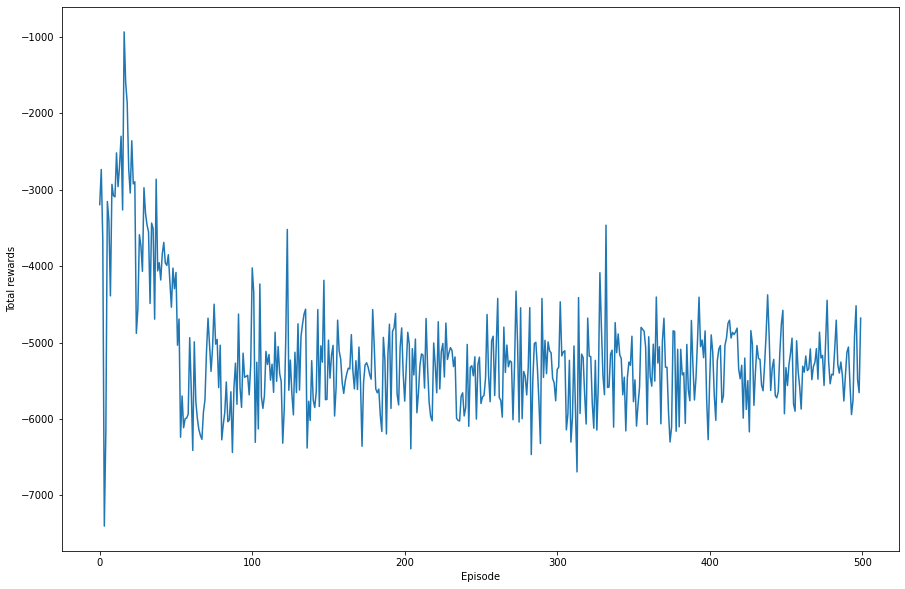

In [16]:
average_number=100
filtered_data=step_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

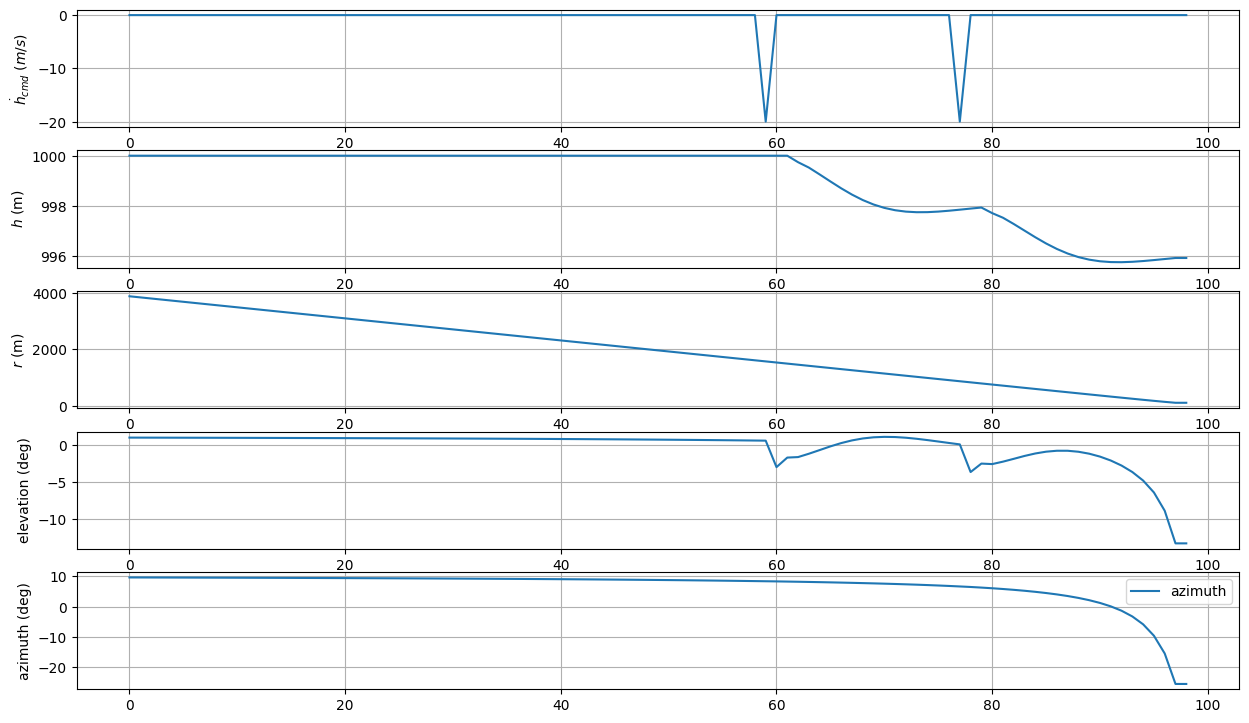

In [17]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[-3]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

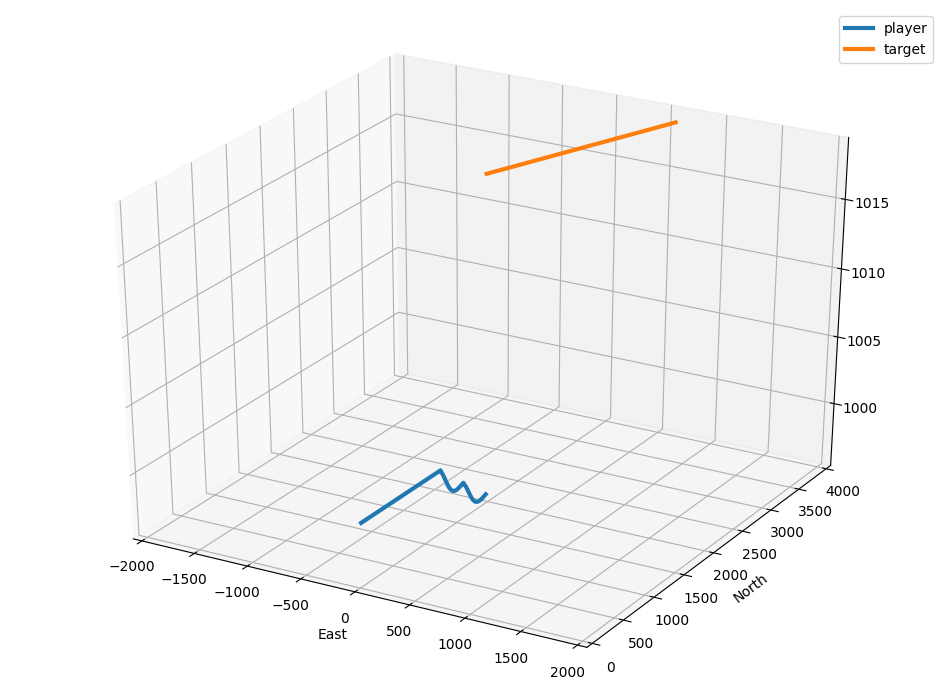

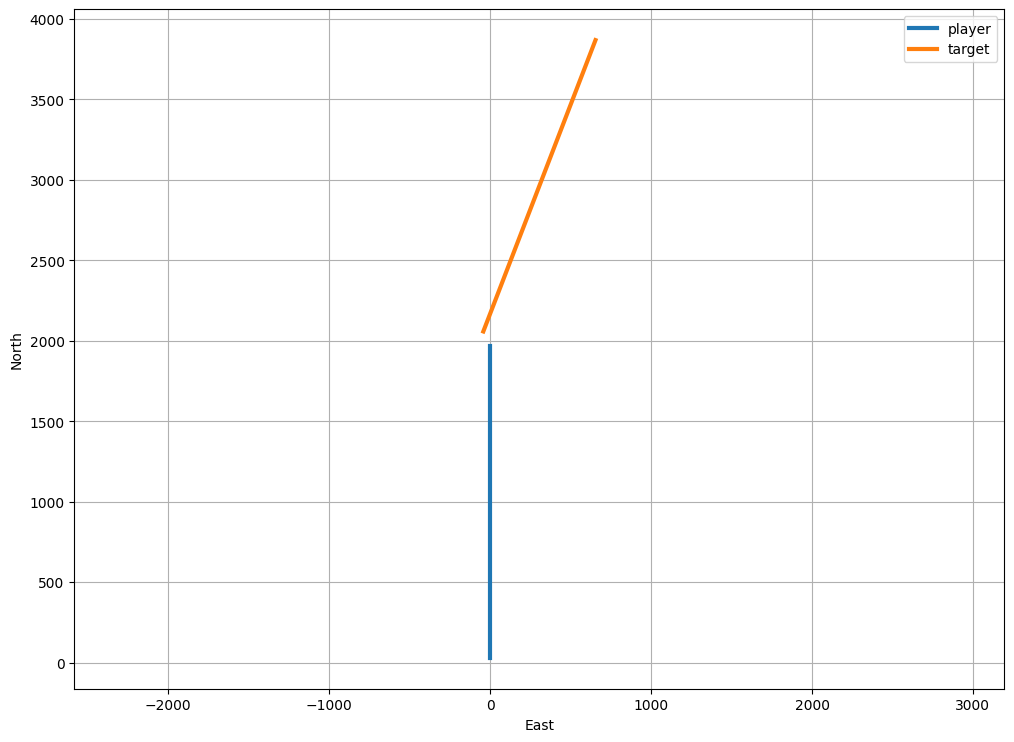

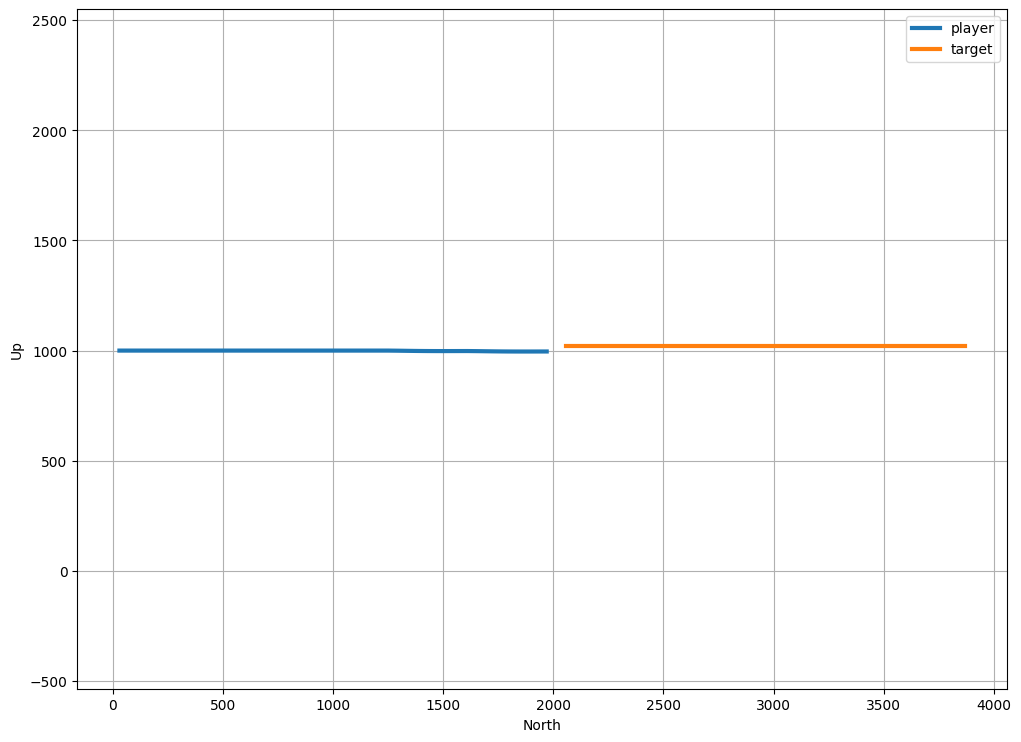

In [18]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()